# Advanced Lane Finding

## Imports

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from os.path import splitext, basename, join

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

%matplotlib inline

## Helpers

In [7]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def to_bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def to_lab(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

def read_image(path):
    return to_rgb(cv2.imread(path))

def plot_images(images, labels):
    rows = len(images)
    cols = len(images[0])
    cmap = None

    f, axes = plt.subplots(rows, cols, figsize=(12,20))
    
    for i, row in enumerate(images):
        for j, image in enumerate(row):
            label = labels[i][j]
            
            ax = axes[i, j] if rows > 1 else axes[j]
            
            if len(image.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"

            ax.imshow(image, cmap=cmap)
            ax.set_title(label, fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return

def map_to_list(fn, args):
    return list(map(fn, args))

def zip_to_list(l1, l2):
    return list(zip(l1, l2))

## Camera calibration

In [3]:
def calibrate(img_pattern):
    # Arrays to store object points and image points from all the images
    obj_points = []
    img_points = []

    # Prepare object points
    objp = np.zeros((9*6, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    calibration_images = glob.glob(img_pattern)

    for index, img_path in enumerate(calibration_images):
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray_img, (9, 6), None)

        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            
    # We know that the calibration and car images have the same size
    img_size = (1280, 720)
    
    # Do camera calibration given object points and image points
    # return obj_points, img_points
    return cv2.calibrateCamera(obj_points, img_points, img_size, None, None)


### Testing undistortion on chessboard

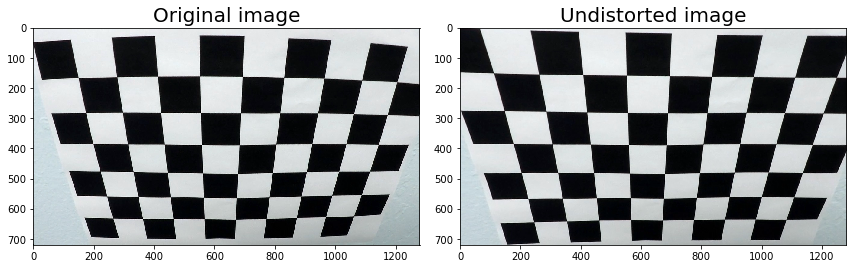

In [4]:
# calibrate the camera 
ret, mtx, dist, rvecs, tvecs = calibrate('camera_cal/calibration*.jpg')

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('camera_cal/calibration2.jpg')
undist = undistort(img, mtx, dist)

#cv2.imwrite('examples/undistorted.jpg', dst)

plot_images([[img, undist]], [['Original image', 'Undistorted image']])

### Undistorting test images

In [5]:
#img = cv2.imread('test_images/test1.jpg')
#dst = cv2.undistort(img, mtx, dist, None, mtx)

test_images_pattern = 'test_images/*.jpg'
test_images_paths = glob.glob(test_images_pattern)

test_images_labels = map_to_list(lambda path: splitext(basename(path))[0], test_images_paths)
undist_test_images_labels = map_to_list(lambda label: label + '_undistorted', test_images_labels)

test_images = map_to_list(lambda path: read_image(path), test_images_paths)
undist_test_images = map_to_list(lambda test_image: undistort(test_image, mtx, dist), test_images)

zipped_test_images = zip_to_list(test_images, undist_test_images)
zipped_test_labels = zip_to_list(test_images_labels, undist_test_images_labels)

plot_images(zipped_test_images, zipped_test_labels)

#cv2.imwrite('examples/test_image_undistorted.jpg', to_bgr(undist_test_images[0]))

# Thresholding

## Color thresholding

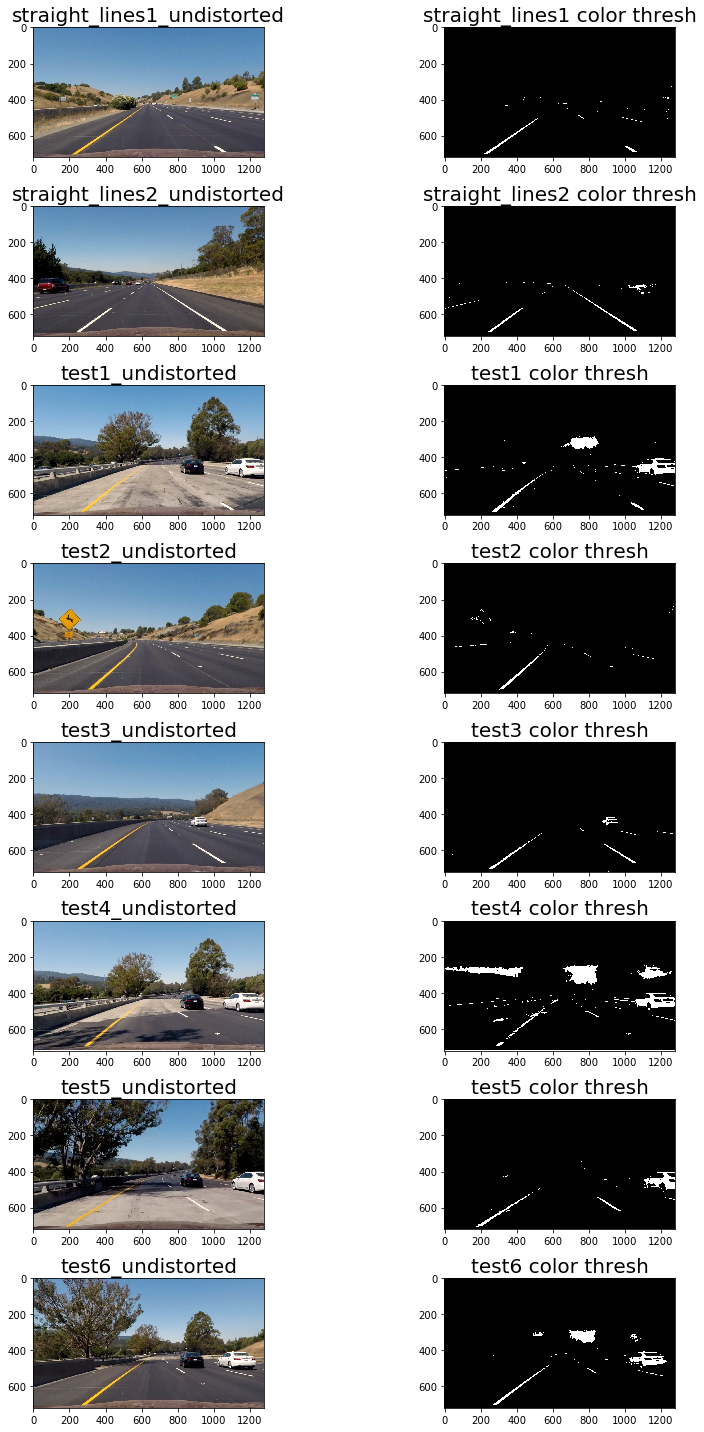

In [6]:
def color_thresholding(img):
    hls = to_hls(img)
    
    binary_yellow = np.zeros_like(hls[:,:,0])
    binary_yellow[((hls[:,:,0] >= 20) & (hls[:,:,0] <= 45)) & ((hls[:,:,1] >= 120) & (hls[:,:,1] <= 200)) & ((hls[:,:,2] >= 80) & (hls[:,:,2] <= 255))] = 1

    binary_white = np.zeros_like(hls[:,:,0])
    binary_white[((hls[:,:,0] >= 0) & (hls[:,:,0] <= 255)) & ((hls[:,:,1] >= 200) & (hls[:,:,1] <= 255)) & ((hls[:,:,2] >= 0) & (hls[:,:,2] <= 255))] = 1
    
    binary = np.zeros_like(hls[:,:,0])
    binary[(binary_yellow == 1) | (binary_white == 1)] = 1
    
    return binary

color_undist_test_images = map_to_list(lambda img: color_thresholding(img), undist_test_images)
color_undist_test_images_labels = map_to_list(lambda label: label + ' color thresh', test_images_labels)

zipped_color_undist_test_images = zip_to_list(undist_test_images, color_undist_test_images)
zipped_color_undist_test_labels = zip_to_list(undist_test_images_labels, color_undist_test_images_labels)

plot_images(zipped_color_undist_test_images, zipped_color_undist_test_labels)

## Gradient thresholding

In [8]:
def abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(gray_img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <=  mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <=  thresh[1])] = 1
    
    return dir_binary

In [15]:
def gradient_thresholding(img):
    #gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = to_lab(img)[:,:,0]

    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray_img, orient='x', sobel_kernel=ksize, thresh=(20, 130))
    grady = abs_sobel_thresh(gray_img, orient='y', sobel_kernel=ksize, thresh=(20, 130))
    mag_binary = mag_thresh(gray_img, sobel_kernel=ksize, mag_thresh=(100, 200))
    dir_binary = dir_threshold(gray_img, sobel_kernel=ksize, thresh=(0.75, 1.5))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

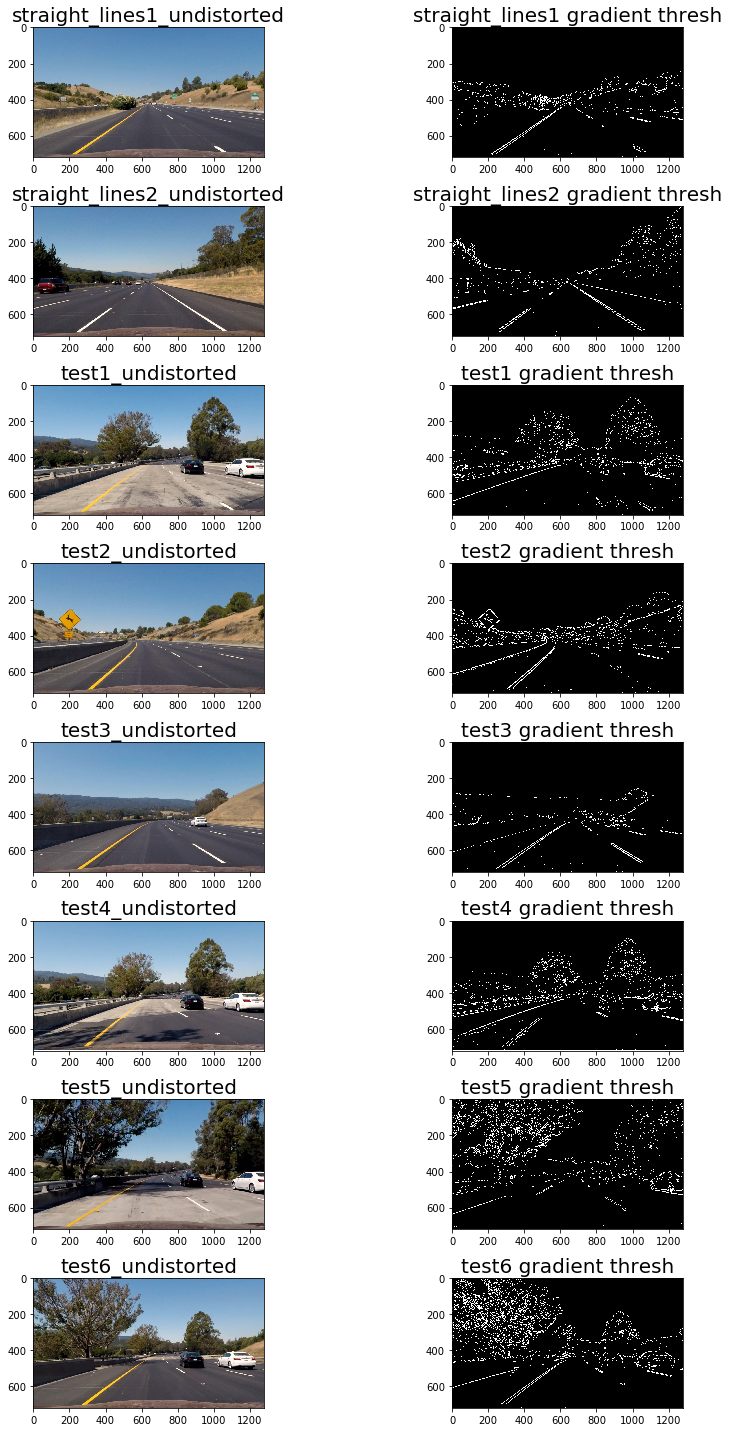

In [16]:
gradient_undist_test_images = map_to_list(lambda img: gradient_thresholding(img), undist_test_images)
gradient_undist_test_images_labels = map_to_list(lambda label: label + ' gradient thresh', test_images_labels)

zipped_gradient_undist_test_images = zip_to_list(undist_test_images, gradient_undist_test_images)
zipped_gradient_undist_test_labels = zip_to_list(undist_test_images_labels, gradient_undist_test_images_labels)

plot_images(zipped_gradient_undist_test_images, zipped_gradient_undist_test_labels)

## Combined color and gradient thresholding

In [17]:
def combined_thresholding(img):
    color_binary = color_thresholding(img)
    gradient_binary = gradient_thresholding(img)
    
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(gradient_binary == 1) | (color_binary == 1)] = 1
        
    return combined_binary

In [18]:
combined_undist_test_images = map_to_list(lambda img: combined_thresholding(img), undist_test_images)
combined_undist_test_images_labels = map_to_list(lambda label: label + ' combined thresh', test_images_labels)

zipped_combined_undist_test_images = zip_to_list(undist_test_images, combined_undist_test_images)
zipped_combined_undist_test_labels = zip_to_list(undist_test_images_labels, combined_undist_test_images_labels)

plot_images(zipped_combined_undist_test_images, zipped_combined_undist_test_labels)

cv2.imwrite('examples/test_image_combined.jpg', combined_undist_test_images[1])

True

# Perspective transform

In [19]:
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)

## Visualisation

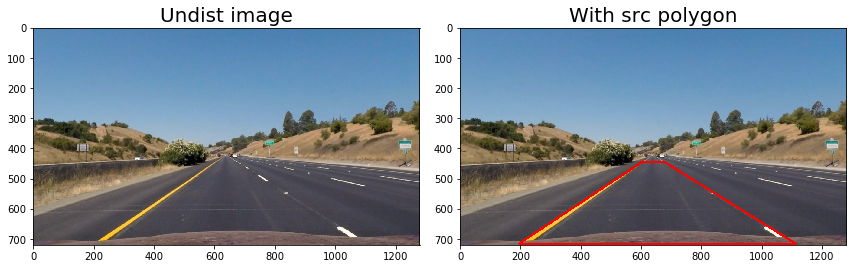

In [20]:
not_warped_test_img = np.copy(undist_test_images[0])
bottom_y = not_warped_test_img.shape[0] - 5

#src = np.array([[200, bottom_y], [600, 450], [680, 450], [1095, bottom_y]], np.float32)
src = np.array([[195, bottom_y], [602, 445], [675, 445], [1110, bottom_y]], np.float32)
#dst = np.array([[200, bottom_y], [200, 0], [1000, 0], [1000, bottom_y]], np.float32)
dst = np.array([[320, bottom_y], [320, 0], [960, 0], [960, bottom_y]], np.float32)

# draw src_points polygon on warp_test_img
src_polygon = src.astype(np.int32)
cv2.polylines(not_warped_test_img, [src_polygon], True, (255,0,0), 5)

plot_images([[undist_test_images[0], not_warped_test_img]], [['Undist image', 'With src polygon']])

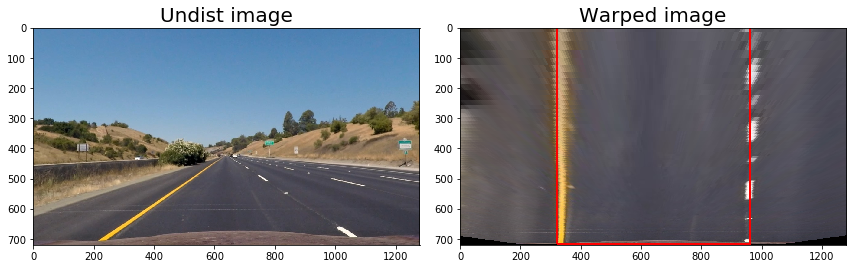

In [21]:
warped_test_img = warp(undist_test_images[0], src, dst)

# draw dst polygon on warp_test_img
dst_polygon = dst.astype(np.int32)
cv2.polylines(warped_test_img, [dst_polygon], True, (255,0,0), 5)

plot_images([[undist_test_images[0], warped_test_img]], [['Undist image', 'Warped image']])

#cv2.imwrite('examples/test_image_warped.jpg', to_bgr(warped_test_img))

## Applying on test images

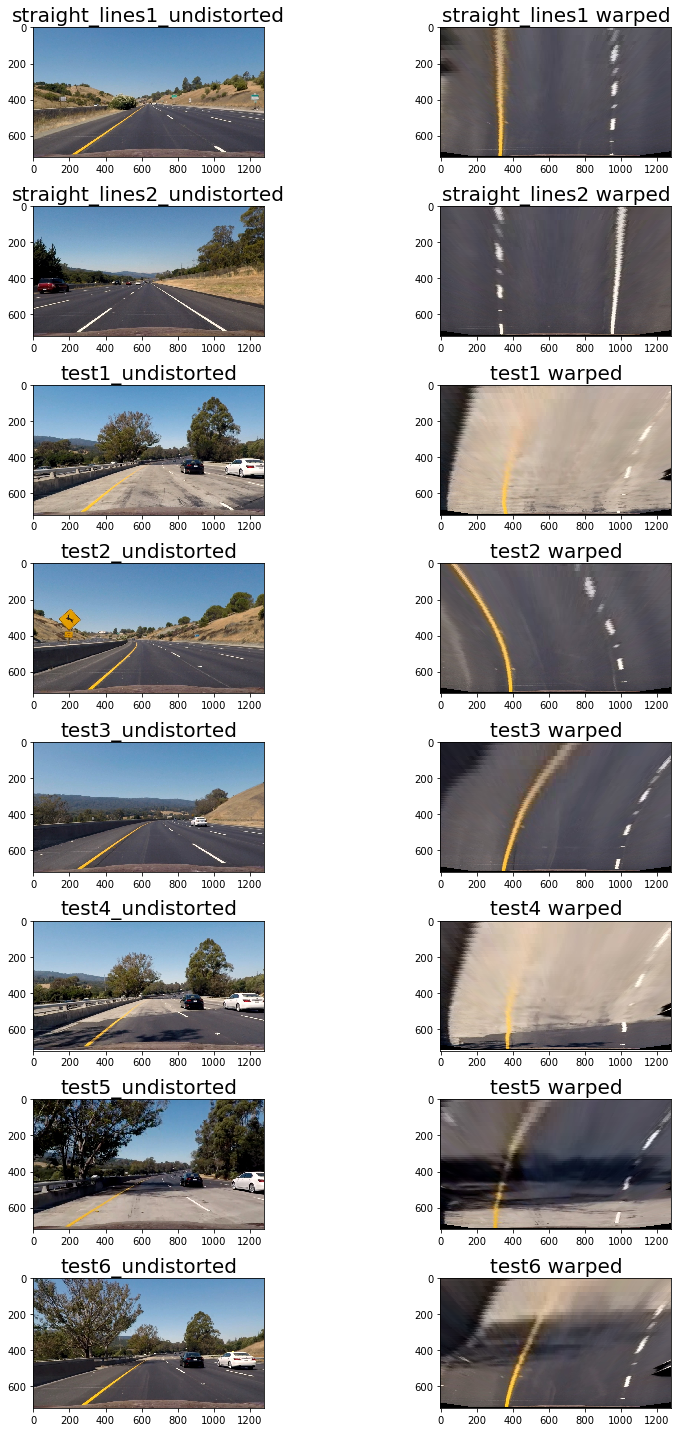

In [22]:
warped_undist_test_images = map_to_list(lambda img: warp(img, src, dst), undist_test_images)
warped_undist_test_images_labels = map_to_list(lambda label: label + ' warped', test_images_labels)

zipped_warped_undist_test_images = zip_to_list(undist_test_images, warped_undist_test_images)
zipped_warped_undist_test_labels = zip_to_list(undist_test_images_labels, warped_undist_test_images_labels)

plot_images(zipped_warped_undist_test_images, zipped_warped_undist_test_labels)

# Thresholding + warp

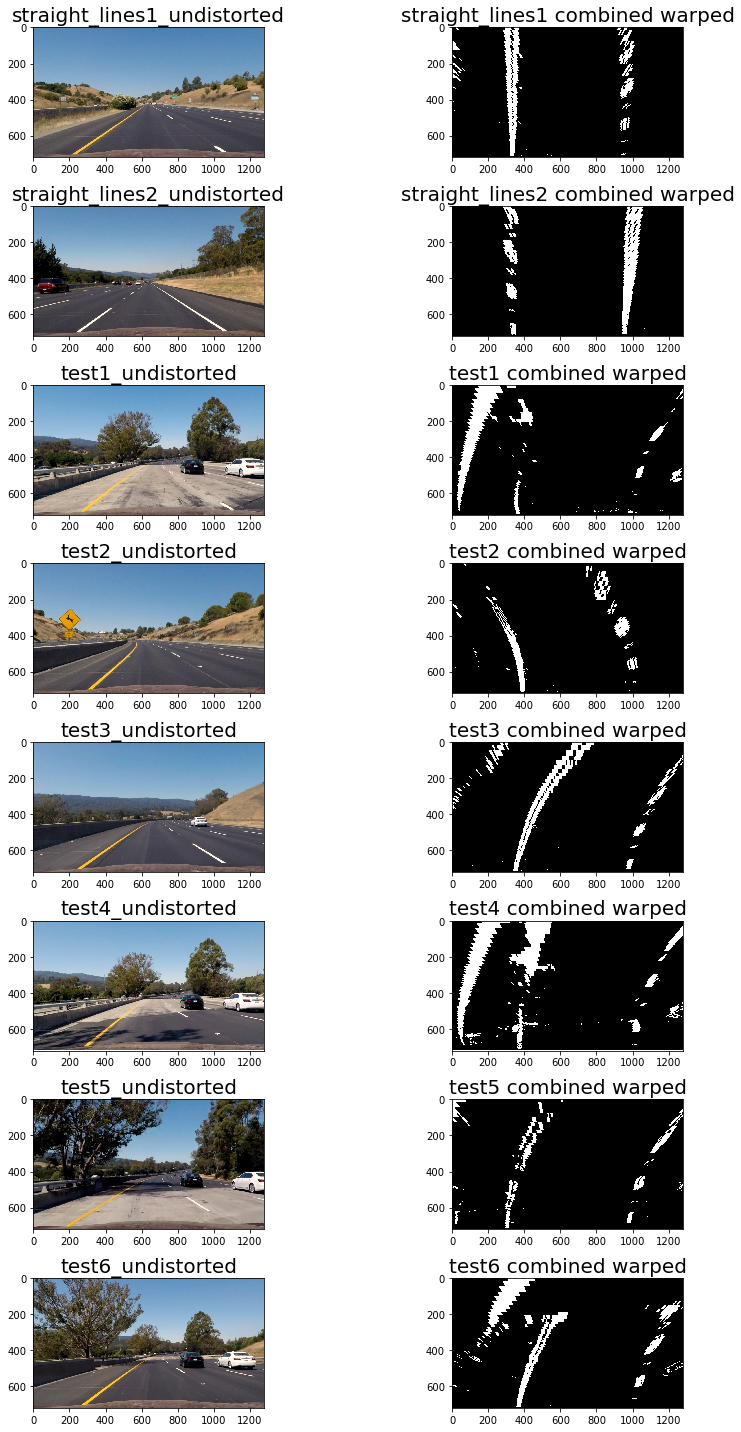

In [23]:
warped_combined_undist_test_images = map_to_list(lambda img: warp(img, src, dst), combined_undist_test_images)
warped_combined_undist_test_images_labels = map_to_list(lambda label: label + ' combined warped', test_images_labels)

zipped_warped_combined_undist_test_images = zip_to_list(undist_test_images, warped_combined_undist_test_images)
zipped_warped_combined_undist_test_labels = zip_to_list(undist_test_images_labels, warped_combined_undist_test_images_labels)

plot_images(zipped_warped_combined_undist_test_images, zipped_warped_combined_undist_test_labels)

# Pipeline

In [82]:
class LaneLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        self.polynomials = []
        
    def update(self, polynomial):
        self.detected = True
        
        self.polynomials.append(polynomial)
        
        if len(self.polynomials) > 5:
            self.polynomials = self.polynomials[1:]
        
    def get_smoothed_fit(self):        
        return np.mean(self.polynomials, axis=0)

class LaneLineDetector:
    def __init__(self, mtx, dist, warp_src, warp_dst):
        self.mtx = mtx
        self.dist = dist
        self.warp_src = warp_src
        self.warp_dst = warp_dst
        
        self.perspective_M = cv2.getPerspectiveTransform(warp_src, warp_dst)
        self.inverse_perspective_M = cv2.getPerspectiveTransform(warp_dst, warp_src)
        
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30 / 720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
        
        self.left_lane = LaneLine()
        self.right_lane = LaneLine()
        
        self.current_frame_index = 0
        
    def process_image(self, image):
        undist_image = undistort(image, self.mtx, self.dist)
        warped_image = warp(undist_image, self.warp_src, self.warp_dst)
        combined_image = combined_thresholding(warped_image)
        
        final_image = self.find_lane_lines(combined_image, undist_image)
        
        return final_image
    
    def find_lane_lines(self, image, undist_image):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_image = np.dstack((image, image, image))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(image.shape[0] / nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        if self.left_lane.detected and self.right_lane.detected:
            left_fit = self.left_lane.get_smoothed_fit()
            right_fit = self.right_lane.get_smoothed_fit()
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                                left_fit[1]*nonzeroy + left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                                right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        else:
            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = image.shape[0] - (window + 1) * window_height
                win_y_high = image.shape[0] - window * window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                # Draw the windows on the visualization image
                cv2.rectangle(out_image, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
                cv2.rectangle(out_image, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Check distance between left and right lane
        testy = np.asarray([50., 300., 500., 700., 900.])
        test_left_fitx = left_fit[0] * testy**2 + left_fit[1] * testy + left_fit[2]
        test_right_fitx = right_fit[0] * testy**2 + right_fit[1] * testy + right_fit[2]
        
        dist = np.absolute(np.asarray(test_left_fitx) - np.asarray(test_right_fitx))
        max_dist = dist[np.argmax(dist)]
        
        print('max_dist', max_dist)
        
        if self.current_frame_index > 0 and max_dist < 700:
            self.left_lane.update(left_fit)
            self.right_lane.update(right_fit)
            
            final_left_fit = self.left_lane.get_smoothed_fit()
            final_right_fit =  self.right_lane.get_smoothed_fit()
        else:
            final_left_fit = left_fit
            final_right_fit =  right_fit
        
        print('final_left_fit', final_left_fit)
        print('final_right_fit', final_right_fit)
        
        #final_left_fit = left_fit
        #final_right_fit =  right_fit
        #print('final_left_fit', final_left_fit)
        #print('final_right_fit', final_right_fit)
        
        ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
        left_fitx = final_left_fit[0] * ploty**2 + final_left_fit[1] * ploty + final_left_fit[2]
        right_fitx = final_right_fit[0] * ploty**2 + final_right_fit[1] * ploty + final_right_fit[2]
        
        out_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_image)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        #cv2.imwrite('examples/test_image_sliding_window.jpg', to_bgr(out_image))
        
        left_curverad, right_curverad, center_offset_meters = self.compute_lane_lines_curvature(left_fitx, right_fitx, final_left_fit, final_right_fit)
        image_with_lane_lines = self.draw_lanes_area(image, undist_image, left_fitx, right_fitx)
        image_with_curvature = self.draw_lanes_curvature(image_with_lane_lines, left_curverad, right_curverad, center_offset_meters)

        self.current_frame_index += 1
        
        return image_with_curvature
        
    def compute_lane_lines_curvature(self, leftx, rightx, left_fit, right_fit):
        ploty = np.linspace(0, 719, num=720)
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Calculate the center offset
        center_offset = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - 600
        center_offset_meters = center_offset * self.xm_per_pix
        
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center_offset_meters, 'm')
        return left_curverad, right_curverad, center_offset_meters
        # Example values: 632.1 m    626.2 m
        
    def draw_lanes_area(self, combined_image, undist_image, left_fitx, right_fitx):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(combined_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, combined_image.shape[0] - 1, combined_image.shape[0])
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        new_warp = cv2.warpPerspective(color_warp, self.inverse_perspective_M, (combined_image.shape[1], combined_image.shape[0]))

        # Combine the result with the original image
        result = cv2.addWeighted(undist_image, 1, new_warp, 0.3, 0)
        
        return result
    
    def draw_lanes_curvature(self, image, left_curverad, right_curverad, center_offset_meters):
        left_txt = "Curvature left = {:.4f}m".format(left_curverad)
        right_txt = "Curvature right = {:.4f}m".format(right_curverad)
        center_txt = "Center offset = {:.4f}m".format(center_offset_meters)
        with_left = cv2.putText(image, left_txt, (25, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        with_right = cv2.putText(image, right_txt, (25, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        result = cv2.putText(image, center_txt, (25, 180), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        return result
        

## Testing the pipeline on test images

max_dist 651.646881054
final_left_fit [ -6.49820207e-05   8.15597296e-02   3.09760133e+02]
final_right_fit [ -8.06405473e-05   3.31138848e-02   9.63868452e+02]
2527.27269643 m 2036.86535377 m 0.213536845877 m


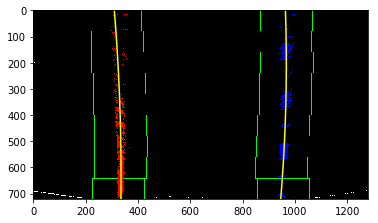

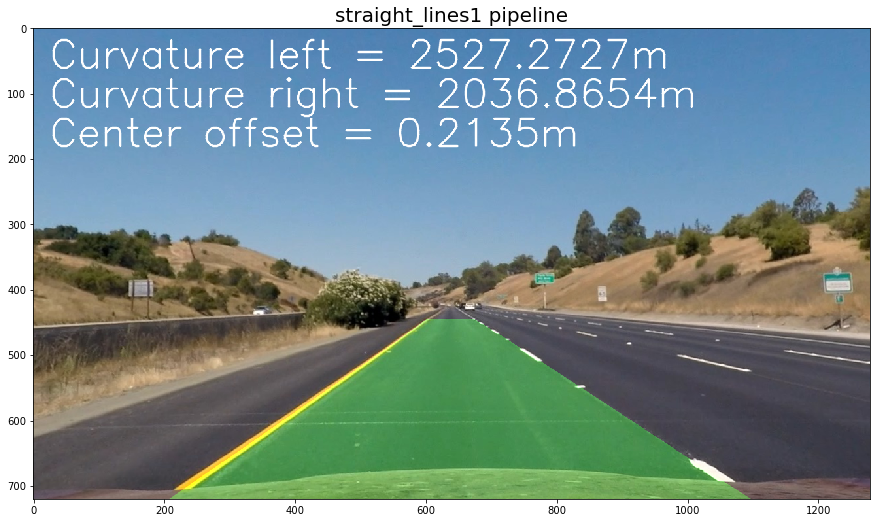

True

In [83]:
test_detector = LaneLineDetector(mtx, dist, src, dst)

pipeline_test_images = map_to_list(lambda img: test_detector.process_image(img), test_images[:1])
pipeline_test_images_labels = map_to_list(lambda label: label + ' pipeline', test_images_labels)

for i, image in enumerate(pipeline_test_images):
    label = pipeline_test_images_labels[i]
    plt.figure(figsize=(15,10))
    plt.imshow(image)
    plt.title(label, fontsize=20)
    plt.show()
    
    
cv2.imwrite('examples/test_image_area.jpg', to_bgr(pipeline_test_images[0]))

# Testing on video

In [73]:
videos_path = 'test_videos'
videos_output_path = 'test_videos_output'

project_video_path = join(videos_path, 'project_video.mp4')
project_video_output_path = join(videos_output_path, 'project_video_output.mp4')

sample_project_video_path = join(videos_path, 'sample_project_video.mp4')
sample_project_video_output_path = join(videos_output_path, 'sample_project_video_output.mp4')

## Create sample

In [74]:
if False:
   ffmpeg_extract_subclip(project_video_path, 22, 25, targetname=sample_project_video_path)

## Sample

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m
[MoviePy] >>>> Building video test_videos_output/sample_project_video_output.mp4
[MoviePy] Writing video test_videos_output/sample_project_video_output.mp4



  1%|▏         | 1/75 [00:00<00:19,  3.83it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



  3%|▎         | 2/75 [00:00<00:19,  3.80it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



  4%|▍         | 3/75 [00:00<00:19,  3.74it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



  5%|▌         | 4/75 [00:01<00:18,  3.76it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



  7%|▋         | 5/75 [00:01<00:18,  3.80it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



  8%|▊         | 6/75 [00:01<00:19,  3.61it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



  9%|▉         | 7/75 [00:01<00:19,  3.57it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 11%|█         | 8/75 [00:02<00:18,  3.68it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 12%|█▏        | 9/75 [00:02<00:18,  3.54it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 13%|█▎        | 10/75 [00:02<00:18,  3.61it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 15%|█▍        | 11/75 [00:03<00:17,  3.57it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 16%|█▌        | 12/75 [00:03<00:18,  3.45it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 17%|█▋        | 13/75 [00:03<00:18,  3.40it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 19%|█▊        | 14/75 [00:03<00:17,  3.47it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 20%|██        | 15/75 [00:04<00:16,  3.55it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 21%|██▏       | 16/75 [00:04<00:16,  3.55it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 23%|██▎       | 17/75 [00:04<00:15,  3.63it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 24%|██▍       | 18/75 [00:04<00:15,  3.68it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 25%|██▌       | 19/75 [00:05<00:15,  3.60it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 27%|██▋       | 20/75 [00:05<00:14,  3.68it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 28%|██▊       | 21/75 [00:05<00:14,  3.61it/s]

max_dist 718.205206188
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [  1.12425524e-05  -9.55854569e-02   1.06806932e+03]
1624.11357326 m 14609.8257125 m 0.393735977518 m



 29%|██▉       | 22/75 [00:06<00:14,  3.64it/s]

max_dist 732.02312659
final_left_fit [  9.85937263e-06   9.11032102e-03   3.29642829e+02]
final_right_fit [  1.49548457e-05  -1.00446022e-01   1.06713103e+03]
16657.1325388 m 10983.1578899 m 0.380390331834 m



 31%|███       | 23/75 [00:06<00:13,  3.73it/s]

max_dist 829.06018442
final_left_fit [ -2.53685948e-04   3.35915622e-01   2.26552435e+02]
final_right_fit [ -3.04938307e-06  -1.03612868e-01   1.07696245e+03]
647.375370313 m 53870.8855123 m 0.364234380261 m



 32%|███▏      | 24/75 [00:06<00:13,  3.66it/s]

max_dist 775.713857374
final_left_fit [ -1.34900341e-04   1.75332342e-01   2.82933882e+02]
final_right_fit [  5.07013668e-05  -1.25583130e-01   1.07322951e+03]
1217.40319716 m 3239.31555475 m 0.392214503586 m



 33%|███▎      | 25/75 [00:06<00:13,  3.73it/s]

max_dist 711.611356465
final_left_fit [  5.65158651e-05  -7.06854465e-02   3.63107706e+02]
final_right_fit [  1.06268773e-04  -1.70916279e-01   1.07960622e+03]
2905.85963042 m 1545.40247963 m 0.404768364436 m



 35%|███▍      | 26/75 [00:07<00:13,  3.66it/s]

max_dist 761.230427571
final_left_fit [ -1.49984415e-04   1.70984101e-01   2.94401947e+02]
final_right_fit [  1.65321866e-04  -1.93032646e-01   1.07304495e+03]
1095.01141105 m 993.423629452 m 0.421596115335 m



 36%|███▌      | 27/75 [00:07<00:12,  3.73it/s]

max_dist 714.070674116
final_left_fit [  8.99639685e-05  -1.23528406e-01   3.85212244e+02]
final_right_fit [  2.64237063e-04  -2.48809289e-01   1.07087451e+03]
1825.47373859 m 621.770959919 m 0.453207890666 m



 37%|███▋      | 28/75 [00:07<00:12,  3.63it/s]

max_dist 716.195001381
final_left_fit [ -4.04494737e-05   2.67996596e-02   3.44865343e+02]
final_right_fit [  2.65248051e-04  -2.52258661e-01   1.06459784e+03]
4060.14249188 m 619.393327961 m 0.432292818054 m



 39%|███▊      | 29/75 [00:07<00:12,  3.69it/s]

max_dist 701.154764846
final_left_fit [  3.91349346e-05  -6.58613568e-02   3.72536998e+02]
final_right_fit [  2.44800114e-04  -2.27400238e-01   1.05248796e+03]
4196.43197599 m 671.112020534 m 0.425376362211 m



 40%|████      | 30/75 [00:08<00:11,  3.75it/s]

max_dist 680.550516774
final_left_fit [  4.37539991e-05  -7.55711648e-02   3.76629680e+02]
final_right_fit [  1.71768943e-04  -1.82172671e-01   1.04942945e+03]
3753.4251697 m 956.187927364 m 0.402132557427 m



 41%|████▏     | 31/75 [00:08<00:12,  3.66it/s]

max_dist 702.584731259
final_left_fit [  8.88618654e-05  -1.25568756e-01   3.88952944e+02]
final_right_fit [  2.77433769e-04  -2.65868250e-01   1.06506398e+03]
1848.11274696 m 592.202394231 m 0.427969146965 m



 43%|████▎     | 32/75 [00:08<00:11,  3.72it/s]

max_dist 698.109817078
final_left_fit [  7.83854790e-05  -1.14996376e-01   3.86412767e+02]
final_right_fit [  2.24912098e-04  -2.28728792e-01   1.05941555e+03]
2095.11697059 m 730.339886114 m 0.410919193097 m



 44%|████▍     | 33/75 [00:09<00:11,  3.63it/s]

max_dist 699.532008019
final_left_fit [  9.02982207e-05  -1.27825336e-01   3.89598571e+02]
final_right_fit [  2.52446928e-04  -2.52129056e-01   1.06286225e+03]
1818.71515962 m 650.732720892 m 0.413500069629 m



 45%|████▌     | 34/75 [00:09<00:11,  3.67it/s]

max_dist 697.631149095
final_left_fit [  9.07204442e-05  -1.27053448e-01   3.89260770e+02]
final_right_fit [  2.65147095e-04  -2.59155243e-01   1.06082267e+03]
1810.25097485 m 619.602704324 m 0.413261012633 m



 47%|████▋     | 35/75 [00:09<00:10,  3.73it/s]

max_dist 687.737607799
final_left_fit [  8.92430868e-05  -1.22609273e-01   3.86402859e+02]
final_right_fit [  2.65041649e-04  -2.63779228e-01   1.06288368e+03]
1840.21936468 m 619.832102353 m 0.40865073765 m



 48%|████▊     | 36/75 [00:09<00:10,  3.74it/s]

max_dist 710.22245887
final_left_fit [  4.35127438e-06  -3.94937537e-02   3.68629018e+02]
final_right_fit [  3.18396424e-04  -3.07828911e-01   1.06597655e+03]
37743.2199845 m 516.073513121 m 0.400996863477 m



 49%|████▉     | 37/75 [00:10<00:10,  3.60it/s]

max_dist 705.482836496
final_left_fit [  3.15597229e-05  -5.17085845e-02   3.63661625e+02]
final_right_fit [  3.30032136e-04  -3.29207896e-01   1.07713119e+03]
5203.68590538 m 497.862179094 m 0.406584415943 m



 51%|█████     | 38/75 [00:10<00:10,  3.52it/s]

max_dist 717.300542122
final_left_fit [  5.98209015e-05  -7.85323535e-02   3.70625686e+02]
final_right_fit [  4.07364604e-04  -3.83939748e-01   1.08128248e+03]
2745.31049999 m 403.540884592 m 0.425255312823 m



 52%|█████▏    | 39/75 [00:10<00:10,  3.58it/s]

max_dist 746.190443522
final_left_fit [  7.27803262e-05  -8.15390730e-02   3.66241076e+02]
final_right_fit [  5.01571026e-04  -4.46109191e-01   1.09322416e+03]
2256.5005419 m 328.023222605 m 0.467794655365 m



 53%|█████▎    | 40/75 [00:10<00:09,  3.68it/s]

max_dist 748.500243068
final_left_fit [  2.97775759e-05  -2.31475079e-02   3.41034924e+02]
final_right_fit [  4.16031592e-04  -4.15457930e-01   1.10818505e+03]
5515.16556434 m 395.064247706 m 0.434297069951 m



 55%|█████▍    | 41/75 [00:11<00:09,  3.65it/s]

max_dist 774.740618388
final_left_fit [  7.27461512e-05  -3.40332396e-02   3.27455444e+02]
final_right_fit [  3.81829650e-04  -4.17658617e-01   1.12060462e+03]
2257.80292404 m 430.284006576 m 0.41834204035 m



 56%|█████▌    | 42/75 [00:11<00:08,  3.72it/s]

max_dist 763.897117788
final_left_fit [  1.07609831e-04  -8.10952785e-02   3.42969585e+02]
final_right_fit [  3.54606946e-04  -4.14352127e-01   1.12291205e+03]
1526.33107531 m 463.225382645 m 0.392736503289 m



 57%|█████▋    | 43/75 [00:11<00:08,  3.78it/s]

max_dist 776.775385027
final_left_fit [  1.50119687e-04  -1.03455399e-01   3.37842348e+02]
final_right_fit [  4.06514174e-04  -4.58800407e-01   1.13174400e+03]
1094.30569505 m 404.141959903 m 0.404574963005 m



 59%|█████▊    | 44/75 [00:12<00:08,  3.55it/s]

max_dist 793.267160798
final_left_fit [  1.01238683e-04  -5.84207025e-02   3.26480204e+02]
final_right_fit [  3.50795102e-04  -4.41787466e-01   1.13829181e+03]
1622.47116246 m 468.200065987 m 0.366844902637 m



 60%|██████    | 45/75 [00:12<00:08,  3.69it/s]

max_dist 785.387077383
final_left_fit [  1.10962223e-04  -7.91371751e-02   3.35939100e+02]
final_right_fit [  3.99745000e-04  -4.80265759e-01   1.14066065e+03]
1480.25485664 m 410.917411539 m 0.365784001857 m



 61%|██████▏   | 46/75 [00:12<00:07,  3.77it/s]

max_dist 806.734606909
final_left_fit [  1.38268557e-04  -8.24456532e-02   3.25340644e+02]
final_right_fit [  3.43912982e-04  -4.56756247e-01   1.15027667e+03]
1188.12570763 m 477.540532124 m 0.362600523046 m



 63%|██████▎   | 47/75 [00:12<00:07,  3.75it/s]

max_dist 814.881280666
final_left_fit [  1.84400416e-04  -1.19814546e-01   3.28683523e+02]
final_right_fit [  3.43366345e-04  -4.72411346e-01   1.16079723e+03]
891.052705639 m 478.289546928 m 0.360763657081 m



 64%|██████▍   | 48/75 [00:13<00:07,  3.67it/s]

max_dist 817.570194345
final_left_fit [  1.73445410e-04  -1.23697966e-01   3.32770913e+02]
final_right_fit [  3.62125128e-04  -4.95439449e-01   1.16845648e+03]
947.210909937 m 453.515237725 m 0.351332643701 m



 65%|██████▌   | 49/75 [00:13<00:06,  3.76it/s]

max_dist 822.833381139
final_left_fit [  1.96624949e-04  -1.50248048e-01   3.37322602e+02]
final_right_fit [  3.96759314e-04  -5.31158758e-01   1.17870118e+03]
835.582306291 m 413.935777017 m 0.351100434646 m



 67%|██████▋   | 50/75 [00:13<00:06,  3.84it/s]

max_dist 831.924548392
final_left_fit [  2.56191449e-04  -2.00821145e-01   3.44687440e+02]
final_right_fit [  5.48694072e-04  -6.47990900e-01   1.19823922e+03]
641.465873497 m 299.448436117 m 0.39305952045 m



 68%|██████▊   | 51/75 [00:13<00:06,  3.79it/s]

max_dist 865.863003412
final_left_fit [  2.13353102e-04  -1.49358497e-01   3.24944132e+02]
final_right_fit [  6.17124376e-04  -7.05333918e-01   1.21759648e+03]
770.202087011 m 266.329114414 m 0.415830398375 m



 69%|██████▉   | 52/75 [00:14<00:06,  3.56it/s]

max_dist 881.424844344
final_left_fit [  2.01684495e-04  -1.37394285e-01   3.20575421e+02]
final_right_fit [  5.94947512e-04  -7.09864245e-01   1.22964061e+03]
814.733352141 m 276.177061074 m 0.403999892666 m



 71%|███████   | 53/75 [00:14<00:06,  3.34it/s]

max_dist 895.008631812
final_left_fit [  2.33992536e-04  -1.80466882e-01   3.32683818e+02]
final_right_fit [  7.24864907e-04  -8.41733925e-01   1.25952862e+03]
702.258419404 m 226.781997434 m 0.404203757146 m



 72%|███████▏  | 54/75 [00:14<00:06,  3.24it/s]

max_dist 895.488923515
final_left_fit [  2.68527666e-04  -2.29769193e-01   3.51971113e+02]
final_right_fit [  8.09213530e-04  -9.32290132e-01   1.28123437e+03]
611.943180306 m 203.208377534 m 0.409206766881 m



 73%|███████▎  | 55/75 [00:15<00:05,  3.41it/s]

max_dist 858.801066453
final_left_fit [  3.78287714e-04  -3.90212171e-01   4.12222210e+02]
final_right_fit [  9.33378518e-04  -1.05825420e+00   1.30303765e+03]
434.379602342 m 176.291231115 m 0.40143103556 m



 75%|███████▍  | 56/75 [00:15<00:05,  3.56it/s]

max_dist 766.315419105
final_left_fit [  4.27100086e-04  -5.01206017e-01   4.64974179e+02]
final_right_fit [  7.35603684e-04  -8.60474342e-01   1.24848176e+03]
384.634239601 m 223.464224889 m 0.358054971835 m



 76%|███████▌  | 57/75 [00:15<00:05,  3.58it/s]

max_dist 734.50678978
final_left_fit [  4.89269790e-04  -5.95116218e-01   5.00970148e+02]
final_right_fit [  7.83535252e-04  -9.03427853e-01   1.25015686e+03]
335.752096467 m 209.849434651 m 0.347970160495 m



 77%|███████▋  | 58/75 [00:15<00:04,  3.71it/s]

max_dist 743.955195318
final_left_fit [  5.20300162e-04  -6.16077780e-01   4.96694869e+02]
final_right_fit [  7.34296317e-04  -8.77526052e-01   1.25318749e+03]
315.771426876 m 223.823676227 m 0.329190721736 m



 79%|███████▊  | 59/75 [00:16<00:04,  3.62it/s]

max_dist 753.240621526
final_left_fit [  5.16196022e-04  -6.12552995e-01   4.92803392e+02]
final_right_fit [  7.19723022e-04  -8.81590477e-01   1.25898707e+03]
318.277262203 m 228.310032202 m 0.307690018538 m



 80%|████████  | 60/75 [00:16<00:04,  3.70it/s]

max_dist 754.9711823
final_left_fit [  5.48725806e-04  -6.41023887e-01   4.95098984e+02]
final_right_fit [  7.01054148e-04  -8.73997934e-01   1.26133805e+03]
299.445766517 m 234.358559118 m 0.299234429305 m



 81%|████████▏ | 61/75 [00:16<00:03,  3.80it/s]

max_dist 766.923130671
final_left_fit [  5.79469891e-04  -6.67567870e-01   4.97916335e+02]
final_right_fit [  7.85213711e-04  -9.49625556e-01   1.27842799e+03]
283.596437824 m 209.311793632 m 0.314686194435 m



 83%|████████▎ | 62/75 [00:17<00:03,  3.70it/s]

max_dist 758.52532657
final_left_fit [  6.16506501e-04  -7.37870423e-01   5.30566850e+02]
final_right_fit [  9.84916851e-04  -1.11580255e+00   1.30706776e+03]
266.524929102 m 167.105325998 m 0.350752479832 m



 84%|████████▍ | 63/75 [00:17<00:03,  3.75it/s]

max_dist 766.85668539
final_left_fit [  6.75410904e-04  -8.03389704e-01   5.50706738e+02]
final_right_fit [  1.17226487e-03  -1.27361706e+00   1.33831633e+03]
243.316221687 m 140.668231792 m 0.398626165338 m



 85%|████████▌ | 64/75 [00:17<00:02,  3.75it/s]

max_dist 768.308128975
final_left_fit [  7.41070497e-04  -8.95619755e-01   5.81968938e+02]
final_right_fit [  1.21110486e-03  -1.31571504e+00   1.34763499e+03]
221.762115847 m 136.194796554 m 0.393396513464 m



 87%|████████▋ | 65/75 [00:17<00:02,  3.68it/s]

max_dist 753.558200559
final_left_fit [  7.57698336e-04  -9.09194789e-01   5.83462401e+02]
final_right_fit [  1.16650207e-03  -1.30734807e+00   1.35590626e+03]
216.914456443 m 141.251336567 m 0.371085970052 m



 88%|████████▊ | 66/75 [00:18<00:02,  3.68it/s]

max_dist 682.532146937
final_left_fit [  2.40418435e-04  -3.05945440e-01   4.35398081e+02]
final_right_fit [  4.02142233e-04  -4.39645924e-01   1.11448910e+03]
683.113168369 m 408.569184942 m 0.385819611963 m



 89%|████████▉ | 67/75 [00:18<00:02,  3.64it/s]

max_dist 659.84193813
final_left_fit [  3.82121460e-04  -4.86841857e-01   4.87122981e+02]
final_right_fit [  4.89051254e-04  -5.72278236e-01   1.15694210e+03]
429.816964824 m 335.945849769 m 0.351288706944 m



 91%|█████████ | 68/75 [00:18<00:01,  3.75it/s]

max_dist 661.810422724
final_left_fit [  5.25235760e-04  -6.73333454e-01   5.41361467e+02]
final_right_fit [  5.50083502e-04  -6.86068530e-01   1.19783043e+03]
312.72309899 m 298.628106581 m 0.311011395841 m



 92%|█████████▏| 69/75 [00:18<00:01,  3.69it/s]

max_dist 647.99336468
final_left_fit [  6.75045100e-04  -8.83013948e-01   6.07768662e+02]
final_right_fit [  6.21459095e-04  -8.15511627e-01   1.24387725e+03]
243.327769759 m 264.298870349 m 0.265998630423 m



 93%|█████████▎| 70/75 [00:19<00:01,  3.81it/s]

max_dist 645.085528166
final_left_fit [  8.10793601e-04  -1.08364275e+00   6.74629643e+02]
final_right_fit [  6.80323746e-04  -9.32491447e-01   1.28660045e+03]
202.583696361 m 241.407195576 m 0.217980538346 m



 95%|█████████▍| 71/75 [00:19<00:01,  3.70it/s]

max_dist 650.202196749
final_left_fit [  7.97373149e-04  -1.11245979e+00   6.98055203e+02]
final_right_fit [  6.25641947e-04  -8.99225191e-01   1.28357091e+03]
205.96549263 m 262.493153349 m 0.187293794643 m



 96%|█████████▌| 72/75 [00:19<00:00,  3.78it/s]

max_dist 649.380121873
final_left_fit [  7.77628349e-04  -1.11912283e+00   7.10406308e+02]
final_right_fit [  5.86561989e-04  -8.82541253e-01   1.28698996e+03]
211.18922705 m 279.992191041 m 0.167644337441 m



 97%|█████████▋| 73/75 [00:19<00:00,  3.88it/s]

max_dist 651.568754445
final_left_fit [  7.56339365e-04  -1.12110465e+00   7.21417668e+02]
final_right_fit [  5.61007798e-04  -8.76705679e-01   1.29311059e+03]
217.139527779 m 292.769796949 m 0.156245018432 m



 99%|█████████▊| 74/75 [00:20<00:00,  3.78it/s]

max_dist 651.060902732
final_left_fit [  7.31925872e-04  -1.10690554e+00   7.23643235e+02]
final_right_fit [  5.25558202e-04  -8.62258216e-01   1.29972855e+03]
224.392200416 m 312.56613778 m 0.152263653044 m



100%|██████████| 75/75 [00:20<00:00,  3.83it/s]

max_dist 645.763055217
final_left_fit [  7.42369368e-04  -1.14500156e+00   7.47781742e+02]
final_right_fit [  5.47618163e-04  -8.92234448e-01   1.31077213e+03]
221.251750455 m 299.972217839 m 0.160300995546 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/sample_project_video_output.mp4 

CPU times: user 30.5 s, sys: 3.99 s, total: 34.5 s
Wall time: 21.3 s


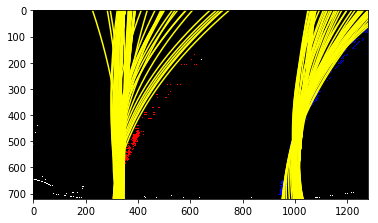

In [84]:
sample_project_video_detector = LaneLineDetector(mtx, dist, src, dst)

sample_project_video_clip = VideoFileClip(sample_project_video_path)
sample_project_video_output_clip = sample_project_video_clip.fl_image(sample_project_video_detector.process_image)
%time sample_project_video_output_clip.write_videofile(sample_project_video_output_path, audio=False)

## Project video

max_dist 675.520404248
final_left_fit [ -5.72248675e-04   8.47007262e-01   7.42934255e+01]
final_right_fit [ -4.45550816e-04   6.94706565e-01   7.57112120e+02]
286.988924551 m 368.618533912 m 0.564871452138 m
[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4



  0%|          | 1/1261 [00:00<06:03,  3.47it/s]

max_dist 675.520404248
final_left_fit [ -5.72248675e-04   8.47007262e-01   7.42934255e+01]
final_right_fit [ -4.45550816e-04   6.94706565e-01   7.57112120e+02]
286.988924551 m 368.618533912 m 0.564871452138 m



  0%|          | 2/1261 [00:00<05:52,  3.57it/s]

max_dist 662.947192586
final_left_fit [ -5.77357562e-04   8.52588936e-01   7.35649065e+01]
final_right_fit [ -4.43123075e-04   7.04065549e-01   7.49889288e+02]
284.44887139 m 370.651981071 m 0.568584494381 m



  0%|          | 3/1261 [00:00<05:44,  3.65it/s]

max_dist 655.54266249
final_left_fit [ -5.78951397e-04   8.55106614e-01   7.30345231e+01]
final_right_fit [ -4.39993913e-04   7.09107638e-01   7.44647771e+02]
283.665861642 m 373.300311077 m 0.569793009583 m



  0%|          | 4/1261 [00:01<05:41,  3.68it/s]

max_dist 654.550462062
final_left_fit [ -5.78734487e-04   8.56378853e-01   7.25284034e+01]
final_right_fit [ -4.37480740e-04   7.13633379e-01   7.39798710e+02]
283.772687249 m 375.456660984 m 0.570387424078 m



  0%|          | 5/1261 [00:01<05:51,  3.58it/s]

max_dist 654.887510002
final_left_fit [ -5.76403976e-04   8.57198975e-01   7.16260624e+01]
final_right_fit [ -4.30384498e-04   7.12273265e-01   7.37332857e+02]
284.921539833 m 381.661739529 m 0.573339007931 m



  0%|          | 6/1261 [00:01<05:59,  3.49it/s]

max_dist 659.31773357
final_left_fit [ -5.75302990e-04   8.61168592e-01   6.97252948e+01]
final_right_fit [ -4.17738541e-04   7.14409093e-01   7.29919955e+02]
285.469189116 m 393.255501001 m 0.579107779852 m



  1%|          | 7/1261 [00:01<05:59,  3.49it/s]

max_dist 664.376801486
final_left_fit [ -5.66643905e-04   8.59200027e-01   6.82249669e+01]
final_right_fit [ -3.97314254e-04   7.05375887e-01   7.27244710e+02]
289.83728285 m 413.521420662 m 0.586901885542 m



  1%|          | 8/1261 [00:02<05:49,  3.58it/s]

max_dist 698.355348131
final_left_fit [ -5.59488288e-04   8.59740482e-01   6.59707766e+01]
final_right_fit [ -3.57853107e-04   6.86483220e-01   7.24875387e+02]
293.551819092 m 459.249528733 m 0.603499814267 m



  1%|          | 9/1261 [00:02<05:52,  3.55it/s]

max_dist 688.007554915
final_left_fit [ -5.44114645e-04   8.53087927e-01   6.46008748e+01]
final_right_fit [ -3.18526215e-04   6.62574652e-01   7.26325183e+02]
301.860125505 m 516.10382308 m 0.620373109271 m



  1%|          | 10/1261 [00:02<06:00,  3.47it/s]

max_dist 682.410289473
final_left_fit [ -5.32053998e-04   8.48356612e-01   6.27432145e+01]
final_right_fit [ -2.90485414e-04   6.47604466e-01   7.26243139e+02]
308.71718193 m 566.074119922 m 0.632598440387 m



  1%|          | 11/1261 [00:03<06:03,  3.44it/s]

max_dist 671.037946675
final_left_fit [ -5.22343227e-04   8.45261173e-01   6.05457786e+01]
final_right_fit [ -2.79021289e-04   6.46284426e-01   7.23371670e+02]
314.471110108 m 589.434739825 m 0.639741978551 m



  1%|          | 12/1261 [00:03<05:58,  3.49it/s]

max_dist 689.326816936
final_left_fit [ -5.07889644e-04   8.38265463e-01   5.82098969e+01]
final_right_fit [ -2.67236647e-04   6.32192330e-01   7.28171941e+02]
323.442113512 m 615.4486044 m 0.642031738922 m



  1%|          | 13/1261 [00:03<05:57,  3.49it/s]

max_dist 676.600598311
final_left_fit [ -4.93478438e-04   8.30674386e-01   5.60051133e+01]
final_right_fit [ -2.80234050e-04   6.35020322e-01   7.30737973e+02]
332.911853365 m 586.796026044 m 0.63586719837 m



  1%|          | 14/1261 [00:03<06:08,  3.38it/s]

max_dist 668.526893699
final_left_fit [ -4.87951337e-04   8.30205679e-01   5.29536885e+01]
final_right_fit [ -3.00848243e-04   6.47660872e-01   7.29192519e+02]
336.697966217 m 546.488416516 m 0.62623461574 m



  1%|          | 15/1261 [00:04<06:10,  3.36it/s]

max_dist 656.598023521
final_left_fit [ -4.96243812e-04   8.41278296e-01   4.85082451e+01]
final_right_fit [ -3.24196268e-04   6.70329423e-01   7.21343278e+02]
331.06983572 m 507.075396177 m 0.614628006256 m



  1%|▏         | 16/1261 [00:04<06:02,  3.44it/s]

max_dist 655.201871273
final_left_fit [ -5.08609956e-04   8.55829899e-01   4.37070389e+01]
final_right_fit [ -3.39483103e-04   6.87655694e-01   7.13243415e+02]
323.01398258 m 484.219970916 m 0.603326119698 m



  1%|▏         | 17/1261 [00:04<05:54,  3.51it/s]

max_dist 659.08279035
final_left_fit [ -5.36429493e-04   8.82016123e-01   3.82129418e+01]
final_right_fit [ -3.71312385e-04   7.34960349e-01   6.92344258e+02]
306.238286112 m 442.718695471 m 0.591725497497 m



  1%|▏         | 18/1261 [00:05<06:00,  3.45it/s]

max_dist 660.757100693
final_left_fit [ -5.65624881e-04   9.09661970e-01   3.22733677e+01]
final_right_fit [ -4.00715484e-04   7.78792451e-01   6.72538647e+02]
290.410645052 m 410.239740521 m 0.57944764896 m



  2%|▏         | 19/1261 [00:05<05:53,  3.52it/s]

max_dist 661.599521063
final_left_fit [ -5.90536455e-04   9.33192778e-01   2.68908037e+01]
final_right_fit [ -4.16876110e-04   8.06207524e-01   6.59160514e+02]
278.144895494 m 394.352639645 m 0.570558838315 m



  2%|▏         | 20/1261 [00:05<05:46,  3.58it/s]

max_dist 668.628703531
final_left_fit [ -5.97197479e-04   9.40084780e-01   2.42674500e+01]
final_right_fit [ -4.15892381e-04   8.08772164e-01   6.56645672e+02]
275.039573039 m 395.301259924 m 0.567192338485 m



  2%|▏         | 21/1261 [00:05<05:39,  3.65it/s]

max_dist 659.009549742
final_left_fit [ -5.91547482e-04   9.34887670e-01   2.38080384e+01]
final_right_fit [ -4.10916341e-04   7.98191996e-01   6.62338454e+02]
277.669783399 m 400.074391498 m 0.565561048033 m



  2%|▏         | 22/1261 [00:06<05:48,  3.56it/s]

max_dist 679.868222727
final_left_fit [ -5.80907783e-04   9.25831523e-01   2.34186586e+01]
final_right_fit [ -3.97425544e-04   7.71579840e-01   6.75287191e+02]
282.762929104 m 413.625787406 m 0.563944602314 m



  2%|▏         | 23/1261 [00:06<05:56,  3.47it/s]

max_dist 695.601763871
final_left_fit [ -5.63521961e-04   9.09725275e-01   2.43410478e+01]
final_right_fit [ -3.82630226e-04   7.35509123e-01   6.94071756e+02]
291.498633544 m 429.560534539 m 0.56084746827 m



  2%|▏         | 24/1261 [00:06<05:48,  3.55it/s]

max_dist 680.76148217
final_left_fit [ -5.61488792e-04   9.05801494e-01   2.40390856e+01]
final_right_fit [ -3.82501506e-04   7.20090097e-01   7.04575713e+02]
292.552762886 m 429.648973058 m 0.554008093725 m



  2%|▏         | 25/1261 [00:07<05:42,  3.61it/s]

max_dist 666.632021936
final_left_fit [ -5.68243510e-04   9.09213549e-01   2.29205675e+01]
final_right_fit [ -4.05579852e-04   7.28809790e-01   7.07769164e+02]
289.066811602 m 405.125543326 m 0.541785221466 m



  2%|▏         | 26/1261 [00:07<05:47,  3.56it/s]

max_dist 690.65336249
final_left_fit [ -5.77475878e-04   9.14441844e-01   2.15743593e+01]
final_right_fit [ -4.18671806e-04   7.28710970e-01   7.13167263e+02]
284.435639093 m 392.4083911 m 0.531740194636 m



  2%|▏         | 27/1261 [00:07<05:50,  3.52it/s]

max_dist 691.292000915
final_left_fit [ -5.90146341e-04   9.22217934e-01   2.04382697e+01]
final_right_fit [ -4.33937690e-04   7.36571326e-01   7.14318205e+02]
278.317737209 m 378.572702078 m 0.523323898949 m



  2%|▏         | 28/1261 [00:07<05:48,  3.53it/s]

max_dist 715.014251718
final_left_fit [ -5.99291849e-04   9.20710300e-01   2.01995981e+01]
final_right_fit [ -4.48901206e-04   7.03843058e-01   7.45681235e+02]
274.057612177 m 365.8716207 m 0.507586529124 m



  2%|▏         | 29/1261 [00:08<05:45,  3.57it/s]

max_dist 695.755634746
final_left_fit [ -6.08409322e-04   9.34227241e-01   1.90258788e+01]
final_right_fit [ -4.61734069e-04   7.56940632e-01   7.12542422e+02]
269.950964966 m 355.748041477 m 0.513495522784 m



  2%|▏         | 30/1261 [00:08<05:44,  3.58it/s]

max_dist 678.967853423
final_left_fit [ -6.26093976e-04   9.47486266e-01   1.70428948e+01]
final_right_fit [ -4.83981654e-04   7.75498386e-01   7.09947183e+02]
262.317720838 m 339.376094033 m 0.507297049447 m



  2%|▏         | 31/1261 [00:08<05:39,  3.62it/s]

max_dist 673.888027708
final_left_fit [ -6.48354682e-04   9.66309908e-01   1.38630430e+01]
final_right_fit [ -4.90021133e-04   7.84848912e-01   7.07339102e+02]
253.304722751 m 335.194165569 m 0.506872080933 m



  3%|▎         | 32/1261 [00:09<05:32,  3.69it/s]

max_dist 688.372456983
final_left_fit [ -6.80485866e-04   9.95143274e-01   9.27575626e+00]
final_right_fit [ -5.02764737e-04   8.14062855e-01   6.93754298e+02]
241.33906064 m 326.712688407 m 0.507837805874 m



  3%|▎         | 33/1261 [00:09<05:52,  3.48it/s]

max_dist 711.342442033
final_left_fit [ -7.33622180e-04   1.04264628e+00   2.94679459e+00]
final_right_fit [ -4.12940047e-04   7.94438593e-01   6.77923630e+02]
223.858180852 m 398.08763268 m 0.552374305944 m



  3%|▎         | 34/1261 [00:09<05:53,  3.47it/s]

max_dist 712.392677904
final_left_fit [ -7.43169052e-04   1.05664583e+00   3.81199787e-01]
final_right_fit [ -4.12062635e-04   8.09132850e-01   6.67339362e+02]
220.982426657 m 398.999355074 m 0.56030079081 m



  3%|▎         | 35/1261 [00:09<05:46,  3.54it/s]

max_dist 694.168269692
final_left_fit [ -7.06149319e-04   1.01972710e+00   5.45244366e+00]
final_right_fit [ -5.13016782e-04   8.43852796e-01   6.79671664e+02]
232.566675564 m 320.206649328 m 0.514767072587 m



  3%|▎         | 36/1261 [00:10<05:39,  3.61it/s]

max_dist 692.578032605
final_left_fit [ -7.34161529e-04   1.04828528e+00   6.89448582e-01]
final_right_fit [ -5.15022180e-04   8.74362594e-01   6.61216473e+02]
223.69320597 m 319.010844647 m 0.524634843625 m



  3%|▎         | 37/1261 [00:10<05:42,  3.57it/s]

max_dist 680.575917168
final_left_fit [ -7.51490282e-04   1.06852738e+00  -3.19732876e+00]
final_right_fit [ -5.18762167e-04   8.99364163e-01   6.46456336e+02]
218.535505602 m 316.754020395 m 0.532541138866 m



  3%|▎         | 38/1261 [00:10<05:33,  3.66it/s]

max_dist 683.100778064
final_left_fit [ -7.60373421e-04   1.08263321e+00  -6.65408360e+00]
final_right_fit [ -5.21943665e-04   9.20451143e-01   6.33940763e+02]
215.98228342 m 314.863804026 m 0.540719068768 m



  3%|▎         | 39/1261 [00:10<05:30,  3.70it/s]

max_dist 670.994414251
final_left_fit [ -7.64209236e-04   1.09290467e+00  -9.89208895e+00]
final_right_fit [ -5.40160938e-04   9.50347487e-01   6.21213740e+02]
214.897783311 m 304.254150307 m 0.544723103207 m



  3%|▎         | 40/1261 [00:11<05:26,  3.74it/s]

max_dist 657.590375282
final_left_fit [ -7.66592145e-04   1.10172204e+00  -1.33101924e+01]
final_right_fit [ -5.65034376e-04   9.80000318e-01   6.09945472e+02]
214.229599738 m 290.845909184 m 0.541771653795 m



  3%|▎         | 41/1261 [00:11<05:26,  3.74it/s]

max_dist 644.830371506
final_left_fit [ -7.61620816e-04   1.10365221e+00  -1.55514168e+01]
final_right_fit [ -5.93262988e-04   1.00893921e+00   6.00738812e+02]
215.628309809 m 276.981710527 m 0.538399004295 m



  3%|▎         | 42/1261 [00:11<05:21,  3.79it/s]

max_dist 645.621670126
final_left_fit [ -7.56762650e-04   1.10508618e+00  -1.75808704e+01]
final_right_fit [ -6.15472864e-04   1.03315447e+00   5.93140459e+02]
217.013688236 m 266.971462536 m 0.537986271665 m



  3%|▎         | 43/1261 [00:12<05:20,  3.81it/s]

max_dist 640.32225326
final_left_fit [ -7.38699625e-04   1.09308216e+00  -1.66614304e+01]
final_right_fit [ -6.30541491e-04   1.04476708e+00   5.91085863e+02]
222.323783242 m 260.573306641 m 0.538333559963 m



  3%|▎         | 44/1261 [00:12<05:17,  3.84it/s]

max_dist 638.114949107
final_left_fit [ -7.13439803e-04   1.07319743e+00  -1.42458877e+01]
final_right_fit [ -6.28213993e-04   1.03270860e+00   5.98457074e+02]
230.202442508 m 261.524015404 m 0.541190893147 m



  4%|▎         | 45/1261 [00:12<05:16,  3.84it/s]

max_dist 640.34108333
final_left_fit [ -6.85965760e-04   1.05113076e+00  -1.13856955e+01]
final_right_fit [ -6.12796858e-04   1.01037146e+00   6.07876934e+02]
239.433711646 m 268.103323747 m 0.547868814642 m



  4%|▎         | 46/1261 [00:12<05:13,  3.87it/s]

max_dist 666.158230343
final_left_fit [ -6.55631689e-04   1.02621150e+00  -8.04610706e+00]
final_right_fit [ -5.66795037e-04   9.64439280e-01   6.21702837e+02]
250.528326921 m 289.902335169 m 0.562896054867 m



  4%|▎         | 47/1261 [00:13<05:14,  3.86it/s]

max_dist 663.728048
final_left_fit [ -6.21199619e-04   9.97226314e-01  -4.03342687e+00]
final_right_fit [ -5.19585606e-04   9.15773008e-01   6.36700110e+02]
264.43924452 m 316.289439609 m 0.577125274953 m



  4%|▍         | 48/1261 [00:13<05:14,  3.86it/s]

max_dist 663.474624117
final_left_fit [ -5.99724535e-04   9.78596578e-01  -1.55228485e+00]
final_right_fit [ -4.87376463e-04   8.86820940e-01   6.44407239e+02]
273.926179225 m 337.242086293 m 0.586982086916 m



  4%|▍         | 49/1261 [00:13<05:14,  3.85it/s]

max_dist 655.038289986
final_left_fit [ -5.76921890e-04   9.59329529e-01   6.77035826e-01]
final_right_fit [ -4.60941277e-04   8.60747362e-01   6.52028887e+02]
284.775873287 m 356.622502684 m 0.594131270484 m



  4%|▍         | 50/1261 [00:13<05:13,  3.86it/s]

max_dist 655.446935157
final_left_fit [ -5.60542081e-04   9.45740960e-01   1.94515057e+00]
final_right_fit [ -4.40286480e-04   8.44825137e-01   6.54955723e+02]
293.116404799 m 373.403276536 m 0.599739772896 m



  4%|▍         | 51/1261 [00:14<05:17,  3.81it/s]

max_dist 647.909633187
final_left_fit [ -5.47359895e-04   9.34153911e-01   3.14154027e+00]
final_right_fit [ -4.43427330e-04   8.44066824e-01   6.55835041e+02]
300.190895978 m 370.738690966 m 0.595485756103 m



  4%|▍         | 52/1261 [00:14<05:16,  3.82it/s]

max_dist 648.165178058
final_left_fit [ -5.40232129e-04   9.27076286e-01   4.10809028e+00]
final_right_fit [ -4.50601214e-04   8.51951915e-01   6.51806908e+02]
304.158503553 m 364.827493737 m 0.588865778944 m



  4%|▍         | 53/1261 [00:14<05:28,  3.68it/s]

max_dist 641.210404813
final_left_fit [ -5.32197769e-04   9.19198719e-01   5.24330694e+00]
final_right_fit [ -4.56032656e-04   8.54379867e-01   6.50121613e+02]
308.758582363 m 360.46348067 m 0.580612813298 m



  4%|▍         | 54/1261 [00:14<05:32,  3.63it/s]

max_dist 638.054850086
final_left_fit [ -5.33552920e-04   9.19095841e-01   5.43999512e+00]
final_right_fit [ -4.67453305e-04   8.70517515e-01   6.41634051e+02]
307.969716463 m 351.655807398 m 0.571715727688 m



  4%|▍         | 55/1261 [00:15<05:55,  3.39it/s]

max_dist 636.948067844
final_left_fit [ -5.33525163e-04   9.16597028e-01   6.40333994e+00]
final_right_fit [ -4.82034757e-04   8.84678964e-01   6.35736845e+02]
307.98023384 m 340.996462998 m 0.56095369919 m



  4%|▍         | 56/1261 [00:15<06:02,  3.32it/s]

max_dist 638.530395039
final_left_fit [ -5.29928101e-04   9.10672398e-01   8.06317934e+00]
final_right_fit [ -4.89139906e-04   8.92953499e-01   6.31553530e+02]
310.069074465 m 336.037214278 m 0.553956897721 m



  5%|▍         | 57/1261 [00:15<05:55,  3.38it/s]

max_dist 650.500681286
final_left_fit [ -5.25374278e-04   9.03642569e-01   9.93397579e+00]
final_right_fit [ -4.89542903e-04   8.94513559e-01   6.30175552e+02]
312.755603349 m 335.763604037 m 0.550536696238 m



  5%|▍         | 58/1261 [00:16<05:50,  3.44it/s]

max_dist 673.607655626
final_left_fit [ -5.17341936e-04   8.93435007e-01   1.22185227e+01]
final_right_fit [ -4.67671638e-04   8.78855640e-01   6.32635341e+02]
317.614565323 m 351.519170153 m 0.554781268998 m



  5%|▍         | 59/1261 [00:16<05:45,  3.48it/s]

max_dist 689.442440455
final_left_fit [ -5.12911120e-04   8.86321247e-01   1.45228062e+01]
final_right_fit [ -4.34376633e-04   8.59015461e-01   6.33290928e+02]
320.35658863 m 378.575963478 m 0.562928581292 m



  5%|▍         | 60/1261 [00:16<05:39,  3.54it/s]

max_dist 698.971162846
final_left_fit [ -5.15701031e-04   8.84016155e-01   1.69830680e+01]
final_right_fit [ -3.98697549e-04   8.42397718e-01   6.29877308e+02]
318.609336239 m 412.628121966 m 0.569386517528 m



  5%|▍         | 61/1261 [00:16<05:33,  3.60it/s]

max_dist 697.657679938
final_left_fit [ -5.28052859e-04   8.89150408e-01   1.85894843e+01]
final_right_fit [ -3.73961598e-04   8.37318785e-01   6.22459947e+02]
311.130845081 m 440.105617143 m 0.571053998173 m



  5%|▍         | 62/1261 [00:17<05:28,  3.65it/s]

max_dist 683.35083444
final_left_fit [ -5.45280166e-04   8.98946761e-01   1.93585600e+01]
final_right_fit [ -3.69283777e-04   8.47669379e-01   6.11557083e+02]
301.274493283 m 445.793609648 m 0.565409570672 m



  5%|▍         | 63/1261 [00:17<05:27,  3.66it/s]

max_dist 676.145510167
final_left_fit [ -5.61155586e-04   9.06529278e-01   2.08816419e+01]
final_right_fit [ -3.85886715e-04   8.70621471e-01   6.00344409e+02]
292.728164746 m 426.607152415 m 0.553449975969 m



  5%|▌         | 64/1261 [00:17<05:49,  3.42it/s]

max_dist 662.23343209
final_left_fit [ -5.76447776e-04   9.13435476e-01   2.23040427e+01]
final_right_fit [ -4.26897972e-04   9.08996646e-01   5.88835372e+02]
284.943481029 m 385.506900986 m 0.53591193631 m



  5%|▌         | 65/1261 [00:18<05:45,  3.46it/s]

max_dist 653.238014455
final_left_fit [ -5.81986928e-04   9.11911876e-01   2.46871457e+01]
final_right_fit [ -4.69687402e-04   9.37962190e-01   5.84804342e+02]
282.221175876 m 350.233098312 m 0.517673153169 m



  5%|▌         | 66/1261 [00:18<05:46,  3.45it/s]

max_dist 653.742563735
final_left_fit [ -5.89642610e-04   9.12660677e-01   2.67391588e+01]
final_right_fit [ -5.10226169e-04   9.64431763e-01   5.81559935e+02]
278.547287854 m 322.284154916 m 0.500396706121 m



  5%|▌         | 67/1261 [00:18<05:38,  3.53it/s]

max_dist 653.920991995
final_left_fit [ -5.91339579e-04   9.07176834e-01   3.00341832e+01]
final_right_fit [ -5.35195540e-04   9.74874706e-01   5.83485529e+02]
277.741480889 m 307.165830993 m 0.487184411995 m



  5%|▌         | 68/1261 [00:18<05:47,  3.43it/s]

max_dist 649.814336843
final_left_fit [ -5.92478586e-04   9.02173760e-01   3.29353763e+01]
final_right_fit [ -5.54144614e-04   9.80674658e-01   5.85823918e+02]
277.202782752 m 296.602521379 m 0.475100696289 m



  5%|▌         | 69/1261 [00:19<05:55,  3.35it/s]

max_dist 653.674325016
final_left_fit [ -5.89746819e-04   8.94618903e-01   3.59599328e+01]
final_right_fit [ -5.53907017e-04   9.71901874e-01   5.90253065e+02]
278.48445543 m 296.708068106 m 0.467830657793 m



  6%|▌         | 70/1261 [00:19<05:59,  3.31it/s]

max_dist 647.918362831
final_left_fit [ -5.81975769e-04   8.84496217e-01   3.85456273e+01]
final_right_fit [ -5.47802316e-04   9.59371922e-01   5.95291112e+02]
282.203698859 m 300.00515558 m 0.463892052736 m



  6%|▌         | 71/1261 [00:19<05:59,  3.31it/s]

max_dist 672.681279733
final_left_fit [ -5.73469745e-04   8.73562590e-01   4.13239257e+01]
final_right_fit [ -5.26766351e-04   9.37537840e-01   6.01518311e+02]
286.390367893 m 312.007884281 m 0.465788489884 m



  6%|▌         | 72/1261 [00:20<06:00,  3.30it/s]

max_dist 660.291516889
final_left_fit [ -5.59603275e-04   8.59981599e-01   4.35781422e+01]
final_right_fit [ -5.08900691e-04   9.16731336e-01   6.08310250e+02]
293.491559531 m 322.975241258 m 0.467706730041 m



  6%|▌         | 73/1261 [00:20<05:47,  3.42it/s]

max_dist 656.192964646
final_left_fit [ -5.46766537e-04   8.48863916e-01   4.46897546e+01]
final_right_fit [ -4.91743603e-04   8.98091751e-01   6.13967816e+02]
300.388297086 m 334.262234008 m 0.470030702457 m



  6%|▌         | 74/1261 [00:20<05:39,  3.50it/s]

max_dist 641.49737578
final_left_fit [ -5.28700203e-04   8.33359359e-01   4.64056083e+01]
final_right_fit [ -4.80821199e-04   8.80013294e-01   6.21351373e+02]
310.663591641 m 341.847958094 m 0.469870202133 m



  6%|▌         | 75/1261 [00:21<05:38,  3.51it/s]

max_dist 636.959080054
final_left_fit [ -5.17452841e-04   8.22193944e-01   4.78658626e+01]
final_right_fit [ -4.77231270e-04   8.68647158e-01   6.27002940e+02]
317.42198097 m 344.400355151 m 0.466122464739 m



  6%|▌         | 76/1261 [00:21<06:07,  3.23it/s]

max_dist 636.660108837
final_left_fit [ -5.07613290e-04   8.12591605e-01   4.88922878e+01]
final_right_fit [ -4.92439633e-04   8.70949816e-01   6.30399445e+02]
323.580581122 m 333.709603211 m 0.456605516782 m



  6%|▌         | 77/1261 [00:21<06:01,  3.27it/s]

max_dist 631.43597015
final_left_fit [ -4.87548382e-04   7.93420258e-01   5.13408824e+01]
final_right_fit [ -5.04241313e-04   8.65055900e-01   6.38391090e+02]
336.911218839 m 325.844750977 m 0.447857879055 m



  6%|▌         | 78/1261 [00:21<05:46,  3.41it/s]

max_dist 635.381459593
final_left_fit [ -4.71648462e-04   7.76937858e-01   5.36296602e+01]
final_right_fit [ -5.19173178e-04   8.60240078e-01   6.46886994e+02]
348.279207825 m 316.422260203 m 0.437211673123 m



  6%|▋         | 79/1261 [00:22<05:43,  3.45it/s]

max_dist 639.45211053
final_left_fit [ -4.59002483e-04   7.61672426e-01   5.59199291e+01]
final_right_fit [ -5.30211158e-04   8.50629087e-01   6.57552592e+02]
357.879701969 m 309.7964919 m 0.426378581532 m



  6%|▋         | 80/1261 [00:22<05:36,  3.51it/s]

max_dist 638.944319286
final_left_fit [ -4.53255991e-04   7.53330351e-01   5.69757063e+01]
final_right_fit [ -5.39680639e-04   8.43752754e-01   6.65585416e+02]
362.416849753 m 304.33719542 m 0.416393671451 m



  6%|▋         | 81/1261 [00:22<05:30,  3.57it/s]

max_dist 633.430393407
final_left_fit [ -4.45422776e-04   7.41737828e-01   5.91890951e+01]
final_right_fit [ -5.37969538e-04   8.29361610e-01   6.74007039e+02]
368.789728076 m 305.294336302 m 0.408165909792 m



  7%|▋         | 82/1261 [00:23<05:40,  3.46it/s]

max_dist 637.316727838
final_left_fit [ -4.50043694e-04   7.40925704e-01   5.99730796e+01]
final_right_fit [ -5.30418656e-04   8.17217407e-01   6.78430650e+02]
364.99029355 m 309.639356353 m 0.401312122242 m



  7%|▋         | 83/1261 [00:23<05:30,  3.56it/s]

max_dist 649.85126889
final_left_fit [ -4.59213477e-04   7.43561226e-01   6.04266990e+01]
final_right_fit [ -5.19495805e-04   8.08087444e-01   6.80196533e+02]
357.685881823 m 316.155591647 m 0.397232255991 m



  7%|▋         | 84/1261 [00:23<05:34,  3.52it/s]

max_dist 663.428785625
final_left_fit [ -4.58475302e-04   7.38973405e-01   6.12405609e+01]
final_right_fit [ -4.84095674e-04   7.73934784e-01   6.89648530e+02]
358.25681156 m 339.293933924 m 0.400122346064 m



  7%|▋         | 85/1261 [00:23<05:24,  3.63it/s]

max_dist 674.63935718
final_left_fit [ -4.57453642e-04   7.34437698e-01   6.21563428e+01]
final_right_fit [ -4.43793663e-04   7.37785413e-01   6.98764303e+02]
359.052774964 m 370.140622613 m 0.405782579805 m



  7%|▋         | 86/1261 [00:24<05:19,  3.67it/s]

max_dist 671.978735962
final_left_fit [ -4.55448354e-04   7.31494958e-01   6.18009874e+01]
final_right_fit [ -4.11132694e-04   7.04420822e-01   7.09290676e+02]
360.633565488 m 399.573037546 m 0.41103433087 m



  7%|▋         | 87/1261 [00:24<05:12,  3.75it/s]

max_dist 684.22766909
final_left_fit [ -4.77171776e-04   7.47351142e-01   6.02248992e+01]
final_right_fit [ -3.98908201e-04   6.99567283e-01   7.08662040e+02]
344.197985932 m 411.848151629 m 0.413136994465 m



  7%|▋         | 88/1261 [00:24<05:12,  3.75it/s]

max_dist 699.050712242
final_left_fit [ -5.10880459e-04   7.73410490e-01   5.77456730e+01]
final_right_fit [ -3.92018443e-04   7.02363601e-01   7.04074692e+02]
321.469887564 m 419.120412386 m 0.412651531074 m



  7%|▋         | 89/1261 [00:24<05:08,  3.79it/s]

max_dist 708.488232313
final_left_fit [ -7.00987924e-04   9.28568026e-01   4.15659096e+01]
final_right_fit [ -4.28394286e-04   7.88581579e-01   6.55241098e+02]
234.314668135 m 383.629702061 m 0.39006197309 m



  7%|▋         | 90/1261 [00:25<05:09,  3.78it/s]

max_dist 709.907417779
final_left_fit [ -7.43952291e-04   9.78057602e-01   3.20980425e+01]
final_right_fit [ -4.40865368e-04   8.29926732e-01   6.29822835e+02]
220.793857744 m 372.855288111 m 0.394729456603 m



  7%|▋         | 91/1261 [00:25<05:08,  3.80it/s]

max_dist 694.936805171
final_left_fit [ -5.71412309e-04   8.23546264e-01   5.25793192e+01]
final_right_fit [ -4.15158337e-04   7.39123723e-01   6.86960545e+02]
287.404974816 m 395.769026555 m 0.404571311736 m



  7%|▋         | 92/1261 [00:25<05:11,  3.75it/s]

max_dist 678.254151745
final_left_fit [ -6.24121101e-04   8.67663492e-01   4.81232140e+01]
final_right_fit [ -4.54802605e-04   7.87497150e-01   6.68814556e+02]
263.138439564 m 361.24985405 m 0.394411524068 m



  7%|▋         | 93/1261 [00:26<05:08,  3.79it/s]

max_dist 682.215050003
final_left_fit [ -6.84217933e-04   9.19062647e-01   4.24317393e+01]
final_right_fit [ -4.93631457e-04   8.37761453e-01   6.48964646e+02]
240.045440635 m 332.822387538 m 0.384934032187 m



  7%|▋         | 94/1261 [00:26<05:05,  3.82it/s]

max_dist 675.335184375
final_left_fit [ -7.25423741e-04   9.57224905e-01   3.72153177e+01]
final_right_fit [ -5.24383048e-04   8.72834101e-01   6.36282461e+02]
226.427663502 m 313.287497065 m 0.378480495024 m



  8%|▊         | 95/1261 [00:26<05:02,  3.85it/s]

max_dist 661.74879244
final_left_fit [ -7.39033876e-04   9.72382114e-01   3.49194363e+01]
final_right_fit [ -5.49911448e-04   8.93136736e-01   6.31549108e+02]
222.26191943 m 298.717672397 m 0.373811352475 m



  8%|▊         | 96/1261 [00:26<04:59,  3.89it/s]

max_dist 656.748240752
final_left_fit [ -7.33293398e-04   9.70659343e-01   3.46905915e+01]
final_right_fit [ -5.68495901e-04   9.05578944e-01   6.30637261e+02]
223.99571298 m 288.933454043 m 0.373617763579 m



  8%|▊         | 97/1261 [00:27<04:57,  3.92it/s]

max_dist 656.917790044
final_left_fit [ -7.35620138e-04   9.75920423e-01   3.34271574e+01]
final_right_fit [ -5.77099712e-04   9.10671330e-01   6.30342808e+02]
223.285512187 m 284.617383692 m 0.374240383049 m



  8%|▊         | 98/1261 [00:27<04:53,  3.96it/s]

max_dist 650.72309343
final_left_fit [ -7.21278911e-04   9.65695251e-01   3.45130045e+01]
final_right_fit [ -5.81068672e-04   9.05300150e-01   6.35592923e+02]
227.716342755 m 282.661941185 m 0.375520166216 m



  8%|▊         | 99/1261 [00:27<05:32,  3.49it/s]

max_dist 640.431773125
final_left_fit [ -7.09300854e-04   9.57763910e-01   3.50839520e+01]
final_right_fit [ -5.91665519e-04   9.07584839e-01   6.38274433e+02]
231.55487345 m 277.588431068 m 0.37527318368 m



  8%|▊         | 100/1261 [00:27<05:18,  3.64it/s]

max_dist 637.985299991
final_left_fit [ -7.03870853e-04   9.55065803e-01   3.50585215e+01]
final_right_fit [ -5.99757074e-04   9.08676017e-01   6.41038407e+02]
233.337765903 m 273.836199445 m 0.375820893224 m



  8%|▊         | 101/1261 [00:28<05:10,  3.73it/s]

max_dist 635.827073877
final_left_fit [ -7.07136435e-04   9.59920390e-01   3.37010856e+01]
final_right_fit [ -6.12957719e-04   9.15467707e-01   6.41800746e+02]
232.260102173 m 267.932540425 m 0.373881512656 m



  8%|▊         | 102/1261 [00:28<05:05,  3.79it/s]

max_dist 628.088792979
final_left_fit [ -7.06787573e-04   9.61883488e-01   3.28202682e+01]
final_right_fit [ -6.31013652e-04   9.27780712e-01   6.40747098e+02]
232.373202577 m 260.261205429 m 0.371704289573 m



  8%|▊         | 103/1261 [00:28<05:01,  3.84it/s]

max_dist 626.903842493
final_left_fit [ -7.15664631e-04   9.71764043e-01   3.09372342e+01]
final_right_fit [ -6.55704282e-04   9.49459929e-01   6.36290411e+02]
229.492647486 m 250.458783928 m 0.369057654528 m



  8%|▊         | 104/1261 [00:28<05:00,  3.85it/s]

max_dist 624.389034
final_left_fit [ -7.21740251e-04   9.78094567e-01   2.99972670e+01]
final_right_fit [ -6.71653732e-04   9.61265471e-01   6.35212182e+02]
227.562323117 m 244.511125023 m 0.36809441962 m



  8%|▊         | 105/1261 [00:29<04:56,  3.90it/s]

max_dist 632.672863808
final_left_fit [ -7.21533400e-04   9.79107413e-01   2.96414313e+01]
final_right_fit [ -6.75769302e-04   9.58402086e-01   6.39169603e+02]
227.626709969 m 243.022926806 m 0.368756171904 m



  8%|▊         | 106/1261 [00:29<04:54,  3.92it/s]

max_dist 638.246260718
final_left_fit [ -7.09996025e-04   9.69737820e-01   3.12445767e+01]
final_right_fit [ -6.74393129e-04   9.47752200e-01   6.46699163e+02]
231.321201886 m 243.5206451 m 0.372494494141 m



  8%|▊         | 107/1261 [00:29<04:53,  3.93it/s]

max_dist 652.656323451
final_left_fit [ -6.95914978e-04   9.57616395e-01   3.32650385e+01]
final_right_fit [ -6.63472488e-04   9.24254021e-01   6.59846960e+02]
235.997355079 m 247.531366847 m 0.379055811678 m



  9%|▊         | 108/1261 [00:29<04:52,  3.94it/s]

max_dist 631.485605525
final_left_fit [ -6.85706452e-04   9.49642461e-01   3.47658250e+01]
final_right_fit [ -6.59889701e-04   9.13436958e-01   6.67411804e+02]
239.507707512 m 248.877529071 m 0.386150495944 m



  9%|▊         | 109/1261 [00:30<04:52,  3.94it/s]

max_dist 634.356102956
final_left_fit [ -6.72302596e-04   9.38994618e-01   3.65897365e+01]
final_right_fit [ -6.51587095e-04   8.97459946e-01   6.76498113e+02]
244.279564499 m 252.050601145 m 0.394048261077 m



  9%|▊         | 110/1261 [00:30<04:50,  3.96it/s]

max_dist 630.806669046
final_left_fit [ -6.70940622e-04   9.39000225e-01   3.68803770e+01]
final_right_fit [ -6.64402827e-04   9.09614531e-01   6.75843509e+02]
244.774817224 m 247.191966416 m 0.400544586951 m



  9%|▉         | 111/1261 [00:30<04:50,  3.96it/s]

max_dist 625.685362666
final_left_fit [ -6.77082501e-04   9.45501078e-01   3.61885009e+01]
final_right_fit [ -6.76334141e-04   9.25105481e-01   6.72204423e+02]
242.555178278 m 242.832126056 m 0.406195035479 m



  9%|▉         | 112/1261 [00:30<04:50,  3.96it/s]

max_dist 650.896357496
final_left_fit [ -6.75453424e-04   9.44909558e-01   3.66425331e+01]
final_right_fit [ -6.84184883e-04   9.32955324e-01   6.71908093e+02]
243.139618915 m 240.047687057 m 0.411903815522 m



  9%|▉         | 113/1261 [00:31<04:52,  3.93it/s]

max_dist 630.006131609
final_left_fit [ -6.77971903e-04   9.48361241e-01   3.60580495e+01]
final_right_fit [ -6.84619255e-04   9.37224632e-01   6.70981623e+02]
242.23647477 m 239.893311478 m 0.418547772517 m



  9%|▉         | 114/1261 [00:31<04:51,  3.93it/s]

max_dist 633.757232166
final_left_fit [ -6.86849545e-04   9.57206260e-01   3.47519842e+01]
final_right_fit [ -6.84827389e-04   9.43235198e-01   6.68743772e+02]
239.106820038 m 239.817466674 m 0.424997024011 m



  9%|▉         | 115/1261 [00:31<04:54,  3.89it/s]

max_dist 635.637415181
final_left_fit [ -6.99080888e-04   9.70093811e-01   3.25645081e+01]
final_right_fit [ -6.88957048e-04   9.58435080e-01   6.61614872e+02]
234.925081211 m 238.37604888 m 0.431394029219 m



  9%|▉         | 116/1261 [00:31<04:54,  3.89it/s]

max_dist 632.658678497
final_left_fit [ -7.11107979e-04   9.82730243e-01   3.04451716e+01]
final_right_fit [ -6.98690075e-04   9.78751084e-01   6.53094039e+02]
230.953701487 m 235.053288112 m 0.436160423392 m



  9%|▉         | 117/1261 [00:32<04:55,  3.87it/s]

max_dist 633.534423667
final_left_fit [ -7.29401199e-04   1.00132494e+00   2.72225915e+01]
final_right_fit [ -7.11929326e-04   1.00904483e+00   6.38841187e+02]
225.165096937 m 230.679617311 m 0.439792490867 m



  9%|▉         | 118/1261 [00:32<04:52,  3.90it/s]

max_dist 632.365283127
final_left_fit [ -7.34935617e-04   1.00938270e+00   2.54820964e+01]
final_right_fit [ -7.17912319e-04   1.02581426e+00   6.30495429e+02]
223.469444794 m 228.756203327 m 0.444577232379 m



  9%|▉         | 119/1261 [00:32<04:55,  3.87it/s]

max_dist 629.139968094
final_left_fit [ -7.34306725e-04   1.01272638e+00   2.42022497e+01]
final_right_fit [ -7.29746466e-04   1.04873725e+00   6.20765806e+02]
223.658754366 m 225.046281244 m 0.450083867684 m



 10%|▉         | 120/1261 [00:32<04:53,  3.89it/s]

max_dist 646.009290686
final_left_fit [ -7.35832759e-04   1.01756026e+00   2.28522468e+01]
final_right_fit [ -7.29928840e-04   1.06184755e+00   6.12953041e+02]
223.193719952 m 224.990860326 m 0.457631642038 m



 10%|▉         | 121/1261 [00:33<04:51,  3.91it/s]

max_dist 656.316971048
final_left_fit [ -7.31907739e-04   1.01761050e+00   2.21861901e+01]
final_right_fit [ -7.14894758e-04   1.05928415e+00   6.10372575e+02]
224.388319698 m 229.726963421 m 0.470178951935 m



 10%|▉         | 122/1261 [00:33<04:50,  3.92it/s]

max_dist 675.375388948
final_left_fit [ -7.27281445e-04   1.01749733e+00   2.17399079e+01]
final_right_fit [ -6.85936962e-04   1.04914701e+00   6.07607546e+02]
225.813418406 m 239.442332947 m 0.488098544177 m



 10%|▉         | 123/1261 [00:33<04:49,  3.94it/s]

max_dist 685.569638222
final_left_fit [ -7.27968961e-04   1.02084164e+00   2.11555339e+01]
final_right_fit [ -6.50642635e-04   1.03495223e+00   6.04303936e+02]
225.599456447 m 252.467070706 m 0.504486630032 m



 10%|▉         | 124/1261 [00:33<04:46,  3.97it/s]

max_dist 684.671892107
final_left_fit [ -7.28930669e-04   1.02435166e+00   2.04814716e+01]
final_right_fit [ -6.13327585e-04   1.01911717e+00   6.01142649e+02]
225.30123765 m 267.885070462 m 0.520598033154 m



 10%|▉         | 125/1261 [00:34<04:45,  3.98it/s]

max_dist 670.464827921
final_left_fit [ -7.21812030e-04   1.02041868e+00   2.10579446e+01]
final_right_fit [ -5.91112118e-04   1.00998498e+00   5.99061087e+02]
227.521765245 m 277.998326337 m 0.531871514582 m



 10%|▉         | 126/1261 [00:34<04:42,  4.01it/s]

max_dist 677.852343216
final_left_fit [ -7.11985938e-04   1.01300050e+00   2.23027462e+01]
final_right_fit [ -5.57010474e-04   9.80912684e-01   6.04438477e+02]
230.660724312 m 295.066423859 m 0.54004975613 m



 10%|█         | 127/1261 [00:34<04:46,  3.95it/s]

max_dist 665.851594271
final_left_fit [ -7.04835254e-04   1.00863779e+00   2.27516380e+01]
final_right_fit [ -5.51158035e-04   9.75217092e-01   6.05233780e+02]
233.000295574 m 298.206665463 m 0.54199062328 m



 10%|█         | 128/1261 [00:35<04:50,  3.90it/s]

max_dist 654.998214849
final_left_fit [ -6.89717341e-04   9.96174318e-01   2.46622692e+01]
final_right_fit [ -5.57428894e-04   9.73173897e-01   6.08976781e+02]
238.107399109 m 294.824084265 m 0.541453908826 m



 10%|█         | 129/1261 [00:35<04:56,  3.82it/s]

max_dist 647.540032931
final_left_fit [ -6.82996229e-04   9.91811546e-01   2.53080034e+01]
final_right_fit [ -5.78728144e-04   9.90537947e-01   6.05338496e+02]
240.450956895 m 283.943528113 m 0.538332796003 m



 10%|█         | 130/1261 [00:35<04:52,  3.87it/s]

max_dist 640.297523246
final_left_fit [ -6.71817180e-04   9.82347439e-01   2.68877431e+01]
final_right_fit [ -5.87416416e-04   9.92216293e-01   6.06949097e+02]
244.453076643 m 279.721490822 m 0.535372832507 m



 10%|█         | 131/1261 [00:35<04:52,  3.86it/s]

max_dist 642.344911859
final_left_fit [ -6.66334095e-04   9.79858529e-01   2.69974230e+01]
final_right_fit [ -6.14342956e-04   1.02074793e+00   5.98290592e+02]
246.465833862 m 267.442618864 m 0.53296906915 m



 10%|█         | 132/1261 [00:36<04:52,  3.85it/s]

max_dist 644.089934329
final_left_fit [ -6.62066821e-04   9.77134718e-01   2.77187528e+01]
final_right_fit [ -6.26331795e-04   1.03448672e+00   5.93010707e+02]
248.05535575 m 262.317395403 m 0.531302646317 m



 11%|█         | 133/1261 [00:36<04:59,  3.77it/s]

max_dist 655.150946626
final_left_fit [ -6.59399442e-04   9.76038649e-01   2.81786294e+01]
final_right_fit [ -6.23057011e-04   1.03742226e+00   5.89380683e+02]
249.059651734 m 263.709526106 m 0.53453829546 m



 11%|█         | 134/1261 [00:36<04:59,  3.76it/s]

max_dist 695.047820946
final_left_fit [ -6.49200679e-04   9.66713730e-01   3.05128121e+01]
final_right_fit [ -5.73757918e-04   9.97406458e-01   5.97166948e+02]
252.974298924 m 286.435241555 m 0.54881644497 m



 11%|█         | 135/1261 [00:36<04:59,  3.76it/s]

max_dist 692.639682102
final_left_fit [ -6.43900233e-04   9.61911222e-01   3.22413216e+01]
final_right_fit [ -5.22209466e-04   9.54984093e-01   6.05760876e+02]
255.057928514 m 314.800513304 m 0.564029832444 m



 11%|█         | 136/1261 [00:37<04:56,  3.79it/s]

max_dist 685.549815111
final_left_fit [ -6.30751507e-04   9.48644053e-01   3.59289459e+01]
final_right_fit [ -4.68945326e-04   9.05433034e-01   6.18251497e+02]
260.377649811 m 350.655962938 m 0.578155377946 m



 11%|█         | 137/1261 [00:37<04:59,  3.75it/s]

max_dist 668.726286683
final_left_fit [ -6.12700420e-04   9.30437278e-01   4.03759880e+01]
final_right_fit [ -4.24268901e-04   8.55759939e-01   6.34378973e+02]
268.053335216 m 387.645728615 m 0.589246311788 m



 11%|█         | 138/1261 [00:37<04:56,  3.79it/s]

max_dist 660.785271834
final_left_fit [ -5.93214629e-04   9.10561731e-01   4.49435469e+01]
final_right_fit [ -3.94502549e-04   8.15363982e-01   6.50214511e+02]
276.864113719 m 416.906667288 m 0.595930949598 m



 11%|█         | 139/1261 [00:37<04:54,  3.81it/s]

max_dist 655.006026627
final_left_fit [ -5.70683414e-04   8.87006073e-01   5.01597632e+01]
final_right_fit [ -3.93058323e-04   7.90639274e-01   6.65554976e+02]
287.802627839 m 418.330315116 m 0.591272821922 m



 11%|█         | 140/1261 [00:38<04:56,  3.79it/s]

max_dist 643.667110323
final_left_fit [ -5.46953686e-04   8.62651190e-01   5.48617003e+01]
final_right_fit [ -4.01862556e-04   7.73195251e-01   6.80595133e+02]
300.299109008 m 409.04030437 m 0.584413497411 m



 11%|█         | 141/1261 [00:38<04:56,  3.77it/s]

max_dist 644.938968344
final_left_fit [ -5.30156291e-04   8.43978958e-01   5.87389418e+01]
final_right_fit [ -4.10880107e-04   7.59904379e-01   6.92417085e+02]
309.820209184 m 399.970793924 m 0.575796719898 m



 11%|█▏        | 142/1261 [00:38<04:57,  3.77it/s]

max_dist 638.550882371
final_left_fit [ -5.17864139e-04   8.28952680e-01   6.20331446e+01]
final_right_fit [ -4.21841511e-04   7.54482524e-01   6.99867608e+02]
317.177544014 m 389.514584689 m 0.567155801798 m



 11%|█▏        | 143/1261 [00:38<04:56,  3.77it/s]

max_dist 639.985987954
final_left_fit [ -5.17626114e-04   8.25202691e-01   6.37022074e+01]
final_right_fit [ -4.42827439e-04   7.70620398e-01   6.96669139e+02]
317.319085109 m 371.019779427 m 0.558306526912 m



 11%|█▏        | 144/1261 [00:39<04:59,  3.73it/s]

max_dist 640.806902789
final_left_fit [ -5.21540378e-04   8.25610225e-01   6.45051143e+01]
final_right_fit [ -4.62018605e-04   7.87626141e-01   6.92068124e+02]
314.931331572 m 355.58512564 m 0.549789738372 m



 11%|█▏        | 145/1261 [00:39<04:58,  3.74it/s]

max_dist 650.186725902
final_left_fit [ -5.28680873e-04   8.28483350e-01   6.54442846e+01]
final_right_fit [ -4.70589718e-04   8.01676370e-01   6.85410625e+02]
310.669812349 m 349.112262279 m 0.54536896161 m



 12%|█▏        | 146/1261 [00:39<04:55,  3.77it/s]

max_dist 674.139826023
final_left_fit [ -5.40380559e-04   8.36348519e-01   6.52669429e+01]
final_right_fit [ -4.68741738e-04   8.11329377e-01   6.78490790e+02]
303.935172449 m 350.515919235 m 0.546440493959 m



 12%|█▏        | 147/1261 [00:40<04:50,  3.84it/s]

max_dist 684.079730389
final_left_fit [ -5.49393438e-04   8.42765127e-01   6.51266090e+01]
final_right_fit [ -4.51246296e-04   8.07471657e-01   6.75231382e+02]
298.943782767 m 364.161279494 m 0.553907236047 m



 12%|█▏        | 148/1261 [00:40<04:49,  3.84it/s]

max_dist 703.384414933
final_left_fit [ -6.72353844e-04   9.45796530e-01   5.22000353e+01]
final_right_fit [ -4.00646048e-04   8.23074165e-01   6.45951264e+02]
244.259007982 m 410.508319606 m 0.568928469256 m



 12%|█▏        | 149/1261 [00:40<04:45,  3.89it/s]

max_dist 707.575351822
final_left_fit [ -6.79322561e-04   9.52598394e-01   5.08643438e+01]
final_right_fit [ -3.78337595e-04   7.99768984e-01   6.52188342e+02]
241.754169255 m 434.759937825 m 0.571480271724 m



 12%|█▏        | 150/1261 [00:40<04:42,  3.93it/s]

max_dist 677.647424319
final_left_fit [ -5.67018306e-04   8.56448214e-01   6.39368026e+01]
final_right_fit [ -4.36738902e-04   8.00173826e-01   6.74429556e+02]
289.643938625 m 376.29855002 m 0.55651772838 m



 12%|█▏        | 151/1261 [00:41<04:39,  3.97it/s]

max_dist 657.672643295
final_left_fit [ -5.81498887e-04   8.67141625e-01   6.30886927e+01]
final_right_fit [ -4.39100103e-04   8.04632408e-01   6.72749243e+02]
282.426203791 m 374.278372053 m 0.555617347462 m



 12%|█▏        | 152/1261 [00:41<04:36,  4.01it/s]

max_dist 653.231083645
final_left_fit [ -5.92227053e-04   8.75567549e-01   6.19917140e+01]
final_right_fit [ -4.43294777e-04   8.06347335e-01   6.73008904e+02]
277.307493804 m 370.723555038 m 0.552285836194 m



 12%|█▏        | 153/1261 [00:41<04:36,  4.00it/s]

max_dist 653.603924304
final_left_fit [ -6.07522595e-04   8.88735554e-01   5.96556633e+01]
final_right_fit [ -4.70385106e-04   8.28125082e-01   6.68370682e+02]
270.323497546 m 349.326490833 m 0.542348378652 m



 12%|█▏        | 154/1261 [00:41<04:36,  4.00it/s]

max_dist 642.597792422
final_left_fit [ -6.17809879e-04   8.97201059e-01   5.77077468e+01]
final_right_fit [ -5.08952409e-04   8.54504006e-01   6.64911117e+02]
265.821312756 m 322.793139879 m 0.527521279362 m



 12%|█▏        | 155/1261 [00:42<04:38,  3.97it/s]

max_dist 640.061327277
final_left_fit [ -6.09066381e-04   8.90092722e-01   5.72726782e+01]
final_right_fit [ -5.30804198e-04   8.63028692e-01   6.67671291e+02]
269.638150243 m 309.466578777 m 0.518448311283 m



 12%|█▏        | 156/1261 [00:42<04:38,  3.96it/s]

max_dist 636.259601159
final_left_fit [ -6.03974403e-04   8.87663853e-01   5.55255868e+01]
final_right_fit [ -5.47088394e-04   8.72783547e-01   6.67990941e+02]
271.912484045 m 300.236848847 m 0.513305317276 m



 12%|█▏        | 157/1261 [00:42<04:39,  3.95it/s]

max_dist 648.117869707
final_left_fit [ -6.06030591e-04   8.92202588e-01   5.23701856e+01]
final_right_fit [ -5.58503585e-04   8.83492341e-01   6.65840636e+02]
270.990331059 m 294.093600881 m 0.509851342632 m



 13%|█▎        | 158/1261 [00:42<04:40,  3.94it/s]

max_dist 668.699787775
final_left_fit [ -6.14161025e-04   9.01281871e-01   4.87023885e+01]
final_right_fit [ -5.62415285e-04   8.92050176e-01   6.62244140e+02]
267.402230626 m 292.051509887 m 0.507714541472 m



 13%|█▎        | 159/1261 [00:43<04:38,  3.95it/s]

max_dist 698.927775971
final_left_fit [ -6.26393021e-04   9.15528025e-01   4.35758890e+01]
final_right_fit [ -5.41263258e-04   8.87693547e-01   6.58085083e+02]
262.179792141 m 303.501365276 m 0.514153385056 m



 13%|█▎        | 160/1261 [00:43<04:40,  3.93it/s]

max_dist 707.763022645
final_left_fit [ -6.93560352e-04   9.86373080e-01   2.34041367e+01]
final_right_fit [ -4.39559047e-04   8.64325937e-01   6.35268532e+02]
236.788626947 m 374.10352406 m 0.537944912776 m



 13%|█▎        | 161/1261 [00:43<04:40,  3.93it/s]

max_dist 687.771482295
final_left_fit [ -6.38695469e-04   9.30507958e-01   3.78504043e+01]
final_right_fit [ -5.23371230e-04   8.84946208e-01   6.53398649e+02]
257.129276291 m 313.918974909 m 0.517517509995 m



 13%|█▎        | 162/1261 [00:43<04:39,  3.93it/s]

max_dist 684.565564704
final_left_fit [ -6.53746464e-04   9.48042397e-01   3.14348022e+01]
final_right_fit [ -5.01341527e-04   8.74879140e-01   6.51450231e+02]
251.20897263 m 327.761980402 m 0.519136892929 m



 13%|█▎        | 163/1261 [00:44<04:42,  3.89it/s]

max_dist 669.529672275
final_left_fit [ -6.57287912e-04   9.55537812e-01   2.66877389e+01]
final_right_fit [ -4.88245066e-04   8.66317925e-01   6.51959789e+02]
249.855731549 m 336.580257243 m 0.518967097881 m



 13%|█▎        | 164/1261 [00:44<04:41,  3.89it/s]

max_dist 674.565316489
final_left_fit [ -6.53626601e-04   9.57884375e-01   2.23500000e+01]
final_right_fit [ -4.78000153e-04   8.56694470e-01   6.54235454e+02]
251.256614455 m 343.808272124 m 0.51868911281 m



 13%|█▎        | 165/1261 [00:44<04:38,  3.93it/s]

max_dist 680.471542249
final_left_fit [ -6.68088949e-04   9.75612686e-01   1.61769899e+01]
final_right_fit [ -4.98449198e-04   8.76952083e-01   6.46944049e+02]
245.816978551 m 329.679443406 m 0.507588148709 m



 13%|█▎        | 166/1261 [00:44<04:39,  3.91it/s]

max_dist 672.986241696
final_left_fit [ -6.83703304e-04   9.93061327e-01   1.07681017e+01]
final_right_fit [ -5.19778046e-04   8.98330184e-01   6.39670339e+02]
240.202312917 m 316.129150485 m 0.497375183472 m



 13%|█▎        | 167/1261 [00:45<04:38,  3.93it/s]

max_dist 672.051447674
final_left_fit [ -7.06429374e-04   1.01655642e+00   4.88757485e+00]
final_right_fit [ -5.50701877e-04   9.35288633e-01   6.25810149e+02]
232.474377057 m 298.361485225 m 0.486778568885 m



 13%|█▎        | 168/1261 [00:45<04:38,  3.93it/s]

max_dist 645.534577536
final_left_fit [ -7.22618252e-04   1.03450042e+00  -1.59994767e-01]
final_right_fit [ -5.93447816e-04   9.82870696e-01   6.10800526e+02]
227.266348371 m 276.845244624 m 0.477763900306 m



 13%|█▎        | 169/1261 [00:45<04:36,  3.95it/s]

max_dist 636.230903448
final_left_fit [ -7.25665666e-04   1.04082689e+00  -3.57314018e+00]
final_right_fit [ -6.36491276e-04   1.02370151e+00   6.01063387e+02]
226.311871751 m 258.092044661 m 0.469646693524 m



 13%|█▎        | 170/1261 [00:45<04:38,  3.92it/s]

max_dist 638.963728174
final_left_fit [ -7.06618834e-04   1.02746711e+00  -4.21658299e+00]
final_right_fit [ -6.67357296e-04   1.04213636e+00   6.02108985e+02]
232.412765596 m 246.125568783 m 0.464205225191 m



 14%|█▎        | 171/1261 [00:46<04:38,  3.91it/s]

max_dist 641.382782191
final_left_fit [ -6.91916259e-04   1.01768070e+00  -5.29914123e+00]
final_right_fit [ -7.05498096e-04   1.07252364e+00   5.99135499e+02]
237.353535603 m 232.80016147 m 0.460609195574 m



 14%|█▎        | 172/1261 [00:46<04:42,  3.86it/s]

max_dist 640.762976741
final_left_fit [ -6.65379283e-04   9.97979506e-01  -5.13793313e+00]
final_right_fit [ -7.32018807e-04   1.09031252e+00   6.00168417e+02]
246.826807531 m 224.355372307 m 0.460153497683 m



 14%|█▎        | 173/1261 [00:46<04:40,  3.88it/s]

max_dist 641.086428479
final_left_fit [ -6.56277301e-04   9.93171440e-01  -7.14532780e+00]
final_right_fit [ -7.48666937e-04   1.11015569e+00   5.94937970e+02]
250.254607828 m 219.364829561 m 0.459284881303 m



 14%|█▍        | 174/1261 [00:46<04:39,  3.89it/s]

max_dist 649.467676544
final_left_fit [ -6.65775552e-04   1.00421851e+00  -1.12015572e+01]
final_right_fit [ -7.63984050e-04   1.13867406e+00   5.82518198e+02]
246.682866752 m 214.969265708 m 0.457019882229 m



 14%|█▍        | 175/1261 [00:47<04:38,  3.90it/s]

max_dist 645.893445779
final_left_fit [ -6.89592167e-04   1.02788722e+00  -1.68016913e+01]
final_right_fit [ -7.94745595e-04   1.19007150e+00   5.60797191e+02]
238.158066284 m 206.651751145 m 0.452888155492 m



 14%|█▍        | 176/1261 [00:47<04:36,  3.92it/s]

max_dist 651.392554869
final_left_fit [ -7.17372045e-04   1.05553462e+00  -2.31897932e+01]
final_right_fit [ -8.21699638e-04   1.23920721e+00   5.38619688e+02]
228.931420588 m 199.878244072 m 0.448517263915 m



 14%|█▍        | 177/1261 [00:47<04:33,  3.96it/s]

max_dist 638.778327291
final_left_fit [ -7.36386076e-04   1.07211762e+00  -2.66690932e+01]
final_right_fit [ -8.46567177e-04   1.27329064e+00   5.25427329e+02]
223.018090875 m 194.006017408 m 0.440780151365 m



 14%|█▍        | 178/1261 [00:47<04:34,  3.95it/s]

max_dist 640.693919612
final_left_fit [ -7.51230226e-04   1.08372254e+00  -2.87685568e+01]
final_right_fit [ -8.68457084e-04   1.29721874e+00   5.18075565e+02]
218.610444938 m 189.112401546 m 0.433134197928 m



 14%|█▍        | 179/1261 [00:48<04:37,  3.89it/s]

max_dist 640.69915393
final_left_fit [ -7.54586384e-04   1.08509411e+00  -2.91855445e+01]
final_right_fit [ -8.96959023e-04   1.31928916e+00   5.15613285e+02]
217.638073371 m 183.096622752 m 0.426543262076 m



 14%|█▍        | 180/1261 [00:48<04:35,  3.92it/s]

max_dist 643.823085152
final_left_fit [ -7.48511621e-04   1.07688355e+00  -2.75620150e+01]
final_right_fit [ -9.07521802e-04   1.31742589e+00   5.22417326e+02]
219.404379687 m 180.962415236 m 0.423541913096 m



 14%|█▍        | 181/1261 [00:48<04:38,  3.88it/s]

max_dist 650.825149518
final_left_fit [ -7.47192635e-04   1.07271481e+00  -2.60554090e+01]
final_right_fit [ -9.12725673e-04   1.31490316e+00   5.27612556e+02]
219.791699258 m 179.930021096 m 0.423230944763 m



 14%|█▍        | 182/1261 [00:48<04:35,  3.92it/s]

max_dist 663.253302401
final_left_fit [ -7.51350563e-04   1.07388543e+00  -2.53793606e+01]
final_right_fit [ -9.00895100e-04   1.30242179e+00   5.32933046e+02]
218.57559606 m 182.293052102 m 0.428068876669 m



 15%|█▍        | 183/1261 [00:49<04:34,  3.93it/s]

max_dist 699.715840349
final_left_fit [ -7.62642577e-04   1.08101079e+00  -2.51223642e+01]
final_right_fit [ -8.67258814e-04   1.28007151e+00   5.35925487e+02]
215.340324668 m 189.367959031 m 0.438254024962 m



 15%|█▍        | 184/1261 [00:49<04:31,  3.97it/s]

max_dist 746.047625722
final_left_fit [ -8.53628432e-04   1.15242473e+00  -3.14380297e+01]
final_right_fit [ -6.21531165e-04   1.14446145e+00   5.33777761e+02]
192.412852683 m 264.630247888 m 0.50531669313 m



 15%|█▍        | 185/1261 [00:49<04:33,  3.93it/s]

max_dist 742.130524591
final_left_fit [ -8.89844442e-04   1.18389944e+00  -3.56873590e+01]
final_right_fit [ -6.60566201e-04   1.18915925e+00   5.15993965e+02]
184.59746987 m 248.95873436 m 0.489018338505 m



 15%|█▍        | 186/1261 [00:49<04:34,  3.91it/s]

max_dist 761.252392629
final_left_fit [ -9.85210899e-04   1.28013401e+00  -5.33122104e+01]
final_right_fit [ -6.34109593e-04   1.21211704e+00   4.84763400e+02]
166.767037933 m 259.551787937 m 0.492243132148 m



 15%|█▍        | 187/1261 [00:50<04:34,  3.91it/s]

max_dist 743.444972169
final_left_fit [ -9.85774428e-04   1.28437880e+00  -5.45833030e+01]
final_right_fit [ -6.99864104e-04   1.26538661e+00   4.74367283e+02]
166.667977178 m 235.035185898 m 0.480090675129 m



 15%|█▍        | 188/1261 [00:50<04:32,  3.94it/s]

max_dist 751.2797316
final_left_fit [ -1.01320011e-03   1.31708958e+00  -6.17163694e+01]
final_right_fit [ -6.60643098e-04   1.24259206e+00   4.71039952e+02]
162.163734227 m 249.100030027 m 0.48740372196 m



 15%|█▍        | 189/1261 [00:50<04:30,  3.96it/s]

max_dist 739.970900403
final_left_fit [ -1.01327517e-03   1.31568204e+00  -6.01218489e+01]
final_right_fit [ -6.95302586e-04   1.26048848e+00   4.71965470e+02]
162.153389932 m 236.582054061 m 0.477939998564 m



 15%|█▌        | 190/1261 [00:50<04:35,  3.89it/s]

max_dist 725.174194896
final_left_fit [ -9.92807162e-04   1.30113364e+00  -5.73274008e+01]
final_right_fit [ -7.23436421e-04   1.28075520e+00   4.67997086e+02]
165.480465654 m 227.326109426 m 0.47523000533 m



 15%|█▌        | 191/1261 [00:51<04:34,  3.89it/s]

max_dist 718.364887459
final_left_fit [ -1.00908677e-03   1.32349405e+00  -6.21413257e+01]
final_right_fit [ -7.27425905e-04   1.28358753e+00   4.63994127e+02]
162.811816092 m 226.071795555 m 0.472107132217 m



 15%|█▌        | 192/1261 [00:51<04:33,  3.91it/s]

max_dist 696.881718516
final_left_fit [ -8.04029360e-04   1.12087673e+00  -3.00686790e+01]
final_right_fit [ -8.34417271e-04   1.27507901e+00   5.24494029e+02]
204.260789056 m 196.842926548 m 0.44956195668 m



 15%|█▌        | 193/1261 [00:51<04:32,  3.92it/s]

max_dist 700.143882849
final_left_fit [ -9.66152364e-04   1.29252513e+00  -5.64076452e+01]
final_right_fit [ -7.76782116e-04   1.33426174e+00   4.52783383e+02]
170.01860381 m 211.660209323 m 0.486302478449 m



 15%|█▌        | 194/1261 [00:52<04:35,  3.87it/s]

max_dist 697.84377105
final_left_fit [ -8.50086521e-04   1.16765086e+00  -3.67121696e+01]
final_right_fit [ -8.05809464e-04   1.27963667e+00   5.08340144e+02]
193.202240359 m 203.875315565 m 0.463012892996 m



 15%|█▌        | 195/1261 [00:52<04:38,  3.83it/s]

max_dist 702.479511854
final_left_fit [ -9.19922336e-04   1.25119775e+00  -4.83455019e+01]
final_right_fit [ -7.25292510e-04   1.27756147e+00   4.72756504e+02]
178.544506022 m 226.72913164 m 0.507631986943 m



 16%|█▌        | 196/1261 [00:52<04:38,  3.83it/s]

max_dist 708.736601123
final_left_fit [ -7.72744632e-04   1.11046301e+00  -2.28449315e+01]
final_right_fit [ -5.51758801e-04   1.05550089e+00   5.56359058e+02]
212.523933729 m 298.135843197 m 0.544760397006 m



 16%|█▌        | 197/1261 [00:52<04:39,  3.81it/s]

max_dist 664.558728175
final_left_fit [ -8.28380307e-04   1.15074896e+00  -3.24774598e+01]
final_right_fit [ -7.42887506e-04   1.21409564e+00   5.25712031e+02]
198.258234199 m 221.17888785 m 0.479080392925 m



 16%|█▌        | 198/1261 [00:53<04:38,  3.82it/s]

max_dist 652.777164594
final_left_fit [ -7.95489652e-04   1.12539877e+00  -2.79987253e+01]
final_right_fit [ -6.91781289e-04   1.15066149e+00   5.46373420e+02]
206.449053584 m 237.536147803 m 0.491573926235 m



 16%|█▌        | 199/1261 [00:53<04:41,  3.78it/s]

max_dist 687.370301886
final_left_fit [ -7.39960681e-04   1.08148578e+00  -2.20218213e+01]
final_right_fit [ -6.52332170e-04   1.08038829e+00   5.76611422e+02]
221.941427659 m 251.876350632 m 0.500070729292 m



 16%|█▌        | 200/1261 [00:53<04:41,  3.77it/s]

max_dist 687.190481456
final_left_fit [ -6.60412705e-04   1.00946474e+00  -1.14124338e+01]
final_right_fit [ -5.99558697e-04   9.81885450e-01   6.22143502e+02]
248.694336052 m 274.007449916 m 0.505197415087 m



 16%|█▌        | 201/1261 [00:53<04:43,  3.74it/s]

max_dist 702.946261839
final_left_fit [ -5.34463301e-04   8.91876274e-01   3.06953164e+00]
final_right_fit [ -4.65416101e-04   7.63297348e-01   7.12272122e+02]
307.386899076 m 352.935314727 m 0.498212485471 m



 16%|█▌        | 202/1261 [00:54<04:40,  3.78it/s]

max_dist 670.102728569
final_left_fit [ -5.84497962e-04   9.37981203e-01  -8.30669496e-01]
final_right_fit [ -5.54642486e-04   8.92990434e-01   6.63611942e+02]
281.035013839 m 296.159819606 m 0.503090832738 m



 16%|█▌        | 203/1261 [00:54<04:39,  3.79it/s]

max_dist 659.72452121
final_left_fit [ -5.72868240e-04   9.26211428e-01  -4.00100447e-01]
final_right_fit [ -5.41672010e-04   8.68745627e-01   6.73217188e+02]
286.747121556 m 303.24385994 m 0.494788756752 m



 16%|█▌        | 204/1261 [00:54<04:41,  3.75it/s]

max_dist 656.813060102
final_left_fit [ -5.76999319e-04   9.28246025e-01  -1.68542792e+00]
final_right_fit [ -5.37324864e-04   8.65165858e-01   6.72167684e+02]
284.688736789 m 305.700801957 m 0.485977176389 m



 16%|█▋        | 205/1261 [00:54<04:39,  3.78it/s]

max_dist 666.458189155
final_left_fit [ -6.03875808e-04   9.50666129e-01  -5.37004908e+00]
final_right_fit [ -5.42798070e-04   8.87409380e-01   6.57141562e+02]
271.99893066 m 302.639252447 m 0.477199913945 m



 16%|█▋        | 206/1261 [00:55<04:38,  3.78it/s]

max_dist 671.536649524
final_left_fit [ -6.25387372e-04   9.68785989e-01  -8.23803995e+00]
final_right_fit [ -5.49379161e-04   9.12313575e-01   6.41603253e+02]
262.630605303 m 299.039430609 m 0.471927913188 m



 16%|█▋        | 207/1261 [00:55<04:38,  3.78it/s]

max_dist 697.896504363
final_left_fit [ -6.58369375e-04   9.98369227e-01  -1.25163231e+01]
final_right_fit [ -5.51154097e-04   9.42348019e-01   6.21544173e+02]
249.460716374 m 298.130197647 m 0.473407299393 m



 16%|█▋        | 208/1261 [00:55<04:38,  3.78it/s]

max_dist 743.224269893
final_left_fit [ -7.64992913e-04   1.09811297e+00  -2.69621397e+01]
final_right_fit [ -4.10431342e-04   9.41959181e-01   5.69605672e+02]
214.6774681 m 401.327754669 m 0.533346841774 m



 17%|█▋        | 209/1261 [00:55<04:35,  3.81it/s]

max_dist 721.110120129
final_left_fit [ -7.35961195e-04   1.07304662e+00  -2.34290426e+01]
final_right_fit [ -4.40764095e-04   9.27665413e-01   5.89414515e+02]
223.147074298 m 373.372393743 m 0.518466047361 m



 17%|█▋        | 210/1261 [00:56<04:35,  3.81it/s]

max_dist 700.525274817
final_left_fit [ -7.07605746e-04   1.04595469e+00  -1.91425791e+01]
final_right_fit [ -4.81133000e-04   9.28450756e-01   6.03693312e+02]
232.092417302 m 341.794599098 m 0.501129790637 m



 17%|█▋        | 211/1261 [00:56<04:35,  3.82it/s]

max_dist 677.093842629
final_left_fit [ -6.59562409e-04   1.00087680e+00  -1.30585655e+01]
final_right_fit [ -5.37621283e-04   9.37043656e-01   6.19578604e+02]
249.009980463 m 305.667380168 m 0.478324291127 m



 17%|█▋        | 212/1261 [00:56<04:38,  3.76it/s]

max_dist 675.360124203
final_left_fit [ -6.58347597e-04   1.00177687e+00  -1.30905762e+01]
final_right_fit [ -5.17993797e-04   9.28122977e-01   6.17180410e+02]
249.471178304 m 317.300835254 m 0.485136599459 m



 17%|█▋        | 213/1261 [00:57<04:33,  3.83it/s]

max_dist 683.076963962
final_left_fit [ -6.52394471e-04   9.97620423e-01  -1.26148793e+01]
final_right_fit [ -4.90607462e-04   9.03085966e-01   6.22411471e+02]
251.750678341 m 335.057129053 m 0.490295094675 m



 17%|█▋        | 214/1261 [00:57<04:40,  3.74it/s]

max_dist 680.683161169
final_left_fit [ -6.49287445e-04   9.96434287e-01  -1.29475722e+01]
final_right_fit [ -4.71691550e-04   8.85974847e-01   6.25435369e+02]
252.957826894 m 348.528066267 m 0.492727786706 m



 17%|█▋        | 215/1261 [00:57<04:39,  3.74it/s]

max_dist 672.361961426
final_left_fit [ -6.29051007e-04   9.79938142e-01  -1.12817494e+01]
final_right_fit [ -4.56900442e-04   8.59442462e-01   6.35437615e+02]
261.106397817 m 359.792133802 m 0.489657928444 m



 17%|█▋        | 216/1261 [00:57<04:39,  3.74it/s]

max_dist 668.503156801
final_left_fit [ -6.34136201e-04   9.85862792e-01  -1.32141049e+01]
final_right_fit [ -4.60643442e-04   8.65961967e-01   6.30164577e+02]
259.011267155 m 356.872584018 m 0.482200105447 m



 17%|█▋        | 217/1261 [00:58<04:39,  3.74it/s]

max_dist 659.952912146
final_left_fit [ -6.42468103e-04   9.95138651e-01  -1.61268695e+01]
final_right_fit [ -4.77153686e-04   8.84838271e-01   6.22154425e+02]
255.649832794 m 344.507984419 m 0.472886858688 m



 17%|█▋        | 218/1261 [00:58<04:41,  3.71it/s]

max_dist 653.082755653
final_left_fit [ -6.35433217e-04   9.91836448e-01  -1.73564264e+01]
final_right_fit [ -4.87412965e-04   8.92812540e-01   6.18785476e+02]
258.486483262 m 337.23508955 m 0.465206250544 m



 17%|█▋        | 219/1261 [00:58<04:39,  3.73it/s]

max_dist 658.389586017
final_left_fit [ -6.34288496e-04   9.93771130e-01  -1.94400257e+01]
final_right_fit [ -5.03106154e-04   9.11766106e-01   6.10564875e+02]
258.956557829 m 326.705021963 m 0.457788965024 m



 17%|█▋        | 220/1261 [00:58<04:38,  3.74it/s]

max_dist 653.009183161
final_left_fit [ -6.22360739e-04   9.86181985e-01  -2.02404424e+01]
final_right_fit [ -5.04193801e-04   9.10570243e-01   6.10682424e+02]
263.930080908 m 325.99213944 m 0.454101189353 m



 18%|█▊        | 221/1261 [00:59<04:34,  3.79it/s]

max_dist 659.066884905
final_left_fit [ -6.03156917e-04   9.72746568e-01  -2.00683303e+01]
final_right_fit [ -4.94549496e-04   9.02004416e-01   6.12327860e+02]
272.351638104 m 332.365378036 m 0.456511501865 m



 18%|█▊        | 222/1261 [00:59<04:36,  3.75it/s]

max_dist 649.037177566
final_left_fit [ -5.84155983e-04   9.58380379e-01  -1.93909075e+01]
final_right_fit [ -4.80399057e-04   8.83989248e-01   6.18035118e+02]
281.230141293 m 342.162793062 m 0.45714698209 m



 18%|█▊        | 223/1261 [00:59<04:35,  3.77it/s]

max_dist 647.608647458
final_left_fit [ -5.74563035e-04   9.51886659e-01  -1.96349510e+01]
final_right_fit [ -4.78635440e-04   8.83724437e-01   6.17431992e+02]
285.93787548 m 343.430865449 m 0.457581332423 m



 18%|█▊        | 224/1261 [00:59<04:36,  3.75it/s]

max_dist 649.272790667
final_left_fit [ -5.63739136e-04   9.43464870e-01  -1.89354758e+01]
final_right_fit [ -4.74425675e-04   8.78901547e-01   6.18426548e+02]
291.440922248 m 346.482295631 m 0.457430491547 m



 18%|█▊        | 225/1261 [01:00<04:31,  3.81it/s]

max_dist 648.880262682
final_left_fit [ -5.62826300e-04   9.42352836e-01  -1.88594186e+01]
final_right_fit [ -4.78095296e-04   8.83946549e-01   6.15847279e+02]
291.913979547 m 343.82211467 m 0.454521873877 m



 18%|█▊        | 226/1261 [01:00<04:26,  3.88it/s]

max_dist 641.806545137
final_left_fit [ -5.75623595e-04   9.52265300e-01  -2.00222765e+01]
final_right_fit [ -5.06407751e-04   9.13704088e-01   6.05939065e+02]
285.409072375 m 324.566798771 m 0.444477754897 m



 18%|█▊        | 227/1261 [01:00<04:24,  3.92it/s]

max_dist 634.054538213
final_left_fit [ -5.83937362e-04   9.57877896e-01  -2.05909275e+01]
final_right_fit [ -5.30693589e-04   9.38691585e-01   5.97873853e+02]
281.33512962 m 309.687024205 m 0.435267079874 m



 18%|█▊        | 228/1261 [01:00<04:25,  3.88it/s]

max_dist 624.667742059
final_left_fit [ -5.90997130e-04   9.61761854e-01  -2.08862283e+01]
final_right_fit [ -5.63327476e-04   9.68260135e-01   5.89769708e+02]
277.964760205 m 291.705895327 m 0.422403856904 m



 18%|█▊        | 229/1261 [01:01<04:23,  3.91it/s]

max_dist 624.899777429
final_left_fit [ -5.88645004e-04   9.57201717e-01  -2.01435705e+01]
final_right_fit [ -5.93601500e-04   9.88191683e-01   5.87424466e+02]
279.073694598 m 276.782565155 m 0.409229027642 m



 18%|█▊        | 230/1261 [01:01<04:23,  3.91it/s]

max_dist 635.204674513
final_left_fit [ -5.78822401e-04   9.47319013e-01  -1.92618592e+01]
final_right_fit [ -6.14747270e-04   9.97424645e-01   5.88253274e+02]
283.816126706 m 267.228066903 m 0.397044712192 m



 18%|█▊        | 231/1261 [01:01<04:21,  3.93it/s]

max_dist 629.872503088
final_left_fit [ -5.64688462e-04   9.33797173e-01  -1.80769487e+01]
final_right_fit [ -6.37118045e-04   1.00758775e+00   5.89522717e+02]
290.931245078 m 257.81698597 m 0.385895298599 m



 18%|█▊        | 232/1261 [01:01<04:21,  3.93it/s]

max_dist 639.358801529
final_left_fit [ -5.48027759e-04   9.18864224e-01  -1.72309043e+01]
final_right_fit [ -6.61452460e-04   1.01746287e+00   5.91765522e+02]
299.792396638 m 248.308321192 m 0.373963479381 m



 18%|█▊        | 233/1261 [01:02<04:22,  3.92it/s]

max_dist 637.39157097
final_left_fit [ -5.35899409e-04   9.07726287e-01  -1.68458061e+01]
final_right_fit [ -6.90923159e-04   1.03614580e+00   5.90223724e+02]
306.589720133 m 237.702150221 m 0.36154953898 m



 19%|█▊        | 234/1261 [01:02<04:27,  3.84it/s]

max_dist 636.298287223
final_left_fit [ -5.25274090e-04   8.97606212e-01  -1.67512950e+01]
final_right_fit [ -7.13079761e-04   1.04896353e+00   5.89324514e+02]
312.802339677 m 230.309335959 m 0.348794297938 m



 19%|█▊        | 235/1261 [01:02<04:30,  3.79it/s]

max_dist 635.83175406
final_left_fit [ -5.26714516e-04   8.97673902e-01  -1.79165262e+01]
final_right_fit [ -7.49205807e-04   1.08174543e+00   5.81061535e+02]
311.942646273 m 219.201187999 m 0.33497279046 m



 19%|█▊        | 236/1261 [01:03<04:29,  3.80it/s]

max_dist 624.210964558
final_left_fit [ -5.35323900e-04   9.03722021e-01  -1.96015382e+01]
final_right_fit [ -7.89447408e-04   1.12491660e+00   5.67590745e+02]
306.912947716 m 208.027977909 m 0.321702503953 m



 19%|█▉        | 237/1261 [01:03<04:29,  3.81it/s]

max_dist 625.024973034
final_left_fit [ -5.50988693e-04   9.15810067e-01  -2.18435400e+01]
final_right_fit [ -8.23807842e-04   1.16814311e+00   5.51946235e+02]
298.16797586 m 199.35207779 m 0.311193359565 m



 19%|█▉        | 238/1261 [01:03<04:32,  3.76it/s]

max_dist 621.685453582
final_left_fit [ -5.73527509e-04   9.34084891e-01  -2.50676062e+01]
final_right_fit [ -8.56152392e-04   1.21370061e+00   5.34391042e+02]
286.42764483 m 191.820912961 m 0.302587213804 m



 19%|█▉        | 239/1261 [01:03<04:28,  3.80it/s]

max_dist 619.370106105
final_left_fit [ -6.01782580e-04   9.57359793e-01  -2.88744756e+01]
final_right_fit [ -8.92295125e-04   1.26741647e+00   5.13604692e+02]
272.95618778 m 184.050881607 m 0.295906042746 m



 19%|█▉        | 240/1261 [01:04<04:27,  3.81it/s]

max_dist 622.128676334
final_left_fit [ -6.25041134e-04   9.75658489e-01  -3.14331826e+01]
final_right_fit [ -9.26717824e-04   1.31859018e+00   4.94277691e+02]
262.782928701 m 177.214145295 m 0.291270445897 m



 19%|█▉        | 241/1261 [01:04<04:23,  3.87it/s]

max_dist 623.252684344
final_left_fit [ -6.34369872e-04   9.82072370e-01  -3.23780842e+01]
final_right_fit [ -9.26556808e-04   1.32656728e+00   4.89288471e+02]
258.912151097 m 177.244244038 m 0.290407926372 m



 19%|█▉        | 242/1261 [01:04<04:23,  3.86it/s]

max_dist 629.995320449
final_left_fit [ -6.36358603e-04   9.81413591e-01  -3.21908891e+01]
final_right_fit [ -9.21584989e-04   1.32386920e+00   4.89749251e+02]
258.100020467 m 178.200313681 m 0.2898173269 m



 19%|█▉        | 243/1261 [01:04<04:25,  3.83it/s]

max_dist 626.867186167
final_left_fit [ -6.43096434e-04   9.84232690e-01  -3.19092347e+01]
final_right_fit [ -9.16120575e-04   1.32333155e+00   4.88315308e+02]
255.39053536 m 179.263375937 m 0.289367418087 m



 19%|█▉        | 244/1261 [01:05<04:27,  3.80it/s]

max_dist 624.773028897
final_left_fit [ -6.37810792e-04   9.76662526e-01  -2.99393204e+01]
final_right_fit [ -9.04515562e-04   1.30846534e+00   4.93376541e+02]
257.50702102 m 181.563450194 m 0.28839276127 m



 19%|█▉        | 245/1261 [01:05<04:26,  3.82it/s]

max_dist 621.461559316
final_left_fit [ -6.41894446e-04   9.77183384e-01  -2.91531179e+01]
final_right_fit [ -9.07775615e-04   1.31137567e+00   4.91953130e+02]
255.865037149 m 180.911302744 m 0.28319532011 m



 20%|█▉        | 246/1261 [01:05<04:25,  3.83it/s]

max_dist 622.281292543
final_left_fit [ -6.53509060e-04   9.83843173e-01  -2.91411454e+01]
final_right_fit [ -9.20233171e-04   1.32581252e+00   4.86739925e+02]
251.311642984 m 178.462108333 m 0.276648635944 m



 20%|█▉        | 247/1261 [01:05<04:24,  3.84it/s]

max_dist 629.440066426
final_left_fit [ -6.67753829e-04   9.93207070e-01  -2.93624267e+01]
final_right_fit [ -9.19743271e-04   1.33470851e+00   4.80008906e+02]
245.94548284 m 178.557771559 m 0.274179759533 m



 20%|█▉        | 248/1261 [01:06<04:20,  3.89it/s]

max_dist 625.018779392
final_left_fit [ -6.81753926e-04   1.00365497e+00  -3.01630274e+01]
final_right_fit [ -9.25851395e-04   1.34730982e+00   4.73123081e+02]
240.891722682 m 177.380229992 m 0.270191138962 m



 20%|█▉        | 249/1261 [01:06<04:22,  3.86it/s]

max_dist 625.147329383
final_left_fit [ -6.91936843e-04   1.01001695e+00  -3.02033703e+01]
final_right_fit [ -9.25123557e-04   1.35085790e+00   4.69781059e+02]
237.344812424 m 177.520501431 m 0.267165224658 m



 20%|█▉        | 250/1261 [01:06<04:24,  3.82it/s]

max_dist 624.722779325
final_left_fit [ -6.94603830e-04   1.01054896e+00  -2.94191467e+01]
final_right_fit [ -9.05990916e-04   1.33417348e+00   4.72587200e+02]
236.433004056 m 181.271823039 m 0.268457270442 m



 20%|█▉        | 251/1261 [01:06<04:21,  3.87it/s]

max_dist 627.507541341
final_left_fit [ -6.87545363e-04   1.00139014e+00  -2.68716894e+01]
final_right_fit [ -8.84282573e-04   1.30894659e+00   4.80249120e+02]
238.860408378 m 185.723728586 m 0.269401758494 m



 20%|█▉        | 252/1261 [01:07<04:20,  3.87it/s]

max_dist 625.686873287
final_left_fit [ -6.78667876e-04   9.90752334e-01  -2.39717852e+01]
final_right_fit [ -8.80330889e-04   1.29566710e+00   4.86678326e+02]
241.985224554 m 186.555121083 m 0.266137171983 m



 20%|██        | 253/1261 [01:07<04:19,  3.89it/s]

max_dist 625.782285123
final_left_fit [ -6.59187248e-04   9.69883051e-01  -1.91248303e+01]
final_right_fit [ -8.53489755e-04   1.25584671e+00   5.01678199e+02]
249.138072557 m 192.421704093 m 0.266553416367 m



 20%|██        | 254/1261 [01:07<04:19,  3.89it/s]

max_dist 628.136513409
final_left_fit [ -6.41826521e-04   9.50895469e-01  -1.44145074e+01]
final_right_fit [ -8.28770165e-04   1.21955633e+00   5.15492474e+02]
255.878836518 m 198.160834025 m 0.267963717792 m



 20%|██        | 255/1261 [01:07<04:15,  3.94it/s]

max_dist 625.981879081
final_left_fit [ -6.29542609e-04   9.35920356e-01  -9.82309259e+00]
final_right_fit [ -8.08593319e-04   1.19005035e+00   5.26639780e+02]
260.872648821 m 203.105412727 m 0.269384935227 m



 20%|██        | 256/1261 [01:08<04:13,  3.96it/s]

max_dist 624.790088762
final_left_fit [ -6.21110176e-04   9.23802465e-01  -5.17248218e+00]
final_right_fit [ -7.95298487e-04   1.16771250e+00   5.35518294e+02]
264.414360352 m 206.499857445 m 0.269352158862 m



 20%|██        | 257/1261 [01:08<04:11,  3.99it/s]

max_dist 620.303939317
final_left_fit [ -6.18466766e-04   9.16262014e-01  -7.66226450e-01]
final_right_fit [ -7.95483511e-04   1.16324050e+00   5.38085977e+02]
265.54312322 m 206.450801819 m 0.268315837572 m



 20%|██        | 258/1261 [01:08<04:08,  4.03it/s]

max_dist 616.723912093
final_left_fit [ -6.14076364e-04   9.05824846e-01   4.85467822e+00]
final_right_fit [ -8.09802535e-04   1.17173843e+00   5.37808259e+02]
267.440328399 m 202.798741108 m 0.265187122624 m



 21%|██        | 259/1261 [01:08<04:09,  4.01it/s]

max_dist 621.059920972
final_left_fit [ -6.12741197e-04   8.98362727e-01   1.00750788e+01]
final_right_fit [ -8.21719116e-04   1.18134968e+00   5.36155338e+02]
268.021647521 m 199.857498642 m 0.264242376181 m



 21%|██        | 260/1261 [01:09<04:10,  3.99it/s]

max_dist 620.230364221
final_left_fit [ -6.07914334e-04   8.86268100e-01   1.67858814e+01]
final_right_fit [ -8.34851187e-04   1.19149179e+00   5.34950001e+02]
270.148764049 m 196.714159622 m 0.263735307045 m



 21%|██        | 261/1261 [01:09<04:14,  3.92it/s]

max_dist 622.502000767
final_left_fit [ -5.92870854e-04   8.67002726e-01   2.37106333e+01]
final_right_fit [ -8.33911086e-04   1.18202548e+00   5.41468447e+02]
277.003927375 m 196.936932507 m 0.266505030183 m



 21%|██        | 262/1261 [01:09<04:16,  3.90it/s]

max_dist 623.217302709
final_left_fit [ -5.79225114e-04   8.48783955e-01   3.05722589e+01]
final_right_fit [ -8.21280542e-04   1.16181443e+00   5.50804786e+02]
283.530047001 m 199.966001638 m 0.272189124359 m



 21%|██        | 263/1261 [01:10<04:21,  3.81it/s]

max_dist 624.249514161
final_left_fit [ -5.66695087e-04   8.32281097e-01   3.65573818e+01]
final_right_fit [ -7.94686029e-04   1.12589296e+00   5.64996459e+02]
289.799447624 m 206.657533165 m 0.279350117461 m



 21%|██        | 264/1261 [01:10<04:19,  3.84it/s]

max_dist 627.245661464
final_left_fit [ -5.54391508e-04   8.15608059e-01   4.26304905e+01]
final_right_fit [ -7.73589123e-04   1.09568229e+00   5.77474330e+02]
296.23121101 m 212.29336439 m 0.284922160317 m



 21%|██        | 265/1261 [01:10<04:24,  3.77it/s]

max_dist 626.781780788
final_left_fit [ -5.33988680e-04   7.93505844e-01   4.85388527e+01]
final_right_fit [ -7.46827462e-04   1.05495042e+00   5.94388822e+02]
307.552083281 m 219.901067294 m 0.290280155284 m



 21%|██        | 266/1261 [01:10<04:23,  3.78it/s]

max_dist 635.48275845
final_left_fit [ -5.18819950e-04   7.75257385e-01   5.39231779e+01]
final_right_fit [ -7.17037895e-04   1.01497257e+00   6.09630843e+02]
316.545471188 m 229.036371802 m 0.295574641041 m



 21%|██        | 267/1261 [01:11<04:19,  3.83it/s]

max_dist 630.268982115
final_left_fit [ -5.07344315e-04   7.59809250e-01   5.90475578e+01]
final_right_fit [ -6.95806858e-04   9.84972712e-01   6.21516663e+02]
323.705911143 m 236.024824088 m 0.298854861141 m



 21%|██▏       | 268/1261 [01:11<04:22,  3.78it/s]

max_dist 633.853353213
final_left_fit [ -4.91111780e-04   7.40799105e-01   6.43475517e+01]
final_right_fit [ -6.74018099e-04   9.54217849e-01   6.33690052e+02]
334.407509448 m 243.654615842 m 0.30241708561 m



 21%|██▏       | 269/1261 [01:11<04:21,  3.79it/s]

max_dist 641.836010592
final_left_fit [ -4.77090231e-04   7.24834393e-01   6.83633083e+01]
final_right_fit [ -6.52953713e-04   9.21342250e-01   6.47719827e+02]
344.238212084 m 251.515462809 m 0.305238091468 m



 21%|██▏       | 270/1261 [01:11<04:22,  3.77it/s]

max_dist 639.770586433
final_left_fit [ -4.68692893e-04   7.12278469e-01   7.24423804e+01]
final_right_fit [ -6.23809877e-04   8.86050555e-01   6.60375000e+02]
350.4054443 m 263.264836625 m 0.309834362938 m



 21%|██▏       | 271/1261 [01:12<04:22,  3.77it/s]

max_dist 636.162313959
final_left_fit [ -4.66879929e-04   7.04710183e-01   7.66756827e+01]
final_right_fit [ -6.14765184e-04   8.76400390e-01   6.63442798e+02]
351.763102915 m 267.137700683 m 0.311245702014 m



 22%|██▏       | 272/1261 [01:12<04:23,  3.76it/s]

max_dist 635.676968239
final_left_fit [ -4.63775990e-04   6.96253943e-01   8.14740894e+01]
final_right_fit [ -6.01998335e-04   8.69198808e-01   6.63312434e+02]
354.115227412 m 272.802707888 m 0.315512982209 m



 22%|██▏       | 273/1261 [01:12<04:19,  3.81it/s]

max_dist 635.615407669
final_left_fit [ -4.64980037e-04   6.91021335e-01   8.62317108e+01]
final_right_fit [ -5.94582764e-04   8.69292722e-01   6.60440634e+02]
353.195189365 m 276.206350512 m 0.319218837148 m



 22%|██▏       | 274/1261 [01:12<04:21,  3.78it/s]

max_dist 642.972428895
final_left_fit [ -4.71646889e-04   6.88676114e-01   9.22993253e+01]
final_right_fit [ -5.93176445e-04   8.84997270e-01   6.49070941e+02]
348.19939076 m 276.866672452 m 0.323404562078 m



 22%|██▏       | 275/1261 [01:13<04:20,  3.78it/s]

max_dist 632.275435723
final_left_fit [ -4.71405393e-04   6.81932934e-01   9.83814637e+01]
final_right_fit [ -6.01282950e-04   9.02061584e-01   6.40551396e+02]
348.376989726 m 273.136427166 m 0.325829611006 m



 22%|██▏       | 276/1261 [01:13<04:20,  3.79it/s]

max_dist 632.907840468
final_left_fit [ -4.68977578e-04   6.75457752e-01   1.03079208e+02]
final_right_fit [ -5.99238267e-04   9.04091367e-01   6.38709729e+02]
350.180347497 m 274.071030121 m 0.331041173484 m



 22%|██▏       | 277/1261 [01:13<04:17,  3.82it/s]

max_dist 629.982710185
final_left_fit [ -4.53812965e-04   6.58681993e-01   1.08442878e+02]
final_right_fit [ -5.90446043e-04   8.87959419e-01   6.46058589e+02]
361.882288323 m 278.150267769 m 0.334838006128 m



 22%|██▏       | 278/1261 [01:13<04:17,  3.82it/s]

max_dist 631.581031238
final_left_fit [ -4.36397831e-04   6.41305014e-01   1.13083123e+02]
final_right_fit [ -5.76361767e-04   8.63422781e-01   6.57111619e+02]
376.325146508 m 284.945126756 m 0.339704432397 m



 22%|██▏       | 279/1261 [01:14<04:17,  3.82it/s]

max_dist 628.797007523
final_left_fit [ -4.17382514e-04   6.22791771e-01   1.17837772e+02]
final_right_fit [ -5.60801165e-04   8.35103245e-01   6.69952981e+02]
393.473002014 m 292.848866652 m 0.344455349513 m



 22%|██▏       | 280/1261 [01:14<04:15,  3.84it/s]

max_dist 629.845165892
final_left_fit [ -4.00428239e-04   6.05094812e-01   1.22863904e+02]
final_right_fit [ -5.37648567e-04   8.03337850e-01   6.81831713e+02]
410.136221806 m 305.460392367 m 0.349939598849 m



 22%|██▏       | 281/1261 [01:14<04:14,  3.85it/s]

max_dist 644.311833133
final_left_fit [ -3.82526477e-04   5.84954233e-01   1.29392050e+02]
final_right_fit [ -5.08122296e-04   7.72235700e-01   6.91090220e+02]
429.333810438 m 323.21662286 m 0.359088040756 m



 22%|██▏       | 282/1261 [01:15<04:15,  3.82it/s]

max_dist 642.468062157
final_left_fit [ -3.75507127e-04   5.72698121e-01   1.35630810e+02]
final_right_fit [ -4.81995824e-04   7.47228649e-01   6.97283290e+02]
437.357799417 m 340.746391151 m 0.366421211835 m



 22%|██▏       | 283/1261 [01:15<04:14,  3.84it/s]

max_dist 641.943115968
final_left_fit [ -3.67843747e-04   5.59800681e-01   1.41998432e+02]
final_right_fit [ -4.57412432e-04   7.24117741e-01   7.03132269e+02]
446.468097004 m 359.072408347 m 0.374341650938 m



 23%|██▎       | 284/1261 [01:15<04:13,  3.85it/s]

max_dist 640.190465419
final_left_fit [ -3.57342288e-04   5.44843866e-01   1.48292323e+02]
final_right_fit [ -4.33421408e-04   6.98099996e-01   7.11435327e+02]
459.588855353 m 378.958972228 m 0.382184354873 m



 23%|██▎       | 285/1261 [01:15<04:13,  3.85it/s]

max_dist 639.902568462
final_left_fit [ -3.49400566e-04   5.32692605e-01   1.53910568e+02]
final_right_fit [ -4.09893648e-04   6.68041992e-01   7.22858724e+02]
470.03460008 m 400.716695023 m 0.390011638152 m



 23%|██▎       | 286/1261 [01:16<04:13,  3.84it/s]

max_dist 637.156184299
final_left_fit [ -3.39828738e-04   5.20056287e-01   1.58786712e+02]
final_right_fit [ -4.01449161e-04   6.46528911e-01   7.34720175e+02]
483.274698304 m 409.132092628 m 0.393970399117 m



 23%|██▎       | 287/1261 [01:16<04:14,  3.83it/s]

max_dist 634.813417553
final_left_fit [ -3.28796827e-04   5.06243612e-01   1.63551201e+02]
final_right_fit [ -3.90837185e-04   6.20216267e-01   7.49015408e+02]
499.491310545 m 420.22652372 m 0.397666867071 m



 23%|██▎       | 288/1261 [01:16<04:15,  3.80it/s]

max_dist 639.275578494
final_left_fit [ -3.16697470e-04   4.90839129e-01   1.68851815e+02]
final_right_fit [ -3.85032621e-04   5.98459231e-01   7.62356831e+02]
518.575985614 m 426.547435443 m 0.40078156265 m



 23%|██▎       | 289/1261 [01:16<04:12,  3.84it/s]

max_dist 630.778784127
final_left_fit [ -3.08230349e-04   4.78177657e-01   1.74365367e+02]
final_right_fit [ -3.87770510e-04   5.88755563e-01   7.70810329e+02]
532.820884257 m 423.525170089 m 0.403023506949 m



 23%|██▎       | 290/1261 [01:17<04:10,  3.88it/s]

max_dist 634.115067978
final_left_fit [ -2.98943887e-04   4.63706351e-01   1.80494200e+02]
final_right_fit [ -3.91463711e-04   5.83103579e-01   7.77072059e+02]
549.371535463 m 419.52379301 m 0.405173244218 m



 23%|██▎       | 291/1261 [01:17<04:09,  3.89it/s]

max_dist 641.618621175
final_left_fit [ -3.00592180e-04   4.56252479e-01   1.87370508e+02]
final_right_fit [ -3.91803854e-04   5.83571111e-01   7.77137788e+02]
546.351572748 m 419.159576046 m 0.407527807289 m



 23%|██▎       | 292/1261 [01:17<04:09,  3.88it/s]

max_dist 647.016854432
final_left_fit [ -2.98558428e-04   4.46090527e-01   1.94655078e+02]
final_right_fit [ -3.86959312e-04   5.83999641e-01   7.75583317e+02]
550.06935077 m 424.410863904 m 0.413573549743 m



 23%|██▎       | 293/1261 [01:17<04:10,  3.86it/s]

max_dist 677.398075185
final_left_fit [ -3.00316260e-04   4.39837931e-01   2.01075544e+02]
final_right_fit [ -3.57657136e-04   5.68276815e-01   7.75234646e+02]
546.846778719 m 459.205913947 m 0.425494998922 m



 23%|██▎       | 294/1261 [01:18<04:10,  3.86it/s]

max_dist 679.286451733
final_left_fit [ -2.94478030e-04   4.27134290e-01   2.07962769e+02]
final_right_fit [ -3.15351855e-04   5.39054862e-01   7.78743328e+02]
557.687716368 m 520.865053982 m 0.43907855198 m



 23%|██▎       | 295/1261 [01:18<04:09,  3.87it/s]

max_dist 680.550033645
final_left_fit [ -2.91362741e-04   4.18779772e-01   2.13212188e+02]
final_right_fit [ -2.75620182e-04   5.12258971e-01   7.81503443e+02]
563.650404068 m 596.037619331 m 0.451993131153 m



 23%|██▎       | 296/1261 [01:18<04:08,  3.88it/s]

max_dist 672.189723188
final_left_fit [ -2.84436329e-04   4.10789285e-01   2.16337249e+02]
final_right_fit [ -2.46045466e-04   4.90368466e-01   7.84907614e+02]
577.376103379 m 667.765427506 m 0.462338487053 m



 24%|██▎       | 297/1261 [01:18<04:07,  3.89it/s]

max_dist 671.441253308
final_left_fit [ -2.81311664e-04   4.07445069e-01   2.17573371e+02]
final_right_fit [ -2.17704735e-04   4.63855754e-01   7.91455250e+02]
583.789375681 m 754.76943875 m 0.469165011616 m



 24%|██▎       | 298/1261 [01:19<04:07,  3.90it/s]

max_dist 670.228865578
final_left_fit [ -2.72448705e-04   3.98514158e-01   2.19781545e+02]
final_right_fit [ -2.09997367e-04   4.52809674e-01   7.95069262e+02]
602.781012477 m 782.471360105 m 0.469230929921 m



 24%|██▎       | 299/1261 [01:19<04:06,  3.90it/s]

max_dist 659.713056969
final_left_fit [ -2.68134663e-04   3.96405657e-01   2.19091526e+02]
final_right_fit [ -2.09293782e-04   4.42824238e-01   8.00478276e+02]
612.480272367 m 785.05204196 m 0.46557683925 m



 24%|██▍       | 300/1261 [01:19<04:07,  3.88it/s]

max_dist 656.735365642
final_left_fit [ -2.60203556e-04   3.91739523e-01   2.18320134e+02]
final_right_fit [ -2.09912585e-04   4.33251160e-01   8.06285628e+02]
631.151827894 m 782.683779642 m 0.46181907614 m



 24%|██▍       | 301/1261 [01:19<04:05,  3.92it/s]

max_dist 650.662771198
final_left_fit [ -2.49339559e-04   3.82366618e-01   2.19023894e+02]
final_right_fit [ -2.06903344e-04   4.19117016e-01   8.13331464e+02]
658.655913543 m 794.019735704 m 0.456586087413 m



 24%|██▍       | 302/1261 [01:20<04:03,  3.94it/s]

max_dist 644.550833205
final_left_fit [ -2.28872206e-04   3.66857229e-01   2.19485740e+02]
final_right_fit [ -2.01209990e-04   4.01449667e-01   8.22324329e+02]
717.572375369 m 816.443331106 m 0.45427279677 m



 24%|██▍       | 303/1261 [01:20<04:02,  3.94it/s]

max_dist 653.943685102
final_left_fit [ -2.14670930e-04   3.56741279e-01   2.19269985e+02]
final_right_fit [ -1.93658461e-04   3.85554517e-01   8.29439114e+02]
765.058769765 m 848.257170024 m 0.452799141629 m



 24%|██▍       | 304/1261 [01:20<04:03,  3.93it/s]

max_dist 665.805784969
final_left_fit [ -1.98841412e-04   3.41934083e-01   2.21360201e+02]
final_right_fit [ -1.73244133e-04   3.62006981e-01   8.36900486e+02]
825.980652749 m 948.24130791 m 0.454678720532 m



 24%|██▍       | 305/1261 [01:20<04:02,  3.94it/s]

max_dist 702.168160263
final_left_fit [ -1.47153742e-04   2.93604793e-01   2.28849877e+02]
final_right_fit [  3.88775937e-05   1.86477698e-01   8.76747040e+02]
1116.20254479 m 4230.19192659 m 0.51483301512 m



 24%|██▍       | 306/1261 [01:21<04:03,  3.92it/s]

max_dist 702.354754862
final_left_fit [ -1.62533937e-04   2.88005430e-01   2.41637795e+02]
final_right_fit [  2.02841426e-05   2.22222597e-01   8.55114454e+02]
1010.4868569 m 8108.66529889 m 0.502324169512 m



 24%|██▍       | 307/1261 [01:21<04:00,  3.96it/s]

max_dist 682.562739575
final_left_fit [ -1.77196278e-04   3.19274822e-01   2.26507069e+02]
final_right_fit [ -1.33765668e-04   3.23565202e-01   8.46972095e+02]
926.899843677 m 1228.22980652 m 0.462304275734 m



 24%|██▍       | 308/1261 [01:21<04:00,  3.95it/s]

max_dist 678.765140822
final_left_fit [ -1.57173545e-04   2.94719667e-01   2.34648125e+02]
final_right_fit [ -9.98822818e-05   2.96458627e-01   8.51802775e+02]
1044.99417861 m 1645.12988536 m 0.47206781757 m



 25%|██▍       | 309/1261 [01:21<03:57,  4.01it/s]

max_dist 671.814005239
final_left_fit [ -1.45336008e-04   2.73654671e-01   2.44309699e+02]
final_right_fit [ -7.62470535e-05   2.79771084e-01   8.53421145e+02]
1130.0936624 m 2155.38139314 m 0.478605998028 m



 25%|██▍       | 310/1261 [01:22<03:58,  4.00it/s]

max_dist 659.201256903
final_left_fit [ -1.28736280e-04   2.45875193e-01   2.56622066e+02]
final_right_fit [ -6.74070710e-05   2.72929146e-01   8.54226635e+02]
1275.79699326 m 2438.1646335 m 0.482243618653 m



 25%|██▍       | 311/1261 [01:22<03:55,  4.03it/s]

max_dist 662.95771897
final_left_fit [ -1.12981152e-04   2.16861748e-01   2.70625216e+02]
final_right_fit [ -6.17470472e-05   2.68196923e-01   8.53984107e+02]
1453.68014224 m 2661.73598927 m 0.483745513802 m



 25%|██▍       | 312/1261 [01:22<03:55,  4.03it/s]

max_dist 656.767429187
final_left_fit [ -1.04753124e-04   1.94998728e-01   2.83112256e+02]
final_right_fit [ -8.07543751e-05   2.84444851e-01   8.49072869e+02]
1567.82464181 m 2035.0483058 m 0.478370135764 m



 25%|██▍       | 313/1261 [01:22<04:15,  3.71it/s]

max_dist 649.344133156
final_left_fit [ -9.07850954e-05   1.67338110e-01   2.96646652e+02]
final_right_fit [ -9.56077710e-05   2.93926198e-01   8.46640649e+02]
1809.02042776 m 1718.72806139 m 0.471957453073 m



 25%|██▍       | 314/1261 [01:23<04:09,  3.80it/s]

max_dist 639.745309949
final_left_fit [ -7.39697954e-05   1.39257248e-01   3.09358054e+02]
final_right_fit [ -1.08274123e-04   3.00942794e-01   8.45230737e+02]
2220.24427414 m 1517.54048368 m 0.467467574945 m



 25%|██▍       | 315/1261 [01:23<04:04,  3.87it/s]

max_dist 638.236649161
final_left_fit [ -6.24620487e-05   1.17900276e-01   3.19748245e+02]
final_right_fit [ -1.12514116e-04   2.99063911e-01   8.46653396e+02]
2629.27419088 m 1460.27392629 m 0.464463744768 m



 25%|██▌       | 316/1261 [01:23<03:58,  3.96it/s]

max_dist 639.610215202
final_left_fit [ -5.05215506e-05   9.99261107e-02   3.27191398e+02]
final_right_fit [ -1.17636141e-04   2.93594366e-01   8.51993534e+02]
3250.68558226 m 1396.57855775 m 0.463015846761 m



 25%|██▌       | 317/1261 [01:23<03:58,  3.95it/s]

max_dist 648.578405085
final_left_fit [ -3.95728543e-05   8.57503046e-02   3.32629476e+02]
final_right_fit [ -1.10044456e-04   2.77411019e-01   8.60319773e+02]
4150.06771143 m 1492.87871513 m 0.46703494811 m



 25%|██▌       | 318/1261 [01:24<03:58,  3.95it/s]

max_dist 640.035670931
final_left_fit [ -2.66786113e-05   7.02161537e-02   3.37998791e+02]
final_right_fit [ -1.04169837e-04   2.63501080e-01   8.68051499e+02]
6155.89569751 m 1577.02064533 m 0.471352083081 m



 25%|██▌       | 319/1261 [01:24<03:56,  3.98it/s]

max_dist 634.779320664
final_left_fit [ -1.53131349e-05   5.47119303e-02   3.43692156e+02]
final_right_fit [ -9.63208414e-05   2.47360118e-01   8.76173082e+02]
10724.842706 m 1705.48447574 m 0.473982230733 m



 25%|██▌       | 320/1261 [01:24<03:53,  4.03it/s]

max_dist 631.523060869
final_left_fit [ -5.82937100e-07   3.26164970e-02   3.52562391e+02]
final_right_fit [ -9.37403603e-05   2.40442172e-01   8.79882130e+02]
281729.761596 m 1752.4038938 m 0.475746629082 m



 25%|██▌       | 321/1261 [01:24<03:52,  4.04it/s]

max_dist 629.805422234
final_left_fit [  8.10376359e-06   1.70546433e-02   3.59715312e+02]
final_right_fit [ -9.73789826e-05   2.39026622e-01   8.82325932e+02]
20265.891523 m 1686.86891661 m 0.475745649068 m



 26%|██▌       | 322/1261 [01:25<03:51,  4.06it/s]

max_dist 631.670831786
final_left_fit [  1.63061836e-05   2.88208255e-04   3.67687076e+02]
final_right_fit [ -1.09078428e-04   2.45968750e-01   8.81698985e+02]
10071.5755888 m 1505.87254365 m 0.471710837834 m



 26%|██▌       | 323/1261 [01:25<03:50,  4.07it/s]

max_dist 627.277369773
final_left_fit [  1.67133265e-05  -4.51728652e-03   3.70699229e+02]
final_right_fit [ -1.13051167e-04   2.39890087e-01   8.86853034e+02]
9826.1849062 m 1452.8857501 m 0.4677391992 m



 26%|██▌       | 324/1261 [01:25<03:49,  4.09it/s]

max_dist 622.915092261
final_left_fit [  1.93590521e-05  -9.95067848e-03   3.72886850e+02]
final_right_fit [ -1.25609803e-04   2.39676725e-01   8.92212692e+02]
8483.26633863 m 1307.54563534 m 0.463411982174 m



 26%|██▌       | 325/1261 [01:25<03:49,  4.08it/s]

max_dist 621.670535282
final_left_fit [  1.51541521e-05  -5.50224932e-03   3.71287143e+02]
final_right_fit [ -1.30290340e-04   2.31062711e-01   8.99860983e+02]
10837.1472957 m 1260.52552492 m 0.459342258143 m



 26%|██▌       | 326/1261 [01:26<03:50,  4.05it/s]

max_dist 622.151300047
final_left_fit [  1.81887344e-05  -8.21956322e-03   3.71499268e+02]
final_right_fit [ -1.33268838e-04   2.25162338e-01   9.05031097e+02]
9029.1055145 m 1232.32996037 m 0.45726792266 m



 26%|██▌       | 327/1261 [01:26<03:48,  4.08it/s]

max_dist 628.081585156
final_left_fit [  1.41881261e-05  -3.71477919e-03   3.69550501e+02]
final_right_fit [ -1.31857693e-04   2.12517708e-01   9.13097584e+02]
11575.0191215 m 1245.5003772 m 0.454430862717 m



 26%|██▌       | 328/1261 [01:26<03:47,  4.10it/s]

max_dist 635.789508891
final_left_fit [  9.05550029e-06   1.01160600e-03   3.67677448e+02]
final_right_fit [ -1.26811402e-04   1.99609904e-01   9.20552806e+02]
18135.6636574 m 1295.0563169 m 0.453519335223 m



 26%|██▌       | 329/1261 [01:26<03:48,  4.08it/s]

max_dist 655.310114761
final_left_fit [  1.34649104e-06   1.10180069e-02   3.63392817e+02]
final_right_fit [ -9.90750090e-05   1.71630012e-01   9.30296691e+02]
121966.939835 m 1657.63394068 m 0.461156374969 m



 26%|██▌       | 330/1261 [01:27<03:50,  4.04it/s]

max_dist 666.580361344
final_left_fit [ -1.89125083e-06   1.38487474e-02   3.62096738e+02]
final_right_fit [ -6.73093786e-05   1.43497750e-01   9.38419509e+02]
86835.2388696 m 2440.007298 m 0.470096501545 m



 26%|██▌       | 331/1261 [01:27<03:50,  4.03it/s]

max_dist 669.398110257
final_left_fit [ -5.42856568e-06   1.61012737e-02   3.61367655e+02]
final_right_fit [ -3.25385053e-05   1.14290542e-01   9.45670452e+02]
30252.3740389 m 5047.70541375 m 0.47878615176 m



 26%|██▋       | 332/1261 [01:27<03:52,  4.00it/s]

max_dist 673.88131249
final_left_fit [ -5.14697986e-06   9.64086127e-03   3.65830901e+02]
final_right_fit [ -6.48351704e-06   1.02413902e-01   9.43609642e+02]
31907.4002742 m 25335.1816295 m 0.486273567313 m



 26%|██▋       | 333/1261 [01:27<03:52,  4.00it/s]

max_dist 671.453820492
final_left_fit [ -8.89169720e-06   5.55264328e-03   3.70720319e+02]
final_right_fit [  1.12748914e-05   9.67442726e-02   9.39637660e+02]
18469.6948674 m 14570.1901083 m 0.489302483834 m



 26%|██▋       | 334/1261 [01:28<03:50,  4.03it/s]

max_dist 664.248031442
final_left_fit [ -1.56102865e-05   1.17004746e-03   3.77553993e+02]
final_right_fit [  1.25472741e-05   1.03789547e-01   9.31501147e+02]
10520.5321583 m 13093.3277625 m 0.483478021809 m



 27%|██▋       | 335/1261 [01:28<03:49,  4.04it/s]

max_dist 661.935288683
final_left_fit [ -2.30979671e-05   1.33919990e-03   3.81495765e+02]
final_right_fit [  5.65479168e-06   1.13519061e-01   9.25427468e+02]
7110.18220598 m 29052.4225098 m 0.477006329518 m



 27%|██▋       | 336/1261 [01:28<03:47,  4.07it/s]

max_dist 650.838995994
final_left_fit [ -3.36529289e-05   9.12126044e-03   3.81184518e+02]
final_right_fit [ -6.91063952e-06   1.17658702e-01   9.26311055e+02]
4880.19455925 m 23770.9881154 m 0.469584398321 m



 27%|██▋       | 337/1261 [01:28<03:48,  4.04it/s]

max_dist 646.790953664
final_left_fit [ -4.53014689e-05   2.29534395e-02   3.76740837e+02]
final_right_fit [ -2.10748911e-05   1.15347975e-01   9.33015645e+02]
3625.35226892 m 7793.89072578 m 0.462186054066 m



 27%|██▋       | 338/1261 [01:29<03:48,  4.03it/s]

max_dist 638.220224672
final_left_fit [ -4.10038499e-05   2.43600549e-02   3.73672977e+02]
final_right_fit [ -2.92194840e-05   1.06610565e-01   9.42508880e+02]
4005.26960321 m 5621.01872718 m 0.459981376898 m



 27%|██▋       | 339/1261 [01:29<03:48,  4.03it/s]

max_dist 645.300949983
final_left_fit [ -4.16791664e-05   2.86809893e-02   3.70878013e+02]
final_right_fit [ -3.64717813e-05   1.01520729e-01   9.49721548e+02]
3940.35229267 m 4503.10536853 m 0.459364524727 m



 27%|██▋       | 340/1261 [01:29<03:50,  4.00it/s]

max_dist 651.103502984
final_left_fit [ -4.29230340e-05   3.20409531e-02   3.69317981e+02]
final_right_fit [ -3.98189339e-05   9.73171376e-02   9.54506019e+02]
3826.15589335 m 4124.49736478 m 0.460010683656 m



 27%|██▋       | 341/1261 [01:29<03:49,  4.00it/s]

max_dist 667.678768563
final_left_fit [ -3.80781535e-05   2.65436356e-02   3.71694479e+02]
final_right_fit [ -2.56273354e-05   8.91687340e-02   9.55065608e+02]
4312.96864423 m 6408.68723434 m 0.467849215926 m



 27%|██▋       | 342/1261 [01:30<03:47,  4.03it/s]

max_dist 668.013073493
final_left_fit [ -2.74777721e-05   9.71585654e-03   3.79467017e+02]
final_right_fit [ -1.43025147e-05   9.07917431e-02   9.49890065e+02]
5976.83996551 m 11483.7342251 m 0.475775778406 m



 27%|██▋       | 343/1261 [01:30<03:46,  4.05it/s]

max_dist 664.365957012
final_left_fit [ -2.73040938e-05   5.08226651e-03   3.83341907e+02]
final_right_fit [ -1.69765274e-06   8.86337440e-02   9.46696811e+02]
6014.89871254 m 96754.8750924 m 0.482130502532 m



 27%|██▋       | 344/1261 [01:30<03:44,  4.08it/s]

max_dist 654.196527173
final_left_fit [ -1.71316295e-05  -6.84920378e-03   3.87482054e+02]
final_right_fit [  7.04245256e-06   8.62159114e-02   9.45214010e+02]
9586.40017874 m 23324.7612293 m 0.487726112932 m



 27%|██▋       | 345/1261 [01:30<03:44,  4.09it/s]

max_dist 646.404032507
final_left_fit [ -7.17520336e-06  -1.48515126e-02   3.88692291e+02]
final_right_fit [  1.33290141e-05   7.84961266e-02   9.48202671e+02]
22888.4436893 m 12323.8326827 m 0.491139902689 m



 27%|██▋       | 346/1261 [01:31<03:46,  4.04it/s]

max_dist 643.872391714
final_left_fit [ -7.04269387e-06  -1.38012569e-02   3.87505060e+02]
final_right_fit [  2.26289535e-06   7.90512599e-02   9.51770664e+02]
23319.0593923 m 72585.5848427 m 0.485544408985 m



 28%|██▊       | 347/1261 [01:31<03:48,  3.99it/s]

max_dist 641.429886786
final_left_fit [ -8.84104573e-06  -6.83208179e-03   3.83134854e+02]
final_right_fit [ -6.14185036e-06   7.42556023e-02   9.58023349e+02]
18575.6579278 m 26741.7285409 m 0.480709659191 m



 28%|██▊       | 348/1261 [01:31<03:48,  4.00it/s]

max_dist 629.971693194
final_left_fit [ -8.43326334e-06  -2.29871013e-03   3.79375185e+02]
final_right_fit [ -2.13091123e-05   7.48617150e-02   9.63535147e+02]
19473.7843671 m 7707.24167345 m 0.474941208794 m



 28%|██▊       | 349/1261 [01:31<03:49,  3.98it/s]

max_dist 629.250217507
final_left_fit [ -1.61680710e-05   8.37311792e-03   3.75318609e+02]
final_right_fit [ -3.85261306e-05   8.25339482e-02   9.64869534e+02]
10157.5261509 m 4262.81183064 m 0.468513966165 m



 28%|██▊       | 350/1261 [01:32<03:49,  3.97it/s]

max_dist 629.586757303
final_left_fit [ -1.65845415e-05   1.26806119e-02   3.72218564e+02]
final_right_fit [ -5.49039445e-05   8.89412443e-02   9.67188127e+02]
9902.42756439 m 2991.17165313 m 0.46386383609 m



 28%|██▊       | 351/1261 [01:32<03:51,  3.92it/s]

max_dist 629.045579411
final_left_fit [ -1.70538482e-05   1.38461557e-02   3.71593475e+02]
final_right_fit [ -6.70465130e-05   9.68414989e-02   9.66729728e+02]
9629.9191112 m 2449.44472207 m 0.460996265317 m



 28%|██▊       | 352/1261 [01:32<03:50,  3.94it/s]

max_dist 629.692629237
final_left_fit [ -1.94203381e-05   1.86089767e-02   3.69028074e+02]
final_right_fit [ -7.35285240e-05   9.67031955e-02   9.69532018e+02]
8456.44755915 m 2233.51484582 m 0.458320604891 m



 28%|██▊       | 353/1261 [01:32<03:52,  3.90it/s]

max_dist 637.384896776
final_left_fit [ -1.68770584e-05   1.83059114e-02   3.67588142e+02]
final_right_fit [ -7.15666688e-05   9.07990500e-02   9.73355059e+02]
9730.77560204 m 2294.74574216 m 0.458978947831 m



 28%|██▊       | 354/1261 [01:33<03:52,  3.90it/s]

max_dist 642.749397603
final_left_fit [ -1.10946159e-05   1.47817222e-02   3.67067587e+02]
final_right_fit [ -5.49531351e-05   7.32381512e-02   9.79394195e+02]
14802.3810091 m 2988.48935636 m 0.46409617865 m



 28%|██▊       | 355/1261 [01:33<03:53,  3.88it/s]

max_dist 642.44188101
final_left_fit [ -1.02421092e-05   1.40082017e-02   3.66977299e+02]
final_right_fit [ -3.60006391e-05   5.62549613e-02   9.84059416e+02]
16034.4637811 m 4561.77475509 m 0.469504183518 m



 28%|██▊       | 356/1261 [01:33<03:52,  3.90it/s]

max_dist 637.67996278
final_left_fit [ -6.13086712e-06   1.17416777e-02   3.66500282e+02]
final_right_fit [ -2.50029802e-05   4.55915752e-02   9.87550503e+02]
26786.8732876 m 6568.30079562 m 0.473542937476 m



 28%|██▊       | 357/1261 [01:33<03:54,  3.86it/s]

max_dist 630.259983396
final_left_fit [  6.66840324e-06  -2.77001880e-03   3.70871000e+02]
final_right_fit [ -2.13107526e-05   4.47838259e-02   9.86904381e+02]
24627.6215026 m 7706.32189104 m 0.476807859666 m



 28%|██▊       | 358/1261 [01:34<03:49,  3.93it/s]

max_dist 628.934702986
final_left_fit [  1.21138732e-05  -1.09125194e-02   3.74482193e+02]
final_right_fit [ -2.61071332e-05   5.21632558e-02   9.83464268e+02]
13556.9270086 m 6290.52499427 m 0.476696822739 m



 28%|██▊       | 359/1261 [01:34<03:46,  3.99it/s]

max_dist 624.151025427
final_left_fit [  2.92044813e-05  -3.13455029e-02   3.81511619e+02]
final_right_fit [ -3.85612861e-05   6.57006143e-02   9.78469011e+02]
5623.35534973 m 4258.86062775 m 0.475304250199 m



 29%|██▊       | 360/1261 [01:34<03:43,  4.04it/s]

max_dist 625.199019137
final_left_fit [  4.31098000e-05  -4.83321458e-02   3.87522365e+02]
final_right_fit [ -5.64828220e-05   8.22603911e-02   9.73610041e+02]
3809.51585201 m 2907.55180253 m 0.472049922168 m



 29%|██▊       | 361/1261 [01:34<03:44,  4.02it/s]

max_dist 625.93148225
final_left_fit [  6.26079896e-05  -7.00968055e-02   3.94139163e+02]
final_right_fit [ -6.56607266e-05   9.00301679e-02   9.71060927e+02]
2623.12051619 m 2501.14203034 m 0.470307084225 m



 29%|██▊       | 362/1261 [01:35<03:44,  4.00it/s]

max_dist 619.912623394
final_left_fit [  8.44080674e-05  -9.08939426e-02   3.99323840e+02]
final_right_fit [ -6.47548121e-05   8.78061245e-02   9.71241177e+02]
1945.67197109 m 2536.13335156 m 0.471762797059 m



 29%|██▉       | 363/1261 [01:35<03:44,  3.99it/s]

max_dist 622.973297988
final_left_fit [  1.10561280e-04  -1.16473911e-01   4.05899959e+02]
final_right_fit [ -5.63189315e-05   8.00046676e-02   9.72325856e+02]
1485.45576765 m 2916.012898 m 0.475834819749 m



 29%|██▉       | 364/1261 [01:35<03:44,  3.99it/s]

max_dist 618.750099752
final_left_fit [  1.26380695e-04  -1.34508853e-01   4.11921992e+02]
final_right_fit [ -4.48747489e-05   7.28998161e-02   9.71760504e+02]
1299.53050256 m 3659.67517002 m 0.479734055629 m



 29%|██▉       | 365/1261 [01:35<03:44,  3.98it/s]

max_dist 634.760915715
final_left_fit [  1.54658291e-04  -1.66862647e-01   4.21916491e+02]
final_right_fit [ -1.43282019e-05   5.41400882e-02   9.72603990e+02]
1061.94729791 m 11462.0932015 m 0.491619380416 m



 29%|██▉       | 366/1261 [01:36<03:46,  3.95it/s]

max_dist 640.358270094
final_left_fit [  1.74399840e-04  -1.90131351e-01   4.29742156e+02]
final_right_fit [  1.71814252e-05   3.54736990e-02   9.73103646e+02]
941.751507307 m 9559.22356331 m 0.503958478311 m



 29%|██▉       | 367/1261 [01:36<03:44,  3.98it/s]

max_dist 641.826248682
final_left_fit [  1.74195431e-04  -1.95051153e-01   4.33093323e+02]
final_right_fit [  3.94535173e-05   1.97640280e-02   9.75688804e+02]
942.842823572 m 4163.12504891 m 0.510596982391 m



 29%|██▉       | 368/1261 [01:36<03:46,  3.94it/s]

max_dist 635.624256358
final_left_fit [  1.72773478e-04  -1.98765623e-01   4.35687193e+02]
final_right_fit [  5.66836736e-05   6.40267100e-03   9.78455414e+02]
950.588677451 m 2897.78972443 m 0.513914255968 m



 29%|██▉       | 369/1261 [01:36<03:46,  3.94it/s]

max_dist 625.471562704
final_left_fit [  1.72109678e-04  -2.00688805e-01   4.36530746e+02]
final_right_fit [  6.36205066e-05  -3.00977663e-03   9.82104100e+02]
954.248553302 m 2581.83672469 m 0.512817032404 m



 29%|██▉       | 370/1261 [01:37<03:49,  3.88it/s]

max_dist 632.915194196
final_left_fit [  1.56406386e-04  -1.88890065e-01   4.34345509e+02]
final_right_fit [  5.50037998e-05  -3.54717083e-03   9.84912106e+02]
1050.03302497 m 2986.14557831 m 0.502634597291 m



 29%|██▉       | 371/1261 [01:37<03:50,  3.86it/s]

max_dist 639.480431785
final_left_fit [  1.38964554e-04  -1.77605787e-01   4.32911394e+02]
final_right_fit [  4.27713816e-05  -8.66775068e-04   9.86826292e+02]
1181.80269826 m 3839.98125631 m 0.489896662644 m



 30%|██▉       | 372/1261 [01:37<03:49,  3.87it/s]

max_dist 631.850265377
final_left_fit [  1.28009528e-04  -1.69188407e-01   4.30407968e+02]
final_right_fit [  3.02235287e-05   1.30248983e-03   9.89241162e+02]
1282.9326667 m 5434.00050953 m 0.477668613385 m



 30%|██▉       | 373/1261 [01:38<03:49,  3.87it/s]

max_dist 632.939642449
final_left_fit [  1.12345433e-04  -1.56263337e-01   4.27041823e+02]
final_right_fit [  1.99651839e-05   3.43033385e-03   9.90676940e+02]
1461.80252731 m 8225.86070998 m 0.465754052261 m



 30%|██▉       | 374/1261 [01:38<03:46,  3.92it/s]

max_dist 639.595748278
final_left_fit [  8.98079131e-05  -1.34856689e-01   4.20904176e+02]
final_right_fit [  1.90717839e-05  -1.75457791e-03   9.93764797e+02]
1828.64572171 m 8611.11579234 m 0.45650607845 m



 30%|██▉       | 375/1261 [01:38<03:44,  3.95it/s]

max_dist 658.237097908
final_left_fit [  6.19297953e-05  -1.10778263e-01   4.15705802e+02]
final_right_fit [  1.99761720e-05  -3.45272191e-03   9.93515886e+02]
2651.85112917 m 8221.25773524 m 0.447784043763 m



 30%|██▉       | 376/1261 [01:38<03:41,  4.00it/s]

max_dist 675.068041206
final_left_fit [  3.25738501e-05  -8.69369374e-02   4.11970450e+02]
final_right_fit [  2.63250216e-05  -4.54639975e-03   9.90418676e+02]
5041.86946608 m 6238.5941274 m 0.441518424719 m



 30%|██▉       | 377/1261 [01:39<03:39,  4.03it/s]

max_dist 693.872108184
final_left_fit [  2.59875083e-06  -6.48815059e-02   4.10025420e+02]
final_right_fit [  4.61475469e-05  -1.17326048e-02   9.86859411e+02]
63200.1906196 m 3558.98781142 m 0.44135508178 m



 30%|██▉       | 378/1261 [01:39<03:41,  3.98it/s]

max_dist 707.23354996
final_left_fit [ -9.83418819e-05   7.55061356e-03   4.06353327e+02]
final_right_fit [  1.34867614e-04  -5.30870189e-02   9.79261055e+02]
1670.67955143 m 1218.27158799 m 0.453926796511 m



 30%|███       | 379/1261 [01:39<03:47,  3.88it/s]

max_dist 705.639966905
final_left_fit [ -1.30090960e-04   4.23421169e-02   3.95735602e+02]
final_right_fit [  1.26196512e-04  -6.78131340e-02   9.92922442e+02]
1263.03758116 m 1301.76291752 m 0.444875063765 m



 30%|███       | 380/1261 [01:39<03:47,  3.88it/s]

max_dist 691.207867667
final_left_fit [ -3.56423701e-05  -3.30684721e-02   4.05601586e+02]
final_right_fit [  6.35110929e-05  -2.09315435e-02   9.85960218e+02]
4608.41729191 m 2586.1052898 m 0.441734637321 m



 30%|███       | 381/1261 [01:40<03:45,  3.91it/s]

max_dist 685.447435621
final_left_fit [ -6.77314293e-05  -4.64964815e-03   4.00617116e+02]
final_right_fit [  7.82424348e-05  -3.26113431e-02   9.88310322e+02]
2425.28487732 m 2099.27051163 m 0.44286506551 m



 30%|███       | 382/1261 [01:40<03:47,  3.86it/s]

max_dist 678.166676228
final_left_fit [ -8.86693924e-05   1.83380061e-02   3.94694402e+02]
final_right_fit [  9.03604660e-05  -4.68246242e-02   9.93079010e+02]
1852.65704471 m 1817.76521975 m 0.444438060519 m



 30%|███       | 383/1261 [01:40<03:45,  3.89it/s]

max_dist 677.846296777
final_left_fit [ -1.03734725e-04   3.93996050e-02   3.87523742e+02]
final_right_fit [  9.79716315e-05  -6.12504681e-02   1.00003474e+03]
1583.601798 m 1676.52476361 m 0.446295090304 m



 30%|███       | 384/1261 [01:40<03:46,  3.87it/s]

max_dist 672.810602292
final_left_fit [ -1.15703848e-04   5.67951324e-02   3.81651285e+02]
final_right_fit [  9.28375094e-05  -6.70249053e-02   1.00526659e+03]
1419.78283449 m 1769.15824431 m 0.443317264714 m



 31%|███       | 385/1261 [01:41<03:45,  3.88it/s]

max_dist 661.964018444
final_left_fit [ -1.13594693e-04   6.10253865e-02   3.78600135e+02]
final_right_fit [  8.78656263e-05  -6.85532656e-02   1.00728507e+03]
1446.09075009 m 1869.21754003 m 0.441811014629 m



 31%|███       | 386/1261 [01:41<03:50,  3.80it/s]

max_dist 658.362191722
final_left_fit [ -1.05812964e-04   5.93272023e-02   3.76968255e+02]
final_right_fit [  8.57471801e-05  -7.09815020e-02   1.00891233e+03]
1552.37019506 m 1915.37004018 m 0.441695205028 m



 31%|███       | 387/1261 [01:41<03:47,  3.84it/s]

max_dist 660.337519976
final_left_fit [ -1.03005720e-04   6.37961458e-02   3.73029195e+02]
final_right_fit [  8.56150683e-05  -7.56152905e-02   1.01198077e+03]
1594.61937548 m 1918.30333408 m 0.442735962693 m



 31%|███       | 388/1261 [01:41<03:49,  3.81it/s]

max_dist 660.976237869
final_left_fit [ -9.34877983e-05   6.14480897e-02   3.70660801e+02]
final_right_fit [  8.75013760e-05  -8.02426979e-02   1.01447139e+03]
1756.89072385 m 1876.94150489 m 0.445385182336 m



 31%|███       | 389/1261 [01:42<03:46,  3.86it/s]

max_dist 671.238211716
final_left_fit [ -8.78684273e-05   6.72258701e-02   3.64317194e+02]
final_right_fit [  9.97173391e-05  -9.38138191e-02   1.01957119e+03]
1869.16497845 m 1647.02019775 m 0.451656541626 m



 31%|███       | 390/1261 [01:42<03:47,  3.83it/s]

max_dist 683.983344717
final_left_fit [ -8.17509828e-05   7.18189925e-02   3.58117878e+02]
final_right_fit [  1.27265406e-04  -1.18072860e-01   1.02632637e+03]
2008.96692126 m 1290.55843301 m 0.461751793944 m



 31%|███       | 391/1261 [01:42<03:47,  3.83it/s]

max_dist 680.71178851
final_left_fit [ -7.84341268e-05   7.88212853e-02   3.51617175e+02]
final_right_fit [  1.37567920e-04  -1.27979094e-01   1.02980746e+03]
2093.87555096 m 1193.92707912 m 0.466860804512 m



 31%|███       | 392/1261 [01:42<03:46,  3.83it/s]

max_dist 697.926925471
final_left_fit [ -7.38317044e-05   8.44412282e-02   3.45589089e+02]
final_right_fit [  1.54207743e-04  -1.41249639e-01   1.03243773e+03]
2224.36417793 m 1065.13728848 m 0.472365381615 m



 31%|███       | 393/1261 [01:43<03:45,  3.85it/s]

max_dist 665.076454114
final_left_fit [ -7.63275993e-05   9.54631399e-02   3.39089097e+02]
final_right_fit [  1.41767011e-04  -1.29511506e-01   1.02957994e+03]
2151.6140743 m 1158.58153842 m 0.470475833985 m



 31%|███       | 394/1261 [01:43<03:47,  3.81it/s]

max_dist 678.720256305
final_left_fit [ -7.45866910e-05   1.00394421e-01   3.34555451e+02]
final_right_fit [  1.27198116e-04  -1.16317854e-01   1.02617036e+03]
2201.82597169 m 1291.24795613 m 0.46639798746 m



 31%|███▏      | 395/1261 [01:43<03:45,  3.83it/s]

max_dist 669.287757832
final_left_fit [ -7.26738364e-05   1.02482718e-01   3.31940360e+02]
final_right_fit [  9.90055120e-05  -9.18082948e-02   1.01957035e+03]
2259.77808676 m 1658.86583672 m 0.45668060712 m



 31%|███▏      | 396/1261 [01:43<03:45,  3.83it/s]

max_dist 674.120335133
final_left_fit [ -7.37987251e-05   1.06465409e-01   3.29127551e+02]
final_right_fit [  8.56959872e-05  -7.94705619e-02   1.01505196e+03]
2225.33284901 m 1916.47618092 m 0.448596526219 m



 31%|███▏      | 397/1261 [01:44<03:43,  3.87it/s]

max_dist 683.779260039
final_left_fit [ -7.10969015e-05   1.05625434e-01   3.27825306e+02]
final_right_fit [  6.16862750e-05  -5.94697790e-02   1.00994492e+03]
2309.90055417 m 2662.34450022 m 0.438955356482 m



 32%|███▏      | 398/1261 [01:44<03:43,  3.86it/s]

max_dist 685.610524049
final_left_fit [ -6.70523347e-05   1.05377332e-01   3.25149565e+02]
final_right_fit [  6.40615863e-05  -6.51317363e-02   1.01165086e+03]
2449.23678608 m 2563.62078757 m 0.433933114435 m



 32%|███▏      | 399/1261 [01:44<03:42,  3.88it/s]

max_dist 701.991581164
final_left_fit [ -7.51437332e-05   1.30689859e-01   3.09592949e+02]
final_right_fit [  5.89681687e-05  -8.02280608e-02   1.02179515e+03]
2185.52832711 m 2785.00779661 m 0.4210282639 m



 32%|███▏      | 400/1261 [01:44<03:41,  3.89it/s]

max_dist 690.688931904
final_left_fit [ -6.03950506e-05   1.01741672e-01   3.23947937e+02]
final_right_fit [  6.62020646e-05  -7.00534831e-02   1.01291856e+03]
2719.22292359 m 2480.72676223 m 0.429866812723 m



 32%|███▏      | 401/1261 [01:45<03:41,  3.89it/s]

max_dist 700.35819946
final_left_fit [ -7.17216085e-05   1.20268820e-01   3.13656057e+02]
final_right_fit [  8.91970821e-05  -1.00330989e-01   1.02464195e+03]
2289.79653075 m 1841.20171174 m 0.427263964326 m



 32%|███▏      | 402/1261 [01:45<03:42,  3.87it/s]

max_dist 703.675162803
final_left_fit [ -4.11550671e-05   9.87596262e-02   3.14555782e+02]
final_right_fit [  1.22990485e-04  -1.25849161e-01   1.02905102e+03]
3990.5884815 m 1335.36381103 m 0.439864312407 m



 32%|███▏      | 403/1261 [01:45<03:39,  3.91it/s]

max_dist 697.130276816
final_left_fit [ -5.62077038e-05   1.01802838e-01   3.21260582e+02]
final_right_fit [  8.25956709e-05  -8.65075577e-02   1.01659496e+03]
2921.81426857 m 1988.37120633 m 0.429449476524 m



 32%|███▏      | 404/1261 [01:46<03:39,  3.90it/s]

max_dist 709.751944801
final_left_fit [ -5.61521233e-05   1.20563204e-01   3.05563601e+02]
final_right_fit [  9.73039069e-05  -1.10874982e-01   1.02650381e+03]
2924.78720257 m 1687.80552573 m 0.423668801986 m



 32%|███▏      | 405/1261 [01:46<03:38,  3.92it/s]

max_dist 697.279141716
final_left_fit [ -5.64914878e-05   1.06467258e-01   3.17536287e+02]
final_right_fit [  8.47800763e-05  -9.07675727e-02   1.01794248e+03]
2907.15038888 m 1937.13640738 m 0.426533182489 m



 32%|███▏      | 406/1261 [01:46<03:37,  3.93it/s]

max_dist 704.687762218
final_left_fit [ -3.12729609e-05   9.80620781e-02   3.08751973e+02]
final_right_fit [  7.14692013e-05  -9.36288844e-02   1.02276743e+03]
5251.75412143 m 2297.87174441 m 0.410929284049 m



 32%|███▏      | 407/1261 [01:46<03:37,  3.92it/s]

max_dist 705.678560179
final_left_fit [ -6.76601278e-05   1.27568189e-01   3.02328630e+02]
final_right_fit [  2.73801638e-05  -5.94156361e-02   1.01711878e+03]
2427.28420939 m 5998.07657931 m 0.390154232812 m



 32%|███▏      | 408/1261 [01:47<03:36,  3.93it/s]

max_dist 701.103589146
final_left_fit [ -6.03680217e-05   1.17647689e-01   3.04956941e+02]
final_right_fit [  2.27335294e-05  -5.42892364e-02   1.01444962e+03]
2720.48830062 m 7224.06859822 m 0.384550847628 m



 32%|███▏      | 409/1261 [01:47<03:37,  3.91it/s]

max_dist 700.999373855
final_left_fit [ -7.02868940e-05   1.24559148e-01   3.03682866e+02]
final_right_fit [  1.77165774e-05  -5.04961841e-02   1.01321500e+03]
2336.55101631 m 9269.80448838 m 0.377855448312 m



 33%|███▎      | 410/1261 [01:47<03:37,  3.92it/s]

max_dist 687.596228505
final_left_fit [ -5.66012655e-05   1.07833123e-01   3.15054292e+02]
final_right_fit [  8.12371065e-05  -8.85566860e-02   1.01619021e+03]
2901.5163658 m 2021.61180105 m 0.417148638077 m



 33%|███▎      | 411/1261 [01:47<03:40,  3.86it/s]

max_dist 696.56003928
final_left_fit [ -5.94628965e-05   1.10604139e-01   3.12394225e+02]
final_right_fit [  8.07489296e-05  -9.02133296e-02   1.01593549e+03]
2761.87729133 m 2033.8274152 m 0.406986144635 m



 33%|███▎      | 412/1261 [01:48<03:37,  3.90it/s]

max_dist 695.637833086
final_left_fit [ -6.16886189e-05   1.13882868e-01   3.09304601e+02]
final_right_fit [  7.83001665e-05  -8.82261198e-02   1.01390078e+03]
2662.22914709 m 2097.42952391 m 0.397063139533 m



 33%|███▎      | 413/1261 [01:48<03:38,  3.89it/s]

max_dist 696.855092849
final_left_fit [ -6.87242832e-05   1.19433553e-01   3.06676128e+02]
final_right_fit [  6.51165110e-05  -7.80663190e-02   1.01100219e+03]
2389.67076506 m 2522.05908224 m 0.384684449332 m



 33%|███▎      | 414/1261 [01:48<03:36,  3.92it/s]

max_dist 701.845037271
final_left_fit [ -9.25040071e-05   1.41095966e-01   2.99772931e+02]
final_right_fit [  1.16677717e-04  -1.13213294e-01   1.01381048e+03]
1775.34995891 m 1407.62552157 m 0.386195204904 m



 33%|███▎      | 415/1261 [01:48<03:38,  3.88it/s]

max_dist 678.317537239
final_left_fit [ -7.75185178e-05   1.23397284e-01   3.06326335e+02]
final_right_fit [  6.68021534e-05  -7.52441668e-02   1.00689095e+03]
2118.55560832 m 2458.430399 m 0.37607708346 m



 33%|███▎      | 416/1261 [01:49<03:37,  3.89it/s]

max_dist 702.421920914
final_left_fit [ -1.11775232e-04   1.59666955e-01   2.94447815e+02]
final_right_fit [  6.59247382e-05  -7.92414871e-02   1.00837091e+03]
1469.25869497 m 2491.13900081 m 0.361917395136 m



 33%|███▎      | 417/1261 [01:49<03:37,  3.87it/s]

max_dist 682.183499476
final_left_fit [ -8.91806860e-05   1.33476113e-01   3.03886885e+02]
final_right_fit [  6.34604009e-05  -6.93982088e-02   1.00355980e+03]
1841.50675139 m 2587.89132088 m 0.37058754022 m



 33%|███▎      | 418/1261 [01:49<03:36,  3.89it/s]

max_dist 685.317974443
final_left_fit [ -9.94917055e-05   1.41800711e-01   3.02065114e+02]
final_right_fit [  4.94471280e-05  -5.55601296e-02   9.99223196e+02]
1650.6575328 m 3321.27852833 m 0.363192510491 m



 33%|███▎      | 419/1261 [01:49<03:37,  3.87it/s]

max_dist 679.715270186
final_left_fit [ -1.01056283e-04   1.40541700e-01   3.02619105e+02]
final_right_fit [  3.18081607e-05  -4.06990330e-02   9.95826856e+02]
1625.10248496 m 5163.04067854 m 0.355290544873 m



 33%|███▎      | 420/1261 [01:50<03:34,  3.92it/s]

max_dist 680.813428528
final_left_fit [ -1.09525051e-04   1.48203383e-01   3.01028092e+02]
final_right_fit [  1.50185241e-05  -2.46853428e-02   9.90630711e+02]
1499.44754194 m 10934.9469658 m 0.347831938202 m



 33%|███▎      | 421/1261 [01:50<03:34,  3.91it/s]

max_dist 686.362557968
final_left_fit [ -1.07006779e-04   1.49086890e-01   2.98793571e+02]
final_right_fit [ -6.20937832e-07  -1.51861148e-02   9.89619803e+02]
1534.73283892 m 264483.404357 m 0.341057277523 m



 33%|███▎      | 422/1261 [01:50<03:32,  3.95it/s]

max_dist 655.752685645
final_left_fit [ -9.95175851e-05   1.40560149e-01   3.01385902e+02]
final_right_fit [ -3.77013758e-06  -1.00821075e-02   9.86271029e+02]
1650.22847284 m 43560.1290768 m 0.338483713006 m



 34%|███▎      | 423/1261 [01:50<03:32,  3.94it/s]

max_dist 672.904763714
final_left_fit [ -8.70336582e-05   1.31303543e-01   3.02335421e+02]
final_right_fit [ -3.36395352e-06  -9.04329278e-03   9.84253330e+02]
1886.93523919 m 48819.7858767 m 0.337656266741 m



 34%|███▎      | 424/1261 [01:51<03:31,  3.96it/s]

max_dist 675.632053473
final_left_fit [ -8.52831483e-05   1.32153733e-01   3.01177997e+02]
final_right_fit [ -1.26311071e-06  -9.57333164e-03   9.82347398e+02]
1925.66865808 m 130018.088938 m 0.33543053763 m



 34%|███▎      | 425/1261 [01:51<03:30,  3.98it/s]

max_dist 677.368629297
final_left_fit [ -6.69274857e-05   1.17708932e-01   3.02525891e+02]
final_right_fit [ -1.22231811e-06  -1.14742324e-02   9.82424924e+02]
2453.82822649 m 134357.349435 m 0.333271612975 m



 34%|███▍      | 426/1261 [01:51<03:28,  4.00it/s]

max_dist 700.780422309
final_left_fit [ -4.96533963e-05   1.21955284e-01   2.88145055e+02]
final_right_fit [ -5.83591228e-05   7.36510606e-04   9.95008180e+02]
3307.66615126 m 2814.54125496 m 0.305330277131 m



 34%|███▍      | 427/1261 [01:51<03:28,  4.00it/s]

max_dist 685.260866295
final_left_fit [ -5.31946830e-05   1.07701564e-01   3.02462871e+02]
final_right_fit [ -1.51017097e-05  -2.60976254e-03   9.81267005e+02]
3087.34968225 m 10874.8662076 m 0.327672820252 m



 34%|███▍      | 428/1261 [01:52<03:32,  3.91it/s]

max_dist 678.801526374
final_left_fit [ -4.08085829e-05   1.02030803e-01   2.99673316e+02]
final_right_fit [ -3.39036961e-05   6.17395996e-03   9.82442464e+02]
4024.50083376 m 4844.13007293 m 0.320556556922 m



 34%|███▍      | 429/1261 [01:52<03:35,  3.87it/s]

max_dist 661.065770731
final_left_fit [ -2.76753936e-05   9.05623459e-02   3.00707574e+02]
final_right_fit [ -4.84872426e-05   1.74389315e-02   9.80041543e+02]
5934.40315688 m 3387.23251222 m 0.314576439336 m



 34%|███▍      | 430/1261 [01:52<03:38,  3.80it/s]

max_dist 659.46087911
final_left_fit [ -1.55190633e-05   7.94211163e-02   3.01904811e+02]
final_right_fit [ -6.58612121e-05   3.16665171e-02   9.76809930e+02]
10583.090673 m 2493.76646635 m 0.307935989992 m



 34%|███▍      | 431/1261 [01:52<03:37,  3.81it/s]

max_dist 685.34199446
final_left_fit [ -1.15379020e-05   7.72870467e-02   3.00146567e+02]
final_right_fit [ -8.08827684e-05   4.15862627e-02   9.76091176e+02]
14234.9390062 m 2030.70277123 m 0.301100108297 m



 34%|███▍      | 432/1261 [01:53<03:40,  3.76it/s]

max_dist 672.653607994
final_left_fit [ -1.72760812e-06   6.68690347e-02   3.01794779e+02]
final_right_fit [ -8.44938865e-05   4.57052160e-02   9.74524641e+02]
95069.6855527 m 1943.92173915 m 0.297816056316 m



 34%|███▍      | 433/1261 [01:53<03:38,  3.79it/s]

max_dist 703.359303793
final_left_fit [  8.83561452e-06   7.69896037e-02   2.85204330e+02]
final_right_fit [ -8.43311242e-05   2.40393241e-02   9.91444064e+02]
18590.5146642 m 1947.84791419 m 0.291401319493 m



 34%|███▍      | 434/1261 [01:53<03:41,  3.73it/s]

max_dist 684.143780004
final_left_fit [  6.49750787e-06   5.95490232e-02   3.01679441e+02]
final_right_fit [ -8.22614737e-05   4.36110900e-02   9.75231441e+02]
25278.2367584 m 1996.66781478 m 0.2957779679 m



 34%|███▍      | 435/1261 [01:54<03:39,  3.76it/s]

max_dist 681.624408707
final_left_fit [  1.31615940e-05   5.55833777e-02   3.00017360e+02]
final_right_fit [ -8.28255136e-05   4.10239363e-02   9.77630234e+02]
12479.3954274 m 1983.09539955 m 0.29360748181 m



 35%|███▍      | 436/1261 [01:54<03:38,  3.77it/s]

max_dist 660.390824244
final_left_fit [  2.83693757e-05   3.97440025e-02   3.02644105e+02]
final_right_fit [ -7.94315061e-05   3.70521002e-02   9.79378475e+02]
5789.77992374 m 2067.82350887 m 0.292939169897 m



 35%|███▍      | 437/1261 [01:54<03:36,  3.81it/s]

max_dist 643.0209717
final_left_fit [  5.18787453e-05   1.01607077e-02   3.11723536e+02]
final_right_fit [ -9.12398262e-05   5.23776909e-02   9.73429941e+02]
3166.13689514 m 1800.21560602 m 0.290107596213 m



 35%|███▍      | 438/1261 [01:54<03:31,  3.89it/s]

max_dist 655.686270156
final_left_fit [  6.92988167e-05  -1.10332845e-02   3.17402081e+02]
final_right_fit [ -1.05676489e-04   6.47897606e-02   9.70632373e+02]
2370.2837632 m 1554.33677308 m 0.285110167732 m



 35%|███▍      | 439/1261 [01:55<03:29,  3.93it/s]

max_dist 633.471853911
final_left_fit [  8.56135675e-05  -3.95270527e-02   3.29065891e+02]
final_right_fit [ -1.10238049e-04   7.73551035e-02   9.63424274e+02]
1918.55600369 m 1489.98322585 m 0.282676395252 m



 35%|███▍      | 440/1261 [01:55<03:28,  3.94it/s]

max_dist 624.495024937
final_left_fit [  9.99609258e-05  -6.79965193e-02   3.42041581e+02]
final_right_fit [ -1.10896231e-04   9.07578237e-02   9.53722755e+02]
1643.136772 m 1481.07326455 m 0.281402409867 m



 35%|███▍      | 441/1261 [01:55<03:26,  3.96it/s]

max_dist 629.854436454
final_left_fit [  1.02736366e-04  -7.92179246e-02   3.48504305e+02]
final_right_fit [ -1.10979340e-04   9.99626186e-02   9.47017458e+02]
1598.7069034 m 1479.92248416 m 0.280607739118 m



 35%|███▌      | 442/1261 [01:55<03:25,  3.98it/s]

max_dist 630.396560692
final_left_fit [  9.99173034e-05  -8.23350364e-02   3.51310322e+02]
final_right_fit [ -9.74025450e-05   9.33361669e-02   9.45790040e+02]
1643.77580583 m 1686.15084027 m 0.28096269011 m



 35%|███▌      | 443/1261 [01:56<03:23,  4.01it/s]

max_dist 655.916706952
final_left_fit [  9.90130150e-05  -8.42116047e-02   3.52057508e+02]
final_right_fit [ -8.70203306e-05   8.47442209e-02   9.47582141e+02]
1658.77324935 m 1887.29683137 m 0.280730498616 m



 35%|███▌      | 444/1261 [01:56<03:25,  3.97it/s]

max_dist 649.640829942
final_left_fit [  9.23476468e-05  -7.50337144e-02   3.47717034e+02]
final_right_fit [ -8.54558147e-05   7.89698224e-02   9.51173290e+02]
1778.49635995 m 1921.86304496 m 0.278248440288 m



 35%|███▌      | 445/1261 [01:56<03:26,  3.96it/s]

max_dist 655.260304996
final_left_fit [  7.97702859e-05  -5.91433357e-02   3.40451358e+02]
final_right_fit [ -8.37634498e-05   6.71482493e-02   9.59219807e+02]
2058.89906479 m 1960.73574804 m 0.27317202428 m



 35%|███▌      | 446/1261 [01:56<03:29,  3.90it/s]

max_dist 650.023713432
final_left_fit [  7.36982033e-05  -5.13687390e-02   3.36117920e+02]
final_right_fit [ -8.29221607e-05   6.01417745e-02   9.63922493e+02]
2228.52853573 m 1980.65959793 m 0.268460898617 m



 35%|███▌      | 447/1261 [01:57<03:26,  3.94it/s]

max_dist 635.787381631
final_left_fit [  6.47938714e-05  -4.50529333e-02   3.34440811e+02]
final_right_fit [ -8.47607194e-05   6.05857909e-02   9.64493000e+02]
2534.74445838 m 1937.70917432 m 0.263703901008 m



 36%|███▌      | 448/1261 [01:57<03:24,  3.98it/s]

max_dist 638.67444693
final_left_fit [  5.22139201e-05  -4.06671164e-02   3.36267919e+02]
final_right_fit [ -8.40009791e-05   6.61977885e-02   9.60256350e+02]
3145.35706405 m 1955.19796314 m 0.260184402834 m



 36%|███▌      | 449/1261 [01:57<03:25,  3.95it/s]

max_dist 640.866855208
final_left_fit [  3.92748653e-05  -3.83998625e-02   3.39778021e+02]
final_right_fit [ -7.15924198e-05   6.16008427e-02   9.57643402e+02]
4181.50439917 m 2294.00689711 m 0.257403747362 m



 36%|███▌      | 450/1261 [01:57<03:29,  3.87it/s]

max_dist 636.639492384
final_left_fit [  3.27622222e-05  -4.02504450e-02   3.43777577e+02]
final_right_fit [ -6.10170483e-05   5.85290929e-02   9.54533380e+02]
5012.69152232 m 2691.54465215 m 0.255951893197 m



 36%|███▌      | 451/1261 [01:58<03:29,  3.87it/s]

max_dist 638.617688217
final_left_fit [  1.82439313e-05  -3.63185543e-02   3.47206429e+02]
final_right_fit [ -5.26636866e-05   5.46300703e-02   9.52778064e+02]
9001.74018804 m 3118.4389539 m 0.252014405341 m



 36%|███▌      | 452/1261 [01:58<03:27,  3.89it/s]

max_dist 654.232026262
final_left_fit [  3.76383373e-06  -2.76142965e-02   3.47179628e+02]
final_right_fit [ -3.17209911e-05   3.53895380e-02   9.56812872e+02]
43633.3517368 m 5177.23865395 m 0.251415367356 m



 36%|███▌      | 453/1261 [01:58<03:25,  3.93it/s]

max_dist 650.825454785
final_left_fit [ -1.31146703e-05  -1.45214491e-02   3.45551915e+02]
final_right_fit [ -1.09207435e-05   1.43376090e-02   9.62037985e+02]
12522.7047873 m 15038.0543318 m 0.251156919649 m



 36%|███▌      | 454/1261 [01:58<03:24,  3.94it/s]

max_dist 661.756372115
final_left_fit [ -2.57000383e-05  -5.83539847e-03   3.45397746e+02]
final_right_fit [  1.22491743e-06   1.28420033e-03   9.65595099e+02]
6390.41795716 m 134071.701384 m 0.251250747916 m



 36%|███▌      | 455/1261 [01:59<03:25,  3.93it/s]

max_dist 662.631858064
final_left_fit [ -4.33188720e-05   6.25952126e-03   3.45345694e+02]
final_right_fit [  1.32154779e-05  -1.13877641e-02   9.69048107e+02]
3791.4000542 m 12426.8647901 m 0.251452828535 m



 36%|███▌      | 456/1261 [01:59<03:26,  3.89it/s]

max_dist 662.543085658
final_left_fit [ -5.20410039e-05   9.16244584e-03   3.47619993e+02]
final_right_fit [  2.87823129e-05  -2.78128350e-02   9.73828619e+02]
3156.04642684 m 5705.84643001 m 0.253754313578 m



 36%|███▌      | 457/1261 [01:59<03:27,  3.88it/s]

max_dist 656.526182799
final_left_fit [ -5.56575300e-05   6.60054513e-03   3.51721585e+02]
final_right_fit [  3.02469002e-05  -3.24975119e-02   9.76183839e+02]
2951.04912988 m 5429.55492425 m 0.25410860197 m



 36%|███▋      | 458/1261 [01:59<03:25,  3.90it/s]

max_dist 661.334717476
final_left_fit [ -6.30021633e-05   7.01463476e-03   3.55799695e+02]
final_right_fit [  3.70404165e-05  -4.06809978e-02   9.78649718e+02]
2607.12352401 m 4433.73401645 m 0.255886946096 m



 36%|███▋      | 459/1261 [02:00<03:25,  3.90it/s]

max_dist 660.970818735
final_left_fit [ -6.92749008e-05   8.50465057e-03   3.58927845e+02]
final_right_fit [  3.88024633e-05  -4.53018961e-02   9.80612404e+02]
2371.12771621 m 4232.39014614 m 0.257229199833 m



 36%|███▋      | 460/1261 [02:00<03:23,  3.94it/s]

max_dist 661.927588767
final_left_fit [ -7.65059991e-05   1.24843820e-02   3.60651216e+02]
final_right_fit [  4.20399837e-05  -5.22661814e-02   9.83564955e+02]
2147.07918009 m 3906.4475811 m 0.258459460253 m



 37%|███▋      | 461/1261 [02:00<03:22,  3.95it/s]

max_dist 656.731297546
final_left_fit [ -8.43099612e-05   1.86136143e-02   3.61253369e+02]
final_right_fit [  4.01965027e-05  -5.42429481e-02   9.85472161e+02]
1948.38755585 m 4085.59864559 m 0.259801052234 m



 37%|███▋      | 462/1261 [02:00<03:23,  3.92it/s]

max_dist 659.048465229
final_left_fit [ -9.90178869e-05   3.50972882e-02   3.57400116e+02]
final_right_fit [  4.48481685e-05  -6.50447574e-02   9.90999030e+02]
1659.01705028 m 3661.83800944 m 0.261281536936 m



 37%|███▋      | 463/1261 [02:01<03:22,  3.93it/s]

max_dist 676.164026673
final_left_fit [ -9.85388013e-05   3.85787727e-02   3.55026680e+02]
final_right_fit [  5.94462825e-05  -8.55554901e-02   9.99366160e+02]
1667.04771646 m 2762.60717984 m 0.26536207767 m



 37%|███▋      | 464/1261 [02:01<03:23,  3.91it/s]

max_dist 645.649610138
final_left_fit [ -9.67776541e-05   4.08101197e-02   3.52999762e+02]
final_right_fit [  5.68817220e-05  -9.19787999e-02   1.00491819e+03]
1697.34511477 m 2887.16888134 m 0.265615156625 m



 37%|███▋      | 465/1261 [02:01<03:22,  3.93it/s]

max_dist 658.960124289
final_left_fit [ -9.55708573e-05   4.29158363e-02   3.51358639e+02]
final_right_fit [  5.79253725e-05  -9.99053273e-02   1.00998410e+03]
1718.74717923 m 2835.16209195 m 0.266680275586 m



 37%|███▋      | 466/1261 [02:01<03:23,  3.91it/s]

max_dist 654.526090937
final_left_fit [ -9.91308483e-05   4.96419740e-02   3.49031355e+02]
final_right_fit [  6.52837952e-05  -1.09758207e-01   1.01329298e+03]
1657.01141609 m 2515.59710685 m 0.268522622616 m



 37%|███▋      | 467/1261 [02:02<03:23,  3.90it/s]

max_dist 650.843322031
final_left_fit [ -9.36428091e-05   4.50211456e-02   3.50498464e+02]
final_right_fit [  6.53970647e-05  -1.11594917e-01   1.01382426e+03]
1754.09710211 m 2511.24341969 m 0.269186180202 m



 37%|███▋      | 468/1261 [02:02<03:24,  3.87it/s]

max_dist 657.054831691
final_left_fit [ -9.76073889e-05   4.81224316e-02   3.51390283e+02]
final_right_fit [  5.44626148e-05  -1.02005255e-01   1.01058724e+03]
1682.8690593 m 3015.44374652 m 0.266747824728 m



 37%|███▋      | 469/1261 [02:02<03:21,  3.92it/s]

max_dist 653.002538568
final_left_fit [ -9.93625340e-05   5.09900578e-02   3.50911199e+02]
final_right_fit [  6.30087153e-05  -1.10394058e-01   1.01211581e+03]
1653.14024496 m 2606.43751039 m 0.268308215369 m



 37%|███▋      | 470/1261 [02:02<03:23,  3.90it/s]

max_dist 680.682513522
final_left_fit [ -9.06226784e-05   4.77692151e-02   3.49672720e+02]
final_right_fit [  6.44480022e-05  -1.16468640e-01   1.01538275e+03]
1812.50149047 m 2548.23990213 m 0.269913139794 m



 37%|███▋      | 471/1261 [02:03<03:25,  3.84it/s]

max_dist 659.442769085
final_left_fit [ -7.73524072e-05   3.85183877e-02   3.50387118e+02]
final_right_fit [  6.43929699e-05  -1.21255860e-01   1.01822666e+03]
2123.3687973 m 2550.4334234 m 0.270697322118 m



 37%|███▋      | 472/1261 [02:03<03:25,  3.84it/s]

max_dist 674.592697981
final_left_fit [ -7.37920482e-05   4.02595297e-02   3.48086037e+02]
final_right_fit [  6.19834512e-05  -1.24306198e-01   1.02092996e+03]
2225.76717643 m 2649.6045037 m 0.270844900476 m



 38%|███▊      | 473/1261 [02:03<03:25,  3.84it/s]

max_dist 667.113975546
final_left_fit [ -5.84963929e-05   3.01716891e-02   3.48500536e+02]
final_right_fit [  5.27538472e-05  -1.21873974e-01   1.02279159e+03]
2807.66480507 m 3113.23493837 m 0.270600858812 m



 38%|███▊      | 474/1261 [02:03<03:24,  3.85it/s]

max_dist 645.05484015
final_left_fit [ -4.14287874e-05   1.86276094e-02   3.49314208e+02]
final_right_fit [  2.34194552e-05  -1.01387068e-01   1.02053018e+03]
3964.23317625 m 7013.18199726 m 0.267008426233 m



 38%|███▊      | 475/1261 [02:04<03:26,  3.81it/s]

max_dist 693.948924063
final_left_fit [ -3.47080425e-05   1.80858069e-02   3.47135157e+02]
final_right_fit [  7.76509009e-06  -9.21459014e-02   1.02057120e+03]
4731.77771237 m 21152.7132426 m 0.265682980215 m



 38%|███▊      | 476/1261 [02:04<03:23,  3.86it/s]

max_dist 671.036648246
final_left_fit [ -2.27719632e-05   1.34204653e-02   3.45303262e+02]
final_right_fit [ -2.20143984e-05  -7.23893428e-02   1.01994128e+03]
7211.85987401 m 7461.91839523 m 0.263474652667 m



 38%|███▊      | 477/1261 [02:04<03:24,  3.84it/s]

max_dist 696.111003824
final_left_fit [ -9.22167824e-06   5.98708213e-03   3.44165790e+02]
final_right_fit [ -3.98865201e-05  -6.37837021e-02   1.02238407e+03]
17808.7905779 m 4118.8076968 m 0.263247248144 m



 38%|███▊      | 478/1261 [02:05<03:21,  3.89it/s]

max_dist 705.481103802
final_left_fit [ -5.71326632e-06   2.90275694e-02   3.26083471e+02]
final_right_fit [ -8.31936744e-05  -4.86534560e-02   1.03564233e+03]
28745.1056332 m 1975.37865668 m 0.268655319356 m



 38%|███▊      | 479/1261 [02:05<03:21,  3.88it/s]

max_dist 705.791590674
final_left_fit [  4.56213893e-07   1.66424850e-02   3.30064464e+02]
final_right_fit [ -8.03800175e-05  -5.45361034e-02   1.03961707e+03]
359980.078527 m 2044.55632508 m 0.267241848466 m



 38%|███▊      | 480/1261 [02:05<03:20,  3.90it/s]

max_dist 722.745632019
final_left_fit [  7.28312623e-06   2.05209567e-02   3.23037214e+02]
final_right_fit [ -7.57175670e-05  -6.84728896e-02   1.05044004e+03]
22549.456075 m 2170.58530105 m 0.273857816737 m



 38%|███▊      | 481/1261 [02:05<03:20,  3.89it/s]

max_dist 713.271591683
final_left_fit [ -5.31455313e-06   2.95452350e-02   3.23546568e+02]
final_right_fit [ -8.02649823e-05  -5.11708351e-02   1.04104134e+03]
30901.6815608 m 2047.42783786 m 0.276965664748 m



 38%|███▊      | 482/1261 [02:06<03:21,  3.87it/s]

max_dist 727.228508231
final_left_fit [  1.24975519e-05   2.21230462e-02   3.18724763e+02]
final_right_fit [ -8.84524737e-05  -5.61788589e-02   1.05012074e+03]
13141.2216146 m 1858.1735526 m 0.277747484771 m



 38%|███▊      | 483/1261 [02:06<03:22,  3.84it/s]

max_dist 737.596445983
final_left_fit [ -6.78126388e-06   4.10102454e-02   3.12927425e+02]
final_right_fit [ -7.05826266e-05  -7.46541387e-02   1.05646659e+03]
24218.2877946 m 2328.47316585 m 0.278054854292 m



 38%|███▊      | 484/1261 [02:06<03:22,  3.84it/s]

max_dist 720.962731339
final_left_fit [ -1.32958323e-05   3.39080050e-02   3.21297115e+02]
final_right_fit [ -6.23502738e-05  -6.81765371e-02   1.04748671e+03]
12351.8099372 m 2635.52164373 m 0.277602184168 m



 38%|███▊      | 485/1261 [02:06<03:22,  3.82it/s]

max_dist 709.508353426
final_left_fit [  3.05738728e-05  -1.77755838e-02   3.35653308e+02]
final_right_fit [ -4.17343928e-05  -7.96354390e-02   1.04843542e+03]
5371.56176127 m 3936.89792276 m 0.286170299863 m



 39%|███▊      | 486/1261 [02:07<03:19,  3.88it/s]

max_dist 675.361002755
final_left_fit [  8.21146606e-06  -8.27456511e-03   3.45122572e+02]
final_right_fit [ -5.68546660e-05  -5.14060910e-02   1.02374430e+03]
19999.6900658 m 2889.77211041 m 0.266426005523 m



 39%|███▊      | 487/1261 [02:07<03:19,  3.88it/s]

max_dist 675.439089679
final_left_fit [  7.15341774e-06  -6.53117638e-03   3.43077428e+02]
final_right_fit [ -6.03448117e-05  -5.07092966e-02   1.02783441e+03]
22957.8068409 m 2722.71404112 m 0.27025345626 m



 39%|███▊      | 488/1261 [02:07<03:19,  3.88it/s]

max_dist 647.311078496
final_left_fit [  1.42730470e-05  -2.23572694e-02   3.49928327e+02]
final_right_fit [ -7.65366439e-05  -2.92381666e-02   1.02249822e+03]
11506.0743656 m 2146.73190396 m 0.272588467133 m



 39%|███▉      | 489/1261 [02:07<03:20,  3.86it/s]

max_dist 638.331247426
final_left_fit [  6.34776161e-06  -2.35142128e-02   3.53675105e+02]
final_right_fit [ -7.44240679e-05  -2.25814061e-02   1.01914190e+03]
25871.7256874 m 2207.52941757 m 0.276129562468 m



 39%|███▉      | 490/1261 [02:08<03:19,  3.87it/s]

max_dist 643.237397483
final_left_fit [  4.18411890e-08  -2.77997971e-02   3.59171689e+02]
final_right_fit [ -7.43460296e-05  -1.14917423e-02   1.01327904e+03]
3925074.33961 m 2209.69842807 m 0.27958189086 m



 39%|███▉      | 491/1261 [02:08<03:18,  3.88it/s]

max_dist 640.857873621
final_left_fit [ -2.47999929e-05  -1.17948381e-02   3.60108790e+02]
final_right_fit [ -6.96321370e-05  -6.47505574e-03   1.00779104e+03]
6622.40734345 m 2359.13745231 m 0.28000026185 m



 39%|███▉      | 492/1261 [02:08<03:18,  3.88it/s]

max_dist 655.644410009
final_left_fit [ -2.97723278e-05  -1.02089551e-02   3.61836922e+02]
final_right_fit [ -6.04038258e-05  -8.95238067e-03   1.00572789e+03]
5516.46054604 m 2719.41584379 m 0.283235683959 m



 39%|███▉      | 493/1261 [02:08<03:18,  3.86it/s]

max_dist 659.396905439
final_left_fit [ -4.37433107e-05   3.88164066e-03   3.58744058e+02]
final_right_fit [ -4.83339789e-05  -1.84215736e-02   1.00721802e+03]
3754.64348893 m 3398.38306353 m 0.285184093297 m



 39%|███▉      | 494/1261 [02:09<03:19,  3.85it/s]

max_dist 681.629518194
final_left_fit [ -4.45308964e-05   1.10417568e-02   3.54171341e+02]
final_right_fit [ -4.00170140e-05  -3.02021685e-02   1.01237547e+03]
3688.17771953 m 4104.68534024 m 0.288236624963 m



 39%|███▉      | 495/1261 [02:09<03:24,  3.75it/s]

max_dist 692.662552418
final_left_fit [ -4.52725982e-05   2.06967497e-02   3.47821451e+02]
final_right_fit [ -3.73272455e-05  -3.68794276e-02   1.01671865e+03]
3627.68098813 m 4400.51855123 m 0.291253049769 m



 39%|███▉      | 496/1261 [02:09<03:21,  3.80it/s]

max_dist 679.778483398
final_left_fit [ -3.96885529e-05   2.28763238e-02   3.43453868e+02]
final_right_fit [ -3.69540612e-05  -4.15817304e-02   1.02049231e+03]
4138.00328414 m 4445.04043628 m 0.293028761102 m



 39%|███▉      | 497/1261 [02:09<03:20,  3.82it/s]

max_dist 683.946140577
final_left_fit [ -4.49781177e-05   3.20674299e-02   3.39237699e+02]
final_right_fit [ -2.90146535e-05  -4.87503862e-02   1.02272140e+03]
3651.35205621 m 5661.24896275 m 0.29524064911 m



 39%|███▉      | 498/1261 [02:10<03:19,  3.82it/s]

max_dist 667.725174658
final_left_fit [ -4.42762854e-05   3.42878217e-02   3.37404461e+02]
final_right_fit [ -2.55728550e-05  -5.04792473e-02   1.02274443e+03]
3709.21244948 m 6423.09620228 m 0.297051791297 m



 40%|███▉      | 499/1261 [02:10<03:20,  3.79it/s]

max_dist 684.625189642
final_left_fit [ -5.07124223e-05   4.12196098e-02   3.35201139e+02]
final_right_fit [ -2.52732076e-05  -4.83526683e-02   1.02136366e+03]
3238.47105133 m 6499.18155086 m 0.296408390874 m



 40%|███▉      | 500/1261 [02:10<03:18,  3.83it/s]

max_dist 710.391716483
final_left_fit [ -4.01325435e-05   5.46995177e-02   3.19579486e+02]
final_right_fit [  3.28009061e-06  -8.57244500e-02   1.03688387e+03]
4092.10950671 m 50075.6721082 m 0.304206462045 m



 40%|███▉      | 501/1261 [02:10<03:17,  3.85it/s]

max_dist 731.743306399
final_left_fit [ -4.41007835e-05   6.85003334e-02   3.10693593e+02]
final_right_fit [  3.01665029e-05  -1.21619975e-01   1.05175725e+03]
3723.89821762 m 5444.81393022 m 0.309357894474 m



 40%|███▉      | 502/1261 [02:11<03:15,  3.87it/s]

max_dist 763.666152257
final_left_fit [ -6.31697913e-05   1.06889304e-01   2.92335472e+02]
final_right_fit [  3.09077843e-05  -1.41150397e-01   1.06816842e+03]
2599.78297816 m 5314.6417739 m 0.31500732669 m



 40%|███▉      | 503/1261 [02:11<03:15,  3.87it/s]

max_dist 735.797038396
final_left_fit [ -8.70287719e-05   1.17510889e-01   2.98201435e+02]
final_right_fit [ -3.91370273e-05  -6.20586883e-02   1.04285722e+03]
1887.04211598 m 4197.6168427 m 0.305794407928 m



 40%|███▉      | 504/1261 [02:11<03:14,  3.89it/s]

max_dist 733.842956892
final_left_fit [ -8.13436466e-05   1.10333431e-01   3.00596390e+02]
final_right_fit [ -5.84172213e-05  -4.85144220e-02   1.04232442e+03]
2018.92721048 m 2812.46429151 m 0.304239800843 m



 40%|████      | 505/1261 [02:12<03:15,  3.87it/s]

max_dist 725.552749685
final_left_fit [ -7.38675124e-05   9.88982486e-02   3.04552007e+02]
final_right_fit [ -8.61513422e-05  -1.95442207e-02   1.03605759e+03]
2223.26343471 m 1907.20519252 m 0.303774323156 m



 40%|████      | 506/1261 [02:12<03:14,  3.88it/s]

max_dist 725.086873316
final_left_fit [ -5.78728681e-05   8.83708688e-02   3.05888819e+02]
final_right_fit [ -6.63160864e-05  -3.49383269e-02   1.03716226e+03]
2837.71717406 m 2477.43869157 m 0.309923179095 m



 40%|████      | 507/1261 [02:12<03:15,  3.85it/s]

max_dist 736.977475908
final_left_fit [ -7.49694672e-05   1.12926202e-01   2.95831044e+02]
final_right_fit [ -7.79987804e-05  -3.20050058e-02   1.04006265e+03]
2190.58287045 m 2106.5602217 m 0.303921749786 m



 40%|████      | 508/1261 [02:12<03:13,  3.88it/s]

max_dist 725.033157749
final_left_fit [ -5.27445564e-05   9.07435937e-02   3.01535782e+02]
final_right_fit [ -6.67015680e-05  -2.93219711e-02   1.03260711e+03]
3113.64086955 m 2463.0441913 m 0.308040992886 m



 40%|████      | 509/1261 [02:13<03:14,  3.86it/s]

max_dist 735.001302801
final_left_fit [ -4.88441086e-05   9.58003533e-02   2.94740841e+02]
final_right_fit [ -8.75008694e-05  -2.37807523e-02   1.03581784e+03]
3362.31578113 m 1877.87236219 m 0.295618738144 m



 40%|████      | 510/1261 [02:13<03:14,  3.86it/s]

max_dist 724.882870606
final_left_fit [ -5.07971178e-05   9.32348059e-02   2.97813991e+02]
final_right_fit [ -6.51058323e-05  -2.70126576e-02   1.02874501e+03]
3233.02481752 m 2523.34415743 m 0.301960744534 m



 41%|████      | 511/1261 [02:13<03:15,  3.84it/s]

max_dist 717.312243207
final_left_fit [ -2.99970321e-05   7.37932152e-02   3.01600594e+02]
final_right_fit [ -7.94127995e-05  -1.24284768e-02   1.02334746e+03]
5474.89005511 m 2068.81376543 m 0.297344382536 m



 41%|████      | 512/1261 [02:13<03:12,  3.90it/s]

max_dist 703.555757704
final_left_fit [ -2.86447555e-05   7.18242512e-02   3.03235329e+02]
final_right_fit [ -1.13831938e-04   2.89242409e-02   1.00914905e+03]
5733.3513163 m 1443.34475665 m 0.293800231579 m



 41%|████      | 513/1261 [02:14<03:13,  3.86it/s]

max_dist 670.480049892
final_left_fit [ -4.69440179e-05   4.28585654e-02   3.32380009e+02]
final_right_fit [ -4.28809487e-05  -2.54472035e-02   1.01309615e+03]
3498.40389308 m 3830.53114186 m 0.294834290209 m



 41%|████      | 514/1261 [02:14<03:12,  3.89it/s]

max_dist 684.521940794
final_left_fit [ -4.45853815e-05   5.01228419e-02   3.26299751e+02]
final_right_fit [ -5.73234569e-05  -7.97289094e-03   1.00749608e+03]
3683.43831642 m 2865.47839915 m 0.294463844433 m



 41%|████      | 515/1261 [02:14<03:13,  3.86it/s]

max_dist 675.430197857
final_left_fit [ -3.95899156e-05   5.47081202e-02   3.20979820e+02]
final_right_fit [ -7.90036833e-05   1.74604363e-02   9.99497249e+02]
4148.1964227 m 2079.18628659 m 0.293510417856 m



 41%|████      | 516/1261 [02:14<03:12,  3.88it/s]

max_dist 689.435982812
final_left_fit [ -3.14062508e-05   5.93142957e-02   3.13789079e+02]
final_right_fit [ -9.82634784e-05   3.53692678e-02   9.96052146e+02]
5229.13485695 m 1671.74232361 m 0.293051931802 m



 41%|████      | 517/1261 [02:15<03:12,  3.86it/s]

max_dist 703.867409917
final_left_fit [ -1.98192770e-05   7.38237656e-02   2.97362932e+02]
final_right_fit [ -1.04717299e-04   3.23426744e-02   1.00351664e+03]
8286.62267707 m 1568.81580992 m 0.29820068211 m



 41%|████      | 518/1261 [02:15<03:11,  3.88it/s]

max_dist 696.428259
final_left_fit [ -2.13252737e-05   6.10599819e-02   3.08053780e+02]
final_right_fit [ -1.16590829e-04   5.37730775e-02   9.91915575e+02]
7701.20896527 m 1409.01430245 m 0.293983706923 m



 41%|████      | 519/1261 [02:15<03:12,  3.86it/s]

max_dist 716.155139182
final_left_fit [ -4.09485285e-06   6.31686755e-02   2.97862885e+02]
final_right_fit [ -9.55158913e-05   7.97518055e-03   1.01700625e+03]
40108.8243685 m 1720.06023839 m 0.302677704542 m



 41%|████      | 520/1261 [02:15<03:10,  3.90it/s]

max_dist 688.017861388
final_left_fit [ -1.64851050e-05   5.84505225e-02   3.07508182e+02]
final_right_fit [ -1.14679869e-04   4.90423860e-02   9.94990925e+02]
9962.41835746 m 1432.50906186 m 0.295945378124 m



 41%|████▏     | 521/1261 [02:16<03:11,  3.87it/s]

max_dist 683.973499325
final_left_fit [ -7.35664238e-06   4.79002425e-02   3.10606834e+02]
final_right_fit [ -1.14101635e-04   4.60285496e-02   9.97624442e+02]
22324.3485263 m 1439.78633196 m 0.298581766939 m



 41%|████▏     | 522/1261 [02:16<03:11,  3.86it/s]

max_dist 684.414876226
final_left_fit [  5.60363702e-06   3.32552668e-02   3.14801889e+02]
final_right_fit [ -1.01944974e-04   3.12516572e-02   1.00362504e+03]
29308.3745968 m 1611.45239911 m 0.303935680965 m



 41%|████▏     | 523/1261 [02:16<03:10,  3.87it/s]

max_dist 678.846148993
final_left_fit [  1.77859321e-05   1.60042303e-02   3.21484522e+02]
final_right_fit [ -8.19714461e-05   1.37556267e-02   1.00818247e+03]
9233.90348433 m 2003.986907 m 0.31154773537 m



 42%|████▏     | 524/1261 [02:16<03:09,  3.89it/s]

max_dist 670.628432708
final_left_fit [  2.99781280e-05  -5.78546756e-03   3.31297499e+02]
final_right_fit [ -5.19519146e-05  -1.13777193e-02   1.01295810e+03]
5478.40241977 m 3161.694934 m 0.318611434838 m



 42%|████▏     | 525/1261 [02:17<03:09,  3.88it/s]

max_dist 648.471008146
final_left_fit [  3.93138695e-05  -2.58567102e-02   3.41215685e+02]
final_right_fit [ -2.70421291e-05  -2.95040072e-02   1.01483073e+03]
4177.41777727 m 6073.68113503 m 0.323977480263 m



 42%|████▏     | 526/1261 [02:17<03:08,  3.90it/s]

max_dist 691.699770304
final_left_fit [  3.74495869e-05  -2.96249655e-02   3.44530630e+02]
final_right_fit [  7.90215575e-07  -5.50483487e-02   1.02070549e+03]
4385.33685375 m 207839.802548 m 0.32804331492 m



 42%|████▏     | 527/1261 [02:17<03:09,  3.87it/s]

max_dist 709.558233051
final_left_fit [ -6.02569307e-06   1.92174377e-02   3.28290779e+02]
final_right_fit [  4.67531978e-05  -1.17172243e-01   1.04453655e+03]
27254.4861238 m 3512.84237303 m 0.326266933933 m



 42%|████▏     | 528/1261 [02:17<03:07,  3.91it/s]

max_dist 746.78037687
final_left_fit [ -3.67764984e-05   6.84397278e-02   3.07190124e+02]
final_right_fit [  5.19168037e-05  -1.48821208e-01   1.06461181e+03]
4465.56070129 m 3163.68729795 m 0.321991449711 m



 42%|████▏     | 529/1261 [02:18<03:09,  3.87it/s]

max_dist 725.964693785
final_left_fit [ -2.20332192e-05   3.95380552e-02   3.20806859e+02]
final_right_fit [  4.62861613e-05  -1.33755966e-01   1.05526546e+03]
7453.60765376 m 3548.46076006 m 0.319435434471 m



 42%|████▏     | 530/1261 [02:18<03:08,  3.88it/s]

max_dist 692.84423795
final_left_fit [  3.00018284e-05  -2.80864243e-02   3.47019225e+02]
final_right_fit [  2.61534349e-05  -8.04007167e-02   1.02614248e+03]
5473.92056427 m 6279.63350708 m 0.328215189927 m



 42%|████▏     | 531/1261 [02:18<03:10,  3.84it/s]

max_dist 672.754593765
final_left_fit [  1.71334925e-05  -2.11216502e-02   3.48477062e+02]
final_right_fit [  3.31816544e-05  -8.81356607e-02   1.02706725e+03]
9585.13132976 m 4949.51823741 m 0.325069509737 m



 42%|████▏     | 532/1261 [02:18<03:08,  3.86it/s]

max_dist 654.897971507
final_left_fit [ -1.57673873e-05   4.53639280e-03   3.46869367e+02]
final_right_fit [  3.72077038e-05  -8.76644420e-02   1.02348049e+03]
10415.6781298 m 4413.90723036 m 0.321542140737 m



 42%|████▏     | 533/1261 [02:19<03:09,  3.84it/s]

max_dist 658.467811083
final_left_fit [ -4.89450341e-05   3.45191265e-02   3.42509545e+02]
final_right_fit [  4.81839156e-05  -9.47445298e-02   1.02249979e+03]
3355.43387844 m 3408.38417751 m 0.320615038047 m



 42%|████▏     | 534/1261 [02:19<03:07,  3.88it/s]

max_dist 668.292558142
final_left_fit [ -6.81357392e-05   4.73846234e-02   3.44176459e+02]
final_right_fit [  7.06072005e-05  -1.05210579e-01   1.01901653e+03]
2410.43652977 m 2325.92114086 m 0.324790699948 m



 42%|████▏     | 535/1261 [02:19<03:07,  3.86it/s]

max_dist 680.575645095
final_left_fit [ -8.40576778e-05   6.12190305e-02   3.43176224e+02]
final_right_fit [  7.52818054e-05  -1.03984576e-01   1.01614151e+03]
1953.90640705 m 2181.49389797 m 0.327800234359 m



 43%|████▎     | 536/1261 [02:20<03:08,  3.85it/s]

max_dist 709.6458168
final_left_fit [ -7.23710928e-05   7.93036656e-02   3.26057661e+02]
final_right_fit [  5.11816408e-05  -1.27553334e-01   1.04573745e+03]
2269.26458883 m 3208.9293044 m 0.333395043494 m



 43%|████▎     | 537/1261 [02:20<03:08,  3.84it/s]

max_dist 713.372224117
final_left_fit [ -8.66937066e-05   9.18713810e-02   3.23903054e+02]
final_right_fit [  4.36895292e-05  -1.27806391e-01   1.04793321e+03]
1894.38191674 m 3759.33248341 m 0.327099839742 m



 43%|████▎     | 538/1261 [02:20<03:06,  3.87it/s]

max_dist 731.413197193
final_left_fit [ -2.16441247e-05   4.48670597e-02   3.27398542e+02]
final_right_fit [  5.78698600e-05  -1.67477929e-01   1.06923020e+03]
7587.62380373 m 2838.3492466 m 0.33616832091 m



 43%|████▎     | 539/1261 [02:20<03:06,  3.87it/s]

max_dist 728.445833705
final_left_fit [ -6.30020508e-05   8.00290021e-02   3.22436136e+02]
final_right_fit [  6.83779715e-05  -1.65221784e-01   1.06281606e+03]
2606.69561191 m 2402.00846983 m 0.335055416011 m



 43%|████▎     | 540/1261 [02:21<03:05,  3.88it/s]

max_dist 732.839061984
final_left_fit [ -1.00459220e-04   1.06824492e-01   3.19302980e+02]
final_right_fit [  7.08011566e-05  -1.71277875e-01   1.06561901e+03]
1634.81601947 m 2319.81883732 m 0.325726711285 m



 43%|████▎     | 541/1261 [02:21<03:05,  3.87it/s]

max_dist 725.882927205
final_left_fit [ -8.32885141e-05   9.43673578e-02   3.21385032e+02]
final_right_fit [  6.33729063e-05  -1.59639557e-01   1.05960165e+03]
1971.81191759 m 2591.72796811 m 0.327081003284 m



 43%|████▎     | 542/1261 [02:21<03:04,  3.90it/s]

max_dist 720.662909517
final_left_fit [ -8.27874855e-05   8.96632493e-02   3.25860080e+02]
final_right_fit [  7.60385122e-05  -1.69780117e-01   1.05909809e+03]
1983.75574327 m 2159.973967 m 0.327357999204 m



 43%|████▎     | 543/1261 [02:21<03:05,  3.86it/s]

max_dist 732.21730086
final_left_fit [ -7.40413033e-05   9.01878780e-02   3.22244863e+02]
final_right_fit [  9.32304697e-05  -1.93556060e-01   1.06823118e+03]
2218.05628159 m 1761.6639453 m 0.333196553416 m



 43%|████▎     | 544/1261 [02:22<03:02,  3.92it/s]

max_dist 709.479516226
final_left_fit [ -1.09561676e-04   1.11419468e-01   3.23637714e+02]
final_right_fit [  6.32247035e-06  -1.04007385e-01   1.04359886e+03]
1499.0201749 m 25980.7374561 m 0.315015941867 m



 43%|████▎     | 545/1261 [02:22<03:06,  3.83it/s]

max_dist 727.078661663
final_left_fit [ -5.09045069e-05   6.99385155e-02   3.24388532e+02]
final_right_fit [  6.90191912e-05  -1.70000904e-01   1.06316436e+03]
3226.17345475 m 2379.7232122 m 0.330284768936 m



 43%|████▎     | 546/1261 [02:22<03:06,  3.83it/s]

max_dist 719.456508685
final_left_fit [  1.48449523e-06   3.62057285e-02   3.24991438e+02]
final_right_fit [  2.83642105e-06  -1.13009657e-01   1.05190534e+03]
110631.918143 m 57915.8615773 m 0.327472450804 m



 43%|████▎     | 547/1261 [02:22<03:08,  3.78it/s]

max_dist 742.319813185
final_left_fit [ -1.27826034e-04   1.45731361e-01   3.06236103e+02]
final_right_fit [ -9.11183424e-07  -1.25179238e-01   1.06178416e+03]
1284.81241787 m 180304.155458 m 0.307219238411 m



 43%|████▎     | 548/1261 [02:23<03:07,  3.80it/s]

max_dist 748.427821147
final_left_fit [ -9.48177363e-05   1.26184615e-01   3.05741928e+02]
final_right_fit [  9.98963815e-06  -1.38218137e-01   1.06712787e+03]
1732.02970873 m 16445.7949861 m 0.318107167707 m



 44%|████▎     | 549/1261 [02:23<03:27,  3.44it/s]

max_dist 760.107877369
final_left_fit [ -1.12766800e-04   1.39802785e-01   3.04130186e+02]
final_right_fit [  5.18907869e-05  -1.84699078e-01   1.08005151e+03]
1456.35690854 m 3165.77906285 m 0.318281241886 m



 44%|████▎     | 550/1261 [02:23<03:19,  3.57it/s]

max_dist 803.099480733
final_left_fit [ -1.08649226e-04   1.71658888e-01   2.78146260e+02]
final_right_fit [ -6.13696942e-06  -1.66909004e-01   1.09791785e+03]
1511.54017589 m 26780.1837513 m 0.317510992812 m



 44%|████▎     | 551/1261 [02:24<03:14,  3.65it/s]

max_dist 803.816441035
final_left_fit [ -1.05672835e-04   1.68170922e-01   2.78323300e+02]
final_right_fit [ -2.15545383e-05  -1.56781305e-01   1.09817706e+03]
1554.11529439 m 7625.61115234 m 0.314283023569 m



 44%|████▍     | 552/1261 [02:24<03:09,  3.74it/s]

max_dist 811.121643345
final_left_fit [ -9.89750006e-05   1.55358361e-01   2.78948316e+02]
final_right_fit [ -3.63862123e-05  -1.53448686e-01   1.10535384e+03]
1659.2816278 m 4518.04683884 m 0.305775252282 m



 44%|████▍     | 553/1261 [02:24<03:07,  3.77it/s]

max_dist 811.239258467
final_left_fit [ -1.41661494e-04   1.86880607e-01   2.76090907e+02]
final_right_fit [ -5.71078750e-05  -1.40744565e-01   1.10350004e+03]
1159.297735 m 2879.17679629 m 0.290732123921 m



 44%|████▍     | 554/1261 [02:24<03:04,  3.84it/s]

max_dist 803.713097658
final_left_fit [ -1.05472048e-04   1.42139056e-01   2.89399059e+02]
final_right_fit [ -6.94464081e-05  -1.40206449e-01   1.10713937e+03]
1557.06739699 m 2368.08873226 m 0.284112297672 m



 44%|████▍     | 555/1261 [02:25<03:03,  3.84it/s]

max_dist 800.947057997
final_left_fit [ -1.43494795e-04   1.70474341e-01   2.88483077e+02]
final_right_fit [ -6.53580844e-05  -1.46354127e-01   1.10507622e+03]
1144.51417928 m 2516.22687482 m 0.272037038374 m



 44%|████▍     | 556/1261 [02:25<03:02,  3.86it/s]

max_dist 789.721859615
final_left_fit [ -1.40739682e-04   1.56198107e-01   2.98526610e+02]
final_right_fit [  3.55830334e-05  -2.12789803e-01   1.10625706e+03]
1166.94297177 m 4618.22039575 m 0.290006929083 m



 44%|████▍     | 557/1261 [02:25<03:01,  3.87it/s]

max_dist 796.417941615
final_left_fit [ -1.86326592e-04   2.17212113e-01   2.82336979e+02]
final_right_fit [  3.08400590e-05  -1.99900797e-01   1.09906765e+03]
881.446526201 m 5328.22128351 m 0.299887617597 m



 44%|████▍     | 558/1261 [02:25<03:00,  3.90it/s]

max_dist 743.042333324
final_left_fit [  1.02676333e-04  -8.75046894e-02   3.57034529e+02]
final_right_fit [ -1.74806053e-05  -1.80761690e-01   1.10504011e+03]
1599.6000398 m 9404.41223792 m 0.299261222534 m



 44%|████▍     | 559/1261 [02:26<03:01,  3.88it/s]

max_dist 759.863959576
final_left_fit [  2.52917440e-04  -1.86738681e-01   3.52584450e+02]
final_right_fit [ -1.96737828e-04  -5.08528853e-02   1.10677826e+03]
649.820266442 m 836.994774469 m 0.310739324264 m



 44%|████▍     | 560/1261 [02:26<03:01,  3.87it/s]

max_dist 788.479210577
final_left_fit [ -2.64363560e-05   2.02502732e-01   2.05705145e+02]
final_right_fit [ -1.54450926e-03   1.33947739e+00   7.89718518e+02]
6216.21212044 m 108.33016539 m 0.243115782292 m



 44%|████▍     | 561/1261 [02:26<03:02,  3.84it/s]

max_dist 810.643242065
final_left_fit [ -9.16936145e-05   2.83798532e-01   1.74527003e+02]
final_right_fit [ -1.21620214e-03   1.01799322e+00   8.66117607e+02]
1792.03599366 m 136.777496689 m 0.265611849449 m



 45%|████▍     | 562/1261 [02:26<03:01,  3.84it/s]

max_dist 839.200443982
final_left_fit [  1.44677267e-04   4.92892993e-02   2.24104476e+02]
final_right_fit [ -7.55201523e-04   5.19875650e-01   1.00311811e+03]
1136.93962211 m 219.145232768 m 0.319349509882 m



 45%|████▍     | 563/1261 [02:27<03:00,  3.86it/s]

max_dist 1011.98052416
final_left_fit [ -1.22300792e-04   2.71138265e-01   1.98776676e+02]
final_right_fit [  1.55650634e-04  -4.65335783e-01   1.24688602e+03]
1343.10421168 m 1056.58423625 m 0.325798881272 m



 45%|████▍     | 564/1261 [02:27<02:59,  3.89it/s]

max_dist 836.497910963
final_left_fit [ -1.32975018e-04   2.16907963e-01   2.46932075e+02]
final_right_fit [ -1.38505760e-04  -5.75166315e-02   1.09716504e+03]
1235.03906915 m 1187.58958292 m 0.312794063878 m



 45%|████▍     | 565/1261 [02:27<03:00,  3.86it/s]

max_dist 850.833123298
final_left_fit [ -4.50928062e-04   5.30234459e-01   1.79646660e+02]
final_right_fit [ -1.34279395e-04  -8.72545005e-03   1.05663616e+03]
364.32001006 m 1224.22522195 m 0.287327101975 m



 45%|████▍     | 566/1261 [02:27<02:59,  3.86it/s]

max_dist 739.841345199
final_left_fit [ -3.26181639e-04   3.40693102e-01   2.55855069e+02]
final_right_fit [ -1.32843749e-04   5.34830167e-02   1.00957357e+03]
503.682684971 m 1236.80439961 m 0.29479234399 m



 45%|████▍     | 567/1261 [02:28<02:59,  3.87it/s]

max_dist 663.694270525
final_left_fit [ -1.03629747e-04   7.57887754e-02   3.41749210e+02]
final_right_fit [  6.76530275e-05  -8.98059780e-02   1.01197631e+03]
1584.9501873 m 2427.48853165 m 0.330485571054 m



 45%|████▌     | 568/1261 [02:28<02:57,  3.90it/s]

max_dist 642.873061347
final_left_fit [ -5.19617251e-05   1.37679856e-02   3.59735896e+02]
final_right_fit [  5.08199634e-05  -7.35195012e-02   1.01070991e+03]
3160.81606389 m 3231.53966682 m 0.335363296673 m



 45%|████▌     | 569/1261 [02:28<02:54,  3.97it/s]

max_dist 653.933359695
final_left_fit [  4.86602869e-06  -5.00139817e-02   3.75907628e+02]
final_right_fit [  3.71007373e-05  -6.47092388e-02   1.01420743e+03]
33751.1496483 m 4426.5222229 m 0.341785513618 m



 45%|████▌     | 570/1261 [02:28<02:55,  3.93it/s]

max_dist 751.325876462
final_left_fit [ -2.23000620e-04   2.54061785e-01   2.71113807e+02]
final_right_fit [ -2.65410391e-05  -4.19796066e-02   1.03675060e+03]
736.519555979 m 6188.61194029 m 0.347134507077 m



 45%|████▌     | 571/1261 [02:29<02:55,  3.93it/s]

max_dist 716.071002113
final_left_fit [  1.01128306e-04  -7.96915859e-02   3.48844704e+02]
final_right_fit [ -6.99020550e-05  -4.94829877e-02   1.06383285e+03]
1624.11357326 m 2350.65955843 m 0.359280023367 m



 45%|████▌     | 572/1261 [02:29<02:55,  3.93it/s]

max_dist 735.968653815
final_left_fit [ -5.54384462e-06   2.84987857e-02   3.23696530e+02]
final_right_fit [ -3.84642573e-05  -7.15828092e-02   1.06475156e+03]
29623.5570009 m 4271.25273893 m 0.356046266112 m



 45%|████▌     | 573/1261 [02:29<02:55,  3.91it/s]

max_dist 829.142244237
final_left_fit [ -2.51790020e-04   3.36049046e-01   2.25971252e+02]
final_right_fit [ -4.51455532e-05  -8.24321701e-02   1.07552095e+03]
652.247501479 m 3639.62333114 m 0.344466356816 m



 46%|████▌     | 574/1261 [02:29<02:55,  3.91it/s]

max_dist 774.04304873
final_left_fit [ -1.25305076e-04   1.66745661e-01   2.84795166e+02]
final_right_fit [  5.48683197e-07  -1.01098118e-01   1.07191577e+03]
1310.62083037 m 299383.355457 m 0.368460084603 m



 46%|████▌     | 575/1261 [02:30<02:55,  3.90it/s]

max_dist 704.93923424
final_left_fit [  8.21117774e-05  -9.88276928e-02   3.70773496e+02]
final_right_fit [  5.31934874e-05  -1.44183561e-01   1.07805282e+03]
2000.05651847 m 3087.68798286 m 0.380700321249 m



 46%|████▌     | 576/1261 [02:30<02:55,  3.91it/s]

max_dist 758.849154965
final_left_fit [ -1.49984415e-04   1.70984101e-01   2.94401947e+02]
final_right_fit [  6.68604808e-05  -1.37968075e-01   1.06815660e+03]
1095.01141105 m 2456.3637418 m 0.378788126416 m



 46%|████▌     | 577/1261 [02:30<02:55,  3.89it/s]

max_dist 677.16562739
final_left_fit [  3.90376968e-05  -8.55557930e-02   3.83278937e+02]
final_right_fit [  3.94499221e-05  -7.14189444e-02   1.02318067e+03]
4206.96330418 m 4162.93806593 m 0.354591645394 m



 46%|████▌     | 578/1261 [02:30<02:55,  3.89it/s]

max_dist 676.985736243
final_left_fit [  1.13461768e-04  -1.73471328e-01   4.08223858e+02]
final_right_fit [  6.56441015e-05  -9.08334733e-02   1.03005803e+03]
1447.42278492 m 2501.77507715 m 0.372213359955 m



 46%|████▌     | 579/1261 [02:31<02:57,  3.85it/s]

max_dist 693.432259383
final_left_fit [  1.68801195e-04  -2.34222684e-01   4.24772203e+02]
final_right_fit [  1.17262008e-04  -1.34429508e-01   1.04012862e+03]
972.901965131 m 1400.55048203 m 0.39041187577 m



 46%|████▌     | 580/1261 [02:31<02:55,  3.88it/s]

max_dist 674.985097623
final_left_fit [  1.74448595e-04  -2.35005174e-01   4.22976003e+02]
final_right_fit [  1.61133688e-04  -1.74004791e-01   1.05058378e+03]
941.410407298 m 1019.27740557 m 0.404263521092 m



 46%|████▌     | 581/1261 [02:31<02:52,  3.95it/s]

max_dist 707.890576319
final_left_fit [  8.88618654e-05  -1.25568756e-01   3.88952944e+02]
final_right_fit [  2.96088770e-04  -2.78740156e-01   1.06684399e+03]
1848.11274696 m 554.943166503 m 0.433701548874 m



 46%|████▌     | 582/1261 [02:31<02:51,  3.97it/s]

max_dist 701.691255828
final_left_fit [  1.22584003e-04  -1.66534732e-01   3.99957956e+02]
final_right_fit [  2.93435254e-04  -2.86254996e-01   1.07100794e+03]
1339.71071533 m 559.918194169 m 0.424114640755 m



 46%|████▌     | 583/1261 [02:32<02:50,  3.97it/s]

max_dist 696.621708483
final_left_fit [  1.69056608e-04  -2.25840983e-01   4.19720477e+02]
final_right_fit [  2.21070768e-04  -2.23554930e-01   1.05936965e+03]
971.437376443 m 743.029100451 m 0.416659906569 m



 46%|████▋     | 584/1261 [02:32<02:48,  4.02it/s]

max_dist 695.25634226
final_left_fit [  1.75775731e-04  -2.33896478e-01   4.22719981e+02]
final_right_fit [  2.51480831e-04  -2.43663919e-01   1.05764577e+03]
934.304965542 m 653.258124345 m 0.417240568985 m



 46%|████▋     | 585/1261 [02:32<02:46,  4.05it/s]

max_dist 679.81774344
final_left_fit [  1.42726618e-04  -1.90429211e-01   4.08031998e+02]
final_right_fit [  2.59392672e-04  -2.54936084e-01   1.05961131e+03]
1150.64448878 m 633.33321335 m 0.410450647298 m



 46%|████▋     | 586/1261 [02:32<02:45,  4.09it/s]

max_dist 710.22245887
final_left_fit [  4.35127438e-06  -3.94937537e-02   3.68629018e+02]
final_right_fit [  3.18396424e-04  -3.07828911e-01   1.06597655e+03]
37743.2199845 m 516.073513121 m 0.400996863477 m



 47%|████▋     | 587/1261 [02:33<02:43,  4.13it/s]

max_dist 705.36222034
final_left_fit [  3.45690033e-05  -5.57964270e-02   3.65023782e+02]
final_right_fit [  3.30032136e-04  -3.29207896e-01   1.07713119e+03]
4750.697378 m 497.862179094 m 0.406528067897 m



 47%|████▋     | 588/1261 [02:33<02:43,  4.12it/s]

max_dist 717.300542122
final_left_fit [  5.98209015e-05  -7.85323535e-02   3.70625686e+02]
final_right_fit [  4.07364604e-04  -3.83939748e-01   1.08128248e+03]
2745.31049999 m 403.540884592 m 0.425255312823 m



 47%|████▋     | 589/1261 [02:33<02:42,  4.14it/s]

max_dist 746.254107501
final_left_fit [  7.56854454e-05  -8.61330989e-02   3.67958889e+02]
final_right_fit [  5.01571026e-04  -4.46109191e-01   1.09322416e+03]
2169.88575718 m 328.023222605 m 0.467574086448 m



 47%|████▋     | 590/1261 [02:33<02:42,  4.14it/s]

max_dist 739.238107644
final_left_fit [  5.97230612e-05  -5.97089597e-02   3.52050269e+02]
final_right_fit [  4.16031592e-04  -4.15457930e-01   1.10818505e+03]
2749.84970784 m 395.064247706 m 0.434847599473 m



 47%|████▋     | 591/1261 [02:34<02:42,  4.12it/s]

max_dist 760.822849782
final_left_fit [  1.24963318e-04  -9.38934968e-02   3.44235683e+02]
final_right_fit [  3.81829650e-04  -4.17658617e-01   1.12060462e+03]
1314.43303391 m 430.284006576 m 0.420284415138 m



 47%|████▋     | 592/1261 [02:34<02:42,  4.13it/s]

max_dist 755.472118947
final_left_fit [  1.35797314e-04  -1.15003973e-01   3.53019973e+02]
final_right_fit [  3.55035850e-04  -4.14549669e-01   1.12292128e+03]
1209.53991898 m 462.666675942 m 0.393610727696 m



 47%|████▋     | 593/1261 [02:34<02:41,  4.14it/s]

max_dist 769.743469622
final_left_fit [  1.77141555e-04  -1.34127359e-01   3.46340307e+02]
final_right_fit [  4.06514174e-04  -4.58800407e-01   1.13174400e+03]
927.418698665 m 404.141959903 m 0.40566929454 m



 47%|████▋     | 594/1261 [02:34<02:43,  4.09it/s]

max_dist 777.016962413
final_left_fit [  1.55141895e-04  -1.23180907e-01   3.45635890e+02]
final_right_fit [  3.49267253e-04  -4.40410282e-01   1.13802901e+03]
1058.81330396 m 470.247021049 m 0.367892822591 m



 47%|████▋     | 595/1261 [02:35<02:44,  4.04it/s]

max_dist 781.755299464
final_left_fit [  1.22509746e-04  -9.34082661e-02   3.40279362e+02]
final_right_fit [  4.00573847e-04  -4.80774601e-01   1.14070782e+03]
1340.74133459 m 410.06844586 m 0.366203578742 m



 47%|████▋     | 596/1261 [02:35<02:45,  4.02it/s]

max_dist 796.825092022
final_left_fit [  1.69636471e-04  -1.20106863e-01   3.36486312e+02]
final_right_fit [  3.39945638e-04  -4.53044997e-01   1.14953254e+03]
968.468144964 m 483.111969457 m 0.363014236485 m



 47%|████▋     | 597/1261 [02:35<02:43,  4.06it/s]

max_dist 805.120482625
final_left_fit [  2.12915465e-04  -1.55320702e-01   3.39595676e+02]
final_right_fit [  3.40060132e-04  -4.69159138e-01   1.16009022e+03]
771.747356118 m 482.938965185 m 0.360886654834 m



 47%|████▋     | 598/1261 [02:35<02:42,  4.07it/s]

max_dist 810.572928705
final_left_fit [  1.88278817e-04  -1.45118087e-01   3.40306132e+02]
final_right_fit [  3.60496718e-04  -4.93343879e-01   1.16785981e+03]
872.585128435 m 455.56368803 m 0.350990811695 m



 48%|████▊     | 599/1261 [02:36<02:41,  4.10it/s]

max_dist 818.35114889
final_left_fit [  2.06428872e-04  -1.64275237e-01   3.42205221e+02]
final_right_fit [  3.96615416e-04  -5.30585409e-01   1.17839641e+03]
795.898370794 m 414.086248422 m 0.350831905679 m



 48%|████▊     | 600/1261 [02:36<02:40,  4.12it/s]

max_dist 830.991091978
final_left_fit [  2.57607052e-04  -2.03653932e-01   3.45882920e+02]
final_right_fit [  5.51617267e-04  -6.50148164e-01   1.19846370e+03]
637.936784728 m 297.8657428 m 0.393258001625 m



 48%|████▊     | 601/1261 [02:36<02:41,  4.09it/s]

max_dist 852.705294324
final_left_fit [  2.61539519e-04  -2.03835366e-01   3.39871632e+02]
final_right_fit [  6.13062397e-04  -7.01150012e-01   1.21656385e+03]
628.373002895 m 268.089850447 m 0.417270348478 m



 48%|████▊     | 602/1261 [02:36<02:47,  3.94it/s]

max_dist 866.745643594
final_left_fit [  2.54219920e-04  -1.98102314e-01   3.37675976e+02]
final_right_fit [  5.96507164e-04  -7.09833479e-01   1.22915246e+03]
646.439968114 m 275.459394247 m 0.406511932133 m



 48%|████▊     | 603/1261 [02:37<02:47,  3.94it/s]

max_dist 887.311720579
final_left_fit [  2.57924404e-04  -2.09119111e-01   3.41089212e+02]
final_right_fit [  7.24661364e-04  -8.40392306e-01   1.25879775e+03]
637.126563996 m 226.848005104 m 0.405009335025 m



 48%|████▊     | 604/1261 [02:37<02:45,  3.98it/s]

max_dist 894.588909477
final_left_fit [  2.68736190e-04  -2.30669287e-01   3.52434892e+02]
final_right_fit [  8.08018197e-04  -9.30635106e-01   1.28067389e+03]
611.465582274 m 203.508846714 m 0.40903749706 m



 48%|████▊     | 605/1261 [02:37<02:43,  4.01it/s]

max_dist 869.538611492
final_left_fit [  3.75636120e-04  -3.88136714e-01   4.12000455e+02]
final_right_fit [  1.00131321e-03  -1.12283725e+00   1.31670990e+03]
437.440254664 m 164.409479624 m 0.4073942468 m



 48%|████▊     | 606/1261 [02:37<02:42,  4.04it/s]

max_dist 758.985841237
final_left_fit [  4.64914433e-04  -5.41748414e-01   4.75452539e+02]
final_right_fit [  7.42838647e-04  -8.67523140e-01   1.25003231e+03]
353.377861453 m 221.294897633 m 0.360960996922 m



 48%|████▊     | 607/1261 [02:38<02:41,  4.04it/s]

max_dist 729.362678288
final_left_fit [  5.08277554e-04  -6.16709275e-01   5.07043007e+02]
final_right_fit [  7.83409207e-04  -9.03153602e-01   1.25004007e+03]
323.206136961 m 209.883408376 m 0.348998140505 m



 48%|████▊     | 608/1261 [02:38<02:40,  4.06it/s]

max_dist 737.504958663
final_left_fit [  5.49312329e-04  -6.47648732e-01   5.04985977e+02]
final_right_fit [  7.36594687e-04  -8.79690742e-01   1.25362483e+03]
299.113921521 m 223.127484608 m 0.330931971062 m



 48%|████▊     | 609/1261 [02:38<02:40,  4.06it/s]

max_dist 745.723544416
final_left_fit [  5.46864436e-04  -6.45984180e-01   5.01582194e+02]
final_right_fit [  7.18535468e-04  -8.80182877e-01   1.25858650e+03]
300.449022281 m 228.686862315 m 0.309259152936 m



 48%|████▊     | 610/1261 [02:38<02:41,  4.03it/s]

max_dist 748.777123814
final_left_fit [  5.73307493e-04  -6.67265577e-01   5.01832864e+02]
final_right_fit [  6.98093127e-04  -8.70699396e-01   1.26046972e+03]
286.625661925 m 235.351154175 m 0.300678650565 m



 48%|████▊     | 611/1261 [02:39<02:44,  3.95it/s]

max_dist 762.575600864
final_left_fit [  5.97844529e-04  -6.87219430e-01   5.02976647e+02]
final_right_fit [  7.84764315e-04  -9.48913708e-01   1.27816966e+03]
274.895343689 m 209.431775346 m 0.315878074165 m



 49%|████▊     | 612/1261 [02:39<02:46,  3.90it/s]

max_dist 753.879373672
final_left_fit [  6.37219413e-04  -7.60548049e-01   5.36598258e+02]
final_right_fit [  9.87078630e-04  -1.11777736e+00   1.30746445e+03]
257.874960462 m 166.742096378 m 0.352148758471 m



 49%|████▊     | 613/1261 [02:39<02:45,  3.92it/s]

max_dist 769.965055861
final_left_fit [  6.88283174e-04  -8.17983418e-01   5.54739628e+02]
final_right_fit [  1.20092763e-03  -1.30145896e+00   1.34459067e+03]
238.773385573 m 137.347910113 m 0.401977325706 m



 49%|████▊     | 614/1261 [02:39<02:47,  3.87it/s]

max_dist 774.6063354
final_left_fit [  7.35181988e-04  -8.89742697e-01   5.80590413e+02]
final_right_fit [  1.24703303e-03  -1.35104247e+00   1.35576720e+03]
223.533624525 m 132.316049651 m 0.396325330799 m



 49%|████▉     | 615/1261 [02:40<02:49,  3.82it/s]

max_dist 760.972522066
final_left_fit [  7.56707933e-04  -9.08829117e-01   5.83642609e+02]
final_right_fit [  1.20684534e-03  -1.34791259e+00   1.36544396e+03]
217.196365914 m 136.572963392 m 0.374148604431 m



 49%|████▉     | 616/1261 [02:40<02:57,  3.64it/s]

max_dist 685.662105693
final_left_fit [  2.70097480e-04  -3.43821223e-01   4.47850145e+02]
final_right_fit [  3.85230528e-04  -4.24648311e-01   1.11118798e+03]
608.056783492 m 426.479755764 m 0.383974245914 m



 49%|████▉     | 617/1261 [02:40<02:51,  3.74it/s]

max_dist 659.634562944
final_left_fit [  3.99673645e-04  -5.08875514e-01   4.93986940e+02]
final_right_fit [  4.89808718e-04  -5.73515168e-01   1.15732546e+03]
410.94508418 m 335.426013604 m 0.351238852699 m



 49%|████▉     | 618/1261 [02:40<02:49,  3.79it/s]

max_dist 661.838255996
final_left_fit [  5.37935216e-04  -6.89067564e-01   5.46205075e+02]
final_right_fit [  5.51346647e-04  -6.87650296e-01   1.19826053e+03]
305.343501284 m 297.944298833 m 0.311121650538 m



 49%|████▉     | 619/1261 [02:41<02:46,  3.86it/s]

max_dist 648.001992998
final_left_fit [  6.81547111e-04  -8.91109821e-01   6.10283479e+02]
final_right_fit [  6.22722240e-04  -8.17093392e-01   1.24430736e+03]
241.007693055 m 263.762993898 m 0.266001225788 m



 49%|████▉     | 620/1261 [02:41<02:43,  3.92it/s]

max_dist 645.08893344
final_left_fit [  8.10200490e-04  -1.08334595e+00   6.74679935e+02]
final_right_fit [  6.81586891e-04  -9.34073212e-01   1.28703056e+03]
202.731552369 m 240.959935162 m 0.217723880187 m



 49%|████▉     | 621/1261 [02:41<02:40,  3.98it/s]

max_dist 650.202196749
final_left_fit [  7.98178780e-04  -1.11356291e+00   6.98430871e+02]
final_right_fit [  6.24971613e-04  -8.98861020e-01   1.28354144e+03]
205.757622958 m 262.774697927 m 0.18698941869 m



 49%|████▉     | 622/1261 [02:41<02:38,  4.04it/s]

max_dist 649.380121873
final_left_fit [  7.79193454e-04  -1.12091973e+00   7.10914840e+02]
final_right_fit [  5.86397973e-04  -8.82403686e-01   1.28696452e+03]
210.765024648 m 280.070557443 m 0.167682231464 m



 49%|████▉     | 623/1261 [02:42<02:37,  4.05it/s]

max_dist 651.568754445
final_left_fit [  7.56870580e-04  -1.12176245e+00   7.21618344e+02]
final_right_fit [  5.61007798e-04  -8.76705679e-01   1.29311059e+03]
216.987089892 m 292.769796949 m 0.156251184987 m



 49%|████▉     | 624/1261 [02:42<02:36,  4.08it/s]

max_dist 651.060902732
final_left_fit [  7.32340038e-04  -1.10738796e+00   7.23780221e+02]
final_right_fit [  5.25558202e-04  -8.62258216e-01   1.29972855e+03]
224.265231415 m 312.56613778 m 0.15227484686 m



 50%|████▉     | 625/1261 [02:42<02:35,  4.10it/s]

max_dist 645.67545008
final_left_fit [  7.42568904e-04  -1.14523797e+00   7.47850409e+02]
final_right_fit [  5.47618163e-04  -8.92234448e-01   1.31077213e+03]
221.192255781 m 299.972217839 m 0.160305856885 m



 50%|████▉     | 626/1261 [02:42<02:35,  4.08it/s]

max_dist 640.044642781
final_left_fit [  7.58697637e-04  -1.18027829e+00   7.68761252e+02]
final_right_fit [  5.59789904e-04  -9.14779736e-01   1.32161110e+03]
216.500371723 m 293.457461395 m 0.17345670868 m



 50%|████▉     | 627/1261 [02:43<02:35,  4.07it/s]

max_dist 640.402013397
final_left_fit [  7.74921079e-04  -1.22377533e+00   7.95125965e+02]
final_right_fit [  5.83134302e-04  -9.44713875e-01   1.33225829e+03]
211.988308507 m 281.704251019 m 0.185798623149 m



 50%|████▉     | 628/1261 [02:43<02:35,  4.07it/s]

max_dist 661.629176143
final_left_fit [  7.89791601e-04  -1.27563341e+00   8.28256216e+02]
final_right_fit [  6.30678431e-04  -9.93239411e-01   1.34405840e+03]
208.035051533 m 260.443770931 m 0.19906704991 m



 50%|████▉     | 629/1261 [02:43<02:34,  4.09it/s]

max_dist 681.868802382
final_left_fit [  7.93830875e-04  -1.30995927e+00   8.53704373e+02]
final_right_fit [  6.82053639e-04  -1.03933286e+00   1.35460418e+03]
207.020420688 m 240.802632933 m 0.217090224767 m



 50%|████▉     | 630/1261 [02:43<02:34,  4.09it/s]

max_dist 654.399534293
final_left_fit [  7.61504219e-04  -1.26920461e+00   8.42159717e+02]
final_right_fit [  6.63666362e-04  -1.02795358e+00   1.35995129e+03]
215.818879112 m 247.486103994 m 0.230488545801 m



 50%|█████     | 631/1261 [02:44<02:35,  4.05it/s]

max_dist 670.559520562
final_left_fit [  7.23522943e-04  -1.21043589e+00   8.18724362e+02]
final_right_fit [  6.26838475e-04  -1.00200747e+00   1.36416640e+03]
227.1404422 m 262.056121073 m 0.238460192088 m



 50%|█████     | 632/1261 [02:44<02:38,  3.98it/s]

max_dist 696.813280611
final_left_fit [  6.85005949e-04  -1.14084803e+00   7.87287865e+02]
final_right_fit [  5.73259479e-04  -9.63520701e-01   1.36681846e+03]
239.885471962 m 286.612823675 m 0.241925442566 m



 50%|█████     | 633/1261 [02:44<02:39,  3.95it/s]

max_dist 697.655816957
final_left_fit [  6.38879917e-04  -1.05219253e+00   7.45161166e+02]
final_right_fit [  5.08575315e-04  -9.14708621e-01   1.36758108e+03]
257.164706784 m 323.177409299 m 0.24242906732 m



 50%|█████     | 634/1261 [02:44<02:38,  3.95it/s]

max_dist 689.388801898
final_left_fit [  5.87529391e-04  -9.66520172e-01   7.08484137e+02]
final_right_fit [  4.58962755e-04  -8.78150281e-01   1.36693095e+03]
279.620733857 m 358.232644154 m 0.238102020903 m



 50%|█████     | 635/1261 [02:45<02:43,  3.84it/s]

max_dist 671.968926668
final_left_fit [  5.51540996e-04  -9.29141456e-01   6.99249033e+02]
final_right_fit [  4.57244341e-04  -8.75750793e-01   1.36493234e+03]
297.892784448 m 359.579224145 m 0.232482963756 m



 50%|█████     | 636/1261 [02:45<02:41,  3.87it/s]

max_dist 694.41320118
final_left_fit [  5.24031666e-04  -9.23556631e-01   7.10344957e+02]
final_right_fit [  4.99874726e-04  -9.05854680e-01   1.36316429e+03]
313.609495864 m 328.813233337 m 0.231202912426 m



 51%|█████     | 637/1261 [02:45<02:39,  3.90it/s]

max_dist 719.328756324
final_left_fit [  4.94494462e-04  -1.05565685e+00   8.31403922e+02]
final_right_fit [  8.36751851e-04  -1.16856927e+00   1.37512537e+03]
333.062649191 m 196.272639787 m 0.252427575432 m



 51%|█████     | 638/1261 [02:45<02:38,  3.93it/s]

max_dist 709.258996997
final_left_fit [  4.80140776e-04  -1.03591649e+00   8.28277227e+02]
final_right_fit [  8.00494947e-04  -1.14143413e+00   1.37301522e+03]
343.024606067 m 205.156945352 m 0.258513930429 m



 51%|█████     | 639/1261 [02:46<02:39,  3.90it/s]

max_dist 692.166570136
final_left_fit [  4.94390972e-04  -9.27380127e-01   7.31733908e+02]
final_right_fit [  5.68629167e-04  -9.56317240e-01   1.36328389e+03]
332.555594717 m 288.945638678 m 0.238331138984 m



 51%|█████     | 640/1261 [02:46<02:38,  3.91it/s]

max_dist 661.083734566
final_left_fit [  4.72459977e-04  -9.25883399e-01   7.45687581e+02]
final_right_fit [  6.03415783e-04  -9.80257867e-01   1.36208269e+03]
348.109141446 m 272.245022459 m 0.246949907396 m



 51%|█████     | 641/1261 [02:46<02:37,  3.93it/s]

max_dist 679.943209729
final_left_fit [  4.51942221e-04  -9.07198485e-01   7.46018376e+02]
final_right_fit [  5.95106054e-04  -9.73139625e-01   1.36107218e+03]
363.960809508 m 276.053900042 m 0.254799376834 m



 51%|█████     | 642/1261 [02:46<02:36,  3.97it/s]

max_dist 686.982688507
final_left_fit [  4.41910392e-04  -8.80025510e-01   7.35275916e+02]
final_right_fit [  5.62465783e-04  -9.51142121e-01   1.36232775e+03]
372.165682752 m 292.119148821 m 0.264860413154 m



 51%|█████     | 643/1261 [02:47<02:37,  3.93it/s]

max_dist 686.80913079
final_left_fit [  4.23126661e-04  -8.33035243e-01   7.14449995e+02]
final_right_fit [  5.23601797e-04  -9.24720107e-01   1.36480780e+03]
388.599264344 m 313.871575691 m 0.277112527175 m



 51%|█████     | 644/1261 [02:47<02:37,  3.93it/s]

max_dist 651.015219182
final_left_fit [  4.19718832e-04  -8.03192011e-01   6.96800535e+02]
final_right_fit [  4.83698756e-04  -8.93533567e-01   1.36456019e+03]
391.654447938 m 339.844015149 m 0.286609115307 m



 51%|█████     | 645/1261 [02:47<02:36,  3.94it/s]

max_dist 632.555834457
final_left_fit [  4.23674184e-04  -7.96712988e-01   6.92571823e+02]
final_right_fit [  4.67384871e-04  -8.80414622e-01   1.36410884e+03]
387.953944036 m 351.741783167 m 0.294595840815 m



 51%|█████     | 646/1261 [02:47<02:36,  3.94it/s]

max_dist 638.290948419
final_left_fit [  4.42519178e-04  -8.24637431e-01   7.05943319e+02]
final_right_fit [  4.82034109e-04  -8.87563055e-01   1.36209569e+03]
371.435427701 m 341.006080532 m 0.303729974336 m



 51%|█████▏    | 647/1261 [02:48<02:36,  3.93it/s]

max_dist 627.713550134
final_left_fit [  4.58853692e-04  -8.53126590e-01   7.20784880e+02]
final_right_fit [  5.02297364e-04  -8.98241889e-01   1.35984733e+03]
358.229364484 m 327.195532486 m 0.312586264569 m



 51%|█████▏    | 648/1261 [02:48<02:35,  3.94it/s]

max_dist 625.599755264
final_left_fit [  4.80407905e-04  -8.82125962e-01   7.33258016e+02]
final_right_fit [  5.07302677e-04  -8.96138097e-01   1.35544001e+03]
342.150537615 m 323.942344865 m 0.31908274778 m



 51%|█████▏    | 649/1261 [02:48<02:35,  3.93it/s]

max_dist 621.130688203
final_left_fit [  4.94965202e-04  -8.97192748e-01   7.38904636e+02]
final_right_fit [  5.08358233e-04  -8.92599431e-01   1.35202125e+03]
332.069927384 m 323.256764872 m 0.32439589474 m



 52%|█████▏    | 650/1261 [02:49<02:35,  3.93it/s]

max_dist 626.245576401
final_left_fit [  5.03866342e-04  -9.00474005e-01   7.38329542e+02]
final_right_fit [  5.05541699e-04  -8.85938997e-01   1.34897258e+03]
326.176619564 m 325.051169218 m 0.329553084379 m



 52%|█████▏    | 651/1261 [02:49<02:36,  3.89it/s]

max_dist 628.357664624
final_left_fit [  5.07683004e-04  -8.93352274e-01   7.32502635e+02]
final_right_fit [  5.02130932e-04  -8.80673937e-01   1.34729580e+03]
323.691077676 m 327.258203122 m 0.333814035077 m



 52%|█████▏    | 652/1261 [02:49<02:36,  3.89it/s]

max_dist 623.694428134
final_left_fit [  5.10880171e-04  -8.86614701e-01   7.27122568e+02]
final_right_fit [  4.98474704e-04  -8.74145415e-01   1.34489996e+03]
321.637632907 m 329.655392639 m 0.337844652868 m



 52%|█████▏    | 653/1261 [02:49<02:35,  3.90it/s]

max_dist 619.51812714
final_left_fit [  5.20897430e-04  -8.90158892e-01   7.25649345e+02]
final_right_fit [  4.93308943e-04  -8.65588195e-01   1.34160125e+03]
315.428064835 m 333.104585338 m 0.341387315648 m



 52%|█████▏    | 654/1261 [02:50<02:35,  3.90it/s]

max_dist 620.22434271
final_left_fit [  5.38337445e-04  -9.00205802e-01   7.25634508e+02]
final_right_fit [  4.79647662e-04  -8.51364257e-01   1.33795696e+03]
305.179856449 m 342.606283657 m 0.344816738994 m



 52%|█████▏    | 655/1261 [02:50<02:36,  3.88it/s]

max_dist 618.542979681
final_left_fit [  5.61566577e-04  -9.20258324e-01   7.30512649e+02]
final_right_fit [  4.68664522e-04  -8.38720515e-01   1.33369856e+03]
292.53361989 m 350.643951394 m 0.349107483699 m



 52%|█████▏    | 656/1261 [02:50<02:35,  3.90it/s]

max_dist 619.386163242
final_left_fit [  5.85564223e-04  -9.41648095e-01   7.35749558e+02]
final_right_fit [  4.49762521e-04  -8.19926559e-01   1.32898465e+03]
280.526120722 m 365.405322375 m 0.352519035023 m



 52%|█████▏    | 657/1261 [02:50<02:35,  3.89it/s]

max_dist 620.010438162
final_left_fit [  6.06709496e-04  -9.59894887e-01   7.40280638e+02]
final_right_fit [  4.34804993e-04  -8.04523372e-01   1.32510742e+03]
270.734252876 m 377.99508843 m 0.357297634569 m



 52%|█████▏    | 658/1261 [02:51<02:35,  3.87it/s]

max_dist 614.278476574
final_left_fit [  6.27455498e-04  -9.78096994e-01   7.45063096e+02]
final_right_fit [  4.29440088e-04  -7.96884550e-01   1.32244921e+03]
261.770778718 m 382.717552916 m 0.363853694687 m



 52%|█████▏    | 659/1261 [02:51<02:35,  3.87it/s]

max_dist 620.112550907
final_left_fit [  6.31731230e-04  -9.80629765e-01   7.45541257e+02]
final_right_fit [  4.25157075e-04  -7.90550546e-01   1.32061131e+03]
259.995682952 m 386.572447429 m 0.367473311314 m



 52%|█████▏    | 660/1261 [02:51<02:35,  3.86it/s]

max_dist 616.46357759
final_left_fit [  6.24637755e-04  -9.73078785e-01   7.43778498e+02]
final_right_fit [  4.30436131e-04  -7.91565424e-01   1.31962246e+03]
262.950703369 m 381.810042409 m 0.370142260039 m



 52%|█████▏    | 661/1261 [02:51<02:37,  3.82it/s]

max_dist 623.240838933
final_left_fit [  6.18485809e-04  -9.63050883e-01   7.39762479e+02]
final_right_fit [  4.34655898e-04  -7.92949092e-01   1.31949024e+03]
265.565092936 m 378.088767222 m 0.372965087619 m



 52%|█████▏    | 662/1261 [02:52<02:36,  3.84it/s]

max_dist 630.277454712
final_left_fit [  6.06574510e-04  -9.44953073e-01   7.32524260e+02]
final_right_fit [  4.36241716e-04  -7.92000526e-01   1.31906123e+03]
270.77906535 m 376.704584474 m 0.374786662039 m



 53%|█████▎    | 663/1261 [02:52<02:39,  3.75it/s]

max_dist 629.465185123
final_left_fit [  5.88388330e-04  -9.19278869e-01   7.22450700e+02]
final_right_fit [  4.28526541e-04  -7.83873541e-01   1.31803426e+03]
279.148900216 m 383.49588381 m 0.374291213483 m



 53%|█████▎    | 664/1261 [02:52<02:38,  3.77it/s]

max_dist 629.435103777
final_left_fit [  5.72213354e-04  -8.98171124e-01   7.14755944e+02]
final_right_fit [  4.29061604e-04  -7.80824928e-01   1.31693545e+03]
287.041923812 m 383.00594796 m 0.375585245085 m



 53%|█████▎    | 665/1261 [02:52<02:36,  3.80it/s]

max_dist 624.136527588
final_left_fit [  5.57960652e-04  -8.80497810e-01   7.08579514e+02]
final_right_fit [  4.27368828e-04  -7.75291247e-01   1.31522344e+03]
294.377279891 m 384.513672534 m 0.377049925973 m



 53%|█████▎    | 666/1261 [02:53<02:35,  3.82it/s]

max_dist 622.633709238
final_left_fit [  5.49162094e-04  -8.73755076e-01   7.07710678e+02]
final_right_fit [  4.37993024e-04  -7.77325827e-01   1.31310707e+03]
299.100650456 m 375.149748178 m 0.380601221142 m



 53%|█████▎    | 667/1261 [02:53<02:34,  3.83it/s]

max_dist 635.192423189
final_left_fit [  5.40691828e-04  -8.72857741e-01   7.10998677e+02]
final_right_fit [  4.54909541e-04  -7.82403818e-01   1.31051955e+03]
303.801086013 m 361.152965084 m 0.386048084297 m



 53%|█████▎    | 668/1261 [02:53<02:33,  3.86it/s]

max_dist 630.821639413
final_left_fit [  5.31593821e-04  -8.67378125e-01   7.11545559e+02]
final_right_fit [  4.68350784e-04  -7.85941612e-01   1.30880022e+03]
309.011758842 m 350.756027623 m 0.392573295426 m



 53%|█████▎    | 669/1261 [02:53<02:32,  3.88it/s]

max_dist 637.947340845
final_left_fit [  5.20167669e-04  -8.57966355e-01   7.10498363e+02]
final_right_fit [  4.80562225e-04  -7.89014835e-01   1.30757481e+03]
315.810990428 m 341.817909283 m 0.399684645252 m



 53%|█████▎    | 670/1261 [02:54<02:33,  3.85it/s]

max_dist 639.879194727
final_left_fit [  5.04760493e-04  -8.41651709e-01   7.06518902e+02]
final_right_fit [  4.88857133e-04  -7.92030944e-01   1.30785875e+03]
325.461079164 m 336.004439909 m 0.405470793153 m



 53%|█████▎    | 671/1261 [02:54<02:33,  3.85it/s]

max_dist 636.225360136
final_left_fit [  4.88698124e-04  -8.21402340e-01   7.00006045e+02]
final_right_fit [  4.85495890e-04  -7.87631975e-01   1.30821972e+03]
336.163644498 m 338.331339818 m 0.409511778936 m



 53%|█████▎    | 672/1261 [02:54<02:32,  3.86it/s]

max_dist 648.210885454
final_left_fit [  4.71205818e-04  -8.00665627e-01   6.93838871e+02]
final_right_fit [  4.85153815e-04  -7.87145645e-01   1.30898989e+03]
348.651841069 m 338.5699002 m 0.411210315572 m



 53%|█████▎    | 673/1261 [02:54<02:33,  3.82it/s]

max_dist 644.186792885
final_left_fit [  4.53601947e-04  -7.82461427e-01   6.89521381e+02]
final_right_fit [  4.87081560e-04  -7.89450444e-01   1.30998292e+03]
362.198435299 m 337.229247333 m 0.411218941569 m



 53%|█████▎    | 674/1261 [02:55<02:34,  3.81it/s]

max_dist 641.443178973
final_left_fit [  4.46895524e-04  -7.76821056e-01   6.89116630e+02]
final_right_fit [  4.89453156e-04  -7.91776128e-01   1.31009360e+03]
367.643224725 m 335.59368224 m 0.410817871821 m



 54%|█████▎    | 675/1261 [02:55<02:33,  3.82it/s]

max_dist 641.19629677
final_left_fit [  4.46006171e-04  -7.78116831e-01   6.90923729e+02]
final_right_fit [  4.93266698e-04  -7.94576267e-01   1.30970870e+03]
368.382520415 m 332.995405379 m 0.410788615407 m



 54%|█████▎    | 676/1261 [02:55<02:31,  3.85it/s]

max_dist 648.146709846
final_left_fit [  4.42019379e-04  -7.78708187e-01   6.93886964e+02]
final_right_fit [  5.04718177e-04  -8.02507724e-01   1.30915729e+03]
371.721020431 m 325.429259703 m 0.411166231826 m



 54%|█████▎    | 677/1261 [02:56<02:31,  3.85it/s]

max_dist 652.453122692
final_left_fit [  4.42597543e-04  -7.80986246e-01   6.95743362e+02]
final_right_fit [  5.12328874e-04  -8.07959178e-01   1.30902184e+03]
371.239169735 m 320.588686669 m 0.412214779888 m



 54%|█████▍    | 678/1261 [02:56<02:31,  3.85it/s]

max_dist 653.208070462
final_left_fit [  4.37824692e-04  -7.76499995e-01   6.95465155e+02]
final_right_fit [  5.18160937e-04  -8.10388579e-01   1.30818200e+03]
375.292427456 m 316.974139793 m 0.414615537176 m



 54%|█████▍    | 679/1261 [02:56<02:31,  3.84it/s]

max_dist 658.766935492
final_left_fit [  4.48022775e-04  -7.86505438e-01   6.98550252e+02]
final_right_fit [  5.38291332e-04  -8.22727280e-01   1.30878660e+03]
366.737939367 m 305.106371303 m 0.423344643375 m



 54%|█████▍    | 680/1261 [02:56<02:31,  3.83it/s]

max_dist 655.554436597
final_left_fit [  4.57011604e-04  -7.93602188e-01   7.00207425e+02]
final_right_fit [  5.55936409e-04  -8.33246266e-01   1.30938386e+03]
359.510583821 m 295.413748396 m 0.432217784521 m



 54%|█████▍    | 681/1261 [02:57<02:31,  3.83it/s]

max_dist 661.477847087
final_left_fit [  4.70254859e-04  -8.04904784e-01   7.02691331e+02]
final_right_fit [  5.72771973e-04  -8.42595301e-01   1.30986602e+03]
349.368791955 m 286.725185633 m 0.441909449214 m



 54%|█████▍    | 682/1261 [02:57<02:30,  3.85it/s]

max_dist 663.565114908
final_left_fit [  4.75864778e-04  -8.06978099e-01   7.02220965e+02]
final_right_fit [  5.85752969e-04  -8.50119710e-01   1.31055346e+03]
345.237567991 m 280.368989835 m 0.449645337082 m



 54%|█████▍    | 683/1261 [02:57<02:29,  3.87it/s]

max_dist 652.401776386
final_left_fit [  4.96530692e-04  -8.24550008e-01   7.05744609e+02]
final_right_fit [  6.01076531e-04  -8.59774465e-01   1.31111771e+03]
330.845949228 m 273.22113083 m 0.457883334386 m



 54%|█████▍    | 684/1261 [02:57<02:29,  3.85it/s]

max_dist 650.059124185
final_left_fit [  4.91648018e-04  -8.15023366e-01   7.01665268e+02]
final_right_fit [  5.96337355e-04  -8.56449542e-01   1.31076212e+03]
334.127243235 m 275.39232606 m 0.457437283295 m



 54%|█████▍    | 685/1261 [02:58<02:29,  3.85it/s]

max_dist 644.611714216
final_left_fit [  4.91355007e-04  -8.10646869e-01   6.99117905e+02]
final_right_fit [  5.92562659e-04  -8.53679491e-01   1.31029218e+03]
334.319725374 m 277.1466176 m 0.457485424873 m



 54%|█████▍    | 686/1261 [02:58<02:29,  3.84it/s]

max_dist 633.863525998
final_left_fit [  5.01463672e-04  -8.17589697e-01   6.99656195e+02]
final_right_fit [  5.84744124e-04  -8.49067059e-01   1.30942891e+03]
327.568361011 m 280.852746921 m 0.455327183949 m



 54%|█████▍    | 687/1261 [02:58<02:29,  3.83it/s]

max_dist 627.551758472
final_left_fit [  5.23468054e-04  -8.36468011e-01   7.03016520e+02]
final_right_fit [  5.78578201e-04  -8.46066021e-01   1.30871309e+03]
313.781352657 m 283.846697532 m 0.453785378848 m



 55%|█████▍    | 688/1261 [02:58<02:30,  3.80it/s]

max_dist 625.638890819
final_left_fit [  5.33553410e-04  -8.43477477e-01   7.03207165e+02]
final_right_fit [  5.70832250e-04  -8.42493441e-01   1.30847068e+03]
307.841275564 m 287.700252749 m 0.450313958959 m



 55%|█████▍    | 689/1261 [02:59<02:31,  3.79it/s]

max_dist 630.6329438
final_left_fit [  5.42150698e-04  -8.46327427e-01   7.01243452e+02]
final_right_fit [  5.60505796e-04  -8.36979864e-01   1.30864335e+03]
302.949663186 m 293.004159691 m 0.448279490423 m



 55%|█████▍    | 690/1261 [02:59<02:30,  3.79it/s]

max_dist 624.400479829
final_left_fit [  5.58745303e-04  -8.58288044e-01   7.01693448e+02]
final_right_fit [  5.53561877e-04  -8.33006650e-01   1.30851197e+03]
293.941866311 m 296.682550415 m 0.447129054792 m



 55%|█████▍    | 691/1261 [02:59<02:29,  3.80it/s]

max_dist 629.614671258
final_left_fit [  5.60039686e-04  -8.54118475e-01   6.97997382e+02]
final_right_fit [  5.52782088e-04  -8.32914748e-01   1.30931611e+03]
293.258075284 m 297.101622823 m 0.448286890069 m



 55%|█████▍    | 692/1261 [02:59<02:28,  3.83it/s]

max_dist 623.2245427
final_left_fit [  5.73517028e-04  -8.64148611e-01   6.98770507e+02]
final_right_fit [  5.55205942e-04  -8.33064534e-01   1.30922930e+03]
286.360966524 m 295.80283947 m 0.452481752483 m



 55%|█████▍    | 693/1261 [03:00<02:27,  3.85it/s]

max_dist 622.92682103
final_left_fit [  5.95736406e-04  -8.84532972e-01   7.02793875e+02]
final_right_fit [  5.63648196e-04  -8.38011732e-01   1.30958467e+03]
275.675286781 m 291.36919557 m 0.457810333643 m



 55%|█████▌    | 694/1261 [03:00<02:27,  3.85it/s]

max_dist 622.779179255
final_left_fit [  6.20294656e-04  -9.12729884e-01   7.11006049e+02]
final_right_fit [  5.75442779e-04  -8.45550753e-01   1.30941344e+03]
264.758742364 m 285.394180585 m 0.460822656717 m



 55%|█████▌    | 695/1261 [03:00<02:26,  3.86it/s]

max_dist 622.438383859
final_left_fit [  6.37896389e-04  -9.33065314e-01   7.16994412e+02]
final_right_fit [  5.88801224e-04  -8.55298057e-01   1.30998690e+03]
257.452018128 m 278.917593012 m 0.463300438984 m



 55%|█████▌    | 696/1261 [03:00<02:25,  3.88it/s]

max_dist 623.72819488
final_left_fit [  6.54572574e-04  -9.52715996e-01   7.22543749e+02]
final_right_fit [  5.93489990e-04  -8.59661598e-01   1.31031032e+03]
250.892341122 m 276.713816726 m 0.462379093089 m



 55%|█████▌    | 697/1261 [03:01<02:25,  3.88it/s]

max_dist 620.737458213
final_left_fit [  6.57970588e-04  -9.60586068e-01   7.25627380e+02]
final_right_fit [  5.94566702e-04  -8.63268081e-01   1.31099507e+03]
249.597101536 m 276.212909599 m 0.456644067548 m



 55%|█████▌    | 698/1261 [03:01<02:26,  3.85it/s]

max_dist 624.517530883
final_left_fit [  6.59746208e-04  -9.69597385e-01   7.30289377e+02]
final_right_fit [  5.98463897e-04  -8.68823318e-01   1.31153786e+03]
248.926713538 m 274.414206303 m 0.450470521749 m



 55%|█████▌    | 699/1261 [03:01<02:25,  3.86it/s]

max_dist 616.506649407
final_left_fit [  6.67150060e-04  -9.83929861e-01   7.36418505e+02]
final_right_fit [  6.00808634e-04  -8.72911515e-01   1.31162907e+03]
246.165187234 m 273.343349266 m 0.445225810987 m



 56%|█████▌    | 700/1261 [03:02<02:25,  3.87it/s]

max_dist 626.6796811
final_left_fit [  6.75551272e-04  -1.00440504e+00   7.46177844e+02]
final_right_fit [  6.07911892e-04  -8.80386699e-01   1.31178314e+03]
243.106690664 m 270.149147716 m 0.439496903445 m



 56%|█████▌    | 701/1261 [03:02<02:24,  3.86it/s]

max_dist 631.071589934
final_left_fit [  6.84441307e-04  -1.02531378e+00   7.56343949e+02]
final_right_fit [  6.19220133e-04  -8.90900818e-01   1.31210402e+03]
239.952524071 m 265.215419837 m 0.435098309856 m



 56%|█████▌    | 702/1261 [03:02<02:24,  3.88it/s]

max_dist 640.47524442
final_left_fit [  6.78342047e-04  -1.02695374e+00   7.59969169e+02]
final_right_fit [  6.30069432e-04  -9.00406745e-01   1.31302783e+03]
242.11567137 m 260.648817681 m 0.432430947326 m



 56%|█████▌    | 703/1261 [03:02<02:24,  3.85it/s]

max_dist 648.791734343
final_left_fit [  6.68708393e-04  -1.02305567e+00   7.61405419e+02]
final_right_fit [  6.41569290e-04  -9.10266201e-01   1.31458255e+03]
245.610343145 m 255.977538271 m 0.431557447946 m



 56%|█████▌    | 704/1261 [03:03<02:24,  3.87it/s]

max_dist 654.266171663
final_left_fit [  6.60481502e-04  -1.02007676e+00   7.62800746e+02]
final_right_fit [  6.62616042e-04  -9.26367551e-01   1.31699037e+03]
248.676641095 m 247.850179802 m 0.434188346562 m



 56%|█████▌    | 705/1261 [03:03<02:24,  3.85it/s]

max_dist 657.58967125
final_left_fit [  6.52769147e-04  -1.01410435e+00   7.61943648e+02]
final_right_fit [  6.79367679e-04  -9.38881193e-01   1.31913688e+03]
251.619242175 m 241.743125725 m 0.437516290245 m



 56%|█████▌    | 706/1261 [03:03<02:24,  3.84it/s]

max_dist 655.814913016
final_left_fit [  6.37812212e-04  -9.99365353e-01   7.58077181e+02]
final_right_fit [  6.86961411e-04  -9.44900790e-01   1.32063577e+03]
257.52643919 m 239.073166413 m 0.437767858359 m



 56%|█████▌    | 707/1261 [03:03<02:24,  3.85it/s]

max_dist 658.932949702
final_left_fit [  6.29638390e-04  -9.92619911e-01   7.56752347e+02]
final_right_fit [  6.94156157e-04  -9.50940021e-01   1.32206014e+03]
260.874930869 m 236.597454622 m 0.438035204153 m



 56%|█████▌    | 708/1261 [03:04<02:23,  3.85it/s]

max_dist 653.811137198
final_left_fit [  6.18067200e-04  -9.81450508e-01   7.53887447e+02]
final_right_fit [  6.90631980e-04  -9.49167684e-01   1.32213840e+03]
265.765230803 m 237.803045532 m 0.434638486676 m



 56%|█████▌    | 709/1261 [03:04<02:22,  3.87it/s]

max_dist 660.959160068
final_left_fit [  5.99852020e-04  -9.66072351e-01   7.51054493e+02]
final_right_fit [  6.86367080e-04  -9.47805204e-01   1.32195843e+03]
273.849511952 m 239.278398407 m 0.427773044827 m



 56%|█████▋    | 710/1261 [03:04<02:23,  3.83it/s]

max_dist 647.394506551
final_left_fit [  5.83973978e-04  -9.51147575e-01   7.47655099e+02]
final_right_fit [  6.72284589e-04  -9.39277952e-01   1.32082338e+03]
281.30691753 m 244.286006742 m 0.419419331229 m



 56%|█████▋    | 711/1261 [03:04<02:23,  3.84it/s]

max_dist 645.316605995
final_left_fit [  5.70234056e-04  -9.36709125e-01   7.43894862e+02]
final_right_fit [  6.63519806e-04  -9.35738587e-01   1.32074279e+03]
288.093509528 m 247.510425264 m 0.412683145464 m



 56%|█████▋    | 712/1261 [03:05<02:22,  3.85it/s]

max_dist 642.12282739
final_left_fit [  5.56407186e-04  -9.21106406e-01   7.39286928e+02]
final_right_fit [  6.49967090e-04  -9.28743577e-01   1.32029771e+03]
295.259961934 m 252.669508597 m 0.404861796428 m



 57%|█████▋    | 713/1261 [03:05<02:22,  3.85it/s]

max_dist 632.74915022
final_left_fit [  5.49189393e-04  -9.11081439e-01   7.35663367e+02]
final_right_fit [  6.35421591e-04  -9.20539856e-01   1.32003631e+03]
299.141074075 m 258.453462351 m 0.399498636749 m



 57%|█████▋    | 714/1261 [03:05<02:21,  3.87it/s]

max_dist 635.416169409
final_left_fit [  5.49794279e-04  -9.08633750e-01   7.33835804e+02]
final_right_fit [  6.21955377e-04  -9.12794943e-01   1.31973024e+03]
298.806231018 m 264.051214032 m 0.395656027686 m



 57%|█████▋    | 715/1261 [03:05<02:20,  3.88it/s]

max_dist 637.038352064
final_left_fit [  5.47252331e-04  -9.07009186e-01   7.34095025e+02]
final_right_fit [  6.17137676e-04  -9.12309995e-01   1.32078724e+03]
300.197667079 m 266.114327971 m 0.393088002708 m



 57%|█████▋    | 716/1261 [03:06<02:20,  3.88it/s]

max_dist 631.286107568
final_left_fit [  5.59450552e-04  -9.21455827e-01   7.38837049e+02]
final_right_fit [  6.13075433e-04  -9.10465051e-01   1.32123172e+03]
293.646980074 m 267.878992265 m 0.393965064658 m



 57%|█████▋    | 717/1261 [03:06<02:20,  3.88it/s]

max_dist 627.267372463
final_left_fit [  5.76457337e-04  -9.39237379e-01   7.43930153e+02]
final_right_fit [  6.13219831e-04  -9.12873284e-01   1.32317628e+03]
284.973303598 m 267.816765805 m 0.397632557563 m



 57%|█████▋    | 718/1261 [03:06<02:19,  3.89it/s]

max_dist 618.767614338
final_left_fit [  5.76518443e-04  -9.39664757e-01   7.44637699e+02]
final_right_fit [  6.03524313e-04  -9.08407959e-01   1.32458695e+03]
284.943614639 m 272.123655209 m 0.39774061612 m



 57%|█████▋    | 719/1261 [03:06<02:20,  3.85it/s]

max_dist 616.276653543
final_left_fit [  5.77328817e-04  -9.38916307e-01   7.44321086e+02]
final_right_fit [  5.89354379e-04  -9.01177100e-01   1.32674232e+03]
284.540767554 m 278.674696069 m 0.399510019918 m



 57%|█████▋    | 720/1261 [03:07<02:20,  3.86it/s]

max_dist 614.261688928
final_left_fit [  5.72400079e-04  -9.28158813e-01   7.39563187e+02]
final_right_fit [  5.68322697e-04  -8.90411892e-01   1.32953987e+03]
286.985415266 m 289.004730292 m 0.399758335855 m



 57%|█████▋    | 721/1261 [03:07<02:20,  3.86it/s]

max_dist 616.166868546
final_left_fit [  5.59862154e-04  -9.10366079e-01   7.33316185e+02]
final_right_fit [  5.48415168e-04  -8.81093578e-01   1.33297101e+03]
293.412710095 m 299.518752965 m 0.399504481585 m



 57%|█████▋    | 722/1261 [03:07<02:19,  3.86it/s]

max_dist 623.53120557
final_left_fit [  5.42901869e-04  -8.90515185e-01   7.27775161e+02]
final_right_fit [  5.26701447e-04  -8.70019429e-01   1.33585679e+03]
302.586068531 m 311.89777958 m 0.398412726317 m



 57%|█████▋    | 723/1261 [03:07<02:18,  3.88it/s]

max_dist 622.92634906
final_left_fit [  5.44233187e-04  -8.90943484e-01   7.28037839e+02]
final_right_fit [  5.21374235e-04  -8.71611844e-01   1.34037524e+03]
301.843511994 m 315.101137269 m 0.401749382033 m



 57%|█████▋    | 724/1261 [03:08<02:18,  3.87it/s]

max_dist 625.102018802
final_left_fit [  5.40733512e-04  -8.86367325e-01   7.26811722e+02]
final_right_fit [  5.12400325e-04  -8.70267833e-01   1.34428178e+03]
303.797796556 m 320.642491234 m 0.403040855953 m



 57%|█████▋    | 725/1261 [03:08<02:18,  3.87it/s]

max_dist 641.593642874
final_left_fit [  5.33809057e-04  -8.76451472e-01   7.23333322e+02]
final_right_fit [  4.99762359e-04  -8.64728002e-01   1.34765005e+03]
307.738662895 m 328.778897248 m 0.405391671214 m



 58%|█████▊    | 726/1261 [03:08<02:17,  3.89it/s]

max_dist 633.937426259
final_left_fit [  5.30513008e-04  -8.72705815e-01   7.22571701e+02]
final_right_fit [  4.95608599e-04  -8.65522065e-01   1.35135131e+03]
309.652250993 m 331.550618533 m 0.408591053917 m



 58%|█████▊    | 727/1261 [03:09<02:17,  3.87it/s]

max_dist 630.058654436
final_left_fit [  5.31017966e-04  -8.75761449e-01   7.24657467e+02]
final_right_fit [  4.94191440e-04  -8.68018603e-01   1.35471942e+03]
309.361656218 m 332.512669544 m 0.41120824379 m



 58%|█████▊    | 728/1261 [03:09<02:17,  3.87it/s]

max_dist 624.627147157
final_left_fit [  5.39881142e-04  -8.86960190e-01   7.29003734e+02]
final_right_fit [  4.96974112e-04  -8.72868192e-01   1.35804835e+03]
304.280366049 m 330.65299002 m 0.416908608368 m



 58%|█████▊    | 729/1261 [03:09<02:19,  3.82it/s]

max_dist 622.375383973
final_left_fit [  5.52910970e-04  -9.04239332e-01   7.35681211e+02]
final_right_fit [  5.09856335e-04  -8.85234885e-01   1.36237664e+03]
297.107437156 m 322.283727571 m 0.425064287828 m



 58%|█████▊    | 730/1261 [03:09<02:17,  3.87it/s]

max_dist 623.545144168
final_left_fit [  5.70462975e-04  -9.28151754e-01   7.45281099e+02]
final_right_fit [  5.23465269e-04  -8.97302581e-01   1.36566634e+03]
287.964034014 m 313.888211796 m 0.43333346258 m



 58%|█████▊    | 731/1261 [03:10<02:16,  3.88it/s]

max_dist 618.976804296
final_left_fit [  5.85722237e-04  -9.49472296e-01   7.54274270e+02]
final_right_fit [  5.38664766e-04  -9.11214586e-01   1.36947090e+03]
280.461075973 m 305.014788798 m 0.441821037588 m



 58%|█████▊    | 732/1261 [03:10<02:15,  3.89it/s]

max_dist 620.657620036
final_left_fit [  6.03769255e-04  -9.76002110e-01   7.65575898e+02]
final_right_fit [  5.54852971e-04  -9.23923800e-01   1.37161162e+03]
272.078745966 m 296.095941828 m 0.449558691137 m



 58%|█████▊    | 733/1261 [03:10<02:16,  3.88it/s]

max_dist 633.318824478
final_left_fit [  6.09680092e-04  -9.94095502e-01   7.76254784e+02]
final_right_fit [  5.77848758e-04  -9.42676046e-01   1.37436855e+03]
269.454994612 m 284.28929701 m 0.454546833459 m



 58%|█████▊    | 734/1261 [03:10<02:15,  3.89it/s]

max_dist 631.61672532
final_left_fit [  6.12718481e-04  -1.00783211e+00   7.85322101e+02]
final_right_fit [  5.93953089e-04  -9.56764253e-01   1.37649486e+03]
268.133600279 m 276.568151731 m 0.457410688569 m



 58%|█████▊    | 735/1261 [03:11<02:15,  3.88it/s]

max_dist 633.608975876
final_left_fit [  6.10847459e-04  -1.01686711e+00   7.93169386e+02]
final_right_fit [  6.14204501e-04  -9.73801611e-01   1.37898372e+03]
268.975076282 m 267.434136831 m 0.460296878666 m



 58%|█████▊    | 736/1261 [03:11<02:15,  3.86it/s]

max_dist 627.152527144
final_left_fit [  6.10446317e-04  -1.02396467e+00   7.98930514e+02]
final_right_fit [  6.24211927e-04  -9.83609579e-01   1.38073172e+03]
269.166014611 m 263.141467462 m 0.461142913256 m



 58%|█████▊    | 737/1261 [03:11<02:14,  3.88it/s]

max_dist 630.478691025
final_left_fit [  6.04687763e-04  -1.02049653e+00   7.99972251e+02]
final_right_fit [  6.34742260e-04  -9.95432116e-01   1.38430528e+03]
271.738708106 m 258.772470003 m 0.463984797462 m



 59%|█████▊    | 738/1261 [03:11<02:14,  3.90it/s]

max_dist 635.516063418
final_left_fit [  6.00599914e-04  -1.01840202e+00   8.01054741e+02]
final_right_fit [  6.38338736e-04  -1.00173424e+00   1.38715989e+03]
273.595872972 m 257.315684192 m 0.465723284593 m



 59%|█████▊    | 739/1261 [03:12<02:14,  3.89it/s]

max_dist 649.304599754
final_left_fit [  5.85557088e-04  -1.00413646e+00   7.98590927e+02]
final_right_fit [  6.43594239e-04  -1.00789872e+00   1.39017903e+03]
280.64029144 m 255.21305296 m 0.46921277244 m



 59%|█████▊    | 740/1261 [03:12<02:13,  3.89it/s]

max_dist 664.643264402
final_left_fit [  5.84837955e-04  -1.00603439e+00   8.01308585e+02]
final_right_fit [  6.70740392e-04  -1.03023038e+00   1.39492302e+03]
280.991877985 m 244.869466418 m 0.478997445487 m



 59%|█████▉    | 741/1261 [03:12<02:12,  3.92it/s]

max_dist 673.489464804
final_left_fit [  5.79811803e-04  -1.00520524e+00   8.03895084e+02]
final_right_fit [  7.05818262e-04  -1.05864459e+00   1.40061168e+03]
283.442405013 m 232.686370652 m 0.489508281025 m



 59%|█████▉    | 742/1261 [03:12<02:12,  3.91it/s]

max_dist 655.010151577
final_left_fit [  5.81017650e-04  -1.01202628e+00   8.09173659e+02]
final_right_fit [  7.28056094e-04  -1.07652802e+00   1.40371680e+03]
282.866227464 m 225.573547843 m 0.496751399786 m



 59%|█████▉    | 743/1261 [03:13<02:17,  3.77it/s]

max_dist 644.27689243
final_left_fit [  5.81867585e-04  -1.01368885e+00   8.11290637e+02]
final_right_fit [  7.41475718e-04  -1.08761054e+00   1.40588245e+03]
282.454104817 m 221.488759388 m 0.503347217253 m



 59%|█████▉    | 744/1261 [03:13<02:15,  3.80it/s]

max_dist 638.978556665
final_left_fit [  5.92390281e-04  -1.02721039e+00   8.17421702e+02]
final_right_fit [  7.48038980e-04  -1.09375657e+00   1.40651749e+03]
277.433043589 m 219.544738214 m 0.507200224569 m



 59%|█████▉    | 745/1261 [03:13<02:15,  3.82it/s]

max_dist 634.190579272
final_left_fit [  5.88186087e-04  -1.02244999e+00   8.17278809e+02]
final_right_fit [  7.28744577e-04  -1.08083617e+00   1.40516313e+03]
279.41910931 m 225.361564746 m 0.504735446019 m



 59%|█████▉    | 746/1261 [03:13<02:13,  3.85it/s]

max_dist 638.513617868
final_left_fit [  5.83083971e-04  -1.01564891e+00   8.15987590e+02]
final_right_fit [  7.04015184e-04  -1.06418261e+00   1.40390759e+03]
281.865378263 m 233.286683801 m 0.501816160271 m



 59%|█████▉    | 747/1261 [03:14<02:13,  3.85it/s]

max_dist 629.98767799
final_left_fit [  5.71035309e-04  -9.98719664e-01   8.10935596e+02]
final_right_fit [  6.82182819e-04  -1.04941303e+00   1.40371961e+03]
287.813624584 m 240.764335126 m 0.50191211952 m



 59%|█████▉    | 748/1261 [03:14<02:13,  3.85it/s]

max_dist 628.143890651
final_left_fit [  5.52803659e-04  -9.75441510e-01   8.04102980e+02]
final_right_fit [  6.59834885e-04  -1.03405818e+00   1.40412556e+03]
297.31336331 m 248.934269353 m 0.502896315442 m



 59%|█████▉    | 749/1261 [03:14<02:12,  3.86it/s]

max_dist 627.278063946
final_left_fit [  5.28875817e-04  -9.44082867e-01   7.94211129e+02]
final_right_fit [  6.32036977e-04  -1.01517816e+00   1.40518601e+03]
310.772987406 m 259.908102864 m 0.504349906196 m



 59%|█████▉    | 750/1261 [03:14<02:13,  3.81it/s]

max_dist 626.686472589
final_left_fit [  5.14124541e-04  -9.23976932e-01   7.87913407e+02]
final_right_fit [  6.14760074e-04  -1.00471624e+00   1.40759329e+03]
319.69283742 m 267.233482388 m 0.508394876824 m



 60%|█████▉    | 751/1261 [03:15<02:13,  3.82it/s]

max_dist 633.743855902
final_left_fit [  5.02668458e-04  -9.07907689e-01   7.83281045e+02]
final_right_fit [  5.97617959e-04  -9.94498910e-01   1.40995050e+03]
326.979988522 m 274.923321557 m 0.513259686853 m



 60%|█████▉    | 752/1261 [03:15<02:11,  3.87it/s]

max_dist 627.208418882
final_left_fit [  5.09430315e-04  -9.09980110e-01   7.82893341e+02]
final_right_fit [  5.84122960e-04  -9.87334323e-01   1.41319049e+03]
322.618273582 m 281.29835024 m 0.521274889747 m



 60%|█████▉    | 753/1261 [03:15<02:10,  3.90it/s]

max_dist 630.038367025
final_left_fit [  5.14350873e-04  -9.14827112e-01   7.85305993e+02]
final_right_fit [  5.84243763e-04  -9.91265621e-01   1.41794422e+03]
319.525874693 m 281.247798702 m 0.530421748917 m



 60%|█████▉    | 754/1261 [03:15<02:09,  3.92it/s]

max_dist 614.207670547
final_left_fit [  5.34674051e-04  -9.39908317e-01   7.95031704e+02]
final_right_fit [  5.92949119e-04  -1.00189872e+00   1.42253610e+03]
307.369926522 m 277.114885257 m 0.540056625877 m



 60%|█████▉    | 755/1261 [03:16<02:09,  3.90it/s]

max_dist 616.898296062
final_left_fit [  5.57303336e-04  -9.68182615e-01   8.06051091e+02]
final_right_fit [  6.04586042e-04  -1.01548146e+00   1.42779882e+03]
294.87892449 m 271.774943063 m 0.550366886076 m



 60%|█████▉    | 756/1261 [03:16<02:09,  3.91it/s]

max_dist 615.813612338
final_left_fit [  5.74830153e-04  -9.88611594e-01   8.13940390e+02]
final_right_fit [  5.99854247e-04  -1.01551673e+00   1.43113803e+03]
285.877112034 m 273.932287615 m 0.558637040485 m



 60%|██████    | 757/1261 [03:16<02:07,  3.95it/s]

max_dist 634.321965981
final_left_fit [  5.71631162e-04  -9.88336231e-01   8.16805710e+02]
final_right_fit [  6.04355201e-04  -1.02359895e+00   1.43582469e+03]
287.486801382 m 271.895415635 m 0.565539941768 m



 60%|██████    | 758/1261 [03:17<02:07,  3.94it/s]

max_dist 641.906324633
final_left_fit [  5.76320864e-04  -9.90408161e-01   8.17638274e+02]
final_right_fit [  5.95251116e-04  -1.02092033e+00   1.43882780e+03]
285.136889246 m 276.076088719 m 0.570798771061 m



 60%|██████    | 759/1261 [03:17<02:08,  3.92it/s]

max_dist 637.838798414
final_left_fit [  5.70862305e-04  -9.78134512e-01   8.12798924e+02]
final_right_fit [  5.81474237e-04  -1.01225216e+00   1.44074213e+03]
287.853555678 m 282.643078796 m 0.576581820885 m



 60%|██████    | 760/1261 [03:17<02:08,  3.91it/s]

max_dist 636.920765673
final_left_fit [  5.57671695e-04  -9.56644680e-01   8.04848860e+02]
final_right_fit [  5.58487113e-04  -9.94217482e-01   1.44008575e+03]
294.656563238 m 294.315726194 m 0.579513276388 m



 60%|██████    | 761/1261 [03:17<02:07,  3.92it/s]

max_dist 625.704650253
final_left_fit [  5.53788011e-04  -9.46200263e-01   8.00171512e+02]
final_right_fit [  5.36944751e-04  -9.71627797e-01   1.43573000e+03]
296.712375973 m 306.147947827 m 0.583673519341 m



 60%|██████    | 762/1261 [03:18<02:07,  3.93it/s]

max_dist 647.687379185
final_left_fit [  5.51220391e-04  -9.36169816e-01   7.94867258e+02]
final_right_fit [  5.22216108e-04  -9.55291584e-01   1.43281395e+03]
298.081106147 m 314.797433289 m 0.588419628638 m



 61%|██████    | 763/1261 [03:18<02:07,  3.91it/s]

max_dist 634.73970847
final_left_fit [  5.44347030e-04  -9.23979353e-01   7.89856813e+02]
final_right_fit [  4.96569100e-04  -9.24487319e-01   1.42518558e+03]
301.840133043 m 331.076349093 m 0.592285171746 m



 61%|██████    | 764/1261 [03:18<02:08,  3.88it/s]

max_dist 636.605744708
final_left_fit [  5.52188221e-04  -9.23468211e-01   7.86479018e+02]
final_right_fit [  4.93470407e-04  -9.09763360e-01   1.42010869e+03]
297.531034668 m 333.121427121 m 0.605370063731 m



 61%|██████    | 765/1261 [03:18<02:08,  3.85it/s]

max_dist 638.84875772
final_left_fit [  5.63543774e-04  -9.24924821e-01   7.82851688e+02]
final_right_fit [  4.89024732e-04  -8.94590736e-01   1.41501208e+03]
291.510179193 m 336.121926153 m 0.617817936437 m



 61%|██████    | 766/1261 [03:19<02:08,  3.85it/s]

max_dist 631.236079286
final_left_fit [  5.73234166e-04  -9.28093133e-01   7.80997545e+02]
final_right_fit [  4.95508435e-04  -8.93673890e-01   1.41332728e+03]
286.566008733 m 331.69326079 m 0.626284661942 m



 61%|██████    | 767/1261 [03:19<02:07,  3.87it/s]

max_dist 633.87865477
final_left_fit [  5.87401295e-04  -9.38156552e-01   7.81778187e+02]
final_right_fit [  4.94113140e-04  -8.84977186e-01   1.40928210e+03]
279.640794763 m 332.610817823 m 0.632509484693 m



 61%|██████    | 768/1261 [03:19<02:07,  3.88it/s]

max_dist 627.887039866
final_left_fit [  6.11127208e-04  -9.59529753e-01   7.86095950e+02]
final_right_fit [  5.09800952e-04  -8.93796887e-01   1.40918671e+03]
268.769842269 m 322.339760844 m 0.64014478939 m



 61%|██████    | 769/1261 [03:19<02:07,  3.85it/s]

max_dist 620.655213787
final_left_fit [  6.20996669e-04  -9.73626098e-01   7.91445777e+02]
final_right_fit [  5.12472267e-04  -8.93727837e-01   1.40674032e+03]
264.498200929 m 320.649925279 m 0.638297179358 m



 61%|██████    | 770/1261 [03:20<02:09,  3.80it/s]

max_dist 619.593177822
final_left_fit [  6.33789473e-04  -9.92741180e-01   7.98970160e+02]
final_right_fit [  5.10697206e-04  -8.88381197e-01   1.40273804e+03]
259.16013237 m 321.757685248 m 0.636495631866 m



 61%|██████    | 771/1261 [03:20<02:08,  3.81it/s]

max_dist 621.565538032
final_left_fit [  6.36655611e-04  -9.99422990e-01   8.02471817e+02]
final_right_fit [  5.03322265e-04  -8.76418851e-01   1.39816887e+03]
257.996063126 m 326.468968728 m 0.637548349118 m



 61%|██████    | 772/1261 [03:20<02:07,  3.83it/s]

max_dist 629.437783189
final_left_fit [  6.32907817e-04  -9.97044863e-01   8.02640998e+02]
final_right_fit [  4.87105619e-04  -8.58298016e-01   1.39350006e+03]
259.527021327 m 337.350862949 m 0.637332389592 m



 61%|██████▏   | 773/1261 [03:20<02:07,  3.84it/s]

max_dist 632.448661242
final_left_fit [  6.16623216e-04  -9.80519125e-01   7.98387796e+02]
final_right_fit [  4.68780983e-04  -8.38702031e-01   1.38917988e+03]
266.388962079 m 350.556321196 m 0.636028172435 m



 61%|██████▏   | 774/1261 [03:21<02:06,  3.86it/s]

max_dist 630.496409097
final_left_fit [  6.01299714e-04  -9.62538223e-01   7.92575817e+02]
final_right_fit [  4.53296031e-04  -8.22105045e-01   1.38606846e+03]
273.182733519 m 362.548212644 m 0.636058121936 m



 61%|██████▏   | 775/1261 [03:21<02:05,  3.88it/s]

max_dist 630.746400929
final_left_fit [  5.77260687e-04  -9.35354529e-01   7.84153592e+02]
final_right_fit [  4.51485544e-04  -8.17336326e-01   1.38552724e+03]
284.569259952 m 363.995620752 m 0.637768425626 m



 62%|██████▏   | 776/1261 [03:21<02:04,  3.90it/s]

max_dist 669.775626133
final_left_fit [  5.65000605e-04  -9.20870024e-01   7.79416758e+02]
final_right_fit [  4.93790538e-04  -8.44562874e-01   1.38888207e+03]
290.748911059 m 332.729013217 m 0.650952376828 m



 62%|██████▏   | 777/1261 [03:21<02:04,  3.89it/s]

max_dist 679.313586669
final_left_fit [  5.54163434e-04  -9.13534749e-01   7.79231735e+02]
final_right_fit [  5.46293507e-04  -8.78711480e-01   1.39162644e+03]
296.448051995 m 300.682906501 m 0.663691358115 m



 62%|██████▏   | 778/1261 [03:22<02:06,  3.81it/s]

max_dist 688.895004178
final_left_fit [  5.52772690e-04  -9.19343091e-01   7.84101501e+02]
final_right_fit [  6.08192169e-04  -9.19740955e-01   1.39418473e+03]
297.20740109 m 270.037695595 m 0.676989951367 m



 62%|██████▏   | 779/1261 [03:22<02:05,  3.83it/s]

max_dist 670.267667924
final_left_fit [  5.43668629e-04  -9.14670984e-01   7.85461900e+02]
final_right_fit [  6.45662046e-04  -9.41220523e-01   1.39312030e+03]
302.200119439 m 254.355003719 m 0.684589284785 m



 62%|██████▏   | 780/1261 [03:22<02:06,  3.79it/s]

max_dist 668.760369656
final_left_fit [  5.29804962e-04  -9.05357517e-01   7.85843235e+02]
final_right_fit [  6.68505595e-04  -9.51164482e-01   1.39012444e+03]
310.129909386 m 245.663066955 m 0.688750200514 m



 62%|██████▏   | 781/1261 [03:22<02:06,  3.81it/s]

max_dist 649.364181192
final_left_fit [  5.12449816e-04  -8.86873030e-01   7.81389856e+02]
final_right_fit [  6.40652285e-04  -9.23993592e-01   1.38227452e+03]
320.647779545 m 256.343043044 m 0.681223103926 m



 62%|██████▏   | 782/1261 [03:23<02:05,  3.81it/s]

max_dist 646.059715477
final_left_fit [  4.92162001e-04  -8.57921326e-01   7.70764873e+02]
final_right_fit [  6.04652470e-04  -8.92930355e-01   1.37582511e+03]
333.866003316 m 271.60875559 m 0.673235947472 m



 62%|██████▏   | 783/1261 [03:23<02:05,  3.82it/s]

max_dist 636.155526687
final_left_fit [  4.67500837e-04  -8.22232650e-01   7.57481787e+02]
final_right_fit [  5.48661724e-04  -8.45104190e-01   1.36644735e+03]
351.47721285 m 299.345131751 m 0.661851668902 m



 62%|██████▏   | 784/1261 [03:23<02:04,  3.82it/s]

max_dist 633.05711435
final_left_fit [  4.44909133e-04  -7.88050223e-01   7.44066320e+02]
final_right_fit [  5.07270767e-04  -8.09830904e-01   1.35983539e+03]
369.320101787 m 323.796181736 m 0.653486215513 m



 62%|██████▏   | 785/1261 [03:24<02:20,  3.38it/s]

max_dist 642.67001203
final_left_fit [  4.24046813e-04  -7.52895164e-01   7.29070690e+02]
final_right_fit [  4.75935321e-04  -7.82467894e-01   1.35485520e+03]
387.475923811 m 345.141137031 m 0.648175290797 m



 62%|██████▏   | 786/1261 [03:24<02:16,  3.47it/s]

max_dist 646.983103998
final_left_fit [  4.03249482e-04  -7.23676840e-01   7.18154210e+02]
final_right_fit [  4.63654289e-04  -7.69451519e-01   1.35114606e+03]
407.461685339 m 354.291027499 m 0.644583389221 m



 62%|██████▏   | 787/1261 [03:24<02:11,  3.59it/s]

max_dist 653.11669315
final_left_fit [  3.87862223e-04  -7.05010386e-01   7.12114970e+02]
final_right_fit [  4.56444650e-04  -7.57655026e-01   1.34607731e+03]
423.636789932 m 359.884596712 m 0.642239577561 m



 62%|██████▏   | 788/1261 [03:24<02:09,  3.65it/s]

max_dist 672.91914057
final_left_fit [  3.78529468e-04  -6.90843069e-01   7.06928829e+02]
final_right_fit [  4.75035454e-04  -7.63889781e-01   1.34398767e+03]
434.079381248 m 345.769142292 m 0.650733155239 m



 63%|██████▎   | 789/1261 [03:25<02:07,  3.69it/s]

max_dist 654.372807885
final_left_fit [  3.74880165e-04  -6.85472887e-01   7.05428296e+02]
final_right_fit [  4.80008197e-04  -7.56380702e-01   1.33784141e+03]
438.304584726 m 342.169288069 m 0.656805285732 m



 63%|██████▎   | 790/1261 [03:25<02:06,  3.73it/s]

max_dist 640.46841566
final_left_fit [  3.80868183e-04  -6.91885359e-01   7.08135475e+02]
final_right_fit [  4.77072287e-04  -7.43607235e-01   1.33033187e+03]
431.406899184 m 344.266211641 m 0.660370541391 m



 63%|██████▎   | 791/1261 [03:25<02:04,  3.77it/s]

max_dist 623.465715467
final_left_fit [  3.85619551e-04  -6.94337033e-01   7.08651090e+02]
final_right_fit [  4.57671183e-04  -7.20164099e-01   1.32240218e+03]
426.078575155 m 358.864590974 m 0.660649219746 m



 63%|██████▎   | 792/1261 [03:25<02:04,  3.77it/s]

max_dist 620.63945966
final_left_fit [  3.89763315e-04  -6.93558250e-01   7.07262222e+02]
final_right_fit [  4.32397701e-04  -6.93039633e-01   1.31436715e+03]
421.530022462 m 379.851356116 m 0.659896786798 m



 63%|██████▎   | 793/1261 [03:26<02:03,  3.78it/s]

max_dist 624.672711933
final_left_fit [  3.90929286e-04  -6.92856323e-01   7.06914624e+02]
final_right_fit [  3.98897480e-04  -6.63378404e-01   1.30638651e+03]
420.266419617 m 411.781669492 m 0.65140614387 m



 63%|██████▎   | 794/1261 [03:26<02:03,  3.78it/s]

max_dist 623.80756271
final_left_fit [  3.90155653e-04  -6.89052341e-01   7.05014359e+02]
final_right_fit [  3.80553940e-04  -6.47424648e-01   1.30167002e+03]
421.092682858 m 431.651083125 m 0.645344037008 m



 63%|██████▎   | 795/1261 [03:26<02:01,  3.83it/s]

max_dist 623.26714067
final_left_fit [  3.87671967e-04  -6.83437211e-01   7.02640214e+02]
final_right_fit [  3.72800109e-04  -6.38794323e-01   1.29741077e+03]
423.785175845 m 440.634386599 m 0.640895271546 m



 63%|██████▎   | 796/1261 [03:27<02:02,  3.79it/s]

max_dist 625.715781524
final_left_fit [  3.89526700e-04  -6.84142743e-01   7.02728911e+02]
final_right_fit [  3.81199326e-04  -6.39496232e-01   1.29264518e+03]
421.762330586 m 430.902639414 m 0.639869988537 m



 63%|██████▎   | 797/1261 [03:27<02:01,  3.83it/s]

max_dist 630.145253566
final_left_fit [  3.93324766e-04  -6.87484230e-01   7.03693661e+02]
final_right_fit [  3.95332829e-04  -6.43666799e-01   1.28815313e+03]
417.684407081 m 415.470510833 m 0.64077240273 m



 63%|██████▎   | 798/1261 [03:27<02:01,  3.80it/s]

max_dist 634.703402589
final_left_fit [  3.91767821e-04  -6.82363285e-01   7.01194943e+02]
final_right_fit [  4.04177910e-04  -6.43126402e-01   1.28335740e+03]
419.337323155 m 406.360470163 m 0.642209432435 m



 63%|██████▎   | 799/1261 [03:27<02:00,  3.84it/s]

max_dist 635.820505321
final_left_fit [  3.84457772e-04  -6.66280330e-01   6.93722249e+02]
final_right_fit [  4.11826933e-04  -6.42459318e-01   1.28004473e+03]
427.297215061 m 398.800380521 m 0.645997046057 m



 63%|██████▎   | 800/1261 [03:28<02:00,  3.83it/s]

max_dist 644.600905827
final_left_fit [  3.83995730e-04  -6.53305529e-01   6.85120036e+02]
final_right_fit [  4.25753921e-04  -6.45965471e-01   1.27888702e+03]
427.784090098 m 385.742160168 m 0.656591939964 m



 64%|██████▎   | 801/1261 [03:28<01:59,  3.84it/s]

max_dist 640.173948065
final_left_fit [  3.82026154e-04  -6.35489780e-01   6.73475197e+02]
final_right_fit [  4.31822069e-04  -6.44607451e-01   1.27843521e+03]
429.960458258 m 380.316235029 m 0.666656201637 m



 64%|██████▎   | 802/1261 [03:28<02:00,  3.81it/s]

max_dist 638.165194465
final_left_fit [  3.78273808e-04  -6.15934785e-01   6.61339928e+02]
final_right_fit [  4.35240313e-04  -6.42742394e-01   1.27801670e+03]
434.202054981 m 377.326845801 m 0.673724569009 m



 64%|██████▎   | 803/1261 [03:28<01:59,  3.82it/s]

max_dist 640.854735884
final_left_fit [  3.82543921e-04  -6.05651076e-01   6.51739942e+02]
final_right_fit [  4.42649994e-04  -6.44662974e-01   1.27808779e+03]
429.333606722 m 371.008677476 m 0.680390354303 m



 64%|██████▍   | 804/1261 [03:29<02:00,  3.79it/s]

max_dist 650.85132869
final_left_fit [  4.03919901e-04  -6.21059375e-01   6.52337731e+02]
final_right_fit [  4.68897062e-04  -6.58979032e-01   1.27676314e+03]
406.598288262 m 350.242446715 m 0.687051918461 m



 64%|██████▍   | 805/1261 [03:29<01:59,  3.82it/s]

max_dist 655.932087205
final_left_fit [  4.25267384e-04  -6.44486385e-01   6.58394742e+02]
final_right_fit [  4.95199129e-04  -6.74069338e-01   1.27357015e+03]
386.18299344 m 331.649330145 m 0.686531329521 m



 64%|██████▍   | 806/1261 [03:29<01:59,  3.80it/s]

max_dist 648.282370663
final_left_fit [  4.43689402e-04  -6.66714696e-01   6.64965401e+02]
final_right_fit [  5.21533697e-04  -6.91019079e-01   1.27060261e+03]
370.146298142 m 314.918292684 m 0.682756043271 m



 64%|██████▍   | 807/1261 [03:29<01:58,  3.82it/s]

max_dist 641.451940118
final_left_fit [  4.67763572e-04  -6.94440568e-01   6.72917992e+02]
final_right_fit [  5.48585061e-04  -7.08697502e-01   1.26775832e+03]
351.093201698 m 299.410642239 m 0.679829130313 m



 64%|██████▍   | 808/1261 [03:30<01:59,  3.79it/s]

max_dist 639.684711671
final_left_fit [  4.95754651e-04  -7.25446401e-01   6.81563214e+02]
final_right_fit [  5.76069031e-04  -7.26751505e-01   1.26492365e+03]
331.267393658 m 285.152767899 m 0.67775439749 m



 64%|██████▍   | 809/1261 [03:30<01:58,  3.82it/s]

max_dist 639.612146227
final_left_fit [  5.05503850e-04  -7.30647412e-01   6.80314522e+02]
final_right_fit [  5.84212023e-04  -7.33583608e-01   1.26419613e+03]
324.877411031 m 281.185079105 m 0.674111335453 m



 64%|██████▍   | 810/1261 [03:30<01:58,  3.82it/s]

max_dist 640.76774357
final_left_fit [  5.09089175e-04  -7.23544911e-01   6.72975163e+02]
final_right_fit [  5.83079523e-04  -7.34846704e-01   1.26517438e+03]
322.589878137 m 281.727086095 m 0.671747134788 m



 64%|██████▍   | 811/1261 [03:30<01:57,  3.84it/s]

max_dist 653.452991196
final_left_fit [  5.16894608e-04  -7.19662457e-01   6.65758103e+02]
final_right_fit [  5.94021345e-04  -7.43343553e-01   1.26759234e+03]
317.722294293 m 276.548057812 m 0.675908977698 m



 64%|██████▍   | 812/1261 [03:31<01:58,  3.79it/s]

max_dist 681.08827423
final_left_fit [  5.17360172e-04  -7.04290700e-01   6.53724037e+02]
final_right_fit [  6.21402290e-04  -7.62450080e-01   1.27271454e+03]
317.44416206 m 264.393769462 m 0.688590442893 m



 64%|██████▍   | 813/1261 [03:31<01:58,  3.78it/s]

max_dist 680.395782589
final_left_fit [  5.09761304e-04  -6.82473766e-01   6.40205589e+02]
final_right_fit [  6.42231515e-04  -7.78472867e-01   1.27836730e+03]
322.183855063 m 255.842548184 m 0.696888696679 m



 65%|██████▍   | 814/1261 [03:31<01:57,  3.79it/s]

max_dist 671.801106806
final_left_fit [  5.07317831e-04  -6.70905379e-01   6.31082246e+02]
final_right_fit [  6.58758277e-04  -7.91913049e-01   1.28282357e+03]
323.742510701 m 249.442705866 m 0.700238834383 m



 65%|██████▍   | 815/1261 [03:32<01:56,  3.81it/s]

max_dist 665.572290449
final_left_fit [  5.02246285e-04  -6.59458816e-01   6.23201328e+02]
final_right_fit [  6.71556515e-04  -8.03087230e-01   1.28578770e+03]
327.015554291 m 244.702507214 m 0.698318693025 m



 65%|██████▍   | 816/1261 [03:32<01:56,  3.81it/s]

max_dist 676.806005386
final_left_fit [  5.00321946e-04  -6.59315772e-01   6.21569212e+02]
final_right_fit [  6.86388803e-04  -8.15898766e-01   1.28691245e+03]
328.270765934 m 239.431111692 m 0.69054046163 m



 65%|██████▍   | 817/1261 [03:32<01:55,  3.85it/s]

max_dist 685.982258278
final_left_fit [  5.08852817e-04  -6.81770334e-01   6.31003071e+02]
final_right_fit [  7.00530818e-04  -8.30536158e-01   1.28574462e+03]
322.758597727 m 234.608803544 m 0.672880673169 m



 65%|██████▍   | 818/1261 [03:32<01:55,  3.83it/s]

max_dist 675.929765867
final_left_fit [  5.20956350e-04  -7.07466637e-01   6.41507218e+02]
final_right_fit [  7.14272584e-04  -8.45684786e-01   1.28453569e+03]
315.254070266 m 230.104378457 m 0.655143717067 m



 65%|██████▍   | 819/1261 [03:33<01:54,  3.86it/s]

max_dist 666.047506609
final_left_fit [  5.26891171e-04  -7.24556172e-01   6.49194769e+02]
final_right_fit [  7.26826012e-04  -8.61242435e-01   1.28433275e+03]
311.698283253 m 226.135085903 m 0.638147480231 m



 65%|██████▌   | 820/1261 [03:33<01:55,  3.81it/s]

max_dist 668.066108248
final_left_fit [  5.26613720e-04  -7.36037938e-01   6.55814833e+02]
final_right_fit [  7.39091216e-04  -8.76965817e-01   1.28510948e+03]
311.85764378 m 222.38617575 m 0.62237886121 m



 65%|██████▌   | 821/1261 [03:33<01:54,  3.83it/s]

max_dist 666.522318354
final_left_fit [  5.17819693e-04  -7.32324069e-01   6.55724408e+02]
final_right_fit [  7.36397409e-04  -8.84006447e-01   1.28770019e+03]
317.15156627 m 223.178480652 m 0.60696989343 m



 65%|██████▌   | 822/1261 [03:33<01:56,  3.78it/s]

max_dist 678.301011798
final_left_fit [  4.91895942e-04  -7.01961602e-01   6.44585886e+02]
final_right_fit [  7.12582221e-04  -8.75416346e-01   1.29088252e+03]
333.865006 m 230.591036777 m 0.592005013294 m



 65%|██████▌   | 823/1261 [03:34<01:55,  3.80it/s]

max_dist 692.270572887
final_left_fit [  4.63549945e-04  -6.64322402e-01   6.29921027e+02]
final_right_fit [  7.01232064e-04  -8.73511124e-01   1.29519519e+03]
354.280587714 m 234.300227383 m 0.585553495393 m



 65%|██████▌   | 824/1261 [03:34<01:55,  3.79it/s]

max_dist 687.88591924
final_left_fit [  4.48006457e-04  -6.43359824e-01   6.20767818e+02]
final_right_fit [  7.01089804e-04  -8.79186349e-01   1.29982453e+03]
366.572238261 m 234.338996442 m 0.58121609697 m



 65%|██████▌   | 825/1261 [03:34<01:54,  3.82it/s]

max_dist 680.841281904
final_left_fit [  4.40918656e-04  -6.33235921e-01   6.15138831e+02]
final_right_fit [  6.99965646e-04  -8.85169004e-01   1.30418968e+03]
372.464913949 m 234.704572755 m 0.574525579904 m



 66%|██████▌   | 826/1261 [03:34<01:54,  3.80it/s]

max_dist 661.590587804
final_left_fit [  4.42542650e-04  -6.35594639e-01   6.14634879e+02]
final_right_fit [  6.99607112e-04  -8.91090706e-01   1.30694490e+03]
371.09808292 m 234.816232587 m 0.566469722836 m



 66%|██████▌   | 827/1261 [03:35<01:54,  3.80it/s]

max_dist 655.46673959
final_left_fit [  4.58189102e-04  -6.57226370e-01   6.21381957e+02]
final_right_fit [  7.02496151e-04  -8.99078970e-01   1.30847484e+03]
358.425673598 m 233.845651784 m 0.557384560467 m



 66%|██████▌   | 828/1261 [03:35<01:54,  3.79it/s]

max_dist 654.026635861
final_left_fit [  4.73762324e-04  -6.81865815e-01   6.30075794e+02]
final_right_fit [  6.90702756e-04  -8.97161816e-01   1.30826048e+03]
346.643706873 m 237.820558529 m 0.54178158142 m



 66%|██████▌   | 829/1261 [03:35<01:52,  3.83it/s]

max_dist 644.636626497
final_left_fit [  4.91363938e-04  -7.08194273e-01   6.39284122e+02]
final_right_fit [  6.75888914e-04  -8.92398464e-01   1.30734539e+03]
334.226271687 m 243.015971984 m 0.526529924343 m



 66%|██████▌   | 830/1261 [03:35<01:53,  3.81it/s]

max_dist 653.465615963
final_left_fit [  5.07576075e-04  -7.28742144e-01   6.45483688e+02]
final_right_fit [  6.59753267e-04  -8.86523312e-01   1.30682954e+03]
323.550971 m 248.944678595 m 0.513774371864 m



 66%|██████▌   | 831/1261 [03:36<01:52,  3.82it/s]

max_dist 663.062249512
final_left_fit [  5.17734624e-04  -7.39018296e-01   6.47215400e+02]
final_right_fit [  6.46897793e-04  -8.84531622e-01   1.30829973e+03]
317.202748951 m 253.880923164 m 0.502809595732 m



 66%|██████▌   | 832/1261 [03:36<01:53,  3.78it/s]

max_dist 666.828724593
final_left_fit [  5.29193957e-04  -7.47048248e-01   6.46825590e+02]
final_right_fit [  6.31079648e-04  -8.79291177e-01   1.30958699e+03]
310.335169466 m 260.236374323 m 0.493925526245 m



 66%|██████▌   | 833/1261 [03:36<01:52,  3.81it/s]

max_dist 669.381287728
final_left_fit [  5.41052458e-04  -7.55517723e-01   6.46426182e+02]
final_right_fit [  6.19687152e-04  -8.77959866e-01   1.31182660e+03]
303.535699898 m 265.016648625 m 0.485861556986 m



 66%|██████▌   | 834/1261 [03:36<01:52,  3.80it/s]

max_dist 687.921667858
final_left_fit [  5.44504627e-04  -7.50355054e-01   6.40100520e+02]
final_right_fit [  6.06465770e-04  -8.74113062e-01   1.31426543e+03]
301.615345118 m 270.793095133 m 0.479361899803 m



 66%|██████▌   | 835/1261 [03:37<01:51,  3.83it/s]

max_dist 692.045575739
final_left_fit [  5.54645854e-04  -7.51732380e-01   6.35207262e+02]
final_right_fit [  6.06938897e-04  -8.78043480e-01   1.31723999e+03]
296.107973641 m 270.582158318 m 0.478707107598 m



 66%|██████▋   | 836/1261 [03:37<01:51,  3.80it/s]

max_dist 709.825084207
final_left_fit [  5.58748209e-04  -7.22139770e-01   6.07708478e+02]
final_right_fit [  5.81584397e-04  -8.68661791e-01   1.32480257e+03]
293.965964377 m 282.385281891 m 0.471042272939 m



 66%|██████▋   | 837/1261 [03:37<01:50,  3.82it/s]

max_dist 724.83190641
final_left_fit [  5.55092977e-04  -7.04025525e-01   5.93662774e+02]
final_right_fit [  5.54637553e-04  -8.53285188e-01   1.32595880e+03]
295.917821281 m 296.119569038 m 0.4588068154 m



 66%|██████▋   | 838/1261 [03:38<01:51,  3.81it/s]

max_dist 711.564729516
final_left_fit [  5.69802098e-04  -7.32863483e-01   6.04695226e+02]
final_right_fit [  5.40049714e-04  -8.43726688e-01   1.32187750e+03]
288.269204649 m 304.128657713 m 0.440708300751 m



 67%|██████▋   | 839/1261 [03:38<01:50,  3.82it/s]

max_dist 707.544250235
final_left_fit [  5.74397538e-04  -7.41191422e-01   6.07255175e+02]
final_right_fit [  5.52152306e-04  -8.53535367e-01   1.32047224e+03]
285.960887508 m 297.455572846 m 0.432110267486 m



 67%|██████▋   | 840/1261 [03:38<01:49,  3.83it/s]

max_dist 695.646312318
final_left_fit [  5.65777097e-04  -7.56905139e-01   6.30115393e+02]
final_right_fit [  5.94854655e-04  -8.73701197e-01   1.31824722e+03]
290.290053412 m 276.080977063 m 0.465031866702 m



 67%|██████▋   | 841/1261 [03:38<01:49,  3.84it/s]

max_dist 700.217847117
final_left_fit [  5.83607858e-04  -7.57561938e-01   6.09233968e+02]
final_right_fit [  4.92734663e-04  -8.10849568e-01   1.31234338e+03]
281.444405566 m 333.380672969 m 0.397265247659 m



 67%|██████▋   | 842/1261 [03:39<01:49,  3.82it/s]

max_dist 729.870354642
final_left_fit [  5.51176291e-04  -7.06680799e-01   5.85115104e+02]
final_right_fit [  4.90184980e-04  -8.19345053e-01   1.32077115e+03]
298.009891544 m 335.136064365 m 0.388544482674 m



 67%|██████▋   | 843/1261 [03:39<01:50,  3.77it/s]

max_dist 724.046108934
final_left_fit [  5.31274919e-04  -6.93910251e-01   5.82161454e+02]
final_right_fit [  4.26370253e-04  -7.64615071e-01   1.31000507e+03]
309.154792124 m 385.387387693 m 0.366173192491 m



 67%|██████▋   | 844/1261 [03:39<01:50,  3.77it/s]

max_dist 733.476868464
final_left_fit [  5.22852227e-04  -6.81850602e-01   5.74464615e+02]
final_right_fit [  4.14068444e-04  -7.57833458e-01   1.31201259e+03]
314.134950081 m 396.869883252 m 0.35862463524 m



 67%|██████▋   | 845/1261 [03:39<01:49,  3.80it/s]

max_dist 722.82128868
final_left_fit [  5.08666905e-04  -6.88313934e-01   5.82333775e+02]
final_right_fit [  4.09635896e-04  -7.50287520e-01   1.30850132e+03]
322.871620292 m 401.160622751 m 0.346762369623 m



 67%|██████▋   | 846/1261 [03:40<01:50,  3.74it/s]

max_dist 709.135459106
final_left_fit [  5.00143397e-04  -7.02516972e-01   5.95294824e+02]
final_right_fit [  4.54043058e-04  -7.79289412e-01   1.30838416e+03]
328.361489699 m 361.838025075 m 0.34763449073 m



 67%|██████▋   | 847/1261 [03:40<01:49,  3.80it/s]

max_dist 714.799886675
final_left_fit [  4.95539188e-04  -6.95966609e-01   5.91861365e+02]
final_right_fit [  4.77475806e-04  -7.94986069e-01   1.31165738e+03]
331.41238012 m 344.045266135 m 0.355555662954 m



 67%|██████▋   | 848/1261 [03:40<01:48,  3.80it/s]

max_dist 739.33360811
final_left_fit [  4.83470455e-04  -6.62063059e-01   5.73003292e+02]
final_right_fit [  4.47572336e-04  -7.85738354e-01   1.31861041e+03]
339.692086481 m 367.106725704 m 0.348744289029 m



 67%|██████▋   | 849/1261 [03:40<01:47,  3.84it/s]

max_dist 744.148944251
final_left_fit [  4.79302954e-04  -6.58857544e-01   5.71940421e+02]
final_right_fit [  4.58365521e-04  -7.98034129e-01   1.32310054e+03]
342.64421727 m 358.454582629 m 0.349580964121 m



 67%|██████▋   | 850/1261 [03:41<01:48,  3.80it/s]

max_dist 737.518405235
final_left_fit [  4.56051141e-04  -6.61818248e-01   5.82736271e+02]
final_right_fit [  4.67388588e-04  -8.12425098e-01   1.32775668e+03]
360.106258782 m 351.537870288 m 0.338006379271 m



 67%|██████▋   | 851/1261 [03:41<01:46,  3.85it/s]

max_dist 744.068731504
final_left_fit [  4.33278697e-04  -6.40069143e-01   5.79538138e+02]
final_right_fit [  4.77452939e-04  -8.26906702e-01   1.33283831e+03]
379.035192518 m 344.127736304 m 0.339431534232 m



 68%|██████▊   | 852/1261 [03:41<01:46,  3.83it/s]

max_dist 758.75787342
final_left_fit [  3.86819422e-04  -5.99500849e-01   5.71619737e+02]
final_right_fit [  4.86425546e-04  -8.44579014e-01   1.34238250e+03]
424.575743747 m 337.791051796 m 0.336019228463 m



 68%|██████▊   | 853/1261 [03:41<01:45,  3.85it/s]

max_dist 745.703799491
final_left_fit [  3.83223369e-04  -6.13156056e-01   5.83301544e+02]
final_right_fit [  4.78285425e-04  -8.38454682e-01   1.34003262e+03]
428.580349983 m 343.553731274 m 0.330337297927 m



 68%|██████▊   | 854/1261 [03:42<01:46,  3.83it/s]

max_dist 763.15625505
final_left_fit [  3.40606863e-04  -5.65643102e-01   5.69090234e+02]
final_right_fit [  4.59894894e-04  -8.32115626e-01   1.34527190e+03]
482.22614652 m 357.34767504 m 0.325604738589 m



 68%|██████▊   | 855/1261 [03:42<01:48,  3.74it/s]

max_dist 775.321917467
final_left_fit [  3.34857593e-04  -5.45434996e-01   5.57938109e+02]
final_right_fit [  4.39610453e-04  -8.20142354e-01   1.34673351e+03]
490.485872827 m 373.892006382 m 0.325576961476 m



 68%|██████▊   | 856/1261 [03:42<01:47,  3.75it/s]

max_dist 766.790610629
final_left_fit [  3.54613595e-04  -5.81299521e-01   5.74254003e+02]
final_right_fit [  4.90300302e-04  -8.63996152e-01   1.35484023e+03]
463.171518712 m 335.155591564 m 0.334887466181 m



 68%|██████▊   | 857/1261 [03:43<01:48,  3.74it/s]

max_dist 769.721539934
final_left_fit [  3.50260164e-04  -5.74808648e-01   5.71432142e+02]
final_right_fit [  5.12199099e-04  -8.77463990e-01   1.35588160e+03]
468.927968071 m 320.784358893 m 0.340895589125 m



 68%|██████▊   | 858/1261 [03:43<01:46,  3.77it/s]

max_dist 754.287730062
final_left_fit [  3.39206972e-04  -5.75658788e-01   5.77401407e+02]
final_right_fit [  4.95060686e-04  -8.50629589e-01   1.34504804e+03]
484.239289036 m 331.884628363 m 0.338898721568 m



 68%|██████▊   | 859/1261 [03:43<01:48,  3.71it/s]

max_dist 741.468624999
final_left_fit [  3.62027968e-04  -6.04780595e-01   5.88894625e+02]
final_right_fit [  5.34284480e-04  -8.71006605e-01   1.34324391e+03]
453.707550481 m 307.455207387 m 0.355216164958 m



 68%|██████▊   | 860/1261 [03:43<01:48,  3.71it/s]

max_dist 749.685720213
final_left_fit [  3.74373449e-04  -6.05591654e-01   5.84112111e+02]
final_right_fit [  5.53560241e-04  -8.92931330e-01   1.34771685e+03]
438.718750829 m 296.740892841 m 0.354397789481 m



 68%|██████▊   | 861/1261 [03:44<01:48,  3.70it/s]

max_dist 743.402457214
final_left_fit [  3.97153244e-04  -6.31336938e-01   5.92304243e+02]
final_right_fit [  5.55790110e-04  -9.01405056e-01   1.34881351e+03]
413.545931361 m 295.557827975 m 0.348092861067 m



 68%|██████▊   | 862/1261 [03:44<01:46,  3.76it/s]

max_dist 753.20809392
final_left_fit [  3.90482010e-04  -6.14592090e-01   5.84229619e+02]
final_right_fit [  5.46586072e-04  -8.99814834e-01   1.35130859e+03]
420.602976399 m 300.55301239 m 0.346497817502 m



 68%|██████▊   | 863/1261 [03:44<01:45,  3.79it/s]

max_dist 766.881489198
final_left_fit [  3.68510146e-04  -5.83130528e-01   5.73043606e+02]
final_right_fit [  5.58324296e-04  -9.14488920e-01   1.35601848e+03]
445.680951062 m 294.230647501 m 0.347300401419 m



 69%|██████▊   | 864/1261 [03:44<01:45,  3.77it/s]

max_dist 781.531402189
final_left_fit [  3.66056549e-04  -5.64558951e-01   5.60677399e+02]
final_right_fit [  5.29314618e-04  -8.99636661e-01   1.35855454e+03]
448.653364867 m 310.40661152 m 0.341846355982 m



 69%|██████▊   | 865/1261 [03:45<01:44,  3.78it/s]

max_dist 798.566780376
final_left_fit [  3.87882227e-04  -5.66428265e-01   5.51042196e+02]
final_right_fit [  5.27296478e-04  -9.06557798e-01   1.36626692e+03]
423.394040967 m 311.615824856 m 0.347122987386 m



 69%|██████▊   | 866/1261 [03:45<01:45,  3.75it/s]

max_dist 790.443927969
final_left_fit [  3.84903266e-04  -5.79348675e-01   5.62031906e+02]
final_right_fit [  5.41879064e-04  -9.25872898e-01   1.36940961e+03]
426.677017232 m 303.226315262 m 0.339072016222 m



 69%|██████▉   | 867/1261 [03:45<01:45,  3.73it/s]

max_dist 814.419248913
final_left_fit [  3.96298466e-04  -5.60183924e-01   5.43173285e+02]
final_right_fit [  5.18463317e-04  -9.14219712e-01   1.37498891e+03]
414.40256112 m 316.974249851 m 0.346114247076 m



 69%|██████▉   | 868/1261 [03:45<01:45,  3.73it/s]

max_dist 806.019157262
final_left_fit [  4.09200351e-04  -5.87745800e-01   5.56054696e+02]
final_right_fit [  5.33647209e-04  -9.32273097e-01   1.37898910e+03]
401.335746888 m 307.945994103 m 0.342423446521 m



 69%|██████▉   | 869/1261 [03:46<01:43,  3.79it/s]

max_dist 793.528394955
final_left_fit [  4.09204786e-04  -6.09332039e-01   5.70711683e+02]
final_right_fit [  5.58995700e-04  -9.52285885e-01   1.38101329e+03]
401.335622947 m 293.945190001 m 0.342100890254 m



 69%|██████▉   | 870/1261 [03:46<01:42,  3.81it/s]

max_dist 808.073740537
final_left_fit [  3.91269649e-04  -5.79813362e-01   5.58920856e+02]
final_right_fit [  5.73663710e-04  -9.61128254e-01   1.38560436e+03]
419.730729088 m 286.405203089 m 0.357898633011 m



 69%|██████▉   | 871/1261 [03:46<01:42,  3.80it/s]

max_dist 774.695722605
final_left_fit [  4.19067855e-04  -6.12261538e-01   5.70007773e+02]
final_right_fit [  3.95093885e-04  -8.06775367e-01   1.35448912e+03]
391.886644398 m 416.236567401 m 0.33061938963 m



 69%|██████▉   | 872/1261 [03:47<01:41,  3.84it/s]

max_dist 790.182893327
final_left_fit [  4.07524787e-04  -5.85063004e-01   5.54739402e+02]
final_right_fit [  3.47062356e-04  -7.71342622e-01   1.35438743e+03]
402.985868799 m 474.037823959 m 0.327617330149 m



 69%|██████▉   | 873/1261 [03:47<01:40,  3.85it/s]

max_dist 780.854852733
final_left_fit [  4.31838703e-04  -6.11955045e-01   5.61786766e+02]
final_right_fit [  3.11488418e-04  -7.43166740e-01   1.34950308e+03]
380.297200392 m 528.342007912 m 0.320389378993 m



 69%|██████▉   | 874/1261 [03:47<01:39,  3.89it/s]

max_dist 793.684271034
final_left_fit [  4.38015454e-04  -6.03490487e-01   5.52485418e+02]
final_right_fit [  2.90349358e-04  -7.32284114e-01   1.35297854e+03]
374.939932577 m 566.970927689 m 0.321313856145 m



 69%|██████▉   | 875/1261 [03:47<01:39,  3.88it/s]

max_dist 791.533289388
final_left_fit [  4.30429492e-04  -6.04549239e-01   5.56061931e+02]
final_right_fit [  3.14717768e-04  -7.48994904e-01   1.35510678e+03]
381.543441519 m 522.929473099 m 0.325553877835 m



 69%|██████▉   | 876/1261 [03:48<01:40,  3.83it/s]

max_dist 774.459142749
final_left_fit [  4.32787966e-04  -6.31742261e-01   5.74279361e+02]
final_right_fit [  3.58181973e-04  -7.81624362e-01   1.35641912e+03]
379.463130622 m 459.287446275 m 0.326098159661 m



 70%|██████▉   | 877/1261 [03:48<01:40,  3.82it/s]

max_dist 784.226977637
final_left_fit [  4.26050461e-04  -6.18016102e-01   5.66802607e+02]
final_right_fit [  3.46676650e-04  -7.75264289e-01   1.35909043e+03]
385.463355691 m 474.593348769 m 0.326641851539 m



 70%|██████▉   | 878/1261 [03:48<01:41,  3.76it/s]

max_dist 792.469861542
final_left_fit [  4.47951905e-04  -6.27891919e-01   5.63832182e+02]
final_right_fit [  3.62471129e-04  -7.92281980e-01   1.36473525e+03]
366.619214162 m 453.879067148 m 0.334108677501 m



 70%|██████▉   | 879/1261 [03:48<01:41,  3.76it/s]

max_dist 788.650499611
final_left_fit [  4.07659499e-04  -6.00436197e-01   5.63579795e+02]
final_right_fit [  3.84121338e-04  -8.01928342e-01   1.36236375e+03]
402.854659253 m 428.18159868 m 0.335545739386 m



 70%|██████▉   | 880/1261 [03:49<01:42,  3.73it/s]

max_dist 789.470922334
final_left_fit [  3.94698748e-04  -5.92404383e-01   5.63414370e+02]
final_right_fit [  4.15470863e-04  -8.22246045e-01   1.36432545e+03]
416.087385714 m 395.760847558 m 0.342070945498 m



 70%|██████▉   | 881/1261 [03:49<01:40,  3.78it/s]

max_dist 781.664769484
final_left_fit [  3.98118631e-04  -6.02180505e-01   5.68729038e+02]
final_right_fit [  4.20649953e-04  -8.19549284e-01   1.36120592e+03]
412.515786526 m 390.846166366 m 0.346168466155 m



 70%|██████▉   | 882/1261 [03:49<01:40,  3.77it/s]

max_dist 810.039404275
final_left_fit [  4.03575952e-04  -5.85615628e-01   5.53496344e+02]
final_right_fit [  5.04567701e-04  -8.86925152e-01   1.37834875e+03]
406.929194366 m 325.684643366 m 0.376773957962 m



 70%|███████   | 883/1261 [03:49<01:40,  3.78it/s]

max_dist 782.849450744
final_left_fit [  3.95973205e-04  -5.94972802e-01   5.62923967e+02]
final_right_fit [  4.04642599e-04  -7.96015938e-01   1.35580390e+03]
414.748561716 m 406.30558008 m 0.350163006091 m



 70%|███████   | 884/1261 [03:50<01:42,  3.68it/s]

max_dist 754.55466217
final_left_fit [  3.63721274e-04  -5.81545582e-01   5.69076519e+02]
final_right_fit [  3.16915238e-04  -7.06206520e-01   1.32998124e+03]
451.555386452 m 518.988975276 m 0.330427263245 m



 70%|███████   | 885/1261 [03:50<01:41,  3.72it/s]

max_dist 746.887626326
final_left_fit [  3.47844112e-04  -5.73278393e-01   5.71125724e+02]
final_right_fit [  3.31876868e-04  -7.10055383e-01   1.32489212e+03]
472.188237867 m 495.48994719 m 0.329538103367 m



 70%|███████   | 886/1261 [03:50<01:41,  3.71it/s]

max_dist 723.251935552
final_left_fit [  3.18496654e-04  -5.77283432e-01   5.88461969e+02]
final_right_fit [  3.82421088e-04  -7.39880088e-01   1.31968393e+03]
515.808048294 m 429.813629457 m 0.326267217426 m



 70%|███████   | 887/1261 [03:51<01:39,  3.76it/s]

max_dist 741.04284525
final_left_fit [  2.71640659e-04  -5.18523437e-01   5.70077656e+02]
final_right_fit [  3.99257116e-04  -7.51410777e-01   1.32244583e+03]
604.812199809 m 411.642836238 m 0.333710314147 m



 70%|███████   | 888/1261 [03:51<01:39,  3.75it/s]

max_dist 721.734925794
final_left_fit [  2.88694708e-04  -5.50179358e-01   5.84690072e+02]
final_right_fit [  4.06050739e-04  -7.49643335e-01   1.31610481e+03]
569.10991294 m 404.717007016 m 0.331357894771 m



 70%|███████   | 889/1261 [03:51<01:38,  3.79it/s]

max_dist 719.591852495
final_left_fit [  2.77319295e-04  -5.39660879e-01   5.84295533e+02]
final_right_fit [  4.14026682e-04  -7.54183792e-01   1.31427176e+03]
592.477375673 m 396.898871227 m 0.33218569494 m



 71%|███████   | 890/1261 [03:51<01:38,  3.77it/s]

max_dist 745.880666895
final_left_fit [  2.21971513e-04  -4.68270065e-01   5.59735466e+02]
final_right_fit [  3.91689536e-04  -7.44639944e-01   1.31901033e+03]
740.251900279 m 419.610849621 m 0.327456162208 m



 71%|███████   | 891/1261 [03:52<01:37,  3.81it/s]

max_dist 752.8837068
final_left_fit [  2.19580475e-04  -4.52535075e-01   5.50537793e+02]
final_right_fit [  3.74930845e-04  -7.26751590e-01   1.31674395e+03]
748.249121427 m 438.390888329 m 0.334886465719 m



 71%|███████   | 892/1261 [03:52<01:38,  3.76it/s]

max_dist 759.851287701
final_left_fit [  2.61901986e-04  -4.82973451e-01   5.52482457e+02]
final_right_fit [  3.96515120e-04  -7.51045805e-01   1.32540083e+03]
627.225381582 m 414.502258055 m 0.346212717905 m



 71%|███████   | 893/1261 [03:52<01:36,  3.80it/s]

max_dist 751.221178118
final_left_fit [  2.55329102e-04  -4.80158760e-01   5.54852240e+02]
final_right_fit [  3.64758477e-04  -7.19826496e-01   1.31778323e+03]
643.394521898 m 450.64877847 m 0.344647509961 m



 71%|███████   | 894/1261 [03:52<01:36,  3.79it/s]

max_dist 756.038641045
final_left_fit [  2.44314434e-04  -4.62781044e-01   5.50692924e+02]
final_right_fit [  4.05749320e-04  -7.45398389e-01   1.32045884e+03]
672.395704686 m 405.005453907 m 0.366110677593 m



 71%|███████   | 895/1261 [03:53<01:36,  3.80it/s]

max_dist 748.049041903
final_left_fit [  2.52390668e-04  -4.81391595e-01   5.62592699e+02]
final_right_fit [  4.60343512e-04  -7.86538259e-01   1.32537919e+03]
650.905025572 m 356.881844376 m 0.382648979536 m



 71%|███████   | 896/1261 [03:53<01:36,  3.77it/s]

max_dist 745.986869058
final_left_fit [  2.89268642e-04  -5.14785660e-01   5.72597402e+02]
final_right_fit [  5.03551617e-04  -8.26572622e-01   1.33363791e+03]
567.864659256 m 326.219487243 m 0.400804778823 m



 71%|███████   | 897/1261 [03:53<01:36,  3.78it/s]

max_dist 760.408412541
final_left_fit [  2.51275610e-04  -4.71266121e-01   5.59835219e+02]
final_right_fit [  4.49043087e-04  -7.97751004e-01   1.33607346e+03]
653.762764586 m 365.930049047 m 0.384596016184 m



 71%|███████   | 898/1261 [03:53<01:36,  3.76it/s]

max_dist 761.671894437
final_left_fit [  2.69399483e-04  -4.87542440e-01   5.63958878e+02]
final_right_fit [  4.66691920e-04  -8.17230431e-01   1.34162194e+03]
609.750564117 m 352.076770939 m 0.391089134611 m



 71%|███████▏  | 899/1261 [03:54<01:35,  3.78it/s]

max_dist 775.867585115
final_left_fit [  2.79015388e-04  -4.82126930e-01   5.56678363e+02]
final_right_fit [  5.06648204e-04  -8.54875967e-01   1.35061432e+03]
588.686795168 m 324.26836296 m 0.402097591505 m



 71%|███████▏  | 900/1261 [03:54<01:36,  3.74it/s]

max_dist 760.958946258
final_left_fit [  3.00619419e-04  -5.16524981e-01   5.71165042e+02]
final_right_fit [  4.98619231e-04  -8.52438565e-01   1.34842467e+03]
546.388042302 m 329.508822949 m 0.392411777299 m



 71%|███████▏  | 901/1261 [03:54<01:35,  3.78it/s]

max_dist 742.070048892
final_left_fit [  3.48386229e-04  -5.64652282e-01   5.85789141e+02]
final_right_fit [  4.91279832e-04  -8.41637136e-01   1.34135120e+03]
471.438838502 m 334.430928697 m 0.396673975031 m



 72%|███████▏  | 902/1261 [03:54<01:34,  3.80it/s]

max_dist 765.159541478
final_left_fit [  3.12771523e-04  -5.15013386e-01   5.66543266e+02]
final_right_fit [  4.99098665e-04  -8.54064777e-01   1.34818956e+03]
525.123268005 m 329.194319442 m 0.39661582034 m



 72%|███████▏  | 903/1261 [03:55<01:35,  3.76it/s]

max_dist 777.996267104
final_left_fit [  3.12231009e-04  -5.05369033e-01   5.60489299e+02]
final_right_fit [  5.34119554e-04  -8.88781795e-01   1.35710148e+03]
526.018632503 m 307.580015957 m 0.403634507729 m



 72%|███████▏  | 904/1261 [03:55<01:34,  3.77it/s]

max_dist 793.659482963
final_left_fit [  3.17793026e-04  -4.95916235e-01   5.51046881e+02]
final_right_fit [  5.55717692e-04  -9.10338482e-01   1.36483266e+03]
516.791500842 m 295.610102357 m 0.413219643138 m



 72%|███████▏  | 905/1261 [03:55<01:34,  3.76it/s]

max_dist 807.52186788
final_left_fit [  3.01015810e-04  -4.68151847e-01   5.38389869e+02]
final_right_fit [  5.49680027e-04  -9.08910845e-01   1.36732803e+03]
545.59148925 m 298.869090951 m 0.410664034039 m



 72%|███████▏  | 906/1261 [03:56<01:33,  3.80it/s]

max_dist 789.291796685
final_left_fit [  3.68144652e-04  -5.28914749e-01   5.51729212e+02]
final_right_fit [  5.34922820e-04  -8.82334597e-01   1.35827506e+03]
446.092932668 m 307.104962857 m 0.428583293059 m



 72%|███████▏  | 907/1261 [03:56<01:32,  3.81it/s]

max_dist 793.312305851
final_left_fit [  3.67033121e-04  -5.22742534e-01   5.45930196e+02]
final_right_fit [  5.17873588e-04  -8.65995936e-01   1.35602807e+03]
447.444164281 m 317.230029403 m 0.425282131125 m



 72%|███████▏  | 908/1261 [03:56<01:32,  3.81it/s]

max_dist 767.623064394
final_left_fit [  4.32649593e-04  -6.05857690e-01   5.73319255e+02]
final_right_fit [  5.07341405e-04  -8.68869065e-01   1.35390616e+03]
379.586117414 m 323.85228094 m 0.403922558655 m



 72%|███████▏  | 909/1261 [03:56<01:32,  3.80it/s]

max_dist 763.660887905
final_left_fit [  4.56575921e-04  -6.31553363e-01   5.79256945e+02]
final_right_fit [  5.31685803e-04  -8.88998785e-01   1.35560233e+03]
359.697473104 m 308.994734053 m 0.402969773506 m



 72%|███████▏  | 910/1261 [03:57<01:31,  3.82it/s]

max_dist 751.696666231
final_left_fit [  4.92120667e-04  -6.81002834e-01   5.96806275e+02]
final_right_fit [  5.97948769e-04  -9.40791240e-01   1.36122779e+03]
333.718043074 m 274.693598831 m 0.410931281033 m



 72%|███████▏  | 911/1261 [03:57<01:32,  3.79it/s]

max_dist 751.408629005
final_left_fit [  4.96760433e-04  -6.86032502e-01   5.97845840e+02]
final_right_fit [  5.74964938e-04  -9.30838350e-01   1.36129925e+03]
330.601821149 m 285.703749105 m 0.398160080911 m



 72%|███████▏  | 912/1261 [03:57<01:31,  3.82it/s]

max_dist 757.822893539
final_left_fit [  5.07134150e-04  -6.89920505e-01   5.93360751e+02]
final_right_fit [  5.53773804e-04  -9.17054867e-01   1.36242376e+03]
323.845005622 m 296.663564556 m 0.393302753616 m



 72%|███████▏  | 913/1261 [03:57<01:31,  3.81it/s]

max_dist 739.50156804
final_left_fit [  5.17342236e-04  -7.18882170e-01   6.08087084e+02]
final_right_fit [  5.37231440e-04  -9.02268853e-01   1.35670826e+03]
317.447917458 m 305.815031529 m 0.381526092789 m



 72%|███████▏  | 914/1261 [03:58<01:31,  3.77it/s]

max_dist 738.50919335
final_left_fit [  5.14805441e-04  -7.13515442e-01   6.04725004e+02]
final_right_fit [  5.01470417e-04  -8.72691323e-01   1.35122633e+03]
319.012884548 m 327.672004496 m 0.372229657868 m



 73%|███████▎  | 915/1261 [03:58<01:35,  3.61it/s]

max_dist 744.246783224
final_left_fit [  5.42378735e-04  -7.31767156e-01   6.03591576e+02]
final_right_fit [  4.87098778e-04  -8.68256382e-01   1.35480102e+03]
302.80672178 m 337.382025582 m 0.370463549004 m



 73%|███████▎  | 916/1261 [03:58<01:35,  3.61it/s]

max_dist 721.435854669
final_left_fit [  5.39605156e-04  -7.43453106e-01   6.12368888e+02]
final_right_fit [  4.03458392e-04  -7.86740077e-01   1.33630946e+03]
304.353863121 m 407.46682879 m 0.359419378265 m



 73%|███████▎  | 917/1261 [03:59<01:37,  3.53it/s]

max_dist 735.473142043
final_left_fit [  5.21409457e-04  -7.12545980e-01   5.98093250e+02]
final_right_fit [  3.82601667e-04  -7.71566833e-01   1.33686445e+03]
314.97745656 m 429.744758688 m 0.357364727617 m



 73%|███████▎  | 918/1261 [03:59<01:37,  3.51it/s]

max_dist 729.904142599
final_left_fit [  5.21160315e-04  -7.19877244e-01   6.03186766e+02]
final_right_fit [  4.08865075e-04  -7.83884539e-01   1.33657201e+03]
315.124125803 m 402.037135427 m 0.368258121875 m



 73%|███████▎  | 919/1261 [03:59<01:37,  3.50it/s]

max_dist 730.810834363
final_left_fit [  5.02284732e-04  -7.08330039e-01   6.01351685e+02]
final_right_fit [  3.46174272e-04  -7.47763592e-01   1.33452447e+03]
326.960961187 m 475.120482915 m 0.337136210045 m



 73%|███████▎  | 920/1261 [03:59<01:36,  3.53it/s]

max_dist 712.758263934
final_left_fit [  5.23512429e-04  -7.55402577e-01   6.22601023e+02]
final_right_fit [  4.05447126e-04  -7.89393251e-01   1.33735398e+03]
313.701727223 m 405.467353258 m 0.342204192355 m



 73%|███████▎  | 921/1261 [04:00<01:36,  3.53it/s]

max_dist 714.756974599
final_left_fit [  4.93225774e-04  -7.27577164e-01   6.18137292e+02]
final_right_fit [  4.53396805e-04  -8.19073034e-01   1.33756863e+03]
332.967305439 m 362.458258103 m 0.351582955177 m



 73%|███████▎  | 922/1261 [04:00<01:36,  3.52it/s]

max_dist 717.570365627
final_left_fit [  4.82764117e-04  -7.20720279e-01   6.15704550e+02]
final_right_fit [  4.42051906e-04  -8.14942675e-01   1.33808782e+03]
340.185829641 m 371.798304775 m 0.337610510725 m



 73%|███████▎  | 923/1261 [04:00<01:40,  3.35it/s]

max_dist 714.749104707
final_left_fit [  4.47190977e-04  -6.94254342e-01   6.13026017e+02]
final_right_fit [  4.33260247e-04  -8.01840823e-01   1.33318927e+03]
367.26393178 m 379.341280609 m 0.33215906993 m



 73%|███████▎  | 924/1261 [04:01<01:40,  3.34it/s]

max_dist 715.810988051
final_left_fit [  4.34194672e-04  -6.85282782e-01   6.11730689e+02]
final_right_fit [  4.44595427e-04  -8.07970220e-01   1.33365005e+03]
378.266813661 m 369.638269915 m 0.333084666738 m



 73%|███████▎  | 925/1261 [04:01<01:43,  3.25it/s]

max_dist 694.983896582
final_left_fit [  5.43004155e-04  -7.47371476e-01   6.27275111e+02]
final_right_fit [  5.66005748e-04  -8.61989567e-01   1.32094426e+03]
302.449191115 m 290.166467328 m 0.434495356498 m



 73%|███████▎  | 926/1261 [04:01<01:46,  3.14it/s]

max_dist 686.112860072
final_left_fit [  5.18745712e-04  -7.39474319e-01   6.26203777e+02]
final_right_fit [  5.42410455e-04  -8.52821843e-01   1.32315405e+03]
316.584579571 m 302.810825782 m 0.40455071629 m



 74%|███████▎  | 927/1261 [04:02<01:46,  3.12it/s]

max_dist 704.48315007
final_left_fit [  4.00891836e-04  -6.77028758e-01   6.19985641e+02]
final_right_fit [  4.77271792e-04  -8.30696147e-01   1.33196121e+03]
409.753431461 m 344.267927486 m 0.322082336291 m



 74%|███████▎  | 928/1261 [04:02<01:46,  3.11it/s]

max_dist 708.323499018
final_left_fit [  3.88044084e-04  -6.65527248e-01   6.17433801e+02]
final_right_fit [  4.88539379e-04  -8.39258690e-01   1.33419263e+03]
423.334783211 m 336.310360554 m 0.324661283642 m



 74%|███████▎  | 929/1261 [04:02<01:46,  3.11it/s]

max_dist 730.582220338
final_left_fit [  3.45410039e-04  -6.07218017e-01   5.97435466e+02]
final_right_fit [  4.98544760e-04  -8.49827928e-01   1.33976534e+03]
475.594602619 m 329.552701119 m 0.332673588423 m



 74%|███████▍  | 930/1261 [04:03<01:46,  3.11it/s]

max_dist 719.944760302
final_left_fit [  3.82617440e-04  -6.57985310e-01   6.15330684e+02]
final_right_fit [  5.57654527e-04  -8.96145870e-01   1.34674588e+03]
429.339502015 m 294.558596002 m 0.345527621256 m



 74%|███████▍  | 931/1261 [04:03<01:45,  3.11it/s]

max_dist 725.144951861
final_left_fit [  3.84117901e-04  -6.54224821e-01   6.14371611e+02]
final_right_fit [  5.97301376e-04  -9.30031414e-01   1.35277393e+03]
427.649588351 m 274.981409384 m 0.35789783849 m



 74%|███████▍  | 932/1261 [04:03<01:42,  3.20it/s]

max_dist 732.852129999
final_left_fit [  3.74032240e-04  -6.42236601e-01   6.11410517e+02]
final_right_fit [  5.95817054e-04  -9.40094543e-01   1.35860108e+03]
439.186522594 m 275.678986541 m 0.353322957463 m



 74%|███████▍  | 933/1261 [04:03<01:40,  3.28it/s]

max_dist 723.998763164
final_left_fit [  3.87835579e-04  -6.70170346e-01   6.25742203e+02]
final_right_fit [  6.28702105e-04  -9.70365092e-01   1.36414854e+03]
423.573488336 m 261.243197577 m 0.359048261185 m



 74%|███████▍  | 934/1261 [04:04<01:38,  3.32it/s]

max_dist 740.259982516
final_left_fit [  3.70227673e-04  -6.41839320e-01   6.15393362e+02]
final_right_fit [  6.32184354e-04  -9.81548260e-01   1.37198390e+03]
443.711349076 m 259.809570668 m 0.365690862526 m



 74%|███████▍  | 935/1261 [04:04<01:36,  3.38it/s]

max_dist 724.306049423
final_left_fit [  4.03691522e-04  -6.93002297e-01   6.36104024e+02]
final_right_fit [  6.52769278e-04  -1.00290955e+00   1.37528274e+03]
406.9367026 m 251.609697199 m 0.365177263236 m



 74%|███████▍  | 936/1261 [04:04<01:34,  3.45it/s]

max_dist 719.580353277
final_left_fit [  4.27593202e-04  -7.18197074e-01   6.44975935e+02]
final_right_fit [  6.45859942e-04  -1.00582382e+00   1.37839196e+03]
384.171322285 m 254.312534573 m 0.366644320502 m



 74%|███████▍  | 937/1261 [04:05<01:32,  3.50it/s]

max_dist 726.398504399
final_left_fit [  4.42210178e-04  -7.30890674e-01   6.47023457e+02]
final_right_fit [  6.56002139e-04  -1.02612073e+00   1.38764898e+03]
371.457981324 m 250.386225022 m 0.367658910146 m



 74%|███████▍  | 938/1261 [04:05<01:30,  3.57it/s]

max_dist 721.409106725
final_left_fit [  4.19352783e-04  -7.03667070e-01   6.40492426e+02]
final_right_fit [  5.82783109e-04  -9.59587798e-01   1.37428899e+03]
391.715245423 m 281.897833924 m 0.361982477196 m



 74%|███████▍  | 939/1261 [04:05<01:30,  3.58it/s]

max_dist 716.30606483
final_left_fit [  4.49809142e-04  -7.32004969e-01   6.45932202e+02]
final_right_fit [  5.51549500e-04  -9.36089950e-01   1.37218816e+03]
365.167078935 m 297.902102571 m 0.360547782544 m



 75%|███████▍  | 940/1261 [04:05<01:29,  3.61it/s]

max_dist 713.567166564
final_left_fit [  4.42094673e-04  -7.29466361e-01   6.47621042e+02]
final_right_fit [  5.37044573e-04  -9.25899953e-01   1.37077251e+03]
371.552902125 m 305.971439512 m 0.355099516255 m



 75%|███████▍  | 941/1261 [04:06<01:28,  3.60it/s]

max_dist 707.685838437
final_left_fit [  4.61564890e-04  -7.48285728e-01   6.52945153e+02]
final_right_fit [  5.19163570e-04  -9.10671916e-01   1.36860630e+03]
355.86560864 m 316.53513558 m 0.358792373362 m



 75%|███████▍  | 942/1261 [04:06<01:27,  3.64it/s]

max_dist 710.781979871
final_left_fit [  4.91760136e-04  -7.68991535e-01   6.52933261e+02]
final_right_fit [  5.05612435e-04  -9.02450265e-01   1.37035355e+03]
333.987802862 m 325.048721294 m 0.362396171106 m



 75%|███████▍  | 943/1261 [04:06<01:26,  3.67it/s]

max_dist 708.77138269
final_left_fit [  4.70764331e-04  -7.57952628e-01   6.55359558e+02]
final_right_fit [  5.19690801e-04  -9.17673202e-01   1.37199465e+03]
348.906495131 m 316.229940155 m 0.355744203737 m



 75%|███████▍  | 944/1261 [04:06<01:25,  3.69it/s]

max_dist 737.277563373
final_left_fit [  4.50778372e-04  -7.10087761e-01   6.29702618e+02]
final_right_fit [  4.67985697e-04  -8.87583493e-01   1.37581195e+03]
364.351777066 m 351.312793278 m 0.348207341509 m



 75%|███████▍  | 945/1261 [04:07<01:26,  3.66it/s]

max_dist 720.08522679
final_left_fit [  4.77215736e-04  -7.57662213e-01   6.50557282e+02]
final_right_fit [  5.32907307e-04  -9.34512588e-01   1.37934580e+03]
344.177568668 m 308.381741244 m 0.357905274095 m



 75%|███████▌  | 946/1261 [04:07<01:26,  3.66it/s]

max_dist 720.9543981
final_left_fit [  4.61594674e-04  -7.41351828e-01   6.46513222e+02]
final_right_fit [  4.96667245e-04  -9.05826367e-01   1.37560367e+03]
355.832931943 m 330.9505705 m 0.351975201069 m



 75%|███████▌  | 947/1261 [04:07<01:26,  3.64it/s]

max_dist 744.893468011
final_left_fit [  4.11702230e-04  -6.81214505e-01   6.26404636e+02]
final_right_fit [  4.80295717e-04  -9.03566290e-01   1.38224421e+03]
398.97345445 m 342.302548438 m 0.344416096751 m



 75%|███████▌  | 948/1261 [04:08<01:24,  3.68it/s]

max_dist 727.967860945
final_left_fit [  4.08610524e-04  -6.92828361e-01   6.37034352e+02]
final_right_fit [  4.62736491e-04  -8.83158123e-01   1.37438339e+03]
402.022538937 m 355.309600058 m 0.340230543038 m



 75%|███████▌  | 949/1261 [04:08<01:24,  3.69it/s]

max_dist 737.130222919
final_left_fit [  3.98278696e-04  -6.78353562e-01   6.30154840e+02]
final_right_fit [  4.61266632e-04  -8.81078616e-01   1.37726385e+03]
412.45228978 m 356.441946863 m 0.344994243863 m



 75%|███████▌  | 950/1261 [04:08<01:23,  3.71it/s]

max_dist 727.787527273
final_left_fit [  4.05286340e-04  -6.86966918e-01   6.33209507e+02]
final_right_fit [  4.11411360e-04  -8.36247703e-01   1.36844576e+03]
405.317738164 m 399.755703541 m 0.340042728595 m



 75%|███████▌  | 951/1261 [04:08<01:23,  3.70it/s]

max_dist 736.839244194
final_left_fit [  3.90472566e-04  -6.57491278e-01   6.19744918e+02]
final_right_fit [  3.66620754e-04  -7.97537389e-01   1.36364610e+03]
420.678098893 m 448.737634047 m 0.339906111223 m



 75%|███████▌  | 952/1261 [04:09<01:23,  3.71it/s]

max_dist 760.040998096
final_left_fit [  3.89489656e-04  -6.47304094e-01   6.10248314e+02]
final_right_fit [  3.98465268e-04  -8.35626536e-01   1.37968300e+03]
421.72335358 m 412.834587157 m 0.34633625993 m



 76%|███████▌  | 953/1261 [04:09<01:25,  3.62it/s]

max_dist 718.445812157
final_left_fit [  4.05033830e-04  -6.79359336e-01   6.27908860e+02]
final_right_fit [  3.01641672e-04  -7.26772763e-01   1.34898382e+03]
405.556165628 m 545.571840863 m 0.346762354879 m



 76%|███████▌  | 954/1261 [04:09<01:23,  3.66it/s]

max_dist 733.535452288
final_left_fit [  3.79743386e-04  -6.46058944e-01   6.15727306e+02]
final_right_fit [  2.65295283e-04  -7.06071153e-01   1.35254949e+03]
432.572015376 m 620.608625842 m 0.342395594809 m



 76%|███████▌  | 955/1261 [04:09<01:23,  3.68it/s]

max_dist 717.068829244
final_left_fit [  4.03478297e-04  -6.88433353e-01   6.33938261e+02]
final_right_fit [  2.92967684e-04  -7.26600987e-01   1.35319175e+03]
407.142510682 m 561.824427702 m 0.342925857707 m



 76%|███████▌  | 956/1261 [04:10<01:22,  3.68it/s]

max_dist 702.235418621
final_left_fit [  4.03249620e-04  -7.08499244e-01   6.49158805e+02]
final_right_fit [  3.53285967e-04  -7.64867014e-01   1.35433752e+03]
407.420890304 m 465.595371168 m 0.357434219997 m



 76%|███████▌  | 957/1261 [04:10<01:23,  3.66it/s]

max_dist 717.766408284
final_left_fit [  3.77420247e-04  -6.69153048e-01   6.35041088e+02]
final_right_fit [  3.30830793e-04  -7.51091808e-01   1.35702091e+03]
435.297502824 m 497.315848536 m 0.362188006958 m



 76%|███████▌  | 958/1261 [04:10<01:22,  3.69it/s]

max_dist 701.847922971
final_left_fit [  3.70813338e-04  -6.81706706e-01   6.48719258e+02]
final_right_fit [  3.59375147e-04  -7.66303519e-01   1.35482562e+03]
443.118173873 m 457.665510447 m 0.369747587934 m



 76%|███████▌  | 959/1261 [04:11<01:22,  3.68it/s]

max_dist 719.184856961
final_left_fit [  3.55205299e-04  -6.48562036e-01   6.33550524e+02]
final_right_fit [  3.24122007e-04  -7.43634029e-01   1.35756669e+03]
462.554992273 m 507.624274035 m 0.373472623335 m



 76%|███████▌  | 960/1261 [04:11<01:22,  3.66it/s]

max_dist 689.304148922
final_left_fit [  4.82466866e-04  -7.30259912e-01   6.32923296e+02]
final_right_fit [  4.92558204e-04  -8.27824532e-01   1.32939486e+03]
340.400578446 m 333.530867937 m 0.386135628236 m



 76%|███████▌  | 961/1261 [04:11<01:21,  3.67it/s]

max_dist 690.733171078
final_left_fit [  4.37005208e-04  -7.11371644e-01   6.37957828e+02]
final_right_fit [  4.28258089e-04  -7.90259829e-01   1.33328018e+03]
375.862820582 m 383.757727002 m 0.367019809619 m



 76%|███████▋  | 962/1261 [04:11<01:21,  3.67it/s]

max_dist 696.183211564
final_left_fit [  3.83730549e-04  -6.82674744e-01   6.42479321e+02]
final_right_fit [  3.71175406e-04  -7.53646585e-01   1.33752276e+03]
428.151025173 m 442.966996072 m 0.363509091939 m



 76%|███████▋  | 963/1261 [04:12<01:20,  3.68it/s]

max_dist 674.227138598
final_left_fit [  3.64025641e-04  -6.73537192e-01   6.48949722e+02]
final_right_fit [  3.34738191e-04  -7.24956296e-01   1.33890600e+03]
451.385820723 m 491.315413841 m 0.379441754098 m



 76%|███████▋  | 964/1261 [04:12<01:19,  3.72it/s]

max_dist 687.77946729
final_left_fit [  3.38128535e-04  -6.54431315e-01   6.51641836e+02]
final_right_fit [  2.96973923e-04  -6.94924310e-01   1.34141480e+03]
486.024928993 m 553.958658329 m 0.399581877526 m



 77%|███████▋  | 965/1261 [04:12<01:20,  3.69it/s]

max_dist 665.369997461
final_left_fit [  3.36303930e-04  -6.54403970e-01   6.54343260e+02]
final_right_fit [  2.99191704e-04  -6.88105488e-01   1.33897971e+03]
488.672218026 m 549.782643144 m 0.41383213286 m



 77%|███████▋  | 966/1261 [04:12<01:19,  3.69it/s]

max_dist 654.830113043
final_left_fit [  3.41247465e-04  -6.64452950e-01   6.60803820e+02]
final_right_fit [  3.17376220e-04  -6.95014686e-01   1.33806957e+03]
481.604763083 m 518.162694797 m 0.427875713419 m



 77%|███████▋  | 967/1261 [04:13<01:19,  3.68it/s]

max_dist 664.054012627
final_left_fit [  3.50044442e-04  -6.77447295e-01   6.67486082e+02]
final_right_fit [  3.50881015e-04  -7.13555849e-01   1.33854156e+03]
469.502895594 m 468.534619457 m 0.444654136234 m



 77%|███████▋  | 968/1261 [04:13<01:19,  3.70it/s]

max_dist 657.33683186
final_left_fit [  3.60282729e-04  -6.88850141e-01   6.72444042e+02]
final_right_fit [  3.85592101e-04  -7.32749995e-01   1.33873873e+03]
456.148259719 m 426.234681934 m 0.46154980928 m



 77%|███████▋  | 969/1261 [04:13<01:19,  3.69it/s]

max_dist 675.664789119
final_left_fit [  3.59993277e-04  -6.86556641e-01   6.72950021e+02]
final_right_fit [  4.20144823e-04  -7.51256652e-01   1.33777467e+03]
456.508000811 m 391.085389144 m 0.476343044393 m



 77%|███████▋  | 970/1261 [04:14<01:18,  3.70it/s]

max_dist 695.158846759
final_left_fit [  3.44394873e-04  -6.62823370e-01   6.65078677e+02]
final_right_fit [  4.37635614e-04  -7.60007823e-01   1.33740260e+03]
477.179209251 m 375.413776437 m 0.485611548361 m



 77%|███████▋  | 971/1261 [04:14<01:18,  3.70it/s]

max_dist 669.454422459
final_left_fit [  3.36789824e-04  -6.46387809e-01   6.58230542e+02]
final_right_fit [  4.30605764e-04  -7.48814696e-01   1.33374001e+03]
487.933045644 m 381.539991799 m 0.490338643335 m



 77%|███████▋  | 972/1261 [04:14<01:17,  3.71it/s]

max_dist 701.955785026
final_left_fit [  2.48338758e-04  -5.21540590e-01   6.15237932e+02]
final_right_fit [  4.05682232e-04  -7.20821862e-01   1.32676442e+03]
661.732876763 m 405.000800102 m 0.493810183213 m



 77%|███████▋  | 973/1261 [04:14<01:17,  3.70it/s]

max_dist 717.601108784
final_left_fit [  1.17201045e-04  -3.81336459e-01   5.80938418e+02]
final_right_fit [  3.94055036e-04  -6.96290931e-01   1.31359512e+03]
1402.77145101 m 416.929977018 m 0.486335650879 m



 77%|███████▋  | 974/1261 [04:15<01:18,  3.68it/s]

max_dist 708.174334356
final_left_fit [  2.25638653e-04  -4.75325661e-01   5.97038490e+02]
final_right_fit [  3.84415906e-04  -6.89128726e-01   1.31550603e+03]
728.230519722 m 427.402765154 m 0.5039300526 m



 77%|███████▋  | 975/1261 [04:15<01:19,  3.62it/s]

max_dist 733.783199901
final_left_fit [  8.94940216e-05  -3.27137025e-01   5.58541177e+02]
final_right_fit [  4.23511089e-04  -7.03132592e-01   1.31028911e+03]
1836.80276218 m 387.857255059 m 0.510785187701 m



 77%|███████▋  | 976/1261 [04:15<01:18,  3.61it/s]

max_dist 712.476201047
final_left_fit [  2.19504504e-04  -4.59922964e-01   5.92859882e+02]
final_right_fit [  5.62524968e-04  -8.04877004e-01   1.32172623e+03]
748.546152093 m 291.945781343 m 0.553609000305 m



 77%|███████▋  | 977/1261 [04:15<01:20,  3.53it/s]

max_dist 700.668448271
final_left_fit [  3.22520238e-04  -5.51069104e-01   6.09616914e+02]
final_right_fit [  6.12244057e-04  -8.31587315e-01   1.32358696e+03]
509.291855426 m 268.252787823 m 0.587535145817 m



 78%|███████▊  | 978/1261 [04:16<01:19,  3.57it/s]

max_dist 691.977517192
final_left_fit [  3.53865504e-04  -6.49193036e-01   6.55111588e+02]
final_right_fit [  4.76428260e-04  -7.70372980e-01   1.33028980e+03]
464.31427446 m 344.764500769 m 0.512616276455 m



 78%|███████▊  | 979/1261 [04:16<01:18,  3.57it/s]

max_dist 671.360389879
final_left_fit [  3.81521661e-04  -6.64985313e-01   6.55192126e+02]
final_right_fit [  5.18324559e-04  -7.94111152e-01   1.32879184e+03]
430.592594661 m 316.859677044 m 0.528780234548 m



 78%|███████▊  | 980/1261 [04:16<01:17,  3.63it/s]

max_dist 682.549754287
final_left_fit [  4.23290017e-04  -6.97010764e-01   6.59981023e+02]
final_right_fit [  5.67867945e-04  -8.25210277e-01   1.32870593e+03]
388.049903892 m 289.199315446 m 0.546014391896 m



 78%|███████▊  | 981/1261 [04:17<01:16,  3.67it/s]

max_dist 708.581740021
final_left_fit [  3.14602030e-04  -5.42783300e-01   6.09889979e+02]
final_right_fit [  7.30096102e-04  -9.44408417e-01   1.33751424e+03]
522.117146439 m 224.998909727 m 0.576622709411 m



 78%|███████▊  | 982/1261 [04:17<01:15,  3.69it/s]

max_dist 741.361095185
final_left_fit [  1.88557361e-04  -3.96414985e-01   5.67155510e+02]
final_right_fit [  6.40964374e-04  -8.85707745e-01   1.33185023e+03]
871.294226832 m 256.226197297 m 0.544401820634 m



 78%|███████▊  | 983/1261 [04:17<01:15,  3.66it/s]

max_dist 693.479841387
final_left_fit [  4.49966523e-04  -7.08663812e-01   6.58132313e+02]
final_right_fit [  6.02998300e-04  -8.47089377e-01   1.32701159e+03]
365.00887781 m 272.352867301 m 0.557376214941 m



 78%|███████▊  | 984/1261 [04:17<01:16,  3.63it/s]

max_dist 742.887390842
final_left_fit [  3.41636825e-04  -5.09581372e-01   5.75854538e+02]
final_right_fit [  5.96746976e-04  -8.66393109e-01   1.33594474e+03]
480.709464516 m 275.203737029 m 0.548608133143 m



 78%|███████▊  | 985/1261 [04:18<01:16,  3.59it/s]

max_dist 782.341510133
final_left_fit [  2.46147507e-04  -3.85222538e-01   5.35044569e+02]
final_right_fit [  6.40582490e-04  -9.02265515e-01   1.34225214e+03]
667.204001025 m 256.37313571 m 0.554993723867 m



 78%|███████▊  | 986/1261 [04:18<01:17,  3.53it/s]

max_dist 802.881515463
final_left_fit [  1.21966858e-04  -2.48024313e-01   4.97025028e+02]
final_right_fit [  6.13618356e-04  -8.64423079e-01   1.32949735e+03]
1346.65798579 m 267.638677947 m 0.546917013215 m



 78%|███████▊  | 987/1261 [04:18<01:17,  3.55it/s]

max_dist 789.836317996
final_left_fit [  1.54029012e-04  -2.74898716e-01   4.98959917e+02]
final_right_fit [  5.22992880e-04  -7.81270574e-01   1.31319242e+03]
1066.27985855 m 314.019778517 m 0.535867120005 m



 78%|███████▊  | 988/1261 [04:19<01:15,  3.61it/s]

max_dist 683.021458607
final_left_fit [  4.99402283e-04  -7.31011758e-01   6.53232071e+02]
final_right_fit [  6.59790652e-04  -8.80063265e-01   1.32533766e+03]
328.847883207 m 248.935696835 m 0.580012873067 m



 78%|███████▊  | 989/1261 [04:19<01:16,  3.53it/s]

max_dist 695.46722908
final_left_fit [  5.31635199e-04  -7.39581478e-01   6.44373058e+02]
final_right_fit [  6.37305898e-04  -8.65418376e-01   1.32293440e+03]
308.913305466 m 257.705208004 m 0.575110877656 m



 79%|███████▊  | 990/1261 [04:19<01:15,  3.60it/s]

max_dist 736.877365316
final_left_fit [  4.29010432e-04  -5.67645081e-01   5.66386970e+02]
final_right_fit [  5.72318377e-04  -8.13942593e-01   1.31522094e+03]
382.826007753 m 286.950512447 m 0.544149264565 m



 79%|███████▊  | 991/1261 [04:19<01:17,  3.50it/s]

max_dist 807.185192844
final_left_fit [  2.37272669e-04  -3.26207448e-01   4.87927152e+02]
final_right_fit [  5.99623863e-04  -8.40249322e-01   1.31990856e+03]
692.147216942 m 273.886109811 m 0.533318429489 m



 79%|███████▊  | 992/1261 [04:20<01:16,  3.52it/s]

max_dist 800.041147498
final_left_fit [  3.45748940e-04  -4.16968664e-01   4.99657141e+02]
final_right_fit [  5.32539793e-04  -8.01188461e-01   1.31844230e+03]
475.062158003 m 308.393279979 m 0.518754513155 m



 79%|███████▊  | 993/1261 [04:20<01:16,  3.50it/s]

max_dist 752.437696829
final_left_fit [  5.24985249e-04  -6.08530106e-01   5.52542652e+02]
final_right_fit [  5.64709721e-04  -8.28096483e-01   1.31585936e+03]
312.983458584 m 290.817991971 m 0.525392843102 m



 79%|███████▉  | 994/1261 [04:20<01:15,  3.52it/s]

max_dist 800.316661589
final_left_fit [  3.44058214e-04  -4.20623181e-01   5.01387995e+02]
final_right_fit [  6.53969860e-04  -8.96855006e-01   1.32474147e+03]
477.385822234 m 251.134275274 m 0.514839771064 m



 79%|███████▉  | 995/1261 [04:21<01:15,  3.54it/s]

max_dist 833.805093933
final_left_fit [  1.85586492e-04  -2.53673011e-01   4.60270307e+02]
final_right_fit [  6.88952516e-04  -9.30046068e-01   1.32663564e+03]
884.910401992 m 238.392797691 m 0.496631147835 m



 79%|███████▉  | 996/1261 [04:21<01:13,  3.59it/s]

max_dist 774.684007395
final_left_fit [  4.70150179e-04  -5.42880185e-01   5.27657082e+02]
final_right_fit [  6.14108718e-04  -8.82318118e-01   1.31895309e+03]
349.456556508 m 267.422891652 m 0.482089269441 m



 79%|███████▉  | 997/1261 [04:21<01:12,  3.63it/s]

max_dist 697.26849757
final_left_fit [  5.83491173e-04  -7.61891520e-01   6.33293793e+02]
final_right_fit [  6.28657605e-04  -8.66117314e-01   1.32256348e+03]
281.495834636 m 261.243032091 m 0.56016035841 m



 79%|███████▉  | 998/1261 [04:21<01:12,  3.62it/s]

max_dist 805.505636015
final_left_fit [  3.72352091e-04  -4.52606284e-01   5.02603446e+02]
final_right_fit [  6.29110461e-04  -9.06143962e-01   1.33014407e+03]
441.125304877 m 261.045946225 m 0.458596950185 m



 79%|███████▉  | 999/1261 [04:22<01:11,  3.65it/s]

max_dist 805.885252418
final_left_fit [  4.33046570e-04  -5.11509830e-01   5.09052709e+02]
final_right_fit [  5.95239429e-04  -8.84049486e-01   1.33315946e+03]
379.348944272 m 275.905539547 m 0.450313206895 m



 79%|███████▉  | 1000/1261 [04:22<01:11,  3.66it/s]

max_dist 823.201042457
final_left_fit [  4.67899334e-04  -5.30774609e-01   5.05096695e+02]
final_right_fit [  7.16210667e-04  -9.83251786e-01   1.35030082e+03]
351.158315272 m 229.311520934 m 0.47294252395 m



 79%|███████▉  | 1001/1261 [04:22<01:10,  3.71it/s]

max_dist 820.654896073
final_left_fit [  4.38111825e-04  -5.67904184e-01   5.35775028e+02]
final_right_fit [  9.67658342e-04  -1.16950204e+00   1.38518595e+03]
374.886057917 m 169.917539752 m 0.524591964657 m



 79%|███████▉  | 1002/1261 [04:22<01:09,  3.73it/s]

max_dist 711.262905653
final_left_fit [  1.07230078e-03  -1.26643717e+00   7.10302685e+02]
final_right_fit [  9.50463356e-04  -1.19122824e+00   1.40996828e+03]
153.434354268 m 172.914499908 m 0.525663495616 m



 80%|███████▉  | 1003/1261 [04:23<01:09,  3.74it/s]

max_dist 801.55489985
final_left_fit [  8.15432678e-04  -9.43588368e-01   5.99544635e+02]
final_right_fit [  8.26314063e-04  -1.11211912e+00   1.40949887e+03]
201.653273331 m 198.773934641 m 0.474944839148 m



 80%|███████▉  | 1004/1261 [04:23<01:09,  3.72it/s]

max_dist 871.632722157
final_left_fit [  7.47896712e-04  -8.23428847e-01   5.42574572e+02]
final_right_fit [  7.99785949e-04  -1.11750686e+00   1.42878147e+03]
219.921587468 m 205.343612562 m 0.464917807512 m



 80%|███████▉  | 1005/1261 [04:23<01:09,  3.70it/s]

max_dist 922.774270522
final_left_fit [  6.29927924e-04  -6.91452018e-01   5.10476781e+02]
final_right_fit [  9.92686647e-04  -1.28709635e+00   1.46212637e+03]
260.996465395 m 165.515335201 m 0.49911765449 m



 80%|███████▉  | 1006/1261 [04:23<01:09,  3.66it/s]

max_dist 869.704583344
final_left_fit [  6.19928506e-05  -1.81550391e-01   4.34943118e+02]
final_right_fit [  6.86897650e-04  -9.27967641e-01   1.34040630e+03]
2649.66969349 m 239.105344371 m 0.435419003403 m



 80%|███████▉  | 1007/1261 [04:24<01:08,  3.70it/s]

max_dist 875.835975622
final_left_fit [  1.34734024e-04  -2.39733143e-01   4.42553651e+02]
final_right_fit [  6.90899706e-04  -9.43192211e-01   1.35217217e+03]
1218.95794901 m 237.714336676 m 0.45198916221 m



 80%|███████▉  | 1008/1261 [04:24<01:08,  3.72it/s]

max_dist 781.278782227
final_left_fit [  3.23920084e-04  -5.13286548e-01   5.44887461e+02]
final_right_fit [  7.96109738e-04  -1.03148980e+00   1.35089593e+03]
507.025268304 m 206.350487881 m 0.433695325415 m



 80%|████████  | 1009/1261 [04:24<01:07,  3.73it/s]

max_dist 793.762541454
final_left_fit [  3.45581854e-04  -5.14809040e-01   5.34554438e+02]
final_right_fit [  7.36526331e-04  -1.00147592e+00   1.35167296e+03]
475.221687292 m 222.992573214 m 0.410769362623 m



 80%|████████  | 1010/1261 [04:25<01:07,  3.70it/s]

max_dist 796.563913257
final_left_fit [  4.02591690e-04  -5.66268862e-01   5.36429695e+02]
final_right_fit [  6.75764884e-04  -9.67779915e-01   1.35238623e+03]
407.925364621 m 243.023562062 m 0.378729742178 m



 80%|████████  | 1011/1261 [04:25<01:07,  3.70it/s]

max_dist 762.98195046
final_left_fit [  4.39836648e-04  -6.13810986e-01   5.51013888e+02]
final_right_fit [  5.48119766e-04  -8.55969744e-01   1.32583307e+03]
373.384323386 m 299.651547535 m 0.34571094833 m



 80%|████████  | 1012/1261 [04:25<01:07,  3.67it/s]

max_dist 907.327198334
final_left_fit [  2.21669463e-04  -2.88942878e-01   4.22781645e+02]
final_right_fit [  6.19052369e-04  -9.51061595e-01   1.36222132e+03]
740.879007517 m 265.311015277 m 0.338444681696 m



 80%|████████  | 1013/1261 [04:25<01:07,  3.65it/s]

max_dist 878.821715453
final_left_fit [  3.37109128e-04  -4.21480879e-01   4.55874005e+02]
final_right_fit [  6.29160660e-04  -9.55160723e-01   1.36064958e+03]
487.2090045 m 261.041126958 m 0.333639766142 m



 80%|████████  | 1014/1261 [04:26<01:07,  3.67it/s]

max_dist 889.37129103
final_left_fit [  2.38790055e-04  -3.05394393e-01   4.20654856e+02]
final_right_fit [  5.63032495e-04  -8.73891926e-01   1.33764042e+03]
687.769207089 m 291.711569079 m 0.330091264203 m



 80%|████████  | 1015/1261 [04:26<01:06,  3.68it/s]

max_dist 878.818463456
final_left_fit [  4.11501194e-04  -4.85950588e-01   4.62881317e+02]
final_right_fit [  7.38847046e-04  -1.02076707e+00   1.36762224e+03]
399.199554959 m 222.283650666 m 0.374912384083 m



 81%|████████  | 1016/1261 [04:26<01:06,  3.71it/s]

max_dist 815.98778559
final_left_fit [  5.18525749e-04  -5.99208397e-01   4.92879556e+02]
final_right_fit [  4.69964917e-04  -7.79047209e-01   1.31798068e+03]
316.882502851 m 349.534558982 m 0.345964755204 m



 81%|████████  | 1017/1261 [04:26<01:05,  3.70it/s]

max_dist 767.884778643
final_left_fit [  7.05001770e-04  -8.04987000e-01   5.47536153e+02]
final_right_fit [  4.30934376e-04  -7.50066378e-01   1.31336007e+03]
233.190334934 m 381.250909764 m 0.343697039846 m



 81%|████████  | 1018/1261 [04:27<01:05,  3.72it/s]

max_dist 794.725172083
final_left_fit [  5.64906159e-04  -6.66072481e-01   5.17583753e+02]
final_right_fit [  4.69412254e-04  -7.95121975e-01   1.31900013e+03]
290.86519654 m 349.977906379 m 0.318959435482 m



 81%|████████  | 1019/1261 [04:27<01:05,  3.71it/s]

max_dist 772.195300351
final_left_fit [  6.45259676e-04  -7.64635098e-01   5.46317244e+02]
final_right_fit [  4.46051669e-04  -7.84272428e-01   1.31999243e+03]
254.676361312 m 368.360081923 m 0.308713644374 m



 81%|████████  | 1020/1261 [04:27<01:04,  3.74it/s]

max_dist 765.260716776
final_left_fit [  7.19546127e-04  -8.36362562e-01   5.61457215e+02]
final_right_fit [  4.63116953e-04  -7.93052933e-01   1.32519352e+03]
228.45333027 m 354.750050189 m 0.334299455123 m



 81%|████████  | 1021/1261 [04:28<01:05,  3.69it/s]

max_dist 761.449359266
final_left_fit [  6.84077685e-04  -7.98705818e-01   5.57254434e+02]
final_right_fit [  5.04595016e-04  -8.21498262e-01   1.32029212e+03]
240.268647086 m 325.534685482 m 0.335952733116 m



 81%|████████  | 1022/1261 [04:28<01:03,  3.74it/s]

max_dist 770.82494642
final_left_fit [  6.83920206e-04  -7.94147280e-01   5.49289012e+02]
final_right_fit [  4.47835027e-04  -7.82819682e-01   1.32013779e+03]
240.333373465 m 366.883188658 m 0.318889457803 m



 81%|████████  | 1023/1261 [04:28<01:02,  3.80it/s]

max_dist 773.79388364
final_left_fit [  7.09686130e-04  -8.27228214e-01   5.52038840e+02]
final_right_fit [  3.97100124e-04  -7.54709985e-01   1.32298828e+03]
231.616298872 m 413.901894129 m 0.290129899639 m



 81%|████████  | 1024/1261 [04:28<01:01,  3.85it/s]

max_dist 773.183410004
final_left_fit [  7.20288826e-04  -8.43421120e-01   5.55085680e+02]
final_right_fit [  4.04863458e-04  -7.59805997e-01   1.32487690e+03]
228.204883562 m 405.943774782 m 0.287812772053 m



 81%|████████▏ | 1025/1261 [04:29<01:00,  3.87it/s]

max_dist 764.946884574
final_left_fit [  8.50465137e-04  -9.90701013e-01   5.92566301e+02]
final_right_fit [  4.24796036e-04  -7.75979596e-01   1.33140698e+03]
193.353769179 m 386.85583937 m 0.298616996629 m



 81%|████████▏ | 1026/1261 [04:29<01:00,  3.87it/s]

max_dist 762.818513635
final_left_fit [  6.27142559e-04  -7.76111995e-01   5.50442052e+02]
final_right_fit [  5.35824198e-04  -8.23198557e-01   1.31584319e+03]
261.964978864 m 306.514208161 m 0.31077201994 m



 81%|████████▏ | 1027/1261 [04:29<01:00,  3.87it/s]

max_dist 758.163231938
final_left_fit [  5.77053410e-04  -7.55546073e-01   5.59178789e+02]
final_right_fit [  7.66109349e-04  -9.76487082e-01   1.32791643e+03]
284.633248212 m 214.445691806 m 0.359761953973 m



 82%|████████▏ | 1028/1261 [04:29<01:00,  3.87it/s]

max_dist 743.700294645
final_left_fit [  5.85961734e-04  -7.93188029e-01   5.83520484e+02]
final_right_fit [  8.80773840e-04  -1.06856150e+00   1.33625909e+03]
280.285215596 m 186.633782623 m 0.368484998501 m



 82%|████████▏ | 1029/1261 [04:30<01:00,  3.87it/s]

max_dist 730.954329742
final_left_fit [  6.15772507e-04  -8.26643982e-01   5.95974302e+02]
final_right_fit [  8.85221601e-04  -1.08135161e+00   1.33791173e+03]
266.72261023 m 185.684889102 m 0.364694775458 m



 82%|████████▏ | 1030/1261 [04:30<01:00,  3.80it/s]

max_dist 742.526411924
final_left_fit [  5.79191140e-04  -7.86463966e-01   5.81424499e+02]
final_right_fit [  7.60560607e-04  -1.00538262e+00   1.33444342e+03]
283.559700802 m 215.969165163 m 0.317485440231 m



 82%|████████▏ | 1031/1261 [04:30<01:00,  3.83it/s]

max_dist 713.779775095
final_left_fit [  6.24504175e-04  -8.57147767e-01   6.11418852e+02]
final_right_fit [  7.57233972e-04  -1.00903966e+00   1.33246140e+03]
262.98199643 m 216.910516317 m 0.30761858873 m



 82%|████████▏ | 1032/1261 [04:30<00:59,  3.85it/s]

max_dist 740.460054853
final_left_fit [  5.77973916e-04  -8.01077804e-01   5.93199211e+02]
final_right_fit [  7.73677925e-04  -1.04359608e+00   1.34529592e+03]
284.148300695 m 212.291923869 m 0.293161301056 m



 82%|████████▏ | 1033/1261 [04:31<00:59,  3.86it/s]

max_dist 756.11565234
final_left_fit [  6.29413141e-04  -8.28828893e-01   5.85819364e+02]
final_right_fit [  7.29583902e-04  -1.01930742e+00   1.35120852e+03]
260.957033864 m 225.101259549 m 0.292739621946 m



 82%|████████▏ | 1034/1261 [04:31<00:58,  3.85it/s]

max_dist 736.396207368
final_left_fit [  5.97141274e-04  -8.17968627e-01   5.98428832e+02]
final_right_fit [  7.08102668e-04  -9.97415064e-01   1.34351996e+03]
275.03257147 m 231.927452473 m 0.294541484411 m



 82%|████████▏ | 1035/1261 [04:31<00:58,  3.84it/s]

max_dist 708.871144757
final_left_fit [  6.50077783e-04  -8.96007679e-01   6.32140438e+02]
final_right_fit [  7.22627626e-04  -1.01451584e+00   1.34675562e+03]
252.635454383 m 227.266609177 m 0.303571263512 m



 82%|████████▏ | 1036/1261 [04:31<00:58,  3.86it/s]

max_dist 678.372582545
final_left_fit [  6.34886829e-04  -8.18646180e-01   6.37027738e+02]
final_right_fit [  6.54262158e-04  -9.01229116e-01   1.32687422e+03]
258.726419435 m 251.020086162 m 0.512057179738 m



 82%|████████▏ | 1037/1261 [04:32<00:58,  3.84it/s]

max_dist 665.406818769
final_left_fit [  7.09244313e-04  -9.06615937e-01   6.51363314e+02]
final_right_fit [  6.85561833e-04  -9.43065292e-01   1.33339615e+03]
231.623426698 m 239.561147444 m 0.464876041106 m



 82%|████████▏ | 1038/1261 [04:32<00:58,  3.83it/s]

max_dist 690.026178665
final_left_fit [  7.45643849e-04  -9.65728986e-01   6.62941661e+02]
final_right_fit [  7.30981505e-04  -1.00194292e+00   1.34634112e+03]
220.308527493 m 224.67918159 m 0.417265911253 m



 82%|████████▏ | 1039/1261 [04:32<00:57,  3.84it/s]

max_dist 707.601969709
final_left_fit [  7.06579025e-04  -1.04844065e+00   7.11785730e+02]
final_right_fit [  8.72457471e-04  -1.14751589e+00   1.37419388e+03]
232.431019421 m 188.286750353 m 0.326094589303 m



 82%|████████▏ | 1040/1261 [04:32<00:58,  3.75it/s]

max_dist 697.498304412
final_left_fit [  7.61821961e-04  -1.01325146e+00   6.75235339e+02]
final_right_fit [  7.79988235e-04  -1.06303155e+00   1.35963725e+03]
215.606209156 m 210.567709631 m 0.367570813458 m



 83%|████████▎ | 1041/1261 [04:33<00:58,  3.78it/s]

max_dist 707.318442785
final_left_fit [  6.35981463e-04  -9.24754329e-01   6.54001345e+02]
final_right_fit [  5.92509227e-04  -9.71005844e-01   1.36374104e+03]
258.226300085 m 277.266310079 m 0.23725615979 m



 83%|████████▎ | 1042/1261 [04:33<00:57,  3.80it/s]

max_dist 681.368181106
final_left_fit [  7.34956078e-04  -1.02559965e+00   6.85135403e+02]
final_right_fit [  7.69727814e-04  -1.07736623e+00   1.36641506e+03]
223.456349779 m 213.361365283 m 0.310220930662 m



 83%|████████▎ | 1043/1261 [04:33<00:57,  3.81it/s]

max_dist 700.170126769
final_left_fit [  6.33821367e-04  -9.33502648e-01   6.59430575e+02]
final_right_fit [  4.95905052e-04  -9.12451006e-01   1.35889291e+03]
259.108742235 m 331.483369956 m 0.198497885052 m



 83%|████████▎ | 1044/1261 [04:34<00:56,  3.81it/s]

max_dist 699.608368438
final_left_fit [  7.09153290e-04  -1.00327580e+00   6.79210359e+02]
final_right_fit [  7.01458322e-04  -1.04156245e+00   1.36792550e+03]
231.582940762 m 234.127964044 m 0.280482065571 m



 83%|████████▎ | 1045/1261 [04:34<00:56,  3.79it/s]

max_dist 768.304269998
final_left_fit [  5.73340433e-04  -8.19789145e-01   6.04966577e+02]
final_right_fit [  4.43038594e-04  -8.91214453e-01   1.37716787e+03]
286.438569529 m 371.260668737 m 0.204428105687 m



 83%|████████▎ | 1046/1261 [04:34<00:55,  3.85it/s]

max_dist 692.447949986
final_left_fit [  6.71777178e-04  -9.74967309e-01   6.73652182e+02]
final_right_fit [  6.13205064e-04  -9.83515110e-01   1.36381244e+03]
244.466542935 m 267.883880006 m 0.247375319152 m



 83%|████████▎ | 1047/1261 [04:34<00:55,  3.85it/s]

max_dist 698.456876529
final_left_fit [  6.31680252e-04  -9.44212818e-01   6.67901374e+02]
final_right_fit [  4.99042377e-04  -9.05860237e-01   1.35583385e+03]
259.992018338 m 329.365244363 m 0.206333655717 m



 83%|████████▎ | 1048/1261 [04:35<00:55,  3.87it/s]

max_dist 757.828009681
final_left_fit [  6.15598617e-04  -8.61582587e-01   6.08175015e+02]
final_right_fit [  2.93327040e-04  -7.82882096e-01   1.36287368e+03]
266.779260343 m 561.638811719 m 0.154759646906 m



 83%|████████▎ | 1049/1261 [04:35<00:56,  3.76it/s]

max_dist 766.614046881
final_left_fit [  5.13648625e-04  -7.78850233e-01   5.90282177e+02]
final_right_fit [  2.32560730e-04  -7.29618978e-01   1.35513738e+03]
319.738304769 m 708.831019412 m 0.123134232429 m



 83%|████████▎ | 1050/1261 [04:35<00:56,  3.75it/s]

max_dist 783.187469261
final_left_fit [  5.27309757e-04  -7.77051370e-01   5.79551226e+02]
final_right_fit [  2.50430683e-04  -7.43964555e-01   1.36177655e+03]
311.44526117 m 658.110889547 m 0.131558265404 m



 83%|████████▎ | 1051/1261 [04:35<00:56,  3.73it/s]

max_dist 742.744937868
final_left_fit [  4.02029647e-04  -7.09441015e-01   5.90991551e+02]
final_right_fit [  2.00557968e-04  -6.73598114e-01   1.33244802e+03]
408.664134965 m 821.783762218 m 0.107164520486 m



 83%|████████▎ | 1052/1261 [04:36<00:56,  3.70it/s]

max_dist 747.767102758
final_left_fit [  3.74267267e-04  -6.82885753e-01   5.87271991e+02]
final_right_fit [  2.35032180e-04  -6.97945907e-01   1.33614019e+03]
439.01708981 m 700.928185253 m 0.12045684905 m



 84%|████████▎ | 1053/1261 [04:36<00:56,  3.70it/s]

max_dist 765.21329829
final_left_fit [  3.62479890e-04  -6.59774777e-01   5.75160777e+02]
final_right_fit [  2.33415126e-04  -6.96984552e-01   1.34255723e+03]
453.274270871 m 705.800802807 m 0.132836684445 m



 84%|████████▎ | 1054/1261 [04:36<00:55,  3.72it/s]

max_dist 699.763043172
final_left_fit [  5.53485566e-04  -8.84116383e-01   6.58919399e+02]
final_right_fit [  4.11113630e-04  -8.39253845e-01   1.34700366e+03]
296.769382442 m 400.061533387 m 0.173054354196 m



 84%|████████▎ | 1055/1261 [04:36<00:55,  3.70it/s]

max_dist 683.237844293
final_left_fit [  4.84926701e-04  -8.36277804e-01   6.56298181e+02]
final_right_fit [  3.80613451e-04  -8.08727836e-01   1.34182149e+03]
338.820845995 m 432.190959375 m 0.166000807121 m



 84%|████████▎ | 1056/1261 [04:37<00:54,  3.73it/s]

max_dist 693.298221888
final_left_fit [  4.16393070e-04  -7.95944688e-01   6.60071539e+02]
final_right_fit [  3.71572493e-04  -7.91656796e-01   1.33615740e+03]
394.773305731 m 442.684324006 m 0.16409746789 m



 84%|████████▍ | 1057/1261 [04:37<00:55,  3.70it/s]

max_dist 705.963215934
final_left_fit [  2.86213259e-04  -7.57293467e-01   7.02995508e+02]
final_right_fit [  5.24563197e-04  -8.94954157e-01   1.33978990e+03]
575.447735009 m 313.222767513 m 0.195463519904 m



 84%|████████▍ | 1058/1261 [04:37<00:54,  3.72it/s]

max_dist 702.375569244
final_left_fit [  2.84675247e-04  -7.42490001e-01   6.98753769e+02]
final_right_fit [  5.38078302e-04  -9.00868284e-01   1.33841332e+03]
578.437556981 m 305.328764607 m 0.213870513841 m



 84%|████████▍ | 1059/1261 [04:38<00:53,  3.77it/s]

max_dist 709.301299921
final_left_fit [  3.05681183e-04  -7.84311980e-01   7.24984541e+02]
final_right_fit [  6.05510509e-04  -9.46829027e-01   1.33768943e+03]
538.790432643 m 271.258195817 m 0.235304549126 m



 84%|████████▍ | 1060/1261 [04:38<00:53,  3.77it/s]

max_dist 703.63271865
final_left_fit [  3.08962330e-04  -7.91839222e-01   7.36849928e+02]
final_right_fit [  6.21611923e-04  -9.52958414e-01   1.33224375e+03]
533.093511636 m 264.217203815 m 0.252801901303 m



 84%|████████▍ | 1061/1261 [04:38<00:53,  3.73it/s]

max_dist 715.680733668
final_left_fit [  3.09233910e-04  -8.01085182e-01   7.50962725e+02]
final_right_fit [  7.26397598e-04  -1.03472727e+00   1.33901875e+03]
532.705325538 m 226.084324026 m 0.278592614201 m



 84%|████████▍ | 1062/1261 [04:38<00:53,  3.74it/s]

max_dist 698.889187001
final_left_fit [  3.62798447e-04  -7.72234951e-01   6.76624061e+02]
final_right_fit [  4.42577334e-04  -8.34836154e-01   1.33491701e+03]
453.352576289 m 371.421667484 m 0.191355581953 m


max_dist 659.957769975
final_left_fit [  3.27047035e-04  -7.53385187e-01   6.87794355e+02]
final_right_fit [  4.95375552e-04  -8.66355793e-01   1.33513174e+03]
503.121914669 m 331.709465484 m 0.220659379889 m



 84%|████████▍ | 1064/1261 [04:39<00:59,  3.33it/s]

max_dist 675.623244765
final_left_fit [  3.33115987e-04  -7.52337716e-01   6.93555376e+02]
final_right_fit [  5.27542983e-04  -8.89482325e-01   1.33720826e+03]
493.89090464 m 311.433643665 m 0.251658536397 m



 84%|████████▍ | 1065/1261 [04:39<00:56,  3.44it/s]

max_dist 734.018271293
final_left_fit [  3.07413353e-04  -5.98984046e-01   6.11938416e+02]
final_right_fit [  4.78784100e-04  -8.74440938e-01   1.35930110e+03]
534.538773973 m 343.294231562 m 0.312598142951 m



 85%|████████▍ | 1066/1261 [04:40<00:55,  3.50it/s]

max_dist 759.465452555
final_left_fit [  3.28367888e-04  -5.84661220e-01   5.91420387e+02]
final_right_fit [  4.23826551e-04  -8.39827232e-01   1.36340549e+03]
500.283004881 m 387.982176731 m 0.315752380736 m



 85%|████████▍ | 1067/1261 [04:40<00:54,  3.53it/s]

max_dist 753.994823235
final_left_fit [  3.17136670e-04  -5.89477266e-01   6.00531634e+02]
final_right_fit [  4.73376941e-04  -8.81485209e-01   1.36873625e+03]
518.064703764 m 347.263527128 m 0.317963664826 m



 85%|████████▍ | 1068/1261 [04:40<00:53,  3.58it/s]

max_dist 766.747248745
final_left_fit [  3.17942554e-04  -5.74402584e-01   5.91259721e+02]
final_right_fit [  4.65321114e-04  -8.80734087e-01   1.37295510e+03]
516.700837227 m 353.313565035 m 0.324776280291 m



 85%|████████▍ | 1069/1261 [04:40<00:53,  3.62it/s]

max_dist 756.440012916
final_left_fit [  2.61436375e-04  -5.36946976e-01   5.93518631e+02]
final_right_fit [  4.77544444e-04  -8.82116948e-01   1.36667687e+03]
628.564014572 m 344.215340668 m 0.322198127494 m



 85%|████████▍ | 1070/1261 [04:41<00:52,  3.63it/s]

max_dist 746.79520395
final_left_fit [  2.93122637e-04  -5.74978106e-01   6.06700970e+02]
final_right_fit [  4.75573533e-04  -8.83732524e-01   1.36847777e+03]
560.58482988 m 345.656531855 m 0.327058157282 m



 85%|████████▍ | 1071/1261 [04:41<00:52,  3.64it/s]

max_dist 774.309464989
final_left_fit [  3.07358774e-04  -5.67338639e-01   5.94191061e+02]
final_right_fit [  4.84244318e-04  -9.10871667e-01   1.38523496e+03]
534.518746596 m 339.51705878 m 0.332526243138 m



 85%|████████▌ | 1072/1261 [04:41<00:53,  3.56it/s]

max_dist 731.309224067
final_left_fit [  3.24164128e-04  -5.90995509e-01   6.05443021e+02]
final_right_fit [  2.65759861e-04  -7.14927090e-01   1.34309483e+03]
506.806606103 m 619.604088336 m 0.302731892585 m



 85%|████████▌ | 1073/1261 [04:41<00:52,  3.55it/s]

max_dist 744.126793339
final_left_fit [  3.17510145e-04  -5.69788993e-01   5.95037209e+02]
final_right_fit [  2.49641673e-04  -7.03906834e-01   1.34603957e+03]
517.393034264 m 659.739963379 m 0.313138522194 m



 85%|████████▌ | 1074/1261 [04:42<00:52,  3.56it/s]

max_dist 735.552579293
final_left_fit [  3.26595131e-04  -5.92222235e-01   6.07051168e+02]
final_right_fit [  3.00948125e-04  -7.39189353e-01   1.35001622e+03]
503.02738741 m 546.935128351 m 0.328237162104 m



 85%|████████▌ | 1075/1261 [04:42<00:52,  3.57it/s]

max_dist 729.710933048
final_left_fit [  3.48107684e-04  -6.16413894e-01   6.16957125e+02]
final_right_fit [  3.33449558e-04  -7.65996357e-01   1.35418383e+03]
471.922709579 m 493.48460223 m 0.342320019196 m



 85%|████████▌ | 1076/1261 [04:42<00:51,  3.58it/s]

max_dist 741.083724361
final_left_fit [  3.46759309e-04  -6.07416044e-01   6.11247369e+02]
final_right_fit [  3.24924889e-04  -7.66226854e-01   1.36032622e+03]
473.73965531 m 506.520845068 m 0.346634184241 m



 85%|████████▌ | 1077/1261 [04:43<00:50,  3.62it/s]

max_dist 708.546268708
final_left_fit [  3.49351312e-04  -6.49967106e-01   6.43859363e+02]
final_right_fit [  4.14493470e-04  -8.29133698e-01   1.36120111e+03]
470.337718925 m 396.730402225 m 0.360657377971 m



 85%|████████▌ | 1078/1261 [04:43<00:50,  3.60it/s]

max_dist 702.737759803
final_left_fit [  3.58482795e-04  -6.64622137e-01   6.52383269e+02]
final_right_fit [  4.15404197e-04  -8.30413341e-01   1.36326829e+03]
458.362003128 m 395.860481682 m 0.372089015191 m



 86%|████████▌ | 1079/1261 [04:43<00:50,  3.62it/s]

max_dist 718.522173193
final_left_fit [  3.49538074e-04  -6.41611639e-01   6.41572583e+02]
final_right_fit [  4.06215270e-04  -8.29919144e-01   1.36936844e+03]
470.058377392 m 404.874641868 m 0.379528536955 m



 86%|████████▌ | 1080/1261 [04:43<00:49,  3.63it/s]

max_dist 728.473521438
final_left_fit [  3.40512879e-04  -6.25049445e-01   6.35234824e+02]
final_right_fit [  4.06567886e-04  -8.33135984e-01   1.37394753e+03]
482.505688997 m 404.536559716 m 0.388390731345 m



 86%|████████▌ | 1081/1261 [04:44<00:49,  3.62it/s]

max_dist 769.563433681
final_left_fit [  3.41697145e-04  -5.92909316e-01   6.11257291e+02]
final_right_fit [  3.88277311e-04  -8.41673140e-01   1.39314247e+03]
480.740360666 m 423.782339103 m 0.397230138056 m



 86%|████████▌ | 1082/1261 [04:44<00:49,  3.62it/s]

max_dist 753.347536858
final_left_fit [  3.48281879e-04  -6.07615639e-01   6.19754486e+02]
final_right_fit [  3.62981211e-04  -8.11170592e-01   1.38324302e+03]
471.663743686 m 453.352408688 m 0.397975925612 m



 86%|████████▌ | 1083/1261 [04:44<00:48,  3.69it/s]

max_dist 758.939830817
final_left_fit [  3.54374991e-04  -6.09356490e-01   6.18724110e+02]
final_right_fit [  3.68745923e-04  -8.20477778e-01   1.38818408e+03]
463.537748602 m 446.271361041 m 0.403518455615 m



 86%|████████▌ | 1084/1261 [04:45<00:48,  3.62it/s]

max_dist 771.119151345
final_left_fit [  3.70283395e-04  -6.18533445e-01   6.16734073e+02]
final_right_fit [  4.15789869e-04  -8.61966540e-01   1.39991111e+03]
443.595620963 m 395.640294519 m 0.418985141314 m



 86%|████████▌ | 1085/1261 [04:45<00:47,  3.67it/s]

max_dist 770.985571084
final_left_fit [  3.08938719e-04  -5.71099717e-01   6.12200949e+02]
final_right_fit [  4.17016637e-04  -8.60130472e-01   1.39736786e+03]
531.789982368 m 394.458449289 m 0.411770125545 m



 86%|████████▌ | 1086/1261 [04:45<00:48,  3.65it/s]

max_dist 801.666718273
final_left_fit [  3.03922509e-04  -5.40651303e-01   5.91815622e+02]
final_right_fit [  4.21451999e-04  -8.76477451e-01   1.40997982e+03]
540.497268339 m 390.356977951 m 0.417228391048 m



 86%|████████▌ | 1087/1261 [04:45<00:47,  3.70it/s]

max_dist 762.593973387
final_left_fit [  2.99052945e-04  -5.54005331e-01   6.04038350e+02]
final_right_fit [  3.28861468e-04  -7.72022346e-01   1.37745865e+03]
549.359757133 m 500.458596694 m 0.403538823764 m



 86%|████████▋ | 1088/1261 [04:46<00:47,  3.68it/s]

max_dist 748.63054675
final_left_fit [  3.25975882e-04  -5.89043527e-01   6.17239332e+02]
final_right_fit [  3.59666070e-04  -7.92542106e-01   1.37596058e+03]
503.976217895 m 457.444774105 m 0.407766413481 m



 86%|████████▋ | 1089/1261 [04:46<00:46,  3.67it/s]

max_dist 755.706633261
final_left_fit [  3.06653179e-04  -5.67874116e-01   6.12313298e+02]
final_right_fit [  4.01319249e-04  -8.26406792e-01   1.38070990e+03]
535.753705426 m 409.831300988 m 0.413684736711 m



 86%|████████▋ | 1090/1261 [04:46<00:46,  3.69it/s]

max_dist 744.070296691
final_left_fit [  2.54354220e-04  -5.35960524e-01   6.15776443e+02]
final_right_fit [  4.50247644e-04  -8.55403784e-01   1.37532917e+03]
646.113033415 m 365.128354261 m 0.409553944599 m



 87%|████████▋ | 1091/1261 [04:46<00:46,  3.67it/s]

max_dist 772.548625465
final_left_fit [  2.46530789e-04  -4.98762989e-01   5.93020104e+02]
final_right_fit [  4.64359255e-04  -8.75141253e-01   1.38384307e+03]
666.485616527 m 354.030344214 m 0.413682343766 m



 87%|████████▋ | 1092/1261 [04:47<00:45,  3.68it/s]

max_dist 773.726113285
final_left_fit [  2.28160842e-04  -4.65561487e-01   5.79060827e+02]
final_right_fit [  4.07247038e-04  -8.16506702e-01   1.36988649e+03]
720.113248689 m 403.779734214 m 0.411285071852 m



 87%|████████▋ | 1093/1261 [04:47<00:45,  3.67it/s]

max_dist 773.801115156
final_left_fit [  2.27900294e-04  -4.61104334e-01   5.76338487e+02]
final_right_fit [  3.92320588e-04  -8.01839746e-01   1.36676532e+03]
720.917284537 m 419.17436217 m 0.411432132682 m



 87%|████████▋ | 1094/1261 [04:47<00:45,  3.69it/s]

max_dist 785.852022257
final_left_fit [  2.20235466e-04  -4.33502923e-01   5.60582414e+02]
final_right_fit [  3.38914741e-04  -7.61585494e-01   1.36254187e+03]
745.932607176 m 485.446369994 m 0.404131334675 m



 87%|████████▋ | 1095/1261 [04:48<00:45,  3.67it/s]

max_dist 718.083120811
final_left_fit [  2.85013723e-04  -5.21992547e-01   5.93947753e+02]
final_right_fit [  1.60073428e-04  -5.92148092e-01   1.31585100e+03]
576.381313251 m 1029.19260912 m 0.36689288518 m



 87%|████████▋ | 1096/1261 [04:48<00:44,  3.70it/s]

max_dist 718.988180694
final_left_fit [  2.65975823e-04  -5.04112104e-01   5.91681216e+02]
final_right_fit [  2.07074104e-04  -6.20110855e-01   1.31661659e+03]
617.670373402 m 795.071875709 m 0.381971771373 m



 87%|████████▋ | 1097/1261 [04:48<00:44,  3.69it/s]

max_dist 720.484348088
final_left_fit [  2.42101802e-04  -4.81058532e-01   5.88145487e+02]
final_right_fit [  2.54451844e-04  -6.48180487e-01   1.31695506e+03]
678.626784104 m 646.65558949 m 0.396102340429 m



 87%|████████▋ | 1098/1261 [04:48<00:43,  3.72it/s]

max_dist 709.1865698
final_left_fit [  2.61447247e-04  -5.08677205e-01   5.98797314e+02]
final_right_fit [  2.88682402e-04  -6.67061671e-01   1.31583502e+03]
628.411883465 m 569.755589366 m 0.406132227391 m



 87%|████████▋ | 1099/1261 [04:49<00:43,  3.69it/s]

max_dist 727.562748085
final_left_fit [  2.32354134e-04  -4.63495355e-01   5.82243462e+02]
final_right_fit [  2.75320973e-04  -6.62867468e-01   1.31966740e+03]
707.080511584 m 597.518315761 m 0.40833259008 m



 87%|████████▋ | 1100/1261 [04:49<00:43,  3.70it/s]

max_dist 710.512065145
final_left_fit [  2.66900209e-04  -5.08502736e-01   5.99243132e+02]
final_right_fit [  2.97831753e-04  -6.71417639e-01   1.31782361e+03]
615.54232824 m 552.19475146 m 0.42457075984 m



 87%|████████▋ | 1101/1261 [04:49<00:43,  3.70it/s]

max_dist 708.596316304
final_left_fit [  2.59388734e-04  -5.01218750e-01   5.99640977e+02]
final_right_fit [  3.17601980e-04  -6.80169107e-01   1.31703928e+03]
633.381029085 m 517.706835426 m 0.437509360086 m



 87%|████████▋ | 1102/1261 [04:49<00:42,  3.73it/s]

max_dist 752.56463039
final_left_fit [  2.81786811e-04  -4.82285260e-01   5.74036792e+02]
final_right_fit [  2.56502194e-04  -6.57493536e-01   1.33542505e+03]
582.888450255 m 641.542745551 m 0.444621883945 m



 87%|████████▋ | 1103/1261 [04:50<00:42,  3.71it/s]

max_dist 745.261269831
final_left_fit [  2.59291438e-04  -4.65372574e-01   5.75438837e+02]
final_right_fit [  2.83215921e-04  -6.65917358e-01   1.33066754e+03]
633.49818666 m 580.800731713 m 0.457647867633 m



 88%|████████▊ | 1104/1261 [04:50<00:42,  3.69it/s]

max_dist 757.470495651
final_left_fit [  2.60605678e-04  -4.57692602e-01   5.69946446e+02]
final_right_fit [  2.70662390e-04  -6.64745830e-01   1.33774446e+03]
630.277898723 m 607.870866026 m 0.463299586728 m



 88%|████████▊ | 1105/1261 [04:50<00:42,  3.69it/s]

max_dist 758.119624036
final_left_fit [  3.01760250e-04  -4.85616693e-01   5.72737520e+02]
final_right_fit [  2.99763940e-04  -6.85267861e-01   1.34084469e+03]
544.264252365 m 548.70832994 m 0.482799168546 m



 88%|████████▊ | 1106/1261 [04:50<00:41,  3.70it/s]

max_dist 738.742951771
final_left_fit [  2.97447465e-04  -5.06631771e-01   5.91326472e+02]
final_right_fit [  4.28840610e-04  -7.71599576e-01   1.34298933e+03]
552.203084021 m 383.177068932 m 0.504072336829 m



 88%|████████▊ | 1107/1261 [04:51<00:41,  3.70it/s]

max_dist 767.784517371
final_left_fit [  3.21300130e-04  -5.00216839e-01   5.74698327e+02]
final_right_fit [  3.84759711e-04  -7.59172941e-01   1.35527200e+03]
511.149832281 m 427.266153297 m 0.500753974505 m



 88%|████████▊ | 1108/1261 [04:51<00:41,  3.67it/s]

max_dist 756.925209064
final_left_fit [  2.81497266e-04  -4.78128199e-01   5.78792093e+02]
final_right_fit [  4.49051558e-04  -7.94446104e-01   1.35111431e+03]
583.480080632 m 365.914337593 m 0.508989787726 m



 88%|████████▊ | 1109/1261 [04:51<00:40,  3.71it/s]

max_dist 767.329278698
final_left_fit [  2.99816623e-04  -4.82064538e-01   5.72484222e+02]
final_right_fit [  4.25117312e-04  -7.81786597e-01   1.35448635e+03]
547.791536883 m 386.580209277 m 0.510135331619 m



 88%|████████▊ | 1110/1261 [04:52<00:41,  3.66it/s]

max_dist 765.57029733
final_left_fit [  2.97758004e-04  -4.90658629e-01   5.78092384e+02]
final_right_fit [  4.90760363e-04  -8.34106947e-01   1.36035259e+03]
551.596268226 m 334.770479009 m 0.511582533821 m



 88%|████████▊ | 1111/1261 [04:52<00:40,  3.69it/s]

max_dist 753.971710895
final_left_fit [  3.16379090e-04  -5.23597792e-01   5.93040561e+02]
final_right_fit [  5.82841355e-04  -9.10576185e-01   1.36569504e+03]
519.141157349 m 281.804876272 m 0.508555506174 m



 88%|████████▊ | 1112/1261 [04:52<00:40,  3.68it/s]

max_dist 769.452342826
final_left_fit [  3.31234201e-04  -5.20152591e-01   5.82431864e+02]
final_right_fit [  5.79750317e-04  -9.17861260e-01   1.37114835e+03]
495.825445876 m 283.319930882 m 0.503706692307 m



 88%|████████▊ | 1113/1261 [04:52<00:40,  3.68it/s]

max_dist 762.951614454
final_left_fit [  3.17725669e-04  -5.18948895e-01   5.88228200e+02]
final_right_fit [  6.26679941e-04  -9.57551822e-01   1.37233758e+03]
516.930203946 m 262.078487114 m 0.494696947238 m



 88%|████████▊ | 1114/1261 [04:53<00:39,  3.68it/s]

max_dist 767.642123412
final_left_fit [  3.13078607e-04  -5.08466189e-01   5.81290211e+02]
final_right_fit [  5.88512825e-04  -9.31889587e-01   1.36941492e+03]
524.59726844 m 279.10314612 m 0.478824756569 m



 88%|████████▊ | 1115/1261 [04:53<00:39,  3.68it/s]

max_dist 797.140146651
final_left_fit [  2.46354054e-04  -4.21870080e-01   5.50189631e+02]
final_right_fit [  5.69662181e-04  -9.22120322e-01   1.37153402e+03]
666.702444463 m 288.361676497 m 0.468428244234 m



 89%|████████▊ | 1116/1261 [04:53<00:39,  3.66it/s]

max_dist 743.791717573
final_left_fit [  2.76973807e-04  -4.75981261e-01   5.77010069e+02]
final_right_fit [  4.63658257e-04  -8.13748257e-01   1.33722342e+03]
593.018735271 m 354.382575557 m 0.448746206541 m



 89%|████████▊ | 1117/1261 [04:53<00:39,  3.69it/s]

max_dist 727.854852608
final_left_fit [  2.92941926e-04  -4.99037031e-01   5.86374478e+02]
final_right_fit [  4.14847300e-04  -7.76913239e-01   1.32781838e+03]
560.69377363 m 396.183619704 m 0.429950671238 m



 89%|████████▊ | 1118/1261 [04:54<00:38,  3.67it/s]

max_dist 724.367180994
final_left_fit [  3.05024416e-04  -5.10343331e-01   5.88071128e+02]
final_right_fit [  3.45881272e-04  -7.37890347e-01   1.32371352e+03]
538.472033439 m 475.469803009 m 0.398536213137 m



 89%|████████▊ | 1119/1261 [04:54<00:39,  3.63it/s]

max_dist 743.253344371
final_left_fit [  2.91138117e-04  -4.79395394e-01   5.72667208e+02]
final_right_fit [  3.55265200e-04  -7.46981894e-01   1.32913956e+03]
564.135515812 m 462.887381074 m 0.407546551972 m



 89%|████████▉ | 1120/1261 [04:54<00:39,  3.61it/s]

max_dist 762.828020139
final_left_fit [  2.96423352e-04  -4.63095003e-01   5.57481800e+02]
final_right_fit [  3.33228084e-04  -7.32779154e-01   1.33370202e+03]
554.045776586 m 493.601079011 m 0.414546768211 m



 89%|████████▉ | 1121/1261 [04:55<00:38,  3.68it/s]

max_dist 782.461549955
final_left_fit [  2.79050455e-04  -4.29406945e-01   5.41323784e+02]
final_right_fit [  3.21769745e-04  -7.29169396e-01   1.33866666e+03]
588.531075663 m 511.260884282 m 0.416447326544 m



 89%|████████▉ | 1122/1261 [04:55<00:37,  3.69it/s]

max_dist 799.127055516
final_left_fit [  2.84831764e-04  -4.19605421e-01   5.30365636e+02]
final_right_fit [  2.79421414e-04  -7.06777165e-01   1.34386480e+03]
576.575878775 m 589.058531379 m 0.412439657177 m



 89%|████████▉ | 1123/1261 [04:55<00:37,  3.69it/s]

max_dist 816.057566928
final_left_fit [  3.19990550e-04  -4.30877344e-01   5.20165311e+02]
final_right_fit [  2.53643164e-04  -6.91008329e-01   1.34939530e+03]
513.234291154 m 649.136014131 m 0.421459245106 m



 89%|████████▉ | 1124/1261 [04:55<00:37,  3.70it/s]

max_dist 783.296757771
final_left_fit [  3.99588361e-04  -5.36730486e-01   5.57434276e+02]
final_right_fit [  3.27482921e-04  -7.42737107e-01   1.35121163e+03]
411.003999115 m 502.376465564 m 0.434951392392 m



 89%|████████▉ | 1125/1261 [04:56<00:36,  3.73it/s]

max_dist 822.633307693
final_left_fit [  3.38306354e-04  -4.51197467e-01   5.25026151e+02]
final_right_fit [  3.13115497e-04  -7.43987878e-01   1.36236196e+03]
485.452492995 m 525.585191434 m 0.435568057214 m



 89%|████████▉ | 1126/1261 [04:56<00:37,  3.57it/s]

max_dist 807.50364118
final_left_fit [  3.90988184e-04  -5.17026288e-01   5.45747059e+02]
final_right_fit [  3.51024652e-04  -7.72720736e-01   1.36613533e+03]
420.050625471 m 468.660610975 m 0.444385795509 m



 89%|████████▉ | 1127/1261 [04:56<00:38,  3.51it/s]

max_dist 787.063467038
final_left_fit [  4.22311059e-04  -5.67323956e-01   5.65913599e+02]
final_right_fit [  3.67502823e-04  -7.83503590e-01   1.36392307e+03]
388.891205277 m 447.573818145 m 0.441078681731 m



 89%|████████▉ | 1128/1261 [04:57<00:38,  3.49it/s]

max_dist 789.468693139
final_left_fit [  4.93360841e-04  -6.25303569e-01   5.72501698e+02]
final_right_fit [  3.51827408e-04  -7.79750679e-01   1.37004658e+03]
332.93035323 m 467.627167867 m 0.447286755968 m



 90%|████████▉ | 1129/1261 [04:57<00:37,  3.51it/s]

max_dist 752.629408881
final_left_fit [  4.56129314e-04  -6.24604196e-01   5.89660453e+02]
final_right_fit [  3.03815581e-04  -7.23408055e-01   1.34761084e+03]
360.052747851 m 541.618962342 m 0.425268371551 m



 90%|████████▉ | 1130/1261 [04:57<00:37,  3.51it/s]

max_dist 737.658419787
final_left_fit [  4.11607959e-04  -5.91790418e-01   5.87009522e+02]
final_right_fit [  2.18160127e-04  -6.42956530e-01   1.32770987e+03]
398.988219395 m 754.751323342 m 0.403040662136 m



 90%|████████▉ | 1131/1261 [04:57<00:36,  3.54it/s]

max_dist 743.727495201
final_left_fit [  4.03373493e-04  -5.83278428e-01   5.83671198e+02]
final_right_fit [  2.67232110e-04  -6.75518528e-01   1.33235105e+03]
407.133266642 m 615.805833325 m 0.41657819133 m



 90%|████████▉ | 1132/1261 [04:58<00:36,  3.55it/s]

max_dist 708.910192002
final_left_fit [  3.98054885e-04  -6.22966484e-01   6.13489455e+02]
final_right_fit [  3.61604133e-04  -7.34916818e-01   1.32808829e+03]
412.598534674 m 454.668172921 m 0.4175020189 m



 90%|████████▉ | 1133/1261 [04:58<00:35,  3.60it/s]

max_dist 742.538811483
final_left_fit [  3.87930296e-04  -5.82083190e-01   5.86764524e+02]
final_right_fit [  3.21459274e-04  -7.16782213e-01   1.33620446e+03]
423.346816378 m 511.677909122 m 0.411787549218 m



 90%|████████▉ | 1134/1261 [04:58<00:35,  3.59it/s]

max_dist 744.440250632
final_left_fit [  3.42328478e-04  -5.43306579e-01   5.80220446e+02]
final_right_fit [  3.64388558e-04  -7.44056516e-01   1.33464304e+03]
479.764506114 m 451.218203258 m 0.408571361605 m



 90%|█████████ | 1135/1261 [04:58<00:34,  3.61it/s]

max_dist 742.432793704
final_left_fit [  3.21530754e-04  -5.28830071e-01   5.77956968e+02]
final_right_fit [  3.67997613e-04  -7.41392173e-01   1.33090170e+03]
510.819695092 m 446.756392077 m 0.401788677086 m



 90%|█████████ | 1136/1261 [04:59<00:34,  3.58it/s]

max_dist 736.061966387
final_left_fit [  2.97134599e-04  -5.13998992e-01   5.78538941e+02]
final_right_fit [  3.72348887e-04  -7.37740225e-01   1.32559993e+03]
552.8017959 m 441.491844343 m 0.397050248718 m



 90%|█████████ | 1137/1261 [04:59<00:34,  3.59it/s]

max_dist 717.832571816
final_left_fit [  2.78679425e-04  -5.07484967e-01   5.84601342e+02]
final_right_fit [  3.77218044e-04  -7.23904140e-01   1.31300853e+03]
589.465472333 m 435.708970915 m 0.399902638345 m



 90%|█████████ | 1138/1261 [04:59<00:34,  3.57it/s]

max_dist 729.510104617
final_left_fit [  2.43185263e-04  -4.65535910e-01   5.71613520e+02]
final_right_fit [  3.59825213e-04  -7.11337584e-01   1.31312211e+03]
675.534035359 m 456.821265209 m 0.397212139313 m



 90%|█████████ | 1139/1261 [05:00<00:34,  3.57it/s]

max_dist 720.375519196
final_left_fit [  2.51296577e-04  -4.75413950e-01   5.75290477e+02]
final_right_fit [  3.50852585e-04  -6.96758559e-01   1.30648434e+03]
653.722768733 m 468.496596716 m 0.397143233939 m



 90%|█████████ | 1140/1261 [05:00<00:35,  3.43it/s]

max_dist 713.64818076
final_left_fit [  2.80727425e-04  -5.06918458e-01   5.84348976e+02]
final_right_fit [  3.72618219e-04  -7.16274155e-01   1.30823521e+03]
585.154712412 m 441.083714637 m 0.398709142372 m



 90%|█████████ | 1141/1261 [05:00<00:34,  3.46it/s]

max_dist 734.834300634
final_left_fit [  2.87397535e-04  -4.86754140e-01   5.66407251e+02]
final_right_fit [  3.29934276e-04  -6.89164194e-01   1.31125571e+03]
571.501524157 m 498.309943362 m 0.399901689479 m



 91%|█████████ | 1142/1261 [05:00<00:34,  3.48it/s]

max_dist 736.560663719
final_left_fit [  2.70593285e-04  -4.71418145e-01   5.64361441e+02]
final_right_fit [  3.71866587e-04  -7.20170547e-01   1.31310654e+03]
607.01277881 m 441.99467031 m 0.403940654724 m



 91%|█████████ | 1143/1261 [05:01<00:34,  3.43it/s]

max_dist 735.851955354
final_left_fit [  2.91099899e-04  -4.87643788e-01   5.66966403e+02]
final_right_fit [  3.95754020e-04  -7.38784684e-01   1.31511377e+03]
564.224257553 m 415.260193376 m 0.410580511223 m



 91%|█████████ | 1144/1261 [05:01<00:34,  3.43it/s]

max_dist 735.118907953
final_left_fit [  2.97904009e-04  -4.94942478e-01   5.69207434e+02]
final_right_fit [  4.29468347e-04  -7.62068741e-01   1.31735374e+03]
551.332921791 m 382.588152112 m 0.419667879824 m



 91%|█████████ | 1145/1261 [05:01<00:33,  3.45it/s]

max_dist 720.63233774
final_left_fit [  2.79756708e-04  -4.90113308e-01   5.76894893e+02]
final_right_fit [  4.47228572e-04  -7.70542284e-01   1.31113000e+03]
587.14339756 m 367.35377008 m 0.416082334687 m



 91%|█████████ | 1146/1261 [05:02<00:33,  3.41it/s]

max_dist 740.56958595
final_left_fit [  2.82059174e-04  -4.74281612e-01   5.63503026e+02]
final_right_fit [  4.39563343e-04  -7.71756198e-01   1.31855258e+03]
582.308400449 m 373.789268562 m 0.420756385807 m



 91%|█████████ | 1147/1261 [05:02<00:34,  3.35it/s]

max_dist 738.597873484
final_left_fit [  3.00643023e-04  -4.94722800e-01   5.68710451e+02]
final_right_fit [  4.69784466e-04  -7.97579706e-01   1.32202832e+03]
546.302923 m 349.704545822 m 0.422471896175 m



 91%|█████████ | 1148/1261 [05:02<00:33,  3.36it/s]

max_dist 727.354407259
final_left_fit [  3.23667142e-04  -5.26015297e-01   5.80010730e+02]
final_right_fit [  4.81066162e-04  -8.06338137e-01   1.32098778e+03]
507.438832431 m 341.488914394 m 0.420352049 m



 91%|█████████ | 1149/1261 [05:03<00:32,  3.45it/s]

max_dist 764.839566595
final_left_fit [  2.86716762e-04  -4.58658401e-01   5.48685676e+02]
final_right_fit [  4.54538294e-04  -7.96700668e-01   1.33000780e+03]
572.81355221 m 361.483038482 m 0.420981407424 m



 91%|█████████ | 1150/1261 [05:03<00:31,  3.50it/s]

max_dist 729.991242059
final_left_fit [  3.83202919e-04  -5.66332215e-01   5.80673411e+02]
final_right_fit [  4.42969864e-04  -7.79478395e-01   1.32117254e+03]
428.565767861 m 370.921890481 m 0.42631197829 m



 91%|█████████▏| 1151/1261 [05:03<00:31,  3.53it/s]

max_dist 727.943736086
final_left_fit [  4.16821004e-04  -5.91404011e-01   5.82868223e+02]
final_right_fit [  3.88505490e-04  -7.45924917e-01   1.31860879e+03]
393.99880936 m 423.071886155 m 0.412972611751 m



 91%|█████████▏| 1152/1261 [05:03<00:30,  3.52it/s]

max_dist 719.62082219
final_left_fit [  4.48913743e-04  -6.31796106e-01   5.94453166e+02]
final_right_fit [  3.80110625e-04  -7.46026127e-01   1.31995750e+03]
365.833030811 m 432.464670006 m 0.402585751881 m



 91%|█████████▏| 1153/1261 [05:04<00:30,  3.58it/s]

max_dist 720.904451847
final_left_fit [  4.46902128e-04  -6.30918668e-01   5.95170985e+02]
final_right_fit [  4.06741172e-04  -7.68116668e-01   1.32303574e+03]
367.479279276 m 404.089479177 m 0.405944473204 m



 92%|█████████▏| 1154/1261 [05:04<00:29,  3.59it/s]

max_dist 746.224856725
final_left_fit [  4.60040751e-04  -6.17964338e-01   5.77575505e+02]
final_right_fit [  3.62093636e-04  -7.42463450e-01   1.33027019e+03]
356.999360306 m 454.086250862 m 0.408875176395 m



 92%|█████████▏| 1155/1261 [05:04<00:29,  3.63it/s]

max_dist 748.664878145
final_left_fit [  4.39885810e-04  -6.05842842e-01   5.78161046e+02]
final_right_fit [  4.14078065e-04  -7.85333427e-01   1.33586497e+03]
373.345881521 m 396.953388729 m 0.41026736607 m



 92%|█████████▏| 1156/1261 [05:04<00:28,  3.63it/s]

max_dist 744.734366931
final_left_fit [  4.75045088e-04  -6.45619392e-01   5.88130804e+02]
final_right_fit [  4.03771372e-04  -7.86976270e-01   1.34011120e+03]
345.719394313 m 407.150116826 m 0.403087403309 m



 92%|█████████▏| 1157/1261 [05:05<00:28,  3.62it/s]

max_dist 775.155598803
final_left_fit [  4.61383029e-04  -6.06570692e-01   5.64587622e+02]
final_right_fit [  3.71985266e-04  -7.69954242e-01   1.34813589e+03]
355.972262503 m 442.076048818 m 0.40652691326 m



 92%|█████████▏| 1158/1261 [05:05<00:28,  3.61it/s]

max_dist 763.399590308
final_left_fit [  4.80779838e-04  -6.49265774e-01   5.85054972e+02]
final_right_fit [  4.38281203e-04  -8.28733990e-01   1.35753422e+03]
341.598667005 m 375.062698655 m 0.409711771576 m



 92%|█████████▏| 1159/1261 [05:05<00:27,  3.65it/s]

max_dist 768.856504328
final_left_fit [  4.85195436e-04  -6.56171751e-01   5.86687404e+02]
final_right_fit [  4.49631134e-04  -8.46148176e-01   1.36513164e+03]
338.489514028 m 365.598917862 m 0.409431148247 m



 92%|█████████▏| 1160/1261 [05:06<00:27,  3.62it/s]

max_dist 754.368222401
final_left_fit [  4.91010685e-04  -6.87980631e-01   6.05722206e+02]
final_right_fit [  4.98131385e-04  -8.87195527e-01   1.37003337e+03]
334.469349347 m 329.917981376 m 0.408458309595 m



 92%|█████████▏| 1161/1261 [05:06<00:27,  3.64it/s]

max_dist 732.918794818
final_left_fit [  4.74756480e-04  -7.08625181e-01   6.26826001e+02]
final_right_fit [  5.32106122e-04  -9.14467904e-01   1.36989356e+03]
345.923432342 m 308.801370492 m 0.397021437855 m



 92%|█████████▏| 1162/1261 [05:06<00:27,  3.64it/s]

max_dist 744.423790589
final_left_fit [  5.06905829e-04  -7.24178604e-01   6.22228975e+02]
final_right_fit [  5.01880584e-04  -9.00378911e-01   1.37547534e+03]
323.978946166 m 327.474914191 m 0.399469702951 m



 92%|█████████▏| 1163/1261 [05:06<00:26,  3.67it/s]

max_dist 712.421336959
final_left_fit [  4.85083706e-04  -7.34786195e-01   6.38886277e+02]
final_right_fit [  4.05305534e-04  -8.19713528e-01   1.35575343e+03]
338.564708293 m 405.741386245 m 0.362734555981 m



 92%|█████████▏| 1164/1261 [05:07<00:26,  3.63it/s]

max_dist 712.096778192
final_left_fit [  4.36452279e-04  -7.01469429e-01   6.35909313e+02]
final_right_fit [  3.85111264e-04  -8.04223333e-01   1.35327214e+03]
376.326018312 m 427.085448259 m 0.347019480186 m



 92%|█████████▏| 1165/1261 [05:07<00:26,  3.65it/s]

max_dist 738.958449956
final_left_fit [  4.68101006e-04  -6.99058118e-01   6.18394396e+02]
final_right_fit [  3.61909350e-04  -7.95861152e-01   1.36245848e+03]
350.841783778 m 454.609884435 m 0.357020668611 m



 92%|█████████▏| 1166/1261 [05:07<00:25,  3.67it/s]

max_dist 739.69592399
final_left_fit [  3.84034192e-04  -6.39842099e-01   6.14403650e+02]
final_right_fit [  3.68504428e-04  -8.01475164e-01   1.36222005e+03]
427.714908856 m 446.45100345 m 0.34185279749 m



 93%|█████████▎| 1167/1261 [05:07<00:25,  3.63it/s]

max_dist 754.047265912
final_left_fit [  3.31103281e-04  -5.86538227e-01   6.00427830e+02]
final_right_fit [  3.70114447e-04  -8.05138577e-01   1.36530759e+03]
496.144455122 m 444.516782545 m 0.337286742465 m



 93%|█████████▎| 1168/1261 [05:08<00:25,  3.62it/s]

max_dist 751.799985894
final_left_fit [  3.82877468e-04  -6.29094584e-01   6.08465066e+02]
final_right_fit [  3.81428054e-04  -8.19012645e-01   1.36976458e+03]
428.991466742 m 431.318355526 m 0.349271265256 m



 93%|█████████▎| 1169/1261 [05:08<00:25,  3.66it/s]

max_dist 749.592239088
final_left_fit [  2.99846426e-04  -5.78160422e-01   6.11516797e+02]
final_right_fit [  4.60273304e-04  -8.81172604e-01   1.37585858e+03]
547.988444112 m 357.216926958 m 0.346391843925 m



 93%|█████████▎| 1170/1261 [05:08<00:24,  3.65it/s]

max_dist 756.437361811
final_left_fit [  2.96935917e-04  -5.71337388e-01   6.08362148e+02]
final_right_fit [  4.58601950e-04  -8.84749350e-01   1.38006594e+03]
553.349461406 m 358.541779609 m 0.349082674329 m



 93%|█████████▎| 1171/1261 [05:09<00:24,  3.64it/s]

max_dist 745.21634461
final_left_fit [  2.58567265e-04  -5.49488731e-01   6.13027756e+02]
final_right_fit [  4.74304092e-04  -8.87625966e-01   1.37461162e+03]
635.625242703 m 346.601042909 m 0.352080945596 m



 93%|█████████▎| 1172/1261 [05:09<00:24,  3.58it/s]

max_dist 747.830347853
final_left_fit [  2.49192039e-04  -5.43369192e-01   6.13460966e+02]
final_right_fit [  4.88199523e-04  -9.02534857e-01   1.37865208e+03]
659.581538515 m 336.719141239 m 0.353378313119 m



 93%|█████████▎| 1173/1261 [05:09<00:24,  3.61it/s]

max_dist 764.137136494
final_left_fit [  2.33289158e-04  -5.13823065e-01   6.01264948e+02]
final_right_fit [  4.72814380e-04  -8.98109564e-01   1.38401760e+03]
704.502720514 m 347.737968277 m 0.357131865336 m



 93%|█████████▎| 1174/1261 [05:09<00:23,  3.63it/s]

max_dist 724.707731968
final_left_fit [  2.28133586e-04  -5.27825234e-01   6.16373585e+02]
final_right_fit [  3.40161019e-04  -7.73181727e-01   1.35306907e+03]
720.564476753 m 483.731623881 m 0.337769830391 m



 93%|█████████▎| 1175/1261 [05:10<00:23,  3.63it/s]

max_dist 732.637381308
final_left_fit [  2.32869946e-04  -5.18834179e-01   6.09768605e+02]
final_right_fit [  2.89836852e-04  -7.40993832e-01   1.35337155e+03]
705.80559875 m 568.056106268 m 0.337077517508 m



 93%|█████████▎| 1176/1261 [05:10<00:23,  3.65it/s]

max_dist 741.972014527
final_left_fit [  2.51799405e-04  -5.23953155e-01   6.06229295e+02]
final_right_fit [  3.00915131e-04  -7.51860116e-01   1.35947387e+03]
652.62506934 m 547.099994176 m 0.354473955582 m



 93%|█████████▎| 1177/1261 [05:10<00:22,  3.68it/s]

max_dist 737.303093479
final_left_fit [  2.41086125e-04  -5.27100881e-01   6.16033903e+02]
final_right_fit [  3.55723362e-04  -7.96816986e-01   1.36653621e+03]
681.730586329 m 462.577095906 m 0.367886754988 m



 93%|█████████▎| 1178/1261 [05:11<00:22,  3.66it/s]

max_dist 757.608307898
final_left_fit [  2.48585138e-04  -5.12254378e-01   6.02279115e+02]
final_right_fit [  3.51649053e-04  -7.96011651e-01   1.37381763e+03]
661.027928057 m 467.96946542 m 0.385199430397 m



 93%|█████████▎| 1179/1261 [05:11<00:22,  3.66it/s]

max_dist 758.292676166
final_left_fit [  2.24374561e-04  -4.97773751e-01   6.04915212e+02]
final_right_fit [  3.69207989e-04  -8.16366897e-01   1.37877546e+03]
732.473049227 m 445.683313434 m 0.38501823948 m



 94%|█████████▎| 1180/1261 [05:11<00:22,  3.62it/s]

max_dist 762.003658519
final_left_fit [  2.32579179e-04  -5.01810049e-01   6.05952211e+02]
final_right_fit [  3.96374883e-04  -8.39429935e-01   1.38442737e+03]
706.58852154 m 415.048033923 m 0.399528001474 m



 94%|█████████▎| 1181/1261 [05:11<00:21,  3.64it/s]

max_dist 777.551359879
final_left_fit [  2.41825342e-04  -4.98768591e-01   6.00306722e+02]
final_right_fit [  4.15483396e-04  -8.62583366e-01   1.39561468e+03]
679.486903561 m 395.937472776 m 0.414696855641 m



 94%|█████████▎| 1182/1261 [05:12<00:21,  3.64it/s]

max_dist 772.765327614
final_left_fit [  2.49954338e-04  -5.12603528e-01   6.08844177e+02]
final_right_fit [  4.50965825e-04  -8.91311868e-01   1.40004239e+03]
657.399034877 m 364.685124933 m 0.427666584068 m



 94%|█████████▍| 1183/1261 [05:12<00:21,  3.66it/s]

max_dist 787.904136197
final_left_fit [  2.37880966e-04  -4.94482089e-01   6.01957115e+02]
final_right_fit [  4.52165923e-04  -9.02920705e-01   1.40974747e+03]
690.760690699 m 363.760168882 m 0.432633877535 m



 94%|█████████▍| 1184/1261 [05:12<00:21,  3.64it/s]

max_dist 780.598026069
final_left_fit [  2.57950408e-04  -5.13793075e-01   6.08922458e+02]
final_right_fit [  4.40544376e-04  -8.91419077e-01   1.40794530e+03]
636.973757193 m 373.380103598 m 0.442981926981 m



 94%|█████████▍| 1185/1261 [05:12<00:20,  3.67it/s]

max_dist 755.756649741
final_left_fit [  2.95501948e-04  -5.73429028e-01   6.35285255e+02]
final_right_fit [  4.97832462e-04  -9.29761456e-01   1.40835270e+03]
556.050996508 m 330.247853915 m 0.457126932844 m



 94%|█████████▍| 1186/1261 [05:13<00:20,  3.66it/s]

max_dist 770.793615926
final_left_fit [  2.96611452e-04  -5.56800893e-01   6.22963602e+02]
final_right_fit [  4.53374325e-04  -8.98934423e-01   1.41047199e+03]
553.903124497 m 362.765598422 m 0.461113278729 m



 94%|█████████▍| 1187/1261 [05:13<00:20,  3.68it/s]

max_dist 749.597501078
final_left_fit [  3.24040431e-04  -5.78597613e-01   6.27350509e+02]
final_right_fit [  3.52609562e-04  -8.01641474e-01   1.38802878e+03]
506.964564411 m 466.722674312 m 0.45665675886 m



 94%|█████████▍| 1188/1261 [05:13<00:19,  3.70it/s]

max_dist 733.679686435
final_left_fit [  3.53092462e-04  -6.11467601e-01   6.37196490e+02]
final_right_fit [  3.22274194e-04  -7.68614276e-01   1.37881056e+03]
465.230481819 m 510.733067238 m 0.45686119686 m



 94%|█████████▍| 1189/1261 [05:14<00:19,  3.68it/s]

max_dist 745.28382702
final_left_fit [  3.67356634e-04  -6.08951114e-01   6.27933096e+02]
final_right_fit [  3.08814276e-04  -7.57236010e-01   1.38077752e+03]
447.120113136 m 533.057147667 m 0.465079609193 m



 94%|█████████▍| 1190/1261 [05:14<00:19,  3.64it/s]

max_dist 741.73171294
final_left_fit [  3.49168172e-04  -5.98166114e-01   6.29931266e+02]
final_right_fit [  3.65245165e-04  -7.99696168e-01   1.38169929e+03]
470.44181995 m 450.452149549 m 0.4648558624 m



 94%|█████████▍| 1191/1261 [05:14<00:19,  3.63it/s]

max_dist 730.877787614
final_left_fit [  4.09657403e-04  -6.62219625e-01   6.46193818e+02]
final_right_fit [  4.07556373e-04  -8.32131670e-01   1.38557246e+03]
400.93973208 m 403.543722385 m 0.475173419553 m



 95%|█████████▍| 1192/1261 [05:14<00:18,  3.63it/s]

max_dist 721.980552014
final_left_fit [  3.99845096e-04  -6.66433135e-01   6.53587078e+02]
final_right_fit [  4.68830936e-04  -8.74601057e-01   1.38580356e+03]
410.808804097 m 350.629580008 m 0.47692652303 m



 95%|█████████▍| 1193/1261 [05:15<00:18,  3.63it/s]

max_dist 705.416401689
final_left_fit [  4.28932667e-04  -7.01045699e-01   6.65425220e+02]
final_right_fit [  4.94971418e-04  -8.85004967e-01   1.37987449e+03]
382.938565244 m 332.030712094 m 0.48245795653 m



 95%|█████████▍| 1194/1261 [05:15<00:18,  3.66it/s]

max_dist 720.947409221
final_left_fit [  4.22639684e-04  -6.82147998e-01   6.53682337e+02]
final_right_fit [  4.77318171e-04  -8.75803813e-01   1.38417584e+03]
388.625755072 m 344.359372961 m 0.483468266856 m



 95%|█████████▍| 1195/1261 [05:15<00:18,  3.66it/s]

max_dist 699.887028914
final_left_fit [  3.56812944e-04  -7.47593627e-01   6.94406528e+02]
final_right_fit [  5.47847492e-04  -9.07284469e-01   1.34623041e+03]
460.871076299 m 299.870537309 m 0.313056329709 m



 95%|█████████▍| 1196/1261 [05:15<00:17,  3.67it/s]

max_dist 691.734750541
final_left_fit [  3.83153003e-04  -7.41416736e-01   6.92601089e+02]
final_right_fit [  5.57994188e-04  -9.17550724e-01   1.35416471e+03]
428.994486875 m 294.410411933 m 0.371333545995 m



 95%|█████████▍| 1197/1261 [05:16<00:17,  3.65it/s]

max_dist 714.050758842
final_left_fit [  4.35781744e-04  -7.01340705e-01   6.62902386e+02]
final_right_fit [  5.60411413e-04  -9.33371069e-01   1.38824309e+03]
376.906198231 m 293.161721779 m 0.504206187469 m



 95%|█████████▌| 1198/1261 [05:16<00:17,  3.67it/s]

max_dist 738.947351174
final_left_fit [  4.11651305e-04  -6.53865989e-01   6.40882410e+02]
final_right_fit [  5.25541934e-04  -9.15086610e-01   1.39260607e+03]
398.983120446 m 312.681820987 m 0.501888908177 m



 95%|█████████▌| 1199/1261 [05:16<00:16,  3.66it/s]

max_dist 802.596135108
final_left_fit [  3.82577236e-04  -5.82982939e-01   6.03325953e+02]
final_right_fit [  5.61737092e-04  -9.76717566e-01   1.42516092e+03]
429.275413563 m 292.556580555 m 0.515980562891 m



 95%|█████████▌| 1200/1261 [05:17<00:16,  3.65it/s]

max_dist 813.650110375
final_left_fit [  4.19220215e-04  -6.00352988e-01   5.95628960e+02]
final_right_fit [  4.81512794e-04  -9.16242028e-01   1.42491779e+03]
391.743397649 m 341.47664023 m 0.517362466783 m



 95%|█████████▌| 1201/1261 [05:17<00:16,  3.67it/s]

max_dist 807.501450267
final_left_fit [  3.35420541e-04  -5.40087679e-01   5.93695435e+02]
final_right_fit [  4.94035167e-04  -9.21024195e-01   1.41984717e+03]
489.653820486 m 332.775068125 m 0.506898480184 m



 95%|█████████▌| 1202/1261 [05:17<00:16,  3.67it/s]

max_dist 804.260196535
final_left_fit [  3.56390028e-04  -5.58871524e-01   5.97027434e+02]
final_right_fit [  4.59812325e-04  -8.91142847e-01   1.41764264e+03]
460.830108792 m 357.616250289 m 0.512858394175 m



 95%|█████████▌| 1203/1261 [05:17<00:15,  3.71it/s]

max_dist 788.772153516
final_left_fit [  3.48670995e-04  -5.75266107e-01   6.12607422e+02]
final_right_fit [  4.89172388e-04  -9.10804043e-01   1.41780522e+03]
471.069764499 m 336.072191685 m 0.515517187418 m



 95%|█████████▌| 1204/1261 [05:18<00:15,  3.69it/s]

max_dist 779.359157036
final_left_fit [  3.50607231e-04  -6.03240268e-01   6.32805423e+02]
final_right_fit [  5.49444543e-04  -9.72779886e-01   1.43014447e+03]
468.517532294 m 299.136720355 m 0.515576669734 m



 96%|█████████▌| 1205/1261 [05:18<00:15,  3.67it/s]

max_dist 763.259915327
final_left_fit [  3.96730598e-04  -6.77498841e-01   6.63700920e+02]
final_right_fit [  6.14220631e-04  -1.03578491e+00   1.44433141e+03]
414.064650267 m 267.5243465 m 0.525409709317 m



 96%|█████████▌| 1206/1261 [05:18<00:15,  3.67it/s]

max_dist 746.32225628
final_left_fit [  4.14048468e-04  -7.19227551e-01   6.88648999e+02]
final_right_fit [  6.87642648e-04  -1.10361987e+00   1.45350689e+03]
396.783292625 m 238.901653345 m 0.531372681794 m



 96%|█████████▌| 1207/1261 [05:18<00:14,  3.64it/s]

max_dist 725.467354876
final_left_fit [  4.32508888e-04  -7.61049696e-01   7.11078005e+02]
final_right_fit [  6.96812583e-04  -1.11390184e+00   1.45352721e+03]
379.884537855 m 235.754002402 m 0.529444140544 m



 96%|█████████▌| 1208/1261 [05:19<00:14,  3.65it/s]

max_dist 753.577450012
final_left_fit [  4.25594557e-04  -7.42085353e-01   7.02451008e+02]
final_right_fit [  7.80112486e-04  -1.19743483e+00   1.47790964e+03]
386.033626909 m 210.545796146 m 0.552751321347 m



 96%|█████████▌| 1209/1261 [05:19<00:14,  3.65it/s]

max_dist 680.345625375
final_left_fit [  4.05072615e-04  -7.37488568e-01   6.88639400e+02]
final_right_fit [  5.24737513e-04  -9.08129630e-01   1.37107507e+03]
405.660527819 m 313.14744719 m 0.415432181924 m



 96%|█████████▌| 1210/1261 [05:19<00:14,  3.60it/s]

max_dist 699.667485784
final_left_fit [  4.09075329e-04  -7.28870813e-01   6.90157925e+02]
final_right_fit [  5.12390620e-04  -9.15073863e-01   1.38866142e+03]
401.650042547 m 320.756670019 m 0.457703419073 m



 96%|█████████▌| 1211/1261 [05:20<00:13,  3.57it/s]

max_dist 698.824327281
final_left_fit [  4.23454478e-04  -7.41891174e-01   7.01811420e+02]
final_right_fit [  5.12738282e-04  -9.29054185e-01   1.40503820e+03]
387.991688138 m 320.577754283 m 0.500596936394 m



 96%|█████████▌| 1212/1261 [05:20<00:13,  3.55it/s]

max_dist 711.969477425
final_left_fit [  3.82795910e-04  -7.18208753e-01   7.08516007e+02]
final_right_fit [  5.36722461e-04  -9.73559727e-01   1.43286822e+03]
429.310471013 m 306.281417841 m 0.529517103859 m



 96%|█████████▌| 1213/1261 [05:20<00:13,  3.51it/s]

max_dist 745.808486476
final_left_fit [  3.54975901e-04  -6.55683414e-01   6.76957035e+02]
final_right_fit [  4.63394022e-04  -9.23001739e-01   1.43586039e+03]
462.877465686 m 354.963366807 m 0.530707215293 m



 96%|█████████▋| 1214/1261 [05:20<00:13,  3.54it/s]

max_dist 746.716835006
final_left_fit [  3.32283257e-04  -6.41951156e-01   6.78503700e+02]
final_right_fit [  4.87669831e-04  -9.45156678e-01   1.43999234e+03]
494.558556769 m 337.241659494 m 0.531873098149 m



 96%|█████████▋| 1215/1261 [05:21<00:12,  3.56it/s]

max_dist 743.900279926
final_left_fit [  3.28346356e-04  -6.53778972e-01   6.87592081e+02]
final_right_fit [  5.15433287e-04  -9.76610428e-01   1.44716622e+03]
500.561379728 m 319.045133298 m 0.525160786739 m



 96%|█████████▋| 1216/1261 [05:21<00:12,  3.56it/s]

max_dist 769.75079687
final_left_fit [  2.82730747e-04  -5.87928777e-01   6.62551227e+02]
final_right_fit [  4.92174030e-04  -9.60942941e-01   1.45042912e+03]
581.320354375 m 334.192637237 m 0.528405282831 m



 97%|█████████▋| 1217/1261 [05:21<00:12,  3.56it/s]

max_dist 773.087151217
final_left_fit [  2.87576394e-04  -5.97619828e-01   6.69184889e+02]
final_right_fit [  5.83914963e-04  -1.04015971e+00   1.46365819e+03]
571.538858749 m 281.52404443 m 0.543917530702 m



 97%|█████████▋| 1218/1261 [05:22<00:11,  3.59it/s]

max_dist 792.062520588
final_left_fit [  2.91990752e-04  -5.95051087e-01   6.65652473e+02]
final_right_fit [  6.36180529e-04  -1.09837415e+00   1.48202067e+03]
562.854749794 m 258.354808831 m 0.554811700698 m



 97%|█████████▋| 1219/1261 [05:22<00:11,  3.61it/s]

max_dist 816.713154866
final_left_fit [  2.70405120e-04  -5.69500089e-01   6.58623806e+02]
final_right_fit [  7.62278625e-04  -1.20575169e+00   1.50591986e+03]
607.814404113 m 215.504330006 m 0.586700691781 m



 97%|█████████▋| 1220/1261 [05:22<00:11,  3.65it/s]

max_dist 784.051325172
final_left_fit [  3.45144426e-04  -6.56913862e-01   6.86824270e+02]
final_right_fit [  7.56939055e-04  -1.18788812e+00   1.49639482e+03]
476.116571544 m 217.013382201 m 0.59871456921 m



 97%|█████████▋| 1221/1261 [05:22<00:11,  3.63it/s]

max_dist 810.426276203
final_left_fit [  2.94593408e-04  -5.93511082e-01   6.66618190e+02]
final_right_fit [  7.52211849e-04  -1.19470438e+00   1.50596009e+03]
557.857540503 m 218.392426091 m 0.602594815237 m



 97%|█████████▋| 1222/1261 [05:23<00:10,  3.68it/s]

max_dist 801.798068462
final_left_fit [  3.17390680e-04  -6.32018071e-01   6.84501460e+02]
final_right_fit [  8.13355579e-04  -1.25457038e+00   1.51618723e+03]
517.812925163 m 201.947770696 m 0.604641602762 m



 97%|█████████▋| 1223/1261 [05:23<00:10,  3.68it/s]

max_dist 734.856980053
final_left_fit [  2.51942712e-04  -5.82218544e-01   6.82427826e+02]
final_right_fit [  5.13328938e-04  -9.45138947e-01   1.43477736e+03]
652.60274079 m 320.255811317 m 0.567291266687 m



 97%|█████████▋| 1224/1261 [05:23<00:10,  3.65it/s]

max_dist 747.849149221
final_left_fit [  2.46662329e-04  -5.59412722e-01   6.70329193e+02]
final_right_fit [  5.07187075e-04  -9.41516171e-01   1.43663220e+03]
666.469368424 m 324.151072979 m 0.574832698495 m



 97%|█████████▋| 1225/1261 [05:23<00:10,  3.59it/s]

max_dist 740.163126089
final_left_fit [  2.47719260e-04  -5.66609765e-01   6.76973386e+02]
final_right_fit [  5.45879500e-04  -9.69845787e-01   1.43655291e+03]
663.663503945 m 301.09618343 m 0.578982249547 m



 97%|█████████▋| 1226/1261 [05:24<00:09,  3.60it/s]

max_dist 759.247350399
final_left_fit [  2.42605691e-04  -5.44439251e-01   6.61917490e+02]
final_right_fit [  4.95701765e-04  -9.40115487e-01   1.44031591e+03]
677.553678144 m 331.71473315 m 0.572217437501 m



 97%|█████████▋| 1227/1261 [05:24<00:09,  3.49it/s]

max_dist 790.608942158
final_left_fit [  2.38734015e-04  -4.98320902e-01   6.31413165e+02]
final_right_fit [  4.59788232e-04  -9.12730342e-01   1.44218994e+03]
688.305787129 m 357.724792821 m 0.58186734653 m



 97%|█████████▋| 1228/1261 [05:24<00:09,  3.51it/s]

max_dist 808.867832693
final_left_fit [  2.01817969e-04  -4.48917654e-01   6.14028971e+02]
final_right_fit [  4.81417199e-04  -9.33072759e-01   1.44640556e+03]
814.231682257 m 341.609395224 m 0.581400453323 m



 97%|█████████▋| 1229/1261 [05:25<00:09,  3.55it/s]

max_dist 836.142171377
final_left_fit [  2.03828660e-04  -4.16660751e-01   5.90662111e+02]
final_right_fit [  4.73175393e-04  -9.29635081e-01   1.45177963e+03]
806.006615323 m 347.594132871 m 0.593162149841 m



 98%|█████████▊| 1230/1261 [05:25<00:08,  3.57it/s]

max_dist 853.216441601
final_left_fit [  1.93358886e-04  -4.04379169e-01   5.87379392e+02]
final_right_fit [  6.18849619e-04  -1.04980932e+00   1.47180361e+03]
849.663548383 m 265.538016947 m 0.617111379016 m



 98%|█████████▊| 1231/1261 [05:25<00:08,  3.55it/s]

max_dist 829.869926283
final_left_fit [  1.88141634e-04  -4.06982412e-01   5.92506741e+02]
final_right_fit [  5.64316591e-04  -9.86271789e-01   1.45040070e+03]
873.281056195 m 291.233417167 m 0.608251523992 m



 98%|█████████▊| 1232/1261 [05:25<00:08,  3.61it/s]

max_dist 815.288698478
final_left_fit [  2.02169931e-04  -4.14036791e-01   5.91677204e+02]
final_right_fit [  4.84487621e-04  -9.04893553e-01   1.43080295e+03]
812.618446528 m 339.324661645 m 0.605595933646 m



 98%|█████████▊| 1233/1261 [05:26<00:07,  3.62it/s]

max_dist 739.296372083
final_left_fit [  1.70432656e-04  -3.96706136e-01   5.97669226e+02]
final_right_fit [  1.88932848e-04  -5.94280000e-01   1.34679804e+03]
964.122001435 m 871.417825246 m 0.575419202835 m



 98%|█████████▊| 1234/1261 [05:26<00:07,  3.63it/s]

max_dist 745.878745731
final_left_fit [  1.59139310e-04  -3.77353822e-01   5.90102508e+02]
final_right_fit [  2.10788804e-04  -6.08276393e-01   1.34739826e+03]
1032.51779788 m 780.857575977 m 0.581616346798 m



 98%|█████████▊| 1235/1261 [05:26<00:07,  3.64it/s]

max_dist 758.409683015
final_left_fit [  1.41479526e-04  -3.44984412e-01   5.75340915e+02]
final_right_fit [  2.01074822e-04  -5.95254381e-01   1.34611511e+03]
1161.34222914 m 818.592446081 m 0.588066290087 m



 98%|█████████▊| 1236/1261 [05:27<00:06,  3.67it/s]

max_dist 758.421561336
final_left_fit [  1.64665524e-04  -3.60433331e-01   5.76423730e+02]
final_right_fit [  2.30745775e-04  -6.14518262e-01   1.34738434e+03]
997.703298721 m 713.095025955 m 0.600536674209 m



 98%|█████████▊| 1237/1261 [05:27<00:06,  3.65it/s]

max_dist 780.37174087
final_left_fit [  1.45450522e-04  -3.20742149e-01   5.57381777e+02]
final_right_fit [  2.02161425e-04  -5.97276321e-01   1.35143845e+03]
1129.42935233 m 814.198096827 m 0.6038050225 m



 98%|█████████▊| 1238/1261 [05:27<00:06,  3.68it/s]

max_dist 774.709992062
final_left_fit [  1.64429425e-04  -3.37556757e-01   5.59890370e+02]
final_right_fit [  2.11096099e-04  -5.94207159e-01   1.34731622e+03]
999.013736257 m 779.558392653 m 0.611558145466 m



 98%|█████████▊| 1239/1261 [05:27<00:05,  3.68it/s]

max_dist 755.609814924
final_left_fit [  1.22711306e-04  -2.98461087e-01   5.53951435e+02]
final_right_fit [  1.94319547e-04  -5.48183146e-01   1.32186833e+03]
1338.79869699 m 846.611381438 m 0.610434327575 m



 98%|█████████▊| 1240/1261 [05:28<00:05,  3.69it/s]

max_dist 754.404961519
final_left_fit [  1.16874889e-04  -2.76517653e-01   5.42314720e+02]
final_right_fit [  1.40197275e-04  -4.87374549e-01   1.30720422e+03]
1405.54876631 m 1173.70738064 m 0.61625278898 m



 98%|█████████▊| 1241/1261 [05:28<00:05,  3.67it/s]

max_dist 738.463974595
final_left_fit [  1.04665059e-04  -2.62541320e-01   5.39673634e+02]
final_right_fit [  1.39441092e-04  -4.56173743e-01   1.28773229e+03]
1569.54467693 m 1179.60854568 m 0.625942619307 m



 98%|█████████▊| 1242/1261 [05:28<00:05,  3.65it/s]

max_dist 729.408867898
final_left_fit [  1.20993716e-04  -2.76056390e-01   5.42066661e+02]
final_right_fit [  1.86501204e-04  -4.71110545e-01   1.28106447e+03]
1357.65751309 m 881.441988455 m 0.64718545855 m



 99%|█████████▊| 1243/1261 [05:28<00:04,  3.63it/s]

max_dist 749.569507037
final_left_fit [  1.20012616e-04  -2.47089775e-01   5.22472822e+02]
final_right_fit [  1.50485088e-04  -4.44811366e-01   1.28185223e+03]
1368.5955892 m 1092.69031497 m 0.651952931654 m



 99%|█████████▊| 1244/1261 [05:29<00:04,  3.64it/s]

max_dist 731.952146603
final_left_fit [  1.20308706e-04  -2.46810001e-01   5.23806085e+02]
final_right_fit [  1.76273562e-04  -4.39532548e-01   1.26525445e+03]
1365.22391399 m 932.436877007 m 0.657811650086 m



 99%|█████████▊| 1245/1261 [05:29<00:04,  3.63it/s]

max_dist 737.823972764
final_left_fit [  1.29102130e-04  -2.44154154e-01   5.17697988e+02]
final_right_fit [  1.58317796e-04  -4.27200335e-01   1.26460123e+03]
1272.17340239 m 1038.3203764 m 0.655904904846 m



 99%|█████████▉| 1246/1261 [05:29<00:04,  3.67it/s]

max_dist 729.849213853
final_left_fit [  1.46868116e-04  -2.53683365e-01   5.15914932e+02]
final_right_fit [  1.52814537e-04  -4.04211976e-01   1.25327571e+03]
1118.24054892 m 1075.56284832 m 0.66359007662 m



 99%|█████████▉| 1247/1261 [05:30<00:03,  3.65it/s]

max_dist 678.313400204
final_left_fit [  3.72691364e-04  -6.60266454e-01   6.75510394e+02]
final_right_fit [  4.43308555e-04  -8.24151504e-01   1.37330522e+03]
440.815195948 m 370.768594673 m 0.537449413005 m



 99%|█████████▉| 1248/1261 [05:30<00:03,  3.68it/s]

max_dist 689.561112605
final_left_fit [  3.23830850e-04  -5.77459900e-01   6.47053341e+02]
final_right_fit [  3.78107927e-04  -7.22970314e-01   1.34353556e+03]
507.290371117 m 434.675149255 m 0.577344164986 m



 99%|█████████▉| 1249/1261 [05:30<00:03,  3.67it/s]

max_dist 695.382787376
final_left_fit [  2.56982972e-04  -4.62139946e-01   6.02919133e+02]
final_right_fit [  3.10456488e-04  -6.05489031e-01   1.30230273e+03]
639.189120273 m 529.307747809 m 0.610343262805 m



 99%|█████████▉| 1250/1261 [05:30<00:03,  3.66it/s]

max_dist 691.110435328
final_left_fit [  1.84572948e-04  -3.43454281e-01   5.58877617e+02]
final_right_fit [  2.48639182e-04  -4.86018076e-01   1.25648405e+03]
889.896767559 m 660.765385866 m 0.642015603069 m



 99%|█████████▉| 1251/1261 [05:31<00:02,  3.61it/s]

max_dist 715.027537843
final_left_fit [ -2.84025248e-06  -8.16988044e-02   4.66904231e+02]
final_right_fit [  1.10015285e-04  -2.79521943e-01   1.19154079e+03]
57831.4430191 m 1493.29322099 m 0.671636192049 m



 99%|█████████▉| 1252/1261 [05:31<00:02,  3.63it/s]

max_dist 702.054871877
final_left_fit [  7.76758425e-05  -1.52291338e-01   4.78464604e+02]
final_right_fit [  1.43962657e-04  -2.92314407e-01   1.18735491e+03]
2114.34152379 m 1140.95955561 m 0.689062753327 m



 99%|█████████▉| 1253/1261 [05:31<00:02,  3.60it/s]

max_dist 713.052962465
final_left_fit [  3.36536262e-05  -9.46403232e-02   4.58437675e+02]
final_right_fit [  1.91242700e-04  -3.09731901e-01   1.18185124e+03]
4880.16371678 m 858.759612673 m 0.70249235745 m



 99%|█████████▉| 1254/1261 [05:31<00:01,  3.61it/s]

max_dist 720.342438997
final_left_fit [  8.32616690e-05  -1.23920414e-01   4.54073175e+02]
final_right_fit [  1.80415678e-04  -3.03814475e-01   1.18316743e+03]
1972.41777941 m 910.311873861 m 0.70302676137 m



100%|█████████▉| 1255/1261 [05:32<00:01,  3.57it/s]

max_dist 711.112049909
final_left_fit [  3.18219300e-05  -7.76281159e-02   4.45241714e+02]
final_right_fit [  2.09666593e-04  -3.04794159e-01   1.16726745e+03]
5160.92998318 m 783.275805856 m 0.693453207905 m



100%|█████████▉| 1256/1261 [05:32<00:01,  3.58it/s]

max_dist 713.246323413
final_left_fit [  3.44607814e-05  -7.26501813e-02   4.38045973e+02]
final_right_fit [  2.07315922e-04  -2.98910825e-01   1.16217319e+03]
4765.67374422 m 792.156858782 m 0.682004947064 m



100%|█████████▉| 1257/1261 [05:32<00:01,  3.53it/s]

max_dist 709.375789918
final_left_fit [  4.01698665e-05  -7.03112344e-02   4.32200629e+02]
final_right_fit [  2.27555165e-04  -2.99737094e-01   1.15257925e+03]
4088.32204213 m 721.713882876 m 0.679527543608 m



100%|█████████▉| 1258/1261 [05:33<00:00,  3.55it/s]

max_dist 682.55663939
final_left_fit [  1.14418469e-04  -2.10595742e-01   5.02260517e+02]
final_right_fit [  1.65183732e-04  -3.31259460e-01   1.19555166e+03]
1435.39010732 m 994.417244439 m 0.668013128431 m



100%|█████████▉| 1259/1261 [05:33<00:00,  3.56it/s]

max_dist 724.085887697
final_left_fit [ -5.47641815e-06   1.66980904e-03   4.01002690e+02]
final_right_fit [  2.21857870e-04  -2.83772003e-01   1.13879233e+03]
29988.0094985 m 740.256161863 m 0.657607121281 m



100%|█████████▉| 1260/1261 [05:33<00:00,  3.60it/s]

max_dist 713.892692667
final_left_fit [  3.53199006e-05  -3.00779559e-02   4.02512766e+02]
final_right_fit [  1.88589900e-04  -2.48608115e-01   1.12694879e+03]
4649.74205341 m 870.824729749 m 0.647074252236 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 8min 25s, sys: 1min 7s, total: 9min 32s
Wall time: 5min 34s


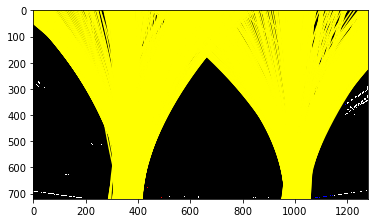

In [85]:
project_video_detector = LaneLineDetector(mtx, dist, src, dst)

project_video_clip = VideoFileClip(project_video_path)
project_video_output_clip = project_video_clip.fl_image(project_video_detector.process_image)
%time project_video_output_clip.write_videofile(project_video_output_path, audio=False)